 # 基于CGAN的手写数字生成器
   
   在图片生成领域，生成对抗网络GAN能够通过训练学习到数据的分布，从而无监督生成新的样本。但是GAN的生成图像是随机的，如手写数字的图片生成中，不能控制生成的手写数字是几，即不能生成指定的标签的类别图片。基于此，Mehdi Mirza等人在2014年提出了CGAN（Conditional Generative Adversarial Network）模型，使得图片的生成变得可控。
   
   本实验基于CGAN模型架构设计一个神经网络，使得当输入为不同的标签时，可以输出为对应的手写数字图片。


In [1]:
# 导入所需要的包
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [3]:
# 定义超参数
b1=0.5
b2=0.999
batch_sizes=128
channels=1
img_size=28
latent_dim=100
lr=0.0002
n_classes=10
n_epochs=100
sample_interval=1000

In [4]:
img_shape = (channels,img_size, img_size)
os.makedirs("images", exist_ok=True)
cuda = True if torch.cuda.is_available() else False

In [5]:
# 数据读取
os.makedirs("data/", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "data/",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_sizes,
    shuffle=True,
)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...



Done!


In [ ]:
#定义sample图像可视化
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

## 一、模型定义

In [6]:
# -----------------
#  定义生成器
# -----------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        #label embedding
        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        
        # 将embedding后的label,与图片一起作为输入input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

    
# -----------------
#  定义判别器
# -----------------

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,128),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
        )

    def forward(self, img, labels):
        
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


In [7]:
# 定义损失函数
adversarial_loss = torch.nn.MSELoss()

# 模型初始化 
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# 定义优化函数
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

## 二、模型训练

In [10]:
results = []
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  训练生成器
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise 和 labels 作为生成器的输入值
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # 生成图片
        gen_imgs = generator(z, gen_labels)

        # 生成器的Loss
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  训练识别器
        # ---------------------

        optimizer_D.zero_grad()

        # 真实图片的Loss
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # 假图片的Loss
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # 识别器的总Loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # 记录数据
        results.append([float(d_loss.data.cpu().numpy()), float(g_loss.data.cpu().numpy())])
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )
        

        batches_done = epoch * len(dataloader) + i    
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)


[Epoch 0/100] [Batch 0/469] [D loss: 0.388603] [G loss: 1.196822]
[Epoch 0/100] [Batch 1/469] [D loss: 0.277078] [G loss: 1.183059]
[Epoch 0/100] [Batch 2/469] [D loss: 0.179773] [G loss: 1.161712]
[Epoch 0/100] [Batch 3/469] [D loss: 0.100729] [G loss: 1.146593]
[Epoch 0/100] [Batch 4/469] [D loss: 0.044160] [G loss: 1.122085]
[Epoch 0/100] [Batch 5/469] [D loss: 0.035456] [G loss: 1.101638]
[Epoch 0/100] [Batch 6/469] [D loss: 0.038646] [G loss: 1.080829]
[Epoch 0/100] [Batch 7/469] [D loss: 0.048841] [G loss: 1.060968]
[Epoch 0/100] [Batch 8/469] [D loss: 0.036832] [G loss: 1.053001]
[Epoch 0/100] [Batch 9/469] [D loss: 0.027557] [G loss: 1.034516]
[Epoch 0/100] [Batch 10/469] [D loss: 0.031562] [G loss: 1.019776]
[Epoch 0/100] [Batch 11/469] [D loss: 0.026418] [G loss: 1.006477]
[Epoch 0/100] [Batch 12/469] [D loss: 0.021497] [G loss: 0.983649]
[Epoch 0/100] [Batch 13/469] [D loss: 0.025405] [G loss: 0.962322]
[Epoch 0/100] [Batch 14/469] [D loss: 0.024014] [G loss: 0.946162]
[Epoc

[Epoch 0/100] [Batch 123/469] [D loss: 0.119195] [G loss: 0.502025]
[Epoch 0/100] [Batch 124/469] [D loss: 0.097640] [G loss: 0.448517]
[Epoch 0/100] [Batch 125/469] [D loss: 0.110468] [G loss: 0.703355]
[Epoch 0/100] [Batch 126/469] [D loss: 0.177499] [G loss: 0.233906]
[Epoch 0/100] [Batch 127/469] [D loss: 0.283465] [G loss: 1.098637]
[Epoch 0/100] [Batch 128/469] [D loss: 0.105735] [G loss: 0.402121]
[Epoch 0/100] [Batch 129/469] [D loss: 0.122360] [G loss: 0.359175]
[Epoch 0/100] [Batch 130/469] [D loss: 0.112207] [G loss: 0.699051]
[Epoch 0/100] [Batch 131/469] [D loss: 0.074289] [G loss: 0.507875]
[Epoch 0/100] [Batch 132/469] [D loss: 0.093589] [G loss: 0.470244]
[Epoch 0/100] [Batch 133/469] [D loss: 0.084528] [G loss: 0.686164]
[Epoch 0/100] [Batch 134/469] [D loss: 0.085872] [G loss: 0.459879]
[Epoch 0/100] [Batch 135/469] [D loss: 0.071959] [G loss: 0.665884]
[Epoch 0/100] [Batch 136/469] [D loss: 0.079670] [G loss: 0.514790]
[Epoch 0/100] [Batch 137/469] [D loss: 0.076328]

[Epoch 0/100] [Batch 246/469] [D loss: 0.069159] [G loss: 0.738519]
[Epoch 0/100] [Batch 247/469] [D loss: 0.069311] [G loss: 0.673447]
[Epoch 0/100] [Batch 248/469] [D loss: 0.069602] [G loss: 0.647473]
[Epoch 0/100] [Batch 249/469] [D loss: 0.083634] [G loss: 0.635289]
[Epoch 0/100] [Batch 250/469] [D loss: 0.068489] [G loss: 0.674317]
[Epoch 0/100] [Batch 251/469] [D loss: 0.082867] [G loss: 0.655435]
[Epoch 0/100] [Batch 252/469] [D loss: 0.102300] [G loss: 0.560203]
[Epoch 0/100] [Batch 253/469] [D loss: 0.101634] [G loss: 0.601579]
[Epoch 0/100] [Batch 254/469] [D loss: 0.107461] [G loss: 0.529878]
[Epoch 0/100] [Batch 255/469] [D loss: 0.122432] [G loss: 0.775599]
[Epoch 0/100] [Batch 256/469] [D loss: 0.187578] [G loss: 0.267593]
[Epoch 0/100] [Batch 257/469] [D loss: 0.209799] [G loss: 1.231595]
[Epoch 0/100] [Batch 258/469] [D loss: 0.186858] [G loss: 0.265872]
[Epoch 0/100] [Batch 259/469] [D loss: 0.112162] [G loss: 0.625117]
[Epoch 0/100] [Batch 260/469] [D loss: 0.101651]

[Epoch 0/100] [Batch 370/469] [D loss: 0.074462] [G loss: 0.660369]
[Epoch 0/100] [Batch 371/469] [D loss: 0.078855] [G loss: 0.551042]
[Epoch 0/100] [Batch 372/469] [D loss: 0.084376] [G loss: 0.620838]
[Epoch 0/100] [Batch 373/469] [D loss: 0.074723] [G loss: 0.597720]
[Epoch 0/100] [Batch 374/469] [D loss: 0.080851] [G loss: 0.611257]
[Epoch 0/100] [Batch 375/469] [D loss: 0.084983] [G loss: 0.567423]
[Epoch 0/100] [Batch 376/469] [D loss: 0.071681] [G loss: 0.623657]
[Epoch 0/100] [Batch 377/469] [D loss: 0.078442] [G loss: 0.601521]
[Epoch 0/100] [Batch 378/469] [D loss: 0.079085] [G loss: 0.613191]
[Epoch 0/100] [Batch 379/469] [D loss: 0.080454] [G loss: 0.580052]
[Epoch 0/100] [Batch 380/469] [D loss: 0.093449] [G loss: 0.785633]
[Epoch 0/100] [Batch 381/469] [D loss: 0.126795] [G loss: 0.363408]
[Epoch 0/100] [Batch 382/469] [D loss: 0.136837] [G loss: 1.002201]
[Epoch 0/100] [Batch 383/469] [D loss: 0.105060] [G loss: 0.416937]
[Epoch 0/100] [Batch 384/469] [D loss: 0.083750]

[Epoch 1/100] [Batch 25/469] [D loss: 0.089697] [G loss: 0.633873]
[Epoch 1/100] [Batch 26/469] [D loss: 0.082919] [G loss: 0.573763]
[Epoch 1/100] [Batch 27/469] [D loss: 0.075392] [G loss: 0.767793]
[Epoch 1/100] [Batch 28/469] [D loss: 0.065376] [G loss: 0.646448]
[Epoch 1/100] [Batch 29/469] [D loss: 0.065669] [G loss: 0.663873]
[Epoch 1/100] [Batch 30/469] [D loss: 0.069054] [G loss: 0.680993]
[Epoch 1/100] [Batch 31/469] [D loss: 0.082308] [G loss: 0.701332]
[Epoch 1/100] [Batch 32/469] [D loss: 0.083604] [G loss: 0.510169]
[Epoch 1/100] [Batch 33/469] [D loss: 0.119255] [G loss: 1.023361]
[Epoch 1/100] [Batch 34/469] [D loss: 0.203208] [G loss: 0.219213]
[Epoch 1/100] [Batch 35/469] [D loss: 0.280086] [G loss: 1.452194]
[Epoch 1/100] [Batch 36/469] [D loss: 0.101768] [G loss: 0.450720]
[Epoch 1/100] [Batch 37/469] [D loss: 0.101137] [G loss: 0.440066]
[Epoch 1/100] [Batch 38/469] [D loss: 0.094343] [G loss: 0.686304]
[Epoch 1/100] [Batch 39/469] [D loss: 0.083343] [G loss: 0.702

[Epoch 1/100] [Batch 148/469] [D loss: 0.053932] [G loss: 0.700572]
[Epoch 1/100] [Batch 149/469] [D loss: 0.074493] [G loss: 0.899328]
[Epoch 1/100] [Batch 150/469] [D loss: 0.076555] [G loss: 0.564885]
[Epoch 1/100] [Batch 151/469] [D loss: 0.082804] [G loss: 0.866139]
[Epoch 1/100] [Batch 152/469] [D loss: 0.082346] [G loss: 0.547290]
[Epoch 1/100] [Batch 153/469] [D loss: 0.104510] [G loss: 1.049803]
[Epoch 1/100] [Batch 154/469] [D loss: 0.093061] [G loss: 0.441738]
[Epoch 1/100] [Batch 155/469] [D loss: 0.074734] [G loss: 0.933380]
[Epoch 1/100] [Batch 156/469] [D loss: 0.063941] [G loss: 0.654614]
[Epoch 1/100] [Batch 157/469] [D loss: 0.054378] [G loss: 0.641423]
[Epoch 1/100] [Batch 158/469] [D loss: 0.060416] [G loss: 0.837494]
[Epoch 1/100] [Batch 159/469] [D loss: 0.067661] [G loss: 0.605132]
[Epoch 1/100] [Batch 160/469] [D loss: 0.060054] [G loss: 0.925259]
[Epoch 1/100] [Batch 161/469] [D loss: 0.076304] [G loss: 0.593867]
[Epoch 1/100] [Batch 162/469] [D loss: 0.097892]

[Epoch 1/100] [Batch 272/469] [D loss: 0.242520] [G loss: 1.436749]
[Epoch 1/100] [Batch 273/469] [D loss: 0.241219] [G loss: 0.198846]
[Epoch 1/100] [Batch 274/469] [D loss: 0.144757] [G loss: 1.013178]
[Epoch 1/100] [Batch 275/469] [D loss: 0.085158] [G loss: 0.697825]
[Epoch 1/100] [Batch 276/469] [D loss: 0.095218] [G loss: 0.458092]
[Epoch 1/100] [Batch 277/469] [D loss: 0.073402] [G loss: 0.670994]
[Epoch 1/100] [Batch 278/469] [D loss: 0.062369] [G loss: 0.737294]
[Epoch 1/100] [Batch 279/469] [D loss: 0.065324] [G loss: 0.620851]
[Epoch 1/100] [Batch 280/469] [D loss: 0.059055] [G loss: 0.708647]
[Epoch 1/100] [Batch 281/469] [D loss: 0.064888] [G loss: 0.731559]
[Epoch 1/100] [Batch 282/469] [D loss: 0.066878] [G loss: 0.616501]
[Epoch 1/100] [Batch 283/469] [D loss: 0.063053] [G loss: 0.785226]
[Epoch 1/100] [Batch 284/469] [D loss: 0.062233] [G loss: 0.678031]
[Epoch 1/100] [Batch 285/469] [D loss: 0.061072] [G loss: 0.683513]
[Epoch 1/100] [Batch 286/469] [D loss: 0.075487]

[Epoch 1/100] [Batch 394/469] [D loss: 0.104447] [G loss: 1.055020]
[Epoch 1/100] [Batch 395/469] [D loss: 0.151478] [G loss: 0.366421]
[Epoch 1/100] [Batch 396/469] [D loss: 0.170498] [G loss: 1.295033]
[Epoch 1/100] [Batch 397/469] [D loss: 0.094732] [G loss: 0.425405]
[Epoch 1/100] [Batch 398/469] [D loss: 0.072241] [G loss: 0.614727]
[Epoch 1/100] [Batch 399/469] [D loss: 0.066500] [G loss: 0.852583]
[Epoch 1/100] [Batch 400/469] [D loss: 0.070792] [G loss: 0.665477]
[Epoch 1/100] [Batch 401/469] [D loss: 0.067223] [G loss: 0.671109]
[Epoch 1/100] [Batch 402/469] [D loss: 0.062416] [G loss: 0.724819]
[Epoch 1/100] [Batch 403/469] [D loss: 0.059451] [G loss: 0.754653]
[Epoch 1/100] [Batch 404/469] [D loss: 0.063137] [G loss: 0.745804]
[Epoch 1/100] [Batch 405/469] [D loss: 0.070848] [G loss: 0.633636]
[Epoch 1/100] [Batch 406/469] [D loss: 0.087728] [G loss: 0.825727]
[Epoch 1/100] [Batch 407/469] [D loss: 0.089644] [G loss: 0.497403]
[Epoch 1/100] [Batch 408/469] [D loss: 0.093591]

[Epoch 2/100] [Batch 49/469] [D loss: 0.074858] [G loss: 0.677780]
[Epoch 2/100] [Batch 50/469] [D loss: 0.065593] [G loss: 0.606640]
[Epoch 2/100] [Batch 51/469] [D loss: 0.060910] [G loss: 0.874963]
[Epoch 2/100] [Batch 52/469] [D loss: 0.066566] [G loss: 0.592397]
[Epoch 2/100] [Batch 53/469] [D loss: 0.061382] [G loss: 0.818483]
[Epoch 2/100] [Batch 54/469] [D loss: 0.064372] [G loss: 0.683682]
[Epoch 2/100] [Batch 55/469] [D loss: 0.059908] [G loss: 0.665225]
[Epoch 2/100] [Batch 56/469] [D loss: 0.073971] [G loss: 0.866735]
[Epoch 2/100] [Batch 57/469] [D loss: 0.086288] [G loss: 0.483435]
[Epoch 2/100] [Batch 58/469] [D loss: 0.126867] [G loss: 1.201872]
[Epoch 2/100] [Batch 59/469] [D loss: 0.171854] [G loss: 0.303338]
[Epoch 2/100] [Batch 60/469] [D loss: 0.193257] [G loss: 1.326519]
[Epoch 2/100] [Batch 61/469] [D loss: 0.102066] [G loss: 0.449160]
[Epoch 2/100] [Batch 62/469] [D loss: 0.055000] [G loss: 0.665519]
[Epoch 2/100] [Batch 63/469] [D loss: 0.075495] [G loss: 0.912

[Epoch 2/100] [Batch 172/469] [D loss: 0.091459] [G loss: 0.879769]
[Epoch 2/100] [Batch 173/469] [D loss: 0.064809] [G loss: 0.705760]
[Epoch 2/100] [Batch 174/469] [D loss: 0.065691] [G loss: 0.575041]
[Epoch 2/100] [Batch 175/469] [D loss: 0.062713] [G loss: 0.781760]
[Epoch 2/100] [Batch 176/469] [D loss: 0.052446] [G loss: 0.694043]
[Epoch 2/100] [Batch 177/469] [D loss: 0.054781] [G loss: 0.742950]
[Epoch 2/100] [Batch 178/469] [D loss: 0.063742] [G loss: 0.761433]
[Epoch 2/100] [Batch 179/469] [D loss: 0.057978] [G loss: 0.642479]
[Epoch 2/100] [Batch 180/469] [D loss: 0.053000] [G loss: 0.874551]
[Epoch 2/100] [Batch 181/469] [D loss: 0.058038] [G loss: 0.655144]
[Epoch 2/100] [Batch 182/469] [D loss: 0.066975] [G loss: 0.798376]
[Epoch 2/100] [Batch 183/469] [D loss: 0.060249] [G loss: 0.685361]
[Epoch 2/100] [Batch 184/469] [D loss: 0.063546] [G loss: 0.776903]
[Epoch 2/100] [Batch 185/469] [D loss: 0.066419] [G loss: 0.680722]
[Epoch 2/100] [Batch 186/469] [D loss: 0.067313]

[Epoch 2/100] [Batch 296/469] [D loss: 0.093432] [G loss: 0.863370]
[Epoch 2/100] [Batch 297/469] [D loss: 0.080422] [G loss: 0.517903]
[Epoch 2/100] [Batch 298/469] [D loss: 0.086206] [G loss: 0.818461]
[Epoch 2/100] [Batch 299/469] [D loss: 0.084310] [G loss: 0.550739]
[Epoch 2/100] [Batch 300/469] [D loss: 0.084633] [G loss: 0.805335]
[Epoch 2/100] [Batch 301/469] [D loss: 0.076923] [G loss: 0.513492]
[Epoch 2/100] [Batch 302/469] [D loss: 0.075704] [G loss: 0.798700]
[Epoch 2/100] [Batch 303/469] [D loss: 0.074721] [G loss: 0.528905]
[Epoch 2/100] [Batch 304/469] [D loss: 0.084645] [G loss: 0.889379]
[Epoch 2/100] [Batch 305/469] [D loss: 0.109135] [G loss: 0.439489]
[Epoch 2/100] [Batch 306/469] [D loss: 0.135338] [G loss: 1.092200]
[Epoch 2/100] [Batch 307/469] [D loss: 0.158270] [G loss: 0.301517]
[Epoch 2/100] [Batch 308/469] [D loss: 0.138234] [G loss: 1.201919]
[Epoch 2/100] [Batch 309/469] [D loss: 0.074704] [G loss: 0.565573]
[Epoch 2/100] [Batch 310/469] [D loss: 0.059915]

[Epoch 2/100] [Batch 417/469] [D loss: 0.083217] [G loss: 0.526200]
[Epoch 2/100] [Batch 418/469] [D loss: 0.091404] [G loss: 0.998580]
[Epoch 2/100] [Batch 419/469] [D loss: 0.089982] [G loss: 0.491022]
[Epoch 2/100] [Batch 420/469] [D loss: 0.097525] [G loss: 1.064061]
[Epoch 2/100] [Batch 421/469] [D loss: 0.106126] [G loss: 0.407763]
[Epoch 2/100] [Batch 422/469] [D loss: 0.098780] [G loss: 1.043806]
[Epoch 2/100] [Batch 423/469] [D loss: 0.087223] [G loss: 0.529091]
[Epoch 2/100] [Batch 424/469] [D loss: 0.082419] [G loss: 0.895683]
[Epoch 2/100] [Batch 425/469] [D loss: 0.076018] [G loss: 0.587217]
[Epoch 2/100] [Batch 426/469] [D loss: 0.055459] [G loss: 0.711538]
[Epoch 2/100] [Batch 427/469] [D loss: 0.061446] [G loss: 0.801874]
[Epoch 2/100] [Batch 428/469] [D loss: 0.073031] [G loss: 0.648159]
[Epoch 2/100] [Batch 429/469] [D loss: 0.060256] [G loss: 0.817707]
[Epoch 2/100] [Batch 430/469] [D loss: 0.072691] [G loss: 0.608093]
[Epoch 2/100] [Batch 431/469] [D loss: 0.064329]

[Epoch 3/100] [Batch 72/469] [D loss: 0.114097] [G loss: 1.128968]
[Epoch 3/100] [Batch 73/469] [D loss: 0.089929] [G loss: 0.487037]
[Epoch 3/100] [Batch 74/469] [D loss: 0.070376] [G loss: 0.968422]
[Epoch 3/100] [Batch 75/469] [D loss: 0.061196] [G loss: 0.660902]
[Epoch 3/100] [Batch 76/469] [D loss: 0.068063] [G loss: 0.578111]
[Epoch 3/100] [Batch 77/469] [D loss: 0.079069] [G loss: 0.982340]
[Epoch 3/100] [Batch 78/469] [D loss: 0.078822] [G loss: 0.524142]
[Epoch 3/100] [Batch 79/469] [D loss: 0.081098] [G loss: 1.009766]
[Epoch 3/100] [Batch 80/469] [D loss: 0.078068] [G loss: 0.527573]
[Epoch 3/100] [Batch 81/469] [D loss: 0.068850] [G loss: 0.927969]
[Epoch 3/100] [Batch 82/469] [D loss: 0.061330] [G loss: 0.660158]
[Epoch 3/100] [Batch 83/469] [D loss: 0.068201] [G loss: 0.801959]
[Epoch 3/100] [Batch 84/469] [D loss: 0.061235] [G loss: 0.675849]
[Epoch 3/100] [Batch 85/469] [D loss: 0.060737] [G loss: 0.891489]
[Epoch 3/100] [Batch 86/469] [D loss: 0.070478] [G loss: 0.579

[Epoch 3/100] [Batch 197/469] [D loss: 0.141459] [G loss: 0.323989]
[Epoch 3/100] [Batch 198/469] [D loss: 0.164840] [G loss: 1.335173]
[Epoch 3/100] [Batch 199/469] [D loss: 0.092491] [G loss: 0.510586]
[Epoch 3/100] [Batch 200/469] [D loss: 0.070429] [G loss: 0.799504]
[Epoch 3/100] [Batch 201/469] [D loss: 0.065584] [G loss: 0.952449]
[Epoch 3/100] [Batch 202/469] [D loss: 0.056575] [G loss: 0.642950]
[Epoch 3/100] [Batch 203/469] [D loss: 0.061768] [G loss: 0.769207]
[Epoch 3/100] [Batch 204/469] [D loss: 0.056686] [G loss: 0.791866]
[Epoch 3/100] [Batch 205/469] [D loss: 0.055203] [G loss: 0.735225]
[Epoch 3/100] [Batch 206/469] [D loss: 0.065496] [G loss: 0.918045]
[Epoch 3/100] [Batch 207/469] [D loss: 0.053969] [G loss: 0.689595]
[Epoch 3/100] [Batch 208/469] [D loss: 0.052271] [G loss: 0.830613]
[Epoch 3/100] [Batch 209/469] [D loss: 0.064554] [G loss: 0.755604]
[Epoch 3/100] [Batch 210/469] [D loss: 0.058746] [G loss: 0.754788]
[Epoch 3/100] [Batch 211/469] [D loss: 0.063959]

[Epoch 3/100] [Batch 318/469] [D loss: 0.070284] [G loss: 0.646435]
[Epoch 3/100] [Batch 319/469] [D loss: 0.069320] [G loss: 0.759305]
[Epoch 3/100] [Batch 320/469] [D loss: 0.073134] [G loss: 0.634981]
[Epoch 3/100] [Batch 321/469] [D loss: 0.074922] [G loss: 0.704681]
[Epoch 3/100] [Batch 322/469] [D loss: 0.075046] [G loss: 0.745752]
[Epoch 3/100] [Batch 323/469] [D loss: 0.065534] [G loss: 0.661040]
[Epoch 3/100] [Batch 324/469] [D loss: 0.073232] [G loss: 0.768892]
[Epoch 3/100] [Batch 325/469] [D loss: 0.082512] [G loss: 0.500185]
[Epoch 3/100] [Batch 326/469] [D loss: 0.095080] [G loss: 0.995986]
[Epoch 3/100] [Batch 327/469] [D loss: 0.128277] [G loss: 0.362374]
[Epoch 3/100] [Batch 328/469] [D loss: 0.176121] [G loss: 1.246510]
[Epoch 3/100] [Batch 329/469] [D loss: 0.221882] [G loss: 0.213001]
[Epoch 3/100] [Batch 330/469] [D loss: 0.226185] [G loss: 1.377044]
[Epoch 3/100] [Batch 331/469] [D loss: 0.095410] [G loss: 0.427801]
[Epoch 3/100] [Batch 332/469] [D loss: 0.085087]

[Epoch 3/100] [Batch 442/469] [D loss: 0.061085] [G loss: 0.799650]
[Epoch 3/100] [Batch 443/469] [D loss: 0.070013] [G loss: 0.658217]
[Epoch 3/100] [Batch 444/469] [D loss: 0.073133] [G loss: 0.708775]
[Epoch 3/100] [Batch 445/469] [D loss: 0.065446] [G loss: 0.783406]
[Epoch 3/100] [Batch 446/469] [D loss: 0.062508] [G loss: 0.591252]
[Epoch 3/100] [Batch 447/469] [D loss: 0.064964] [G loss: 0.885494]
[Epoch 3/100] [Batch 448/469] [D loss: 0.061718] [G loss: 0.623986]
[Epoch 3/100] [Batch 449/469] [D loss: 0.061059] [G loss: 0.790281]
[Epoch 3/100] [Batch 450/469] [D loss: 0.057839] [G loss: 0.700347]
[Epoch 3/100] [Batch 451/469] [D loss: 0.054795] [G loss: 0.731762]
[Epoch 3/100] [Batch 452/469] [D loss: 0.065966] [G loss: 0.723494]
[Epoch 3/100] [Batch 453/469] [D loss: 0.065447] [G loss: 0.638785]
[Epoch 3/100] [Batch 454/469] [D loss: 0.077037] [G loss: 1.004073]
[Epoch 3/100] [Batch 455/469] [D loss: 0.109460] [G loss: 0.435703]
[Epoch 3/100] [Batch 456/469] [D loss: 0.119155]

[Epoch 4/100] [Batch 96/469] [D loss: 0.060960] [G loss: 0.674683]
[Epoch 4/100] [Batch 97/469] [D loss: 0.051873] [G loss: 0.834321]
[Epoch 4/100] [Batch 98/469] [D loss: 0.051550] [G loss: 0.804645]
[Epoch 4/100] [Batch 99/469] [D loss: 0.056962] [G loss: 0.761670]
[Epoch 4/100] [Batch 100/469] [D loss: 0.059051] [G loss: 0.645697]
[Epoch 4/100] [Batch 101/469] [D loss: 0.064458] [G loss: 0.809380]
[Epoch 4/100] [Batch 102/469] [D loss: 0.060334] [G loss: 0.737372]
[Epoch 4/100] [Batch 103/469] [D loss: 0.064479] [G loss: 0.731564]
[Epoch 4/100] [Batch 104/469] [D loss: 0.065045] [G loss: 0.829699]
[Epoch 4/100] [Batch 105/469] [D loss: 0.071925] [G loss: 0.633299]
[Epoch 4/100] [Batch 106/469] [D loss: 0.064668] [G loss: 0.884773]
[Epoch 4/100] [Batch 107/469] [D loss: 0.088692] [G loss: 0.502559]
[Epoch 4/100] [Batch 108/469] [D loss: 0.107275] [G loss: 1.240799]
[Epoch 4/100] [Batch 109/469] [D loss: 0.124282] [G loss: 0.385808]
[Epoch 4/100] [Batch 110/469] [D loss: 0.130463] [G 

[Epoch 4/100] [Batch 218/469] [D loss: 0.076795] [G loss: 0.841691]
[Epoch 4/100] [Batch 219/469] [D loss: 0.065741] [G loss: 0.696635]
[Epoch 4/100] [Batch 220/469] [D loss: 0.068918] [G loss: 0.634641]
[Epoch 4/100] [Batch 221/469] [D loss: 0.074798] [G loss: 0.876993]
[Epoch 4/100] [Batch 222/469] [D loss: 0.065283] [G loss: 0.669417]
[Epoch 4/100] [Batch 223/469] [D loss: 0.077151] [G loss: 0.732889]
[Epoch 4/100] [Batch 224/469] [D loss: 0.070591] [G loss: 0.704292]
[Epoch 4/100] [Batch 225/469] [D loss: 0.061062] [G loss: 0.851706]
[Epoch 4/100] [Batch 226/469] [D loss: 0.069238] [G loss: 0.609683]
[Epoch 4/100] [Batch 227/469] [D loss: 0.062471] [G loss: 0.846835]
[Epoch 4/100] [Batch 228/469] [D loss: 0.072098] [G loss: 0.681213]
[Epoch 4/100] [Batch 229/469] [D loss: 0.069905] [G loss: 1.012464]
[Epoch 4/100] [Batch 230/469] [D loss: 0.075341] [G loss: 0.589250]
[Epoch 4/100] [Batch 231/469] [D loss: 0.076293] [G loss: 0.798046]
[Epoch 4/100] [Batch 232/469] [D loss: 0.074931]

[Epoch 4/100] [Batch 341/469] [D loss: 0.054864] [G loss: 0.863703]
[Epoch 4/100] [Batch 342/469] [D loss: 0.054029] [G loss: 0.772793]
[Epoch 4/100] [Batch 343/469] [D loss: 0.062646] [G loss: 0.619737]
[Epoch 4/100] [Batch 344/469] [D loss: 0.058116] [G loss: 0.841867]
[Epoch 4/100] [Batch 345/469] [D loss: 0.059437] [G loss: 0.693983]
[Epoch 4/100] [Batch 346/469] [D loss: 0.063725] [G loss: 0.810499]
[Epoch 4/100] [Batch 347/469] [D loss: 0.076789] [G loss: 0.612944]
[Epoch 4/100] [Batch 348/469] [D loss: 0.080980] [G loss: 0.869305]
[Epoch 4/100] [Batch 349/469] [D loss: 0.110249] [G loss: 0.435986]
[Epoch 4/100] [Batch 350/469] [D loss: 0.175984] [G loss: 1.390920]
[Epoch 4/100] [Batch 351/469] [D loss: 0.236890] [G loss: 0.197703]
[Epoch 4/100] [Batch 352/469] [D loss: 0.208990] [G loss: 1.432404]
[Epoch 4/100] [Batch 353/469] [D loss: 0.085245] [G loss: 0.529940]
[Epoch 4/100] [Batch 354/469] [D loss: 0.089636] [G loss: 0.577383]
[Epoch 4/100] [Batch 355/469] [D loss: 0.077856]

[Epoch 4/100] [Batch 464/469] [D loss: 0.086799] [G loss: 0.956280]
[Epoch 4/100] [Batch 465/469] [D loss: 0.081921] [G loss: 0.533947]
[Epoch 4/100] [Batch 466/469] [D loss: 0.077796] [G loss: 0.840641]
[Epoch 4/100] [Batch 467/469] [D loss: 0.085441] [G loss: 0.490636]
[Epoch 4/100] [Batch 468/469] [D loss: 0.094882] [G loss: 1.002856]
[Epoch 5/100] [Batch 0/469] [D loss: 0.111138] [G loss: 0.441834]
[Epoch 5/100] [Batch 1/469] [D loss: 0.109472] [G loss: 1.113871]
[Epoch 5/100] [Batch 2/469] [D loss: 0.087646] [G loss: 0.498823]
[Epoch 5/100] [Batch 3/469] [D loss: 0.082287] [G loss: 0.821690]
[Epoch 5/100] [Batch 4/469] [D loss: 0.061836] [G loss: 0.717046]
[Epoch 5/100] [Batch 5/469] [D loss: 0.065790] [G loss: 0.701677]
[Epoch 5/100] [Batch 6/469] [D loss: 0.079489] [G loss: 0.743625]
[Epoch 5/100] [Batch 7/469] [D loss: 0.072729] [G loss: 0.589556]
[Epoch 5/100] [Batch 8/469] [D loss: 0.102682] [G loss: 0.969550]
[Epoch 5/100] [Batch 9/469] [D loss: 0.075293] [G loss: 0.495087]


[Epoch 5/100] [Batch 118/469] [D loss: 0.093051] [G loss: 0.955425]
[Epoch 5/100] [Batch 119/469] [D loss: 0.076270] [G loss: 0.591615]
[Epoch 5/100] [Batch 120/469] [D loss: 0.056950] [G loss: 0.713313]
[Epoch 5/100] [Batch 121/469] [D loss: 0.065379] [G loss: 0.862618]
[Epoch 5/100] [Batch 122/469] [D loss: 0.068346] [G loss: 0.569594]
[Epoch 5/100] [Batch 123/469] [D loss: 0.069709] [G loss: 0.870136]
[Epoch 5/100] [Batch 124/469] [D loss: 0.059588] [G loss: 0.713542]
[Epoch 5/100] [Batch 125/469] [D loss: 0.058939] [G loss: 0.747867]
[Epoch 5/100] [Batch 126/469] [D loss: 0.055926] [G loss: 0.762137]
[Epoch 5/100] [Batch 127/469] [D loss: 0.054120] [G loss: 0.893263]
[Epoch 5/100] [Batch 128/469] [D loss: 0.066276] [G loss: 0.649039]
[Epoch 5/100] [Batch 129/469] [D loss: 0.066202] [G loss: 0.908482]
[Epoch 5/100] [Batch 130/469] [D loss: 0.084353] [G loss: 0.596123]
[Epoch 5/100] [Batch 131/469] [D loss: 0.063324] [G loss: 0.979168]
[Epoch 5/100] [Batch 132/469] [D loss: 0.076752]

[Epoch 5/100] [Batch 242/469] [D loss: 0.081554] [G loss: 0.571146]
[Epoch 5/100] [Batch 243/469] [D loss: 0.087836] [G loss: 0.878088]
[Epoch 5/100] [Batch 244/469] [D loss: 0.085728] [G loss: 0.568009]
[Epoch 5/100] [Batch 245/469] [D loss: 0.086041] [G loss: 0.948632]
[Epoch 5/100] [Batch 246/469] [D loss: 0.091571] [G loss: 0.495107]
[Epoch 5/100] [Batch 247/469] [D loss: 0.092973] [G loss: 0.939053]
[Epoch 5/100] [Batch 248/469] [D loss: 0.086998] [G loss: 0.512882]
[Epoch 5/100] [Batch 249/469] [D loss: 0.088892] [G loss: 0.982880]
[Epoch 5/100] [Batch 250/469] [D loss: 0.070321] [G loss: 0.579868]
[Epoch 5/100] [Batch 251/469] [D loss: 0.084106] [G loss: 0.688246]
[Epoch 5/100] [Batch 252/469] [D loss: 0.077860] [G loss: 0.780600]
[Epoch 5/100] [Batch 253/469] [D loss: 0.082253] [G loss: 0.618900]
[Epoch 5/100] [Batch 254/469] [D loss: 0.077324] [G loss: 0.852884]
[Epoch 5/100] [Batch 255/469] [D loss: 0.073209] [G loss: 0.545324]
[Epoch 5/100] [Batch 256/469] [D loss: 0.069670]

[Epoch 5/100] [Batch 367/469] [D loss: 0.082965] [G loss: 0.542235]
[Epoch 5/100] [Batch 368/469] [D loss: 0.070788] [G loss: 0.909177]
[Epoch 5/100] [Batch 369/469] [D loss: 0.077005] [G loss: 0.620358]
[Epoch 5/100] [Batch 370/469] [D loss: 0.085657] [G loss: 0.859011]
[Epoch 5/100] [Batch 371/469] [D loss: 0.089833] [G loss: 0.531712]
[Epoch 5/100] [Batch 372/469] [D loss: 0.101344] [G loss: 1.072900]
[Epoch 5/100] [Batch 373/469] [D loss: 0.118951] [G loss: 0.400937]
[Epoch 5/100] [Batch 374/469] [D loss: 0.096472] [G loss: 1.056910]
[Epoch 5/100] [Batch 375/469] [D loss: 0.085208] [G loss: 0.533415]
[Epoch 5/100] [Batch 376/469] [D loss: 0.076645] [G loss: 0.858884]
[Epoch 5/100] [Batch 377/469] [D loss: 0.073941] [G loss: 0.650123]
[Epoch 5/100] [Batch 378/469] [D loss: 0.071497] [G loss: 0.735255]
[Epoch 5/100] [Batch 379/469] [D loss: 0.077146] [G loss: 0.730592]
[Epoch 5/100] [Batch 380/469] [D loss: 0.070260] [G loss: 0.637460]
[Epoch 5/100] [Batch 381/469] [D loss: 0.086739]

[Epoch 6/100] [Batch 23/469] [D loss: 0.238120] [G loss: 0.164689]
[Epoch 6/100] [Batch 24/469] [D loss: 0.087415] [G loss: 0.889828]
[Epoch 6/100] [Batch 25/469] [D loss: 0.101417] [G loss: 0.803116]
[Epoch 6/100] [Batch 26/469] [D loss: 0.091197] [G loss: 0.470622]
[Epoch 6/100] [Batch 27/469] [D loss: 0.068589] [G loss: 0.752587]
[Epoch 6/100] [Batch 28/469] [D loss: 0.060189] [G loss: 0.758564]
[Epoch 6/100] [Batch 29/469] [D loss: 0.060849] [G loss: 0.650366]
[Epoch 6/100] [Batch 30/469] [D loss: 0.066823] [G loss: 0.719994]
[Epoch 6/100] [Batch 31/469] [D loss: 0.057176] [G loss: 0.699253]
[Epoch 6/100] [Batch 32/469] [D loss: 0.056842] [G loss: 0.886270]
[Epoch 6/100] [Batch 33/469] [D loss: 0.060274] [G loss: 0.766034]
[Epoch 6/100] [Batch 34/469] [D loss: 0.075487] [G loss: 0.623799]
[Epoch 6/100] [Batch 35/469] [D loss: 0.064814] [G loss: 0.884551]
[Epoch 6/100] [Batch 36/469] [D loss: 0.061413] [G loss: 0.708166]
[Epoch 6/100] [Batch 37/469] [D loss: 0.059760] [G loss: 0.783

[Epoch 6/100] [Batch 147/469] [D loss: 0.067077] [G loss: 0.810890]
[Epoch 6/100] [Batch 148/469] [D loss: 0.073301] [G loss: 0.672016]
[Epoch 6/100] [Batch 149/469] [D loss: 0.068531] [G loss: 0.733312]
[Epoch 6/100] [Batch 150/469] [D loss: 0.083565] [G loss: 0.769764]
[Epoch 6/100] [Batch 151/469] [D loss: 0.103148] [G loss: 0.478644]
[Epoch 6/100] [Batch 152/469] [D loss: 0.177390] [G loss: 1.357967]
[Epoch 6/100] [Batch 153/469] [D loss: 0.331687] [G loss: 0.112350]
[Epoch 6/100] [Batch 154/469] [D loss: 0.328519] [G loss: 1.750896]
[Epoch 6/100] [Batch 155/469] [D loss: 0.114802] [G loss: 0.388565]
[Epoch 6/100] [Batch 156/469] [D loss: 0.105216] [G loss: 0.472097]
[Epoch 6/100] [Batch 157/469] [D loss: 0.118735] [G loss: 0.932940]
[Epoch 6/100] [Batch 158/469] [D loss: 0.081225] [G loss: 0.669338]
[Epoch 6/100] [Batch 159/469] [D loss: 0.090321] [G loss: 0.492794]
[Epoch 6/100] [Batch 160/469] [D loss: 0.075065] [G loss: 0.818769]
[Epoch 6/100] [Batch 161/469] [D loss: 0.072605]

[Epoch 6/100] [Batch 268/469] [D loss: 0.066428] [G loss: 0.814951]
[Epoch 6/100] [Batch 269/469] [D loss: 0.078979] [G loss: 0.605194]
[Epoch 6/100] [Batch 270/469] [D loss: 0.079308] [G loss: 0.906752]
[Epoch 6/100] [Batch 271/469] [D loss: 0.100545] [G loss: 0.511455]
[Epoch 6/100] [Batch 272/469] [D loss: 0.089092] [G loss: 1.055724]
[Epoch 6/100] [Batch 273/469] [D loss: 0.086419] [G loss: 0.527012]
[Epoch 6/100] [Batch 274/469] [D loss: 0.095797] [G loss: 1.053922]
[Epoch 6/100] [Batch 275/469] [D loss: 0.096700] [G loss: 0.478213]
[Epoch 6/100] [Batch 276/469] [D loss: 0.091519] [G loss: 1.037652]
[Epoch 6/100] [Batch 277/469] [D loss: 0.096568] [G loss: 0.476865]
[Epoch 6/100] [Batch 278/469] [D loss: 0.080406] [G loss: 0.911146]
[Epoch 6/100] [Batch 279/469] [D loss: 0.078915] [G loss: 0.545098]
[Epoch 6/100] [Batch 280/469] [D loss: 0.083561] [G loss: 0.937309]
[Epoch 6/100] [Batch 281/469] [D loss: 0.085428] [G loss: 0.613758]
[Epoch 6/100] [Batch 282/469] [D loss: 0.088390]

[Epoch 6/100] [Batch 393/469] [D loss: 0.066999] [G loss: 0.742512]
[Epoch 6/100] [Batch 394/469] [D loss: 0.063256] [G loss: 0.697248]
[Epoch 6/100] [Batch 395/469] [D loss: 0.067910] [G loss: 0.740233]
[Epoch 6/100] [Batch 396/469] [D loss: 0.071889] [G loss: 0.754504]
[Epoch 6/100] [Batch 397/469] [D loss: 0.087485] [G loss: 0.650494]
[Epoch 6/100] [Batch 398/469] [D loss: 0.094776] [G loss: 0.714515]
[Epoch 6/100] [Batch 399/469] [D loss: 0.083127] [G loss: 0.588617]
[Epoch 6/100] [Batch 400/469] [D loss: 0.095302] [G loss: 0.907987]
[Epoch 6/100] [Batch 401/469] [D loss: 0.103719] [G loss: 0.483545]
[Epoch 6/100] [Batch 402/469] [D loss: 0.098649] [G loss: 0.913869]
[Epoch 6/100] [Batch 403/469] [D loss: 0.076270] [G loss: 0.589047]
[Epoch 6/100] [Batch 404/469] [D loss: 0.097514] [G loss: 0.728163]
[Epoch 6/100] [Batch 405/469] [D loss: 0.071264] [G loss: 0.696460]
[Epoch 6/100] [Batch 406/469] [D loss: 0.066310] [G loss: 0.773396]
[Epoch 6/100] [Batch 407/469] [D loss: 0.066617]

[Epoch 7/100] [Batch 47/469] [D loss: 0.077872] [G loss: 0.795820]
[Epoch 7/100] [Batch 48/469] [D loss: 0.080921] [G loss: 0.703465]
[Epoch 7/100] [Batch 49/469] [D loss: 0.074327] [G loss: 0.665290]
[Epoch 7/100] [Batch 50/469] [D loss: 0.067844] [G loss: 0.612636]
[Epoch 7/100] [Batch 51/469] [D loss: 0.080900] [G loss: 0.802893]
[Epoch 7/100] [Batch 52/469] [D loss: 0.083732] [G loss: 0.566836]
[Epoch 7/100] [Batch 53/469] [D loss: 0.088868] [G loss: 0.908757]
[Epoch 7/100] [Batch 54/469] [D loss: 0.085740] [G loss: 0.540040]
[Epoch 7/100] [Batch 55/469] [D loss: 0.090702] [G loss: 0.826414]
[Epoch 7/100] [Batch 56/469] [D loss: 0.083384] [G loss: 0.538946]
[Epoch 7/100] [Batch 57/469] [D loss: 0.076040] [G loss: 0.793736]
[Epoch 7/100] [Batch 58/469] [D loss: 0.075999] [G loss: 0.676677]
[Epoch 7/100] [Batch 59/469] [D loss: 0.092653] [G loss: 0.522873]
[Epoch 7/100] [Batch 60/469] [D loss: 0.081111] [G loss: 0.826152]
[Epoch 7/100] [Batch 61/469] [D loss: 0.077466] [G loss: 0.574

[Epoch 7/100] [Batch 170/469] [D loss: 0.142236] [G loss: 0.380249]
[Epoch 7/100] [Batch 171/469] [D loss: 0.109503] [G loss: 1.034325]
[Epoch 7/100] [Batch 172/469] [D loss: 0.084480] [G loss: 0.598929]
[Epoch 7/100] [Batch 173/469] [D loss: 0.082965] [G loss: 0.700509]
[Epoch 7/100] [Batch 174/469] [D loss: 0.079235] [G loss: 0.813986]
[Epoch 7/100] [Batch 175/469] [D loss: 0.077766] [G loss: 0.564340]
[Epoch 7/100] [Batch 176/469] [D loss: 0.084404] [G loss: 0.846787]
[Epoch 7/100] [Batch 177/469] [D loss: 0.087414] [G loss: 0.580315]
[Epoch 7/100] [Batch 178/469] [D loss: 0.080618] [G loss: 0.785549]
[Epoch 7/100] [Batch 179/469] [D loss: 0.084413] [G loss: 0.580503]
[Epoch 7/100] [Batch 180/469] [D loss: 0.081203] [G loss: 0.889496]
[Epoch 7/100] [Batch 181/469] [D loss: 0.081819] [G loss: 0.565239]
[Epoch 7/100] [Batch 182/469] [D loss: 0.071481] [G loss: 0.804854]
[Epoch 7/100] [Batch 183/469] [D loss: 0.093582] [G loss: 0.713921]
[Epoch 7/100] [Batch 184/469] [D loss: 0.110913]

[Epoch 7/100] [Batch 294/469] [D loss: 0.082650] [G loss: 0.718105]
[Epoch 7/100] [Batch 295/469] [D loss: 0.074175] [G loss: 0.618863]
[Epoch 7/100] [Batch 296/469] [D loss: 0.087172] [G loss: 1.010898]
[Epoch 7/100] [Batch 297/469] [D loss: 0.098751] [G loss: 0.452484]
[Epoch 7/100] [Batch 298/469] [D loss: 0.124994] [G loss: 1.138000]
[Epoch 7/100] [Batch 299/469] [D loss: 0.127472] [G loss: 0.378379]
[Epoch 7/100] [Batch 300/469] [D loss: 0.111700] [G loss: 1.169720]
[Epoch 7/100] [Batch 301/469] [D loss: 0.092541] [G loss: 0.488011]
[Epoch 7/100] [Batch 302/469] [D loss: 0.063765] [G loss: 0.723717]
[Epoch 7/100] [Batch 303/469] [D loss: 0.066622] [G loss: 0.880330]
[Epoch 7/100] [Batch 304/469] [D loss: 0.064053] [G loss: 0.604859]
[Epoch 7/100] [Batch 305/469] [D loss: 0.090041] [G loss: 0.781731]
[Epoch 7/100] [Batch 306/469] [D loss: 0.078547] [G loss: 0.640635]
[Epoch 7/100] [Batch 307/469] [D loss: 0.086476] [G loss: 0.786801]
[Epoch 7/100] [Batch 308/469] [D loss: 0.070704]

[Epoch 7/100] [Batch 418/469] [D loss: 0.100952] [G loss: 0.515160]
[Epoch 7/100] [Batch 419/469] [D loss: 0.081532] [G loss: 0.921767]
[Epoch 7/100] [Batch 420/469] [D loss: 0.096114] [G loss: 0.594454]
[Epoch 7/100] [Batch 421/469] [D loss: 0.084891] [G loss: 0.760873]
[Epoch 7/100] [Batch 422/469] [D loss: 0.097833] [G loss: 0.663898]
[Epoch 7/100] [Batch 423/469] [D loss: 0.081548] [G loss: 0.724367]
[Epoch 7/100] [Batch 424/469] [D loss: 0.088195] [G loss: 0.830045]
[Epoch 7/100] [Batch 425/469] [D loss: 0.086437] [G loss: 0.523796]
[Epoch 7/100] [Batch 426/469] [D loss: 0.119409] [G loss: 1.090481]
[Epoch 7/100] [Batch 427/469] [D loss: 0.168874] [G loss: 0.303441]
[Epoch 7/100] [Batch 428/469] [D loss: 0.235485] [G loss: 1.521949]
[Epoch 7/100] [Batch 429/469] [D loss: 0.216631] [G loss: 0.230900]
[Epoch 7/100] [Batch 430/469] [D loss: 0.107478] [G loss: 0.966486]
[Epoch 7/100] [Batch 431/469] [D loss: 0.073091] [G loss: 0.729872]
[Epoch 7/100] [Batch 432/469] [D loss: 0.088832]

[Epoch 8/100] [Batch 73/469] [D loss: 0.089249] [G loss: 1.043690]
[Epoch 8/100] [Batch 74/469] [D loss: 0.118834] [G loss: 0.385536]
[Epoch 8/100] [Batch 75/469] [D loss: 0.137025] [G loss: 1.099871]
[Epoch 8/100] [Batch 76/469] [D loss: 0.138316] [G loss: 0.372881]
[Epoch 8/100] [Batch 77/469] [D loss: 0.133289] [G loss: 1.074227]
[Epoch 8/100] [Batch 78/469] [D loss: 0.094673] [G loss: 0.517074]
[Epoch 8/100] [Batch 79/469] [D loss: 0.075392] [G loss: 0.775759]
[Epoch 8/100] [Batch 80/469] [D loss: 0.075675] [G loss: 0.744380]
[Epoch 8/100] [Batch 81/469] [D loss: 0.079887] [G loss: 0.639751]
[Epoch 8/100] [Batch 82/469] [D loss: 0.067075] [G loss: 0.704735]
[Epoch 8/100] [Batch 83/469] [D loss: 0.085263] [G loss: 0.742618]
[Epoch 8/100] [Batch 84/469] [D loss: 0.098454] [G loss: 0.587855]
[Epoch 8/100] [Batch 85/469] [D loss: 0.093097] [G loss: 0.875106]
[Epoch 8/100] [Batch 86/469] [D loss: 0.093639] [G loss: 0.497427]
[Epoch 8/100] [Batch 87/469] [D loss: 0.097323] [G loss: 0.952

[Epoch 8/100] [Batch 194/469] [D loss: 0.093244] [G loss: 0.717039]
[Epoch 8/100] [Batch 195/469] [D loss: 0.097520] [G loss: 0.567268]
[Epoch 8/100] [Batch 196/469] [D loss: 0.111863] [G loss: 1.029818]
[Epoch 8/100] [Batch 197/469] [D loss: 0.138834] [G loss: 0.391556]
[Epoch 8/100] [Batch 198/469] [D loss: 0.153818] [G loss: 1.186325]
[Epoch 8/100] [Batch 199/469] [D loss: 0.148455] [G loss: 0.323188]
[Epoch 8/100] [Batch 200/469] [D loss: 0.122111] [G loss: 1.004788]
[Epoch 8/100] [Batch 201/469] [D loss: 0.088829] [G loss: 0.535663]
[Epoch 8/100] [Batch 202/469] [D loss: 0.083041] [G loss: 0.701566]
[Epoch 8/100] [Batch 203/469] [D loss: 0.099768] [G loss: 0.705250]
[Epoch 8/100] [Batch 204/469] [D loss: 0.099494] [G loss: 0.600229]
[Epoch 8/100] [Batch 205/469] [D loss: 0.087083] [G loss: 0.819745]
[Epoch 8/100] [Batch 206/469] [D loss: 0.094651] [G loss: 0.584235]
[Epoch 8/100] [Batch 207/469] [D loss: 0.092605] [G loss: 0.761495]
[Epoch 8/100] [Batch 208/469] [D loss: 0.080507]

[Epoch 8/100] [Batch 316/469] [D loss: 0.096649] [G loss: 0.642759]
[Epoch 8/100] [Batch 317/469] [D loss: 0.098324] [G loss: 0.815507]
[Epoch 8/100] [Batch 318/469] [D loss: 0.085238] [G loss: 0.551665]
[Epoch 8/100] [Batch 319/469] [D loss: 0.079987] [G loss: 0.722057]
[Epoch 8/100] [Batch 320/469] [D loss: 0.091971] [G loss: 0.880836]
[Epoch 8/100] [Batch 321/469] [D loss: 0.125661] [G loss: 0.446519]
[Epoch 8/100] [Batch 322/469] [D loss: 0.112484] [G loss: 1.057281]
[Epoch 8/100] [Batch 323/469] [D loss: 0.118827] [G loss: 0.426816]
[Epoch 8/100] [Batch 324/469] [D loss: 0.101310] [G loss: 0.939804]
[Epoch 8/100] [Batch 325/469] [D loss: 0.107448] [G loss: 0.634226]
[Epoch 8/100] [Batch 326/469] [D loss: 0.094246] [G loss: 0.631551]
[Epoch 8/100] [Batch 327/469] [D loss: 0.089170] [G loss: 0.794396]
[Epoch 8/100] [Batch 328/469] [D loss: 0.084524] [G loss: 0.611535]
[Epoch 8/100] [Batch 329/469] [D loss: 0.097481] [G loss: 0.711792]
[Epoch 8/100] [Batch 330/469] [D loss: 0.087856]

[Epoch 8/100] [Batch 439/469] [D loss: 0.095972] [G loss: 0.540015]
[Epoch 8/100] [Batch 440/469] [D loss: 0.091416] [G loss: 0.920782]
[Epoch 8/100] [Batch 441/469] [D loss: 0.085038] [G loss: 0.608569]
[Epoch 8/100] [Batch 442/469] [D loss: 0.088594] [G loss: 0.642801]
[Epoch 8/100] [Batch 443/469] [D loss: 0.097354] [G loss: 0.675424]
[Epoch 8/100] [Batch 444/469] [D loss: 0.091962] [G loss: 0.829367]
[Epoch 8/100] [Batch 445/469] [D loss: 0.081019] [G loss: 0.597804]
[Epoch 8/100] [Batch 446/469] [D loss: 0.103990] [G loss: 0.822556]
[Epoch 8/100] [Batch 447/469] [D loss: 0.107615] [G loss: 0.476321]
[Epoch 8/100] [Batch 448/469] [D loss: 0.106096] [G loss: 0.977942]
[Epoch 8/100] [Batch 449/469] [D loss: 0.106041] [G loss: 0.476820]
[Epoch 8/100] [Batch 450/469] [D loss: 0.076776] [G loss: 0.779425]
[Epoch 8/100] [Batch 451/469] [D loss: 0.099975] [G loss: 0.618336]
[Epoch 8/100] [Batch 452/469] [D loss: 0.089077] [G loss: 0.713679]
[Epoch 8/100] [Batch 453/469] [D loss: 0.090088]

[Epoch 9/100] [Batch 93/469] [D loss: 0.102061] [G loss: 0.594235]
[Epoch 9/100] [Batch 94/469] [D loss: 0.105966] [G loss: 0.480451]
[Epoch 9/100] [Batch 95/469] [D loss: 0.100427] [G loss: 0.939812]
[Epoch 9/100] [Batch 96/469] [D loss: 0.092219] [G loss: 0.543512]
[Epoch 9/100] [Batch 97/469] [D loss: 0.088172] [G loss: 0.786691]
[Epoch 9/100] [Batch 98/469] [D loss: 0.101140] [G loss: 0.608218]
[Epoch 9/100] [Batch 99/469] [D loss: 0.083719] [G loss: 0.598805]
[Epoch 9/100] [Batch 100/469] [D loss: 0.085349] [G loss: 0.653725]
[Epoch 9/100] [Batch 101/469] [D loss: 0.084115] [G loss: 0.707845]
[Epoch 9/100] [Batch 102/469] [D loss: 0.086904] [G loss: 0.678247]
[Epoch 9/100] [Batch 103/469] [D loss: 0.096885] [G loss: 0.602492]
[Epoch 9/100] [Batch 104/469] [D loss: 0.092218] [G loss: 0.823028]
[Epoch 9/100] [Batch 105/469] [D loss: 0.084436] [G loss: 0.563405]
[Epoch 9/100] [Batch 106/469] [D loss: 0.103303] [G loss: 0.829735]
[Epoch 9/100] [Batch 107/469] [D loss: 0.096479] [G los

[Epoch 9/100] [Batch 217/469] [D loss: 0.096854] [G loss: 0.676127]
[Epoch 9/100] [Batch 218/469] [D loss: 0.096646] [G loss: 0.586248]
[Epoch 9/100] [Batch 219/469] [D loss: 0.094470] [G loss: 0.695220]
[Epoch 9/100] [Batch 220/469] [D loss: 0.092268] [G loss: 0.688634]
[Epoch 9/100] [Batch 221/469] [D loss: 0.094741] [G loss: 0.641803]
[Epoch 9/100] [Batch 222/469] [D loss: 0.095435] [G loss: 0.729321]
[Epoch 9/100] [Batch 223/469] [D loss: 0.108901] [G loss: 0.482656]
[Epoch 9/100] [Batch 224/469] [D loss: 0.125693] [G loss: 0.981892]
[Epoch 9/100] [Batch 225/469] [D loss: 0.154656] [G loss: 0.358223]
[Epoch 9/100] [Batch 226/469] [D loss: 0.191024] [G loss: 1.137210]
[Epoch 9/100] [Batch 227/469] [D loss: 0.247984] [G loss: 0.178487]
[Epoch 9/100] [Batch 228/469] [D loss: 0.180943] [G loss: 1.167784]
[Epoch 9/100] [Batch 229/469] [D loss: 0.103335] [G loss: 0.443823]
[Epoch 9/100] [Batch 230/469] [D loss: 0.103437] [G loss: 0.570104]
[Epoch 9/100] [Batch 231/469] [D loss: 0.095532]

[Epoch 9/100] [Batch 340/469] [D loss: 0.088852] [G loss: 0.567539]
[Epoch 9/100] [Batch 341/469] [D loss: 0.096068] [G loss: 0.754910]
[Epoch 9/100] [Batch 342/469] [D loss: 0.091176] [G loss: 0.651059]
[Epoch 9/100] [Batch 343/469] [D loss: 0.093738] [G loss: 0.655782]
[Epoch 9/100] [Batch 344/469] [D loss: 0.087535] [G loss: 0.713330]
[Epoch 9/100] [Batch 345/469] [D loss: 0.093346] [G loss: 0.683169]
[Epoch 9/100] [Batch 346/469] [D loss: 0.087588] [G loss: 0.583886]
[Epoch 9/100] [Batch 347/469] [D loss: 0.096418] [G loss: 0.784564]
[Epoch 9/100] [Batch 348/469] [D loss: 0.085540] [G loss: 0.614631]
[Epoch 9/100] [Batch 349/469] [D loss: 0.085282] [G loss: 0.819660]
[Epoch 9/100] [Batch 350/469] [D loss: 0.100187] [G loss: 0.576964]
[Epoch 9/100] [Batch 351/469] [D loss: 0.096507] [G loss: 0.723452]
[Epoch 9/100] [Batch 352/469] [D loss: 0.096716] [G loss: 0.636057]
[Epoch 9/100] [Batch 353/469] [D loss: 0.094882] [G loss: 0.714309]
[Epoch 9/100] [Batch 354/469] [D loss: 0.105709]

[Epoch 9/100] [Batch 465/469] [D loss: 0.090009] [G loss: 0.722082]
[Epoch 9/100] [Batch 466/469] [D loss: 0.122682] [G loss: 0.494101]
[Epoch 9/100] [Batch 467/469] [D loss: 0.105395] [G loss: 0.673216]
[Epoch 9/100] [Batch 468/469] [D loss: 0.091125] [G loss: 0.732143]
[Epoch 10/100] [Batch 0/469] [D loss: 0.084324] [G loss: 0.672606]
[Epoch 10/100] [Batch 1/469] [D loss: 0.097738] [G loss: 0.603375]
[Epoch 10/100] [Batch 2/469] [D loss: 0.087561] [G loss: 0.679342]
[Epoch 10/100] [Batch 3/469] [D loss: 0.095000] [G loss: 0.749099]
[Epoch 10/100] [Batch 4/469] [D loss: 0.102448] [G loss: 0.637917]
[Epoch 10/100] [Batch 5/469] [D loss: 0.099511] [G loss: 0.567926]
[Epoch 10/100] [Batch 6/469] [D loss: 0.106506] [G loss: 0.789250]
[Epoch 10/100] [Batch 7/469] [D loss: 0.101178] [G loss: 0.572623]
[Epoch 10/100] [Batch 8/469] [D loss: 0.107873] [G loss: 0.756688]
[Epoch 10/100] [Batch 9/469] [D loss: 0.103340] [G loss: 0.558790]
[Epoch 10/100] [Batch 10/469] [D loss: 0.087529] [G loss: 

[Epoch 10/100] [Batch 117/469] [D loss: 0.093354] [G loss: 0.849103]
[Epoch 10/100] [Batch 118/469] [D loss: 0.105145] [G loss: 0.509463]
[Epoch 10/100] [Batch 119/469] [D loss: 0.112485] [G loss: 0.594311]
[Epoch 10/100] [Batch 120/469] [D loss: 0.109829] [G loss: 0.745501]
[Epoch 10/100] [Batch 121/469] [D loss: 0.118630] [G loss: 0.500405]
[Epoch 10/100] [Batch 122/469] [D loss: 0.136082] [G loss: 0.836972]
[Epoch 10/100] [Batch 123/469] [D loss: 0.144099] [G loss: 0.400788]
[Epoch 10/100] [Batch 124/469] [D loss: 0.143849] [G loss: 0.980937]
[Epoch 10/100] [Batch 125/469] [D loss: 0.138224] [G loss: 0.371147]
[Epoch 10/100] [Batch 126/469] [D loss: 0.136506] [G loss: 0.947633]
[Epoch 10/100] [Batch 127/469] [D loss: 0.105988] [G loss: 0.561189]
[Epoch 10/100] [Batch 128/469] [D loss: 0.122022] [G loss: 0.474945]
[Epoch 10/100] [Batch 129/469] [D loss: 0.144192] [G loss: 1.074507]
[Epoch 10/100] [Batch 130/469] [D loss: 0.159972] [G loss: 0.296801]
[Epoch 10/100] [Batch 131/469] [D 

[Epoch 10/100] [Batch 237/469] [D loss: 0.102810] [G loss: 0.768946]
[Epoch 10/100] [Batch 238/469] [D loss: 0.088169] [G loss: 0.616524]
[Epoch 10/100] [Batch 239/469] [D loss: 0.087045] [G loss: 0.665208]
[Epoch 10/100] [Batch 240/469] [D loss: 0.096187] [G loss: 0.761158]
[Epoch 10/100] [Batch 241/469] [D loss: 0.108926] [G loss: 0.577466]
[Epoch 10/100] [Batch 242/469] [D loss: 0.080224] [G loss: 0.797514]
[Epoch 10/100] [Batch 243/469] [D loss: 0.098376] [G loss: 0.646347]
[Epoch 10/100] [Batch 244/469] [D loss: 0.093609] [G loss: 0.576047]
[Epoch 10/100] [Batch 245/469] [D loss: 0.096347] [G loss: 0.670008]
[Epoch 10/100] [Batch 246/469] [D loss: 0.103997] [G loss: 0.611547]
[Epoch 10/100] [Batch 247/469] [D loss: 0.094370] [G loss: 0.614666]
[Epoch 10/100] [Batch 248/469] [D loss: 0.106751] [G loss: 0.879978]
[Epoch 10/100] [Batch 249/469] [D loss: 0.123887] [G loss: 0.475172]
[Epoch 10/100] [Batch 250/469] [D loss: 0.147650] [G loss: 1.023643]
[Epoch 10/100] [Batch 251/469] [D 

[Epoch 10/100] [Batch 356/469] [D loss: 0.133001] [G loss: 0.857991]
[Epoch 10/100] [Batch 357/469] [D loss: 0.115371] [G loss: 0.453774]
[Epoch 10/100] [Batch 358/469] [D loss: 0.112505] [G loss: 0.782433]
[Epoch 10/100] [Batch 359/469] [D loss: 0.121214] [G loss: 0.460967]
[Epoch 10/100] [Batch 360/469] [D loss: 0.112737] [G loss: 0.824503]
[Epoch 10/100] [Batch 361/469] [D loss: 0.107467] [G loss: 0.513609]
[Epoch 10/100] [Batch 362/469] [D loss: 0.099424] [G loss: 0.632746]
[Epoch 10/100] [Batch 363/469] [D loss: 0.102065] [G loss: 0.675018]
[Epoch 10/100] [Batch 364/469] [D loss: 0.095262] [G loss: 0.632656]
[Epoch 10/100] [Batch 365/469] [D loss: 0.106884] [G loss: 0.647145]
[Epoch 10/100] [Batch 366/469] [D loss: 0.106342] [G loss: 0.683748]
[Epoch 10/100] [Batch 367/469] [D loss: 0.101626] [G loss: 0.620530]
[Epoch 10/100] [Batch 368/469] [D loss: 0.120973] [G loss: 0.615560]
[Epoch 10/100] [Batch 369/469] [D loss: 0.108452] [G loss: 0.579296]
[Epoch 10/100] [Batch 370/469] [D 

[Epoch 11/100] [Batch 7/469] [D loss: 0.079852] [G loss: 0.697096]
[Epoch 11/100] [Batch 8/469] [D loss: 0.098129] [G loss: 0.828705]
[Epoch 11/100] [Batch 9/469] [D loss: 0.099999] [G loss: 0.497032]
[Epoch 11/100] [Batch 10/469] [D loss: 0.105754] [G loss: 1.050850]
[Epoch 11/100] [Batch 11/469] [D loss: 0.127266] [G loss: 0.457406]
[Epoch 11/100] [Batch 12/469] [D loss: 0.130397] [G loss: 1.085478]
[Epoch 11/100] [Batch 13/469] [D loss: 0.129383] [G loss: 0.447961]
[Epoch 11/100] [Batch 14/469] [D loss: 0.118688] [G loss: 0.944610]
[Epoch 11/100] [Batch 15/469] [D loss: 0.097041] [G loss: 0.574928]
[Epoch 11/100] [Batch 16/469] [D loss: 0.092253] [G loss: 0.711258]
[Epoch 11/100] [Batch 17/469] [D loss: 0.099886] [G loss: 0.560035]
[Epoch 11/100] [Batch 18/469] [D loss: 0.106589] [G loss: 0.870501]
[Epoch 11/100] [Batch 19/469] [D loss: 0.123720] [G loss: 0.380063]
[Epoch 11/100] [Batch 20/469] [D loss: 0.102886] [G loss: 0.860379]
[Epoch 11/100] [Batch 21/469] [D loss: 0.096942] [G

[Epoch 11/100] [Batch 130/469] [D loss: 0.095929] [G loss: 0.708108]
[Epoch 11/100] [Batch 131/469] [D loss: 0.106596] [G loss: 0.554350]
[Epoch 11/100] [Batch 132/469] [D loss: 0.095341] [G loss: 0.661349]
[Epoch 11/100] [Batch 133/469] [D loss: 0.100153] [G loss: 0.665041]
[Epoch 11/100] [Batch 134/469] [D loss: 0.104570] [G loss: 0.540104]
[Epoch 11/100] [Batch 135/469] [D loss: 0.101076] [G loss: 0.745687]
[Epoch 11/100] [Batch 136/469] [D loss: 0.103598] [G loss: 0.486054]
[Epoch 11/100] [Batch 137/469] [D loss: 0.116362] [G loss: 0.840689]
[Epoch 11/100] [Batch 138/469] [D loss: 0.103841] [G loss: 0.509415]
[Epoch 11/100] [Batch 139/469] [D loss: 0.095112] [G loss: 0.699771]
[Epoch 11/100] [Batch 140/469] [D loss: 0.114561] [G loss: 0.677668]
[Epoch 11/100] [Batch 141/469] [D loss: 0.112519] [G loss: 0.523538]
[Epoch 11/100] [Batch 142/469] [D loss: 0.102283] [G loss: 0.822060]
[Epoch 11/100] [Batch 143/469] [D loss: 0.114717] [G loss: 0.526572]
[Epoch 11/100] [Batch 144/469] [D 

[Epoch 11/100] [Batch 252/469] [D loss: 0.112851] [G loss: 0.636936]
[Epoch 11/100] [Batch 253/469] [D loss: 0.102852] [G loss: 0.605387]
[Epoch 11/100] [Batch 254/469] [D loss: 0.106488] [G loss: 0.693937]
[Epoch 11/100] [Batch 255/469] [D loss: 0.112400] [G loss: 0.523014]
[Epoch 11/100] [Batch 256/469] [D loss: 0.109036] [G loss: 0.782044]
[Epoch 11/100] [Batch 257/469] [D loss: 0.104182] [G loss: 0.582779]
[Epoch 11/100] [Batch 258/469] [D loss: 0.094113] [G loss: 0.660417]
[Epoch 11/100] [Batch 259/469] [D loss: 0.106444] [G loss: 0.791062]
[Epoch 11/100] [Batch 260/469] [D loss: 0.131431] [G loss: 0.407530]
[Epoch 11/100] [Batch 261/469] [D loss: 0.123570] [G loss: 1.020023]
[Epoch 11/100] [Batch 262/469] [D loss: 0.144579] [G loss: 0.331391]
[Epoch 11/100] [Batch 263/469] [D loss: 0.145315] [G loss: 0.916613]
[Epoch 11/100] [Batch 264/469] [D loss: 0.131399] [G loss: 0.419185]
[Epoch 11/100] [Batch 265/469] [D loss: 0.144114] [G loss: 0.828833]
[Epoch 11/100] [Batch 266/469] [D 

[Epoch 11/100] [Batch 372/469] [D loss: 0.107064] [G loss: 0.564777]
[Epoch 11/100] [Batch 373/469] [D loss: 0.097958] [G loss: 0.716412]
[Epoch 11/100] [Batch 374/469] [D loss: 0.092461] [G loss: 0.528803]
[Epoch 11/100] [Batch 375/469] [D loss: 0.110330] [G loss: 0.871692]
[Epoch 11/100] [Batch 376/469] [D loss: 0.103433] [G loss: 0.519780]
[Epoch 11/100] [Batch 377/469] [D loss: 0.100749] [G loss: 0.964233]
[Epoch 11/100] [Batch 378/469] [D loss: 0.120118] [G loss: 0.473419]
[Epoch 11/100] [Batch 379/469] [D loss: 0.112478] [G loss: 0.889867]
[Epoch 11/100] [Batch 380/469] [D loss: 0.150271] [G loss: 0.341859]
[Epoch 11/100] [Batch 381/469] [D loss: 0.147401] [G loss: 1.199466]
[Epoch 11/100] [Batch 382/469] [D loss: 0.189366] [G loss: 0.320920]
[Epoch 11/100] [Batch 383/469] [D loss: 0.176131] [G loss: 1.066684]
[Epoch 11/100] [Batch 384/469] [D loss: 0.144272] [G loss: 0.363328]
[Epoch 11/100] [Batch 385/469] [D loss: 0.106364] [G loss: 0.899554]
[Epoch 11/100] [Batch 386/469] [D 

[Epoch 12/100] [Batch 26/469] [D loss: 0.101206] [G loss: 0.678911]
[Epoch 12/100] [Batch 27/469] [D loss: 0.104289] [G loss: 0.645742]
[Epoch 12/100] [Batch 28/469] [D loss: 0.106930] [G loss: 0.572156]
[Epoch 12/100] [Batch 29/469] [D loss: 0.122054] [G loss: 0.751343]
[Epoch 12/100] [Batch 30/469] [D loss: 0.118028] [G loss: 0.421312]
[Epoch 12/100] [Batch 31/469] [D loss: 0.142039] [G loss: 0.951152]
[Epoch 12/100] [Batch 32/469] [D loss: 0.242410] [G loss: 0.194127]
[Epoch 12/100] [Batch 33/469] [D loss: 0.292964] [G loss: 1.401031]
[Epoch 12/100] [Batch 34/469] [D loss: 0.206518] [G loss: 0.215983]
[Epoch 12/100] [Batch 35/469] [D loss: 0.114317] [G loss: 0.631547]
[Epoch 12/100] [Batch 36/469] [D loss: 0.136544] [G loss: 0.774284]
[Epoch 12/100] [Batch 37/469] [D loss: 0.138663] [G loss: 0.415664]
[Epoch 12/100] [Batch 38/469] [D loss: 0.110461] [G loss: 0.690260]
[Epoch 12/100] [Batch 39/469] [D loss: 0.130613] [G loss: 0.634394]
[Epoch 12/100] [Batch 40/469] [D loss: 0.107104]

[Epoch 12/100] [Batch 146/469] [D loss: 0.087182] [G loss: 0.745352]
[Epoch 12/100] [Batch 147/469] [D loss: 0.114178] [G loss: 0.652857]
[Epoch 12/100] [Batch 148/469] [D loss: 0.088540] [G loss: 0.634672]
[Epoch 12/100] [Batch 149/469] [D loss: 0.099328] [G loss: 0.686465]
[Epoch 12/100] [Batch 150/469] [D loss: 0.094777] [G loss: 0.646716]
[Epoch 12/100] [Batch 151/469] [D loss: 0.109216] [G loss: 0.723976]
[Epoch 12/100] [Batch 152/469] [D loss: 0.108792] [G loss: 0.574431]
[Epoch 12/100] [Batch 153/469] [D loss: 0.110290] [G loss: 0.812667]
[Epoch 12/100] [Batch 154/469] [D loss: 0.113319] [G loss: 0.487776]
[Epoch 12/100] [Batch 155/469] [D loss: 0.141020] [G loss: 0.944798]
[Epoch 12/100] [Batch 156/469] [D loss: 0.154763] [G loss: 0.305829]
[Epoch 12/100] [Batch 157/469] [D loss: 0.166768] [G loss: 1.105556]
[Epoch 12/100] [Batch 158/469] [D loss: 0.161752] [G loss: 0.358898]
[Epoch 12/100] [Batch 159/469] [D loss: 0.132579] [G loss: 0.938844]
[Epoch 12/100] [Batch 160/469] [D 

[Epoch 12/100] [Batch 266/469] [D loss: 0.164175] [G loss: 1.133855]
[Epoch 12/100] [Batch 267/469] [D loss: 0.218441] [G loss: 0.211101]
[Epoch 12/100] [Batch 268/469] [D loss: 0.207485] [G loss: 1.283076]
[Epoch 12/100] [Batch 269/469] [D loss: 0.160178] [G loss: 0.324719]
[Epoch 12/100] [Batch 270/469] [D loss: 0.094802] [G loss: 0.711736]
[Epoch 12/100] [Batch 271/469] [D loss: 0.116650] [G loss: 0.771025]
[Epoch 12/100] [Batch 272/469] [D loss: 0.113198] [G loss: 0.416562]
[Epoch 12/100] [Batch 273/469] [D loss: 0.110983] [G loss: 0.773039]
[Epoch 12/100] [Batch 274/469] [D loss: 0.102418] [G loss: 0.651087]
[Epoch 12/100] [Batch 275/469] [D loss: 0.110980] [G loss: 0.575456]
[Epoch 12/100] [Batch 276/469] [D loss: 0.121455] [G loss: 0.762679]
[Epoch 12/100] [Batch 277/469] [D loss: 0.107331] [G loss: 0.484523]
[Epoch 12/100] [Batch 278/469] [D loss: 0.088294] [G loss: 0.757058]
[Epoch 12/100] [Batch 279/469] [D loss: 0.090840] [G loss: 0.683364]
[Epoch 12/100] [Batch 280/469] [D 

[Epoch 12/100] [Batch 388/469] [D loss: 0.162607] [G loss: 0.898280]
[Epoch 12/100] [Batch 389/469] [D loss: 0.178523] [G loss: 0.279974]
[Epoch 12/100] [Batch 390/469] [D loss: 0.164044] [G loss: 1.040651]
[Epoch 12/100] [Batch 391/469] [D loss: 0.152555] [G loss: 0.447872]
[Epoch 12/100] [Batch 392/469] [D loss: 0.103574] [G loss: 0.576470]
[Epoch 12/100] [Batch 393/469] [D loss: 0.131866] [G loss: 0.795790]
[Epoch 12/100] [Batch 394/469] [D loss: 0.107601] [G loss: 0.474951]
[Epoch 12/100] [Batch 395/469] [D loss: 0.106372] [G loss: 0.725090]
[Epoch 12/100] [Batch 396/469] [D loss: 0.097375] [G loss: 0.580524]
[Epoch 12/100] [Batch 397/469] [D loss: 0.103570] [G loss: 0.774703]
[Epoch 12/100] [Batch 398/469] [D loss: 0.111207] [G loss: 0.590390]
[Epoch 12/100] [Batch 399/469] [D loss: 0.105198] [G loss: 0.552523]
[Epoch 12/100] [Batch 400/469] [D loss: 0.123419] [G loss: 0.788950]
[Epoch 12/100] [Batch 401/469] [D loss: 0.100811] [G loss: 0.539289]
[Epoch 12/100] [Batch 402/469] [D 

[Epoch 13/100] [Batch 43/469] [D loss: 0.116781] [G loss: 0.504773]
[Epoch 13/100] [Batch 44/469] [D loss: 0.135433] [G loss: 1.017791]
[Epoch 13/100] [Batch 45/469] [D loss: 0.138421] [G loss: 0.382311]
[Epoch 13/100] [Batch 46/469] [D loss: 0.124099] [G loss: 0.802505]
[Epoch 13/100] [Batch 47/469] [D loss: 0.117474] [G loss: 0.463220]
[Epoch 13/100] [Batch 48/469] [D loss: 0.120319] [G loss: 0.830262]
[Epoch 13/100] [Batch 49/469] [D loss: 0.127745] [G loss: 0.425846]
[Epoch 13/100] [Batch 50/469] [D loss: 0.141570] [G loss: 0.830470]
[Epoch 13/100] [Batch 51/469] [D loss: 0.115845] [G loss: 0.417698]
[Epoch 13/100] [Batch 52/469] [D loss: 0.124577] [G loss: 0.736213]
[Epoch 13/100] [Batch 53/469] [D loss: 0.111943] [G loss: 0.581699]
[Epoch 13/100] [Batch 54/469] [D loss: 0.118108] [G loss: 0.567671]
[Epoch 13/100] [Batch 55/469] [D loss: 0.119972] [G loss: 0.644908]
[Epoch 13/100] [Batch 56/469] [D loss: 0.129308] [G loss: 0.578242]
[Epoch 13/100] [Batch 57/469] [D loss: 0.114291]

[Epoch 13/100] [Batch 166/469] [D loss: 0.096202] [G loss: 0.762191]
[Epoch 13/100] [Batch 167/469] [D loss: 0.102002] [G loss: 0.624825]
[Epoch 13/100] [Batch 168/469] [D loss: 0.105346] [G loss: 0.740007]
[Epoch 13/100] [Batch 169/469] [D loss: 0.114422] [G loss: 0.451216]
[Epoch 13/100] [Batch 170/469] [D loss: 0.122243] [G loss: 0.957858]
[Epoch 13/100] [Batch 171/469] [D loss: 0.130658] [G loss: 0.393009]
[Epoch 13/100] [Batch 172/469] [D loss: 0.173926] [G loss: 1.027535]
[Epoch 13/100] [Batch 173/469] [D loss: 0.187094] [G loss: 0.253221]
[Epoch 13/100] [Batch 174/469] [D loss: 0.179249] [G loss: 1.131741]
[Epoch 13/100] [Batch 175/469] [D loss: 0.166378] [G loss: 0.341400]
[Epoch 13/100] [Batch 176/469] [D loss: 0.110379] [G loss: 0.795048]
[Epoch 13/100] [Batch 177/469] [D loss: 0.108803] [G loss: 0.617645]
[Epoch 13/100] [Batch 178/469] [D loss: 0.127037] [G loss: 0.561738]
[Epoch 13/100] [Batch 179/469] [D loss: 0.117432] [G loss: 0.721164]
[Epoch 13/100] [Batch 180/469] [D 

[Epoch 13/100] [Batch 285/469] [D loss: 0.114968] [G loss: 0.713144]
[Epoch 13/100] [Batch 286/469] [D loss: 0.111936] [G loss: 0.592852]
[Epoch 13/100] [Batch 287/469] [D loss: 0.101967] [G loss: 0.709926]
[Epoch 13/100] [Batch 288/469] [D loss: 0.110047] [G loss: 0.705400]
[Epoch 13/100] [Batch 289/469] [D loss: 0.117463] [G loss: 0.473136]
[Epoch 13/100] [Batch 290/469] [D loss: 0.121114] [G loss: 0.968485]
[Epoch 13/100] [Batch 291/469] [D loss: 0.124140] [G loss: 0.467063]
[Epoch 13/100] [Batch 292/469] [D loss: 0.109195] [G loss: 0.828183]
[Epoch 13/100] [Batch 293/469] [D loss: 0.119757] [G loss: 0.496807]
[Epoch 13/100] [Batch 294/469] [D loss: 0.107611] [G loss: 0.800938]
[Epoch 13/100] [Batch 295/469] [D loss: 0.099334] [G loss: 0.499384]
[Epoch 13/100] [Batch 296/469] [D loss: 0.107910] [G loss: 0.823438]
[Epoch 13/100] [Batch 297/469] [D loss: 0.110330] [G loss: 0.558058]
[Epoch 13/100] [Batch 298/469] [D loss: 0.111009] [G loss: 0.797949]
[Epoch 13/100] [Batch 299/469] [D 

[Epoch 13/100] [Batch 407/469] [D loss: 0.127570] [G loss: 0.665533]
[Epoch 13/100] [Batch 408/469] [D loss: 0.098514] [G loss: 0.575117]
[Epoch 13/100] [Batch 409/469] [D loss: 0.110170] [G loss: 0.605446]
[Epoch 13/100] [Batch 410/469] [D loss: 0.125185] [G loss: 0.611328]
[Epoch 13/100] [Batch 411/469] [D loss: 0.110896] [G loss: 0.607507]
[Epoch 13/100] [Batch 412/469] [D loss: 0.112348] [G loss: 0.741987]
[Epoch 13/100] [Batch 413/469] [D loss: 0.154385] [G loss: 0.398454]
[Epoch 13/100] [Batch 414/469] [D loss: 0.138985] [G loss: 1.037166]
[Epoch 13/100] [Batch 415/469] [D loss: 0.151907] [G loss: 0.353741]
[Epoch 13/100] [Batch 416/469] [D loss: 0.141365] [G loss: 0.876064]
[Epoch 13/100] [Batch 417/469] [D loss: 0.146159] [G loss: 0.385866]
[Epoch 13/100] [Batch 418/469] [D loss: 0.110024] [G loss: 0.694775]
[Epoch 13/100] [Batch 419/469] [D loss: 0.116712] [G loss: 0.628427]
[Epoch 13/100] [Batch 420/469] [D loss: 0.120397] [G loss: 0.460606]
[Epoch 13/100] [Batch 421/469] [D 

[Epoch 14/100] [Batch 62/469] [D loss: 0.132968] [G loss: 0.446619]
[Epoch 14/100] [Batch 63/469] [D loss: 0.119446] [G loss: 0.584418]
[Epoch 14/100] [Batch 64/469] [D loss: 0.109033] [G loss: 0.805023]
[Epoch 14/100] [Batch 65/469] [D loss: 0.125362] [G loss: 0.404140]
[Epoch 14/100] [Batch 66/469] [D loss: 0.145783] [G loss: 0.932640]
[Epoch 14/100] [Batch 67/469] [D loss: 0.128562] [G loss: 0.404001]
[Epoch 14/100] [Batch 68/469] [D loss: 0.148872] [G loss: 0.894894]
[Epoch 14/100] [Batch 69/469] [D loss: 0.129199] [G loss: 0.381233]
[Epoch 14/100] [Batch 70/469] [D loss: 0.134842] [G loss: 0.868649]
[Epoch 14/100] [Batch 71/469] [D loss: 0.140967] [G loss: 0.446544]
[Epoch 14/100] [Batch 72/469] [D loss: 0.110974] [G loss: 0.781969]
[Epoch 14/100] [Batch 73/469] [D loss: 0.100658] [G loss: 0.601521]
[Epoch 14/100] [Batch 74/469] [D loss: 0.107179] [G loss: 0.639955]
[Epoch 14/100] [Batch 75/469] [D loss: 0.115181] [G loss: 0.675221]
[Epoch 14/100] [Batch 76/469] [D loss: 0.116842]

[Epoch 14/100] [Batch 184/469] [D loss: 0.131285] [G loss: 0.768799]
[Epoch 14/100] [Batch 185/469] [D loss: 0.125162] [G loss: 0.575632]
[Epoch 14/100] [Batch 186/469] [D loss: 0.114639] [G loss: 0.569438]
[Epoch 14/100] [Batch 187/469] [D loss: 0.121778] [G loss: 0.752881]
[Epoch 14/100] [Batch 188/469] [D loss: 0.127468] [G loss: 0.504062]
[Epoch 14/100] [Batch 189/469] [D loss: 0.134861] [G loss: 0.799956]
[Epoch 14/100] [Batch 190/469] [D loss: 0.166861] [G loss: 0.344765]
[Epoch 14/100] [Batch 191/469] [D loss: 0.167119] [G loss: 1.010451]
[Epoch 14/100] [Batch 192/469] [D loss: 0.174479] [G loss: 0.294982]
[Epoch 14/100] [Batch 193/469] [D loss: 0.144716] [G loss: 0.842865]
[Epoch 14/100] [Batch 194/469] [D loss: 0.116201] [G loss: 0.498654]
[Epoch 14/100] [Batch 195/469] [D loss: 0.108861] [G loss: 0.683604]
[Epoch 14/100] [Batch 196/469] [D loss: 0.129982] [G loss: 0.501834]
[Epoch 14/100] [Batch 197/469] [D loss: 0.117326] [G loss: 0.660590]
[Epoch 14/100] [Batch 198/469] [D 

[Epoch 14/100] [Batch 307/469] [D loss: 0.109696] [G loss: 0.700332]
[Epoch 14/100] [Batch 308/469] [D loss: 0.104449] [G loss: 0.586412]
[Epoch 14/100] [Batch 309/469] [D loss: 0.126313] [G loss: 0.559055]
[Epoch 14/100] [Batch 310/469] [D loss: 0.124660] [G loss: 0.612129]
[Epoch 14/100] [Batch 311/469] [D loss: 0.135096] [G loss: 0.447236]
[Epoch 14/100] [Batch 312/469] [D loss: 0.133360] [G loss: 0.922371]
[Epoch 14/100] [Batch 313/469] [D loss: 0.126035] [G loss: 0.483726]
[Epoch 14/100] [Batch 314/469] [D loss: 0.128286] [G loss: 0.555425]
[Epoch 14/100] [Batch 315/469] [D loss: 0.106454] [G loss: 0.671395]
[Epoch 14/100] [Batch 316/469] [D loss: 0.132241] [G loss: 0.531690]
[Epoch 14/100] [Batch 317/469] [D loss: 0.111276] [G loss: 0.654936]
[Epoch 14/100] [Batch 318/469] [D loss: 0.106571] [G loss: 0.571770]
[Epoch 14/100] [Batch 319/469] [D loss: 0.135653] [G loss: 0.812038]
[Epoch 14/100] [Batch 320/469] [D loss: 0.145926] [G loss: 0.326532]
[Epoch 14/100] [Batch 321/469] [D 

[Epoch 14/100] [Batch 427/469] [D loss: 0.128042] [G loss: 0.439258]
[Epoch 14/100] [Batch 428/469] [D loss: 0.119889] [G loss: 0.844608]
[Epoch 14/100] [Batch 429/469] [D loss: 0.120417] [G loss: 0.496815]
[Epoch 14/100] [Batch 430/469] [D loss: 0.111378] [G loss: 0.748269]
[Epoch 14/100] [Batch 431/469] [D loss: 0.104882] [G loss: 0.535856]
[Epoch 14/100] [Batch 432/469] [D loss: 0.139477] [G loss: 0.599760]
[Epoch 14/100] [Batch 433/469] [D loss: 0.115664] [G loss: 0.836917]
[Epoch 14/100] [Batch 434/469] [D loss: 0.116291] [G loss: 0.486896]
[Epoch 14/100] [Batch 435/469] [D loss: 0.144318] [G loss: 0.899405]
[Epoch 14/100] [Batch 436/469] [D loss: 0.147228] [G loss: 0.352889]
[Epoch 14/100] [Batch 437/469] [D loss: 0.136497] [G loss: 0.901031]
[Epoch 14/100] [Batch 438/469] [D loss: 0.124032] [G loss: 0.430852]
[Epoch 14/100] [Batch 439/469] [D loss: 0.119514] [G loss: 0.744202]
[Epoch 14/100] [Batch 440/469] [D loss: 0.113031] [G loss: 0.563873]
[Epoch 14/100] [Batch 441/469] [D 

[Epoch 15/100] [Batch 80/469] [D loss: 0.134955] [G loss: 0.402232]
[Epoch 15/100] [Batch 81/469] [D loss: 0.128472] [G loss: 0.850831]
[Epoch 15/100] [Batch 82/469] [D loss: 0.131997] [G loss: 0.421349]
[Epoch 15/100] [Batch 83/469] [D loss: 0.125288] [G loss: 0.808835]
[Epoch 15/100] [Batch 84/469] [D loss: 0.120649] [G loss: 0.515334]
[Epoch 15/100] [Batch 85/469] [D loss: 0.111709] [G loss: 0.571045]
[Epoch 15/100] [Batch 86/469] [D loss: 0.130870] [G loss: 0.714157]
[Epoch 15/100] [Batch 87/469] [D loss: 0.156843] [G loss: 0.393670]
[Epoch 15/100] [Batch 88/469] [D loss: 0.160925] [G loss: 1.033568]
[Epoch 15/100] [Batch 89/469] [D loss: 0.189924] [G loss: 0.249942]
[Epoch 15/100] [Batch 90/469] [D loss: 0.150344] [G loss: 0.967276]
[Epoch 15/100] [Batch 91/469] [D loss: 0.114067] [G loss: 0.530516]
[Epoch 15/100] [Batch 92/469] [D loss: 0.111694] [G loss: 0.502606]
[Epoch 15/100] [Batch 93/469] [D loss: 0.135731] [G loss: 0.792022]
[Epoch 15/100] [Batch 94/469] [D loss: 0.132840]

[Epoch 15/100] [Batch 200/469] [D loss: 0.129200] [G loss: 0.525435]
[Epoch 15/100] [Batch 201/469] [D loss: 0.130125] [G loss: 0.746942]
[Epoch 15/100] [Batch 202/469] [D loss: 0.149651] [G loss: 0.430972]
[Epoch 15/100] [Batch 203/469] [D loss: 0.150750] [G loss: 0.887889]
[Epoch 15/100] [Batch 204/469] [D loss: 0.146300] [G loss: 0.364154]
[Epoch 15/100] [Batch 205/469] [D loss: 0.173263] [G loss: 0.876996]
[Epoch 15/100] [Batch 206/469] [D loss: 0.152216] [G loss: 0.374517]
[Epoch 15/100] [Batch 207/469] [D loss: 0.148268] [G loss: 0.825445]
[Epoch 15/100] [Batch 208/469] [D loss: 0.130071] [G loss: 0.424406]
[Epoch 15/100] [Batch 209/469] [D loss: 0.122450] [G loss: 0.765070]
[Epoch 15/100] [Batch 210/469] [D loss: 0.109054] [G loss: 0.499991]
[Epoch 15/100] [Batch 211/469] [D loss: 0.129882] [G loss: 0.901962]
[Epoch 15/100] [Batch 212/469] [D loss: 0.134875] [G loss: 0.447842]
[Epoch 15/100] [Batch 213/469] [D loss: 0.134238] [G loss: 0.745867]
[Epoch 15/100] [Batch 214/469] [D 

[Epoch 15/100] [Batch 320/469] [D loss: 0.122982] [G loss: 0.493191]
[Epoch 15/100] [Batch 321/469] [D loss: 0.120107] [G loss: 0.581955]
[Epoch 15/100] [Batch 322/469] [D loss: 0.114947] [G loss: 0.707341]
[Epoch 15/100] [Batch 323/469] [D loss: 0.130857] [G loss: 0.474843]
[Epoch 15/100] [Batch 324/469] [D loss: 0.109608] [G loss: 0.676851]
[Epoch 15/100] [Batch 325/469] [D loss: 0.114738] [G loss: 0.555201]
[Epoch 15/100] [Batch 326/469] [D loss: 0.126132] [G loss: 0.662494]
[Epoch 15/100] [Batch 327/469] [D loss: 0.121555] [G loss: 0.652876]
[Epoch 15/100] [Batch 328/469] [D loss: 0.119617] [G loss: 0.566278]
[Epoch 15/100] [Batch 329/469] [D loss: 0.125057] [G loss: 0.771968]
[Epoch 15/100] [Batch 330/469] [D loss: 0.154409] [G loss: 0.430258]
[Epoch 15/100] [Batch 331/469] [D loss: 0.155340] [G loss: 0.878773]
[Epoch 15/100] [Batch 332/469] [D loss: 0.163453] [G loss: 0.300296]
[Epoch 15/100] [Batch 333/469] [D loss: 0.189410] [G loss: 0.970046]
[Epoch 15/100] [Batch 334/469] [D 

[Epoch 15/100] [Batch 440/469] [D loss: 0.134957] [G loss: 0.484195]
[Epoch 15/100] [Batch 441/469] [D loss: 0.129254] [G loss: 0.646103]
[Epoch 15/100] [Batch 442/469] [D loss: 0.099278] [G loss: 0.540595]
[Epoch 15/100] [Batch 443/469] [D loss: 0.131390] [G loss: 0.752631]
[Epoch 15/100] [Batch 444/469] [D loss: 0.123103] [G loss: 0.436173]
[Epoch 15/100] [Batch 445/469] [D loss: 0.116566] [G loss: 0.767058]
[Epoch 15/100] [Batch 446/469] [D loss: 0.130517] [G loss: 0.557316]
[Epoch 15/100] [Batch 447/469] [D loss: 0.132879] [G loss: 0.433721]
[Epoch 15/100] [Batch 448/469] [D loss: 0.159977] [G loss: 1.006345]
[Epoch 15/100] [Batch 449/469] [D loss: 0.218136] [G loss: 0.269362]
[Epoch 15/100] [Batch 450/469] [D loss: 0.205420] [G loss: 1.031434]
[Epoch 15/100] [Batch 451/469] [D loss: 0.165719] [G loss: 0.307241]
[Epoch 15/100] [Batch 452/469] [D loss: 0.136716] [G loss: 0.588026]
[Epoch 15/100] [Batch 453/469] [D loss: 0.128953] [G loss: 0.713029]
[Epoch 15/100] [Batch 454/469] [D 

[Epoch 16/100] [Batch 93/469] [D loss: 0.121074] [G loss: 0.609872]
[Epoch 16/100] [Batch 94/469] [D loss: 0.116422] [G loss: 0.490364]
[Epoch 16/100] [Batch 95/469] [D loss: 0.138435] [G loss: 0.887746]
[Epoch 16/100] [Batch 96/469] [D loss: 0.198821] [G loss: 0.250535]
[Epoch 16/100] [Batch 97/469] [D loss: 0.174579] [G loss: 1.008168]
[Epoch 16/100] [Batch 98/469] [D loss: 0.155993] [G loss: 0.356241]
[Epoch 16/100] [Batch 99/469] [D loss: 0.142845] [G loss: 0.759246]
[Epoch 16/100] [Batch 100/469] [D loss: 0.129155] [G loss: 0.501794]
[Epoch 16/100] [Batch 101/469] [D loss: 0.136613] [G loss: 0.597577]
[Epoch 16/100] [Batch 102/469] [D loss: 0.134847] [G loss: 0.549278]
[Epoch 16/100] [Batch 103/469] [D loss: 0.118904] [G loss: 0.582518]
[Epoch 16/100] [Batch 104/469] [D loss: 0.131072] [G loss: 0.659156]
[Epoch 16/100] [Batch 105/469] [D loss: 0.116255] [G loss: 0.512753]
[Epoch 16/100] [Batch 106/469] [D loss: 0.110097] [G loss: 0.681711]
[Epoch 16/100] [Batch 107/469] [D loss: 0

[Epoch 16/100] [Batch 212/469] [D loss: 0.121374] [G loss: 0.774525]
[Epoch 16/100] [Batch 213/469] [D loss: 0.135937] [G loss: 0.467882]
[Epoch 16/100] [Batch 214/469] [D loss: 0.139202] [G loss: 0.691105]
[Epoch 16/100] [Batch 215/469] [D loss: 0.123433] [G loss: 0.433782]
[Epoch 16/100] [Batch 216/469] [D loss: 0.117652] [G loss: 0.785490]
[Epoch 16/100] [Batch 217/469] [D loss: 0.139813] [G loss: 0.488523]
[Epoch 16/100] [Batch 218/469] [D loss: 0.125901] [G loss: 0.615171]
[Epoch 16/100] [Batch 219/469] [D loss: 0.114304] [G loss: 0.624307]
[Epoch 16/100] [Batch 220/469] [D loss: 0.124235] [G loss: 0.573349]
[Epoch 16/100] [Batch 221/469] [D loss: 0.117038] [G loss: 0.574930]
[Epoch 16/100] [Batch 222/469] [D loss: 0.124731] [G loss: 0.584054]
[Epoch 16/100] [Batch 223/469] [D loss: 0.139636] [G loss: 0.574975]
[Epoch 16/100] [Batch 224/469] [D loss: 0.119281] [G loss: 0.552871]
[Epoch 16/100] [Batch 225/469] [D loss: 0.116895] [G loss: 0.714371]
[Epoch 16/100] [Batch 226/469] [D 

[Epoch 16/100] [Batch 331/469] [D loss: 0.130230] [G loss: 0.508048]
[Epoch 16/100] [Batch 332/469] [D loss: 0.125357] [G loss: 0.604511]
[Epoch 16/100] [Batch 333/469] [D loss: 0.128136] [G loss: 0.562336]
[Epoch 16/100] [Batch 334/469] [D loss: 0.106571] [G loss: 0.670200]
[Epoch 16/100] [Batch 335/469] [D loss: 0.108086] [G loss: 0.607727]
[Epoch 16/100] [Batch 336/469] [D loss: 0.112731] [G loss: 0.644869]
[Epoch 16/100] [Batch 337/469] [D loss: 0.131753] [G loss: 0.456166]
[Epoch 16/100] [Batch 338/469] [D loss: 0.134774] [G loss: 0.899099]
[Epoch 16/100] [Batch 339/469] [D loss: 0.120488] [G loss: 0.436838]
[Epoch 16/100] [Batch 340/469] [D loss: 0.121504] [G loss: 0.648466]
[Epoch 16/100] [Batch 341/469] [D loss: 0.117632] [G loss: 0.697831]
[Epoch 16/100] [Batch 342/469] [D loss: 0.132263] [G loss: 0.504825]
[Epoch 16/100] [Batch 343/469] [D loss: 0.165020] [G loss: 0.797428]
[Epoch 16/100] [Batch 344/469] [D loss: 0.169836] [G loss: 0.338427]
[Epoch 16/100] [Batch 345/469] [D 

[Epoch 16/100] [Batch 453/469] [D loss: 0.144104] [G loss: 0.408312]
[Epoch 16/100] [Batch 454/469] [D loss: 0.128955] [G loss: 0.793927]
[Epoch 16/100] [Batch 455/469] [D loss: 0.151995] [G loss: 0.349084]
[Epoch 16/100] [Batch 456/469] [D loss: 0.157166] [G loss: 0.802435]
[Epoch 16/100] [Batch 457/469] [D loss: 0.154350] [G loss: 0.390761]
[Epoch 16/100] [Batch 458/469] [D loss: 0.156154] [G loss: 0.771336]
[Epoch 16/100] [Batch 459/469] [D loss: 0.159202] [G loss: 0.374752]
[Epoch 16/100] [Batch 460/469] [D loss: 0.139268] [G loss: 0.703820]
[Epoch 16/100] [Batch 461/469] [D loss: 0.122481] [G loss: 0.758359]
[Epoch 16/100] [Batch 462/469] [D loss: 0.153307] [G loss: 0.359155]
[Epoch 16/100] [Batch 463/469] [D loss: 0.167243] [G loss: 0.937604]
[Epoch 16/100] [Batch 464/469] [D loss: 0.154800] [G loss: 0.369436]
[Epoch 16/100] [Batch 465/469] [D loss: 0.133756] [G loss: 0.613129]
[Epoch 16/100] [Batch 466/469] [D loss: 0.143238] [G loss: 0.763681]
[Epoch 16/100] [Batch 467/469] [D 

[Epoch 17/100] [Batch 108/469] [D loss: 0.140018] [G loss: 0.477283]
[Epoch 17/100] [Batch 109/469] [D loss: 0.112740] [G loss: 0.706965]
[Epoch 17/100] [Batch 110/469] [D loss: 0.136762] [G loss: 0.610471]
[Epoch 17/100] [Batch 111/469] [D loss: 0.117181] [G loss: 0.515334]
[Epoch 17/100] [Batch 112/469] [D loss: 0.139274] [G loss: 0.687793]
[Epoch 17/100] [Batch 113/469] [D loss: 0.131140] [G loss: 0.493846]
[Epoch 17/100] [Batch 114/469] [D loss: 0.129438] [G loss: 0.637443]
[Epoch 17/100] [Batch 115/469] [D loss: 0.139453] [G loss: 0.511025]
[Epoch 17/100] [Batch 116/469] [D loss: 0.125581] [G loss: 0.643583]
[Epoch 17/100] [Batch 117/469] [D loss: 0.134334] [G loss: 0.570008]
[Epoch 17/100] [Batch 118/469] [D loss: 0.139576] [G loss: 0.513140]
[Epoch 17/100] [Batch 119/469] [D loss: 0.138506] [G loss: 0.598760]
[Epoch 17/100] [Batch 120/469] [D loss: 0.129648] [G loss: 0.602748]
[Epoch 17/100] [Batch 121/469] [D loss: 0.117319] [G loss: 0.480237]
[Epoch 17/100] [Batch 122/469] [D 

[Epoch 17/100] [Batch 231/469] [D loss: 0.118730] [G loss: 0.768624]
[Epoch 17/100] [Batch 232/469] [D loss: 0.140838] [G loss: 0.492207]
[Epoch 17/100] [Batch 233/469] [D loss: 0.132433] [G loss: 0.634017]
[Epoch 17/100] [Batch 234/469] [D loss: 0.115143] [G loss: 0.547474]
[Epoch 17/100] [Batch 235/469] [D loss: 0.127310] [G loss: 0.719555]
[Epoch 17/100] [Batch 236/469] [D loss: 0.146949] [G loss: 0.430830]
[Epoch 17/100] [Batch 237/469] [D loss: 0.150129] [G loss: 0.843173]
[Epoch 17/100] [Batch 238/469] [D loss: 0.156777] [G loss: 0.359031]
[Epoch 17/100] [Batch 239/469] [D loss: 0.143691] [G loss: 0.796910]
[Epoch 17/100] [Batch 240/469] [D loss: 0.119953] [G loss: 0.482406]
[Epoch 17/100] [Batch 241/469] [D loss: 0.123210] [G loss: 0.693913]
[Epoch 17/100] [Batch 242/469] [D loss: 0.133163] [G loss: 0.469446]
[Epoch 17/100] [Batch 243/469] [D loss: 0.113395] [G loss: 0.663612]
[Epoch 17/100] [Batch 244/469] [D loss: 0.125129] [G loss: 0.614820]
[Epoch 17/100] [Batch 245/469] [D 

[Epoch 17/100] [Batch 350/469] [D loss: 0.117874] [G loss: 0.505531]
[Epoch 17/100] [Batch 351/469] [D loss: 0.134836] [G loss: 0.737444]
[Epoch 17/100] [Batch 352/469] [D loss: 0.135329] [G loss: 0.407912]
[Epoch 17/100] [Batch 353/469] [D loss: 0.146904] [G loss: 0.778594]
[Epoch 17/100] [Batch 354/469] [D loss: 0.131989] [G loss: 0.382330]
[Epoch 17/100] [Batch 355/469] [D loss: 0.122140] [G loss: 0.753489]
[Epoch 17/100] [Batch 356/469] [D loss: 0.138364] [G loss: 0.474673]
[Epoch 17/100] [Batch 357/469] [D loss: 0.144322] [G loss: 0.617743]
[Epoch 17/100] [Batch 358/469] [D loss: 0.123630] [G loss: 0.519269]
[Epoch 17/100] [Batch 359/469] [D loss: 0.126499] [G loss: 0.610240]
[Epoch 17/100] [Batch 360/469] [D loss: 0.132076] [G loss: 0.445917]
[Epoch 17/100] [Batch 361/469] [D loss: 0.142971] [G loss: 0.813736]
[Epoch 17/100] [Batch 362/469] [D loss: 0.160326] [G loss: 0.385074]
[Epoch 17/100] [Batch 363/469] [D loss: 0.153243] [G loss: 0.825316]
[Epoch 17/100] [Batch 364/469] [D 

[Epoch 18/100] [Batch 1/469] [D loss: 0.135312] [G loss: 0.451632]
[Epoch 18/100] [Batch 2/469] [D loss: 0.148124] [G loss: 0.740158]
[Epoch 18/100] [Batch 3/469] [D loss: 0.136182] [G loss: 0.428665]
[Epoch 18/100] [Batch 4/469] [D loss: 0.125881] [G loss: 0.755582]
[Epoch 18/100] [Batch 5/469] [D loss: 0.123974] [G loss: 0.472032]
[Epoch 18/100] [Batch 6/469] [D loss: 0.141401] [G loss: 0.652610]
[Epoch 18/100] [Batch 7/469] [D loss: 0.123138] [G loss: 0.506167]
[Epoch 18/100] [Batch 8/469] [D loss: 0.139505] [G loss: 0.536849]
[Epoch 18/100] [Batch 9/469] [D loss: 0.131387] [G loss: 0.620448]
[Epoch 18/100] [Batch 10/469] [D loss: 0.142812] [G loss: 0.600532]
[Epoch 18/100] [Batch 11/469] [D loss: 0.130967] [G loss: 0.516184]
[Epoch 18/100] [Batch 12/469] [D loss: 0.132670] [G loss: 0.682374]
[Epoch 18/100] [Batch 13/469] [D loss: 0.133388] [G loss: 0.491044]
[Epoch 18/100] [Batch 14/469] [D loss: 0.129566] [G loss: 0.534522]
[Epoch 18/100] [Batch 15/469] [D loss: 0.130637] [G loss:

[Epoch 18/100] [Batch 126/469] [D loss: 0.148648] [G loss: 0.383481]
[Epoch 18/100] [Batch 127/469] [D loss: 0.164789] [G loss: 0.761639]
[Epoch 18/100] [Batch 128/469] [D loss: 0.159844] [G loss: 0.361683]
[Epoch 18/100] [Batch 129/469] [D loss: 0.150091] [G loss: 0.682424]
[Epoch 18/100] [Batch 130/469] [D loss: 0.136489] [G loss: 0.531757]
[Epoch 18/100] [Batch 131/469] [D loss: 0.116093] [G loss: 0.549738]
[Epoch 18/100] [Batch 132/469] [D loss: 0.144275] [G loss: 0.600258]
[Epoch 18/100] [Batch 133/469] [D loss: 0.162113] [G loss: 0.381207]
[Epoch 18/100] [Batch 134/469] [D loss: 0.150540] [G loss: 0.911852]
[Epoch 18/100] [Batch 135/469] [D loss: 0.171542] [G loss: 0.330374]
[Epoch 18/100] [Batch 136/469] [D loss: 0.137922] [G loss: 0.634312]
[Epoch 18/100] [Batch 137/469] [D loss: 0.140703] [G loss: 0.476192]
[Epoch 18/100] [Batch 138/469] [D loss: 0.126956] [G loss: 0.521699]
[Epoch 18/100] [Batch 139/469] [D loss: 0.132680] [G loss: 0.573944]
[Epoch 18/100] [Batch 140/469] [D 

[Epoch 18/100] [Batch 249/469] [D loss: 0.135850] [G loss: 0.417743]
[Epoch 18/100] [Batch 250/469] [D loss: 0.128666] [G loss: 0.613360]
[Epoch 18/100] [Batch 251/469] [D loss: 0.130739] [G loss: 0.554188]
[Epoch 18/100] [Batch 252/469] [D loss: 0.129984] [G loss: 0.493834]
[Epoch 18/100] [Batch 253/469] [D loss: 0.149008] [G loss: 0.686807]
[Epoch 18/100] [Batch 254/469] [D loss: 0.162916] [G loss: 0.326193]
[Epoch 18/100] [Batch 255/469] [D loss: 0.191563] [G loss: 0.990407]
[Epoch 18/100] [Batch 256/469] [D loss: 0.221422] [G loss: 0.241113]
[Epoch 18/100] [Batch 257/469] [D loss: 0.197241] [G loss: 0.869132]
[Epoch 18/100] [Batch 258/469] [D loss: 0.154028] [G loss: 0.396207]
[Epoch 18/100] [Batch 259/469] [D loss: 0.146495] [G loss: 0.598416]
[Epoch 18/100] [Batch 260/469] [D loss: 0.126427] [G loss: 0.634983]
[Epoch 18/100] [Batch 261/469] [D loss: 0.130882] [G loss: 0.471949]
[Epoch 18/100] [Batch 262/469] [D loss: 0.145206] [G loss: 0.645057]
[Epoch 18/100] [Batch 263/469] [D 

[Epoch 18/100] [Batch 372/469] [D loss: 0.117362] [G loss: 0.546600]
[Epoch 18/100] [Batch 373/469] [D loss: 0.141799] [G loss: 0.752465]
[Epoch 18/100] [Batch 374/469] [D loss: 0.132616] [G loss: 0.443691]
[Epoch 18/100] [Batch 375/469] [D loss: 0.124225] [G loss: 0.753806]
[Epoch 18/100] [Batch 376/469] [D loss: 0.124122] [G loss: 0.506127]
[Epoch 18/100] [Batch 377/469] [D loss: 0.124972] [G loss: 0.608636]
[Epoch 18/100] [Batch 378/469] [D loss: 0.134507] [G loss: 0.725264]
[Epoch 18/100] [Batch 379/469] [D loss: 0.140645] [G loss: 0.448080]
[Epoch 18/100] [Batch 380/469] [D loss: 0.125374] [G loss: 0.694702]
[Epoch 18/100] [Batch 381/469] [D loss: 0.144510] [G loss: 0.491460]
[Epoch 18/100] [Batch 382/469] [D loss: 0.132432] [G loss: 0.716391]
[Epoch 18/100] [Batch 383/469] [D loss: 0.144786] [G loss: 0.420941]
[Epoch 18/100] [Batch 384/469] [D loss: 0.153000] [G loss: 0.884863]
[Epoch 18/100] [Batch 385/469] [D loss: 0.162086] [G loss: 0.328816]
[Epoch 18/100] [Batch 386/469] [D 

[Epoch 19/100] [Batch 27/469] [D loss: 0.143205] [G loss: 0.679607]
[Epoch 19/100] [Batch 28/469] [D loss: 0.137433] [G loss: 0.552283]
[Epoch 19/100] [Batch 29/469] [D loss: 0.142188] [G loss: 0.489299]
[Epoch 19/100] [Batch 30/469] [D loss: 0.140301] [G loss: 0.499361]
[Epoch 19/100] [Batch 31/469] [D loss: 0.143993] [G loss: 0.538804]
[Epoch 19/100] [Batch 32/469] [D loss: 0.158810] [G loss: 0.655080]
[Epoch 19/100] [Batch 33/469] [D loss: 0.166327] [G loss: 0.334365]
[Epoch 19/100] [Batch 34/469] [D loss: 0.147143] [G loss: 0.734757]
[Epoch 19/100] [Batch 35/469] [D loss: 0.149379] [G loss: 0.543691]
[Epoch 19/100] [Batch 36/469] [D loss: 0.151604] [G loss: 0.452056]
[Epoch 19/100] [Batch 37/469] [D loss: 0.124655] [G loss: 0.566322]
[Epoch 19/100] [Batch 38/469] [D loss: 0.143820] [G loss: 0.631662]
[Epoch 19/100] [Batch 39/469] [D loss: 0.151995] [G loss: 0.414811]
[Epoch 19/100] [Batch 40/469] [D loss: 0.139063] [G loss: 0.575948]
[Epoch 19/100] [Batch 41/469] [D loss: 0.147541]

[Epoch 19/100] [Batch 148/469] [D loss: 0.137067] [G loss: 0.515146]
[Epoch 19/100] [Batch 149/469] [D loss: 0.120376] [G loss: 0.636320]
[Epoch 19/100] [Batch 150/469] [D loss: 0.129700] [G loss: 0.559635]
[Epoch 19/100] [Batch 151/469] [D loss: 0.123170] [G loss: 0.570718]
[Epoch 19/100] [Batch 152/469] [D loss: 0.143736] [G loss: 0.608128]
[Epoch 19/100] [Batch 153/469] [D loss: 0.174317] [G loss: 0.288097]
[Epoch 19/100] [Batch 154/469] [D loss: 0.151940] [G loss: 0.710340]
[Epoch 19/100] [Batch 155/469] [D loss: 0.133373] [G loss: 0.578193]
[Epoch 19/100] [Batch 156/469] [D loss: 0.151113] [G loss: 0.457765]
[Epoch 19/100] [Batch 157/469] [D loss: 0.147173] [G loss: 0.581661]
[Epoch 19/100] [Batch 158/469] [D loss: 0.135672] [G loss: 0.529610]
[Epoch 19/100] [Batch 159/469] [D loss: 0.139548] [G loss: 0.532889]
[Epoch 19/100] [Batch 160/469] [D loss: 0.145096] [G loss: 0.586420]
[Epoch 19/100] [Batch 161/469] [D loss: 0.142029] [G loss: 0.613012]
[Epoch 19/100] [Batch 162/469] [D 

[Epoch 19/100] [Batch 268/469] [D loss: 0.222473] [G loss: 0.207505]
[Epoch 19/100] [Batch 269/469] [D loss: 0.254771] [G loss: 0.988002]
[Epoch 19/100] [Batch 270/469] [D loss: 0.226968] [G loss: 0.185332]
[Epoch 19/100] [Batch 271/469] [D loss: 0.150469] [G loss: 0.643270]
[Epoch 19/100] [Batch 272/469] [D loss: 0.131292] [G loss: 0.607067]
[Epoch 19/100] [Batch 273/469] [D loss: 0.162596] [G loss: 0.523680]
[Epoch 19/100] [Batch 274/469] [D loss: 0.168287] [G loss: 0.360709]
[Epoch 19/100] [Batch 275/469] [D loss: 0.138422] [G loss: 0.653482]
[Epoch 19/100] [Batch 276/469] [D loss: 0.142938] [G loss: 0.465858]
[Epoch 19/100] [Batch 277/469] [D loss: 0.133791] [G loss: 0.534698]
[Epoch 19/100] [Batch 278/469] [D loss: 0.117325] [G loss: 0.653359]
[Epoch 19/100] [Batch 279/469] [D loss: 0.146048] [G loss: 0.413139]
[Epoch 19/100] [Batch 280/469] [D loss: 0.140552] [G loss: 0.632445]
[Epoch 19/100] [Batch 281/469] [D loss: 0.150386] [G loss: 0.515357]
[Epoch 19/100] [Batch 282/469] [D 

[Epoch 19/100] [Batch 387/469] [D loss: 0.136445] [G loss: 0.521266]
[Epoch 19/100] [Batch 388/469] [D loss: 0.143254] [G loss: 0.592322]
[Epoch 19/100] [Batch 389/469] [D loss: 0.165908] [G loss: 0.431875]
[Epoch 19/100] [Batch 390/469] [D loss: 0.170280] [G loss: 0.806653]
[Epoch 19/100] [Batch 391/469] [D loss: 0.199402] [G loss: 0.281607]
[Epoch 19/100] [Batch 392/469] [D loss: 0.180745] [G loss: 0.829957]
[Epoch 19/100] [Batch 393/469] [D loss: 0.162662] [G loss: 0.363509]
[Epoch 19/100] [Batch 394/469] [D loss: 0.167363] [G loss: 0.668683]
[Epoch 19/100] [Batch 395/469] [D loss: 0.161685] [G loss: 0.482195]
[Epoch 19/100] [Batch 396/469] [D loss: 0.140822] [G loss: 0.392526]
[Epoch 19/100] [Batch 397/469] [D loss: 0.123096] [G loss: 0.686749]
[Epoch 19/100] [Batch 398/469] [D loss: 0.150188] [G loss: 0.454738]
[Epoch 19/100] [Batch 399/469] [D loss: 0.131726] [G loss: 0.541046]
[Epoch 19/100] [Batch 400/469] [D loss: 0.151845] [G loss: 0.554505]
[Epoch 19/100] [Batch 401/469] [D 

[Epoch 20/100] [Batch 40/469] [D loss: 0.175617] [G loss: 0.306524]
[Epoch 20/100] [Batch 41/469] [D loss: 0.152292] [G loss: 0.917239]
[Epoch 20/100] [Batch 42/469] [D loss: 0.164345] [G loss: 0.371700]
[Epoch 20/100] [Batch 43/469] [D loss: 0.140025] [G loss: 0.579865]
[Epoch 20/100] [Batch 44/469] [D loss: 0.128234] [G loss: 0.659451]
[Epoch 20/100] [Batch 45/469] [D loss: 0.133552] [G loss: 0.494886]
[Epoch 20/100] [Batch 46/469] [D loss: 0.139430] [G loss: 0.533912]
[Epoch 20/100] [Batch 47/469] [D loss: 0.140527] [G loss: 0.676533]
[Epoch 20/100] [Batch 48/469] [D loss: 0.140563] [G loss: 0.489065]
[Epoch 20/100] [Batch 49/469] [D loss: 0.122510] [G loss: 0.657460]
[Epoch 20/100] [Batch 50/469] [D loss: 0.136784] [G loss: 0.535233]
[Epoch 20/100] [Batch 51/469] [D loss: 0.130390] [G loss: 0.534498]
[Epoch 20/100] [Batch 52/469] [D loss: 0.137990] [G loss: 0.565978]
[Epoch 20/100] [Batch 53/469] [D loss: 0.128864] [G loss: 0.550916]
[Epoch 20/100] [Batch 54/469] [D loss: 0.135386]

[Epoch 20/100] [Batch 162/469] [D loss: 0.149576] [G loss: 0.409260]
[Epoch 20/100] [Batch 163/469] [D loss: 0.175797] [G loss: 0.751973]
[Epoch 20/100] [Batch 164/469] [D loss: 0.199264] [G loss: 0.272921]
[Epoch 20/100] [Batch 165/469] [D loss: 0.189847] [G loss: 0.851087]
[Epoch 20/100] [Batch 166/469] [D loss: 0.166620] [G loss: 0.307845]
[Epoch 20/100] [Batch 167/469] [D loss: 0.140829] [G loss: 0.609966]
[Epoch 20/100] [Batch 168/469] [D loss: 0.118687] [G loss: 0.619671]
[Epoch 20/100] [Batch 169/469] [D loss: 0.164614] [G loss: 0.357501]
[Epoch 20/100] [Batch 170/469] [D loss: 0.153524] [G loss: 0.688813]
[Epoch 20/100] [Batch 171/469] [D loss: 0.139305] [G loss: 0.473591]
[Epoch 20/100] [Batch 172/469] [D loss: 0.147668] [G loss: 0.491064]
[Epoch 20/100] [Batch 173/469] [D loss: 0.163903] [G loss: 0.704686]
[Epoch 20/100] [Batch 174/469] [D loss: 0.192553] [G loss: 0.284361]
[Epoch 20/100] [Batch 175/469] [D loss: 0.173558] [G loss: 0.804217]
[Epoch 20/100] [Batch 176/469] [D 

[Epoch 20/100] [Batch 285/469] [D loss: 0.160509] [G loss: 0.449841]
[Epoch 20/100] [Batch 286/469] [D loss: 0.142040] [G loss: 0.448742]
[Epoch 20/100] [Batch 287/469] [D loss: 0.147705] [G loss: 0.677192]
[Epoch 20/100] [Batch 288/469] [D loss: 0.144761] [G loss: 0.392092]
[Epoch 20/100] [Batch 289/469] [D loss: 0.147907] [G loss: 0.742386]
[Epoch 20/100] [Batch 290/469] [D loss: 0.148770] [G loss: 0.382213]
[Epoch 20/100] [Batch 291/469] [D loss: 0.146249] [G loss: 0.658929]
[Epoch 20/100] [Batch 292/469] [D loss: 0.132451] [G loss: 0.452463]
[Epoch 20/100] [Batch 293/469] [D loss: 0.129116] [G loss: 0.595716]
[Epoch 20/100] [Batch 294/469] [D loss: 0.124128] [G loss: 0.561280]
[Epoch 20/100] [Batch 295/469] [D loss: 0.129910] [G loss: 0.501250]
[Epoch 20/100] [Batch 296/469] [D loss: 0.117429] [G loss: 0.599186]
[Epoch 20/100] [Batch 297/469] [D loss: 0.141971] [G loss: 0.554828]
[Epoch 20/100] [Batch 298/469] [D loss: 0.131336] [G loss: 0.547235]
[Epoch 20/100] [Batch 299/469] [D 

[Epoch 20/100] [Batch 405/469] [D loss: 0.155206] [G loss: 0.587340]
[Epoch 20/100] [Batch 406/469] [D loss: 0.131504] [G loss: 0.488566]
[Epoch 20/100] [Batch 407/469] [D loss: 0.147917] [G loss: 0.611380]
[Epoch 20/100] [Batch 408/469] [D loss: 0.129163] [G loss: 0.530247]
[Epoch 20/100] [Batch 409/469] [D loss: 0.151875] [G loss: 0.534235]
[Epoch 20/100] [Batch 410/469] [D loss: 0.157290] [G loss: 0.519759]
[Epoch 20/100] [Batch 411/469] [D loss: 0.134877] [G loss: 0.500175]
[Epoch 20/100] [Batch 412/469] [D loss: 0.152085] [G loss: 0.665047]
[Epoch 20/100] [Batch 413/469] [D loss: 0.161880] [G loss: 0.373226]
[Epoch 20/100] [Batch 414/469] [D loss: 0.160425] [G loss: 0.785114]
[Epoch 20/100] [Batch 415/469] [D loss: 0.179492] [G loss: 0.357736]
[Epoch 20/100] [Batch 416/469] [D loss: 0.158118] [G loss: 0.660695]
[Epoch 20/100] [Batch 417/469] [D loss: 0.157118] [G loss: 0.455247]
[Epoch 20/100] [Batch 418/469] [D loss: 0.137547] [G loss: 0.522618]
[Epoch 20/100] [Batch 419/469] [D 

[Epoch 21/100] [Batch 59/469] [D loss: 0.142487] [G loss: 0.474367]
[Epoch 21/100] [Batch 60/469] [D loss: 0.163994] [G loss: 0.540903]
[Epoch 21/100] [Batch 61/469] [D loss: 0.150575] [G loss: 0.487239]
[Epoch 21/100] [Batch 62/469] [D loss: 0.141396] [G loss: 0.718703]
[Epoch 21/100] [Batch 63/469] [D loss: 0.154057] [G loss: 0.438188]
[Epoch 21/100] [Batch 64/469] [D loss: 0.150295] [G loss: 0.471949]
[Epoch 21/100] [Batch 65/469] [D loss: 0.146291] [G loss: 0.620485]
[Epoch 21/100] [Batch 66/469] [D loss: 0.162508] [G loss: 0.413653]
[Epoch 21/100] [Batch 67/469] [D loss: 0.171621] [G loss: 0.671718]
[Epoch 21/100] [Batch 68/469] [D loss: 0.185806] [G loss: 0.325678]
[Epoch 21/100] [Batch 69/469] [D loss: 0.195747] [G loss: 0.778896]
[Epoch 21/100] [Batch 70/469] [D loss: 0.199178] [G loss: 0.286640]
[Epoch 21/100] [Batch 71/469] [D loss: 0.162820] [G loss: 0.743209]
[Epoch 21/100] [Batch 72/469] [D loss: 0.158747] [G loss: 0.461484]
[Epoch 21/100] [Batch 73/469] [D loss: 0.127348]

[Epoch 21/100] [Batch 181/469] [D loss: 0.232626] [G loss: 0.945409]
[Epoch 21/100] [Batch 182/469] [D loss: 0.237432] [G loss: 0.183757]
[Epoch 21/100] [Batch 183/469] [D loss: 0.213905] [G loss: 0.826022]
[Epoch 21/100] [Batch 184/469] [D loss: 0.162251] [G loss: 0.376866]
[Epoch 21/100] [Batch 185/469] [D loss: 0.164307] [G loss: 0.463754]
[Epoch 21/100] [Batch 186/469] [D loss: 0.161308] [G loss: 0.592308]
[Epoch 21/100] [Batch 187/469] [D loss: 0.141072] [G loss: 0.505354]
[Epoch 21/100] [Batch 188/469] [D loss: 0.161306] [G loss: 0.500418]
[Epoch 21/100] [Batch 189/469] [D loss: 0.152194] [G loss: 0.479707]
[Epoch 21/100] [Batch 190/469] [D loss: 0.150213] [G loss: 0.454008]
[Epoch 21/100] [Batch 191/469] [D loss: 0.164803] [G loss: 0.549214]
[Epoch 21/100] [Batch 192/469] [D loss: 0.149714] [G loss: 0.455364]
[Epoch 21/100] [Batch 193/469] [D loss: 0.159018] [G loss: 0.538327]
[Epoch 21/100] [Batch 194/469] [D loss: 0.146738] [G loss: 0.462873]
[Epoch 21/100] [Batch 195/469] [D 

[Epoch 21/100] [Batch 303/469] [D loss: 0.192683] [G loss: 0.271067]
[Epoch 21/100] [Batch 304/469] [D loss: 0.180858] [G loss: 0.850919]
[Epoch 21/100] [Batch 305/469] [D loss: 0.181747] [G loss: 0.343131]
[Epoch 21/100] [Batch 306/469] [D loss: 0.151541] [G loss: 0.563623]
[Epoch 21/100] [Batch 307/469] [D loss: 0.151658] [G loss: 0.506831]
[Epoch 21/100] [Batch 308/469] [D loss: 0.159454] [G loss: 0.483224]
[Epoch 21/100] [Batch 309/469] [D loss: 0.142096] [G loss: 0.517855]
[Epoch 21/100] [Batch 310/469] [D loss: 0.162283] [G loss: 0.563801]
[Epoch 21/100] [Batch 311/469] [D loss: 0.147079] [G loss: 0.466780]
[Epoch 21/100] [Batch 312/469] [D loss: 0.158175] [G loss: 0.453128]
[Epoch 21/100] [Batch 313/469] [D loss: 0.157244] [G loss: 0.463958]
[Epoch 21/100] [Batch 314/469] [D loss: 0.172904] [G loss: 0.559972]
[Epoch 21/100] [Batch 315/469] [D loss: 0.186218] [G loss: 0.373173]
[Epoch 21/100] [Batch 316/469] [D loss: 0.161132] [G loss: 0.763387]
[Epoch 21/100] [Batch 317/469] [D 

[Epoch 21/100] [Batch 422/469] [D loss: 0.149727] [G loss: 0.508137]
[Epoch 21/100] [Batch 423/469] [D loss: 0.152355] [G loss: 0.454065]
[Epoch 21/100] [Batch 424/469] [D loss: 0.156664] [G loss: 0.609797]
[Epoch 21/100] [Batch 425/469] [D loss: 0.147761] [G loss: 0.504341]
[Epoch 21/100] [Batch 426/469] [D loss: 0.168731] [G loss: 0.405582]
[Epoch 21/100] [Batch 427/469] [D loss: 0.156601] [G loss: 0.669270]
[Epoch 21/100] [Batch 428/469] [D loss: 0.167313] [G loss: 0.364022]
[Epoch 21/100] [Batch 429/469] [D loss: 0.180220] [G loss: 0.589989]
[Epoch 21/100] [Batch 430/469] [D loss: 0.152234] [G loss: 0.426985]
[Epoch 21/100] [Batch 431/469] [D loss: 0.145659] [G loss: 0.507991]
[Epoch 21/100] [Batch 432/469] [D loss: 0.149401] [G loss: 0.639453]
[Epoch 21/100] [Batch 433/469] [D loss: 0.166239] [G loss: 0.333435]
[Epoch 21/100] [Batch 434/469] [D loss: 0.194326] [G loss: 0.783736]
[Epoch 21/100] [Batch 435/469] [D loss: 0.195393] [G loss: 0.237826]
[Epoch 21/100] [Batch 436/469] [D 

[Epoch 22/100] [Batch 73/469] [D loss: 0.153513] [G loss: 0.596224]
[Epoch 22/100] [Batch 74/469] [D loss: 0.160509] [G loss: 0.467951]
[Epoch 22/100] [Batch 75/469] [D loss: 0.174539] [G loss: 0.438555]
[Epoch 22/100] [Batch 76/469] [D loss: 0.146746] [G loss: 0.652074]
[Epoch 22/100] [Batch 77/469] [D loss: 0.150703] [G loss: 0.337312]
[Epoch 22/100] [Batch 78/469] [D loss: 0.171144] [G loss: 0.673383]
[Epoch 22/100] [Batch 79/469] [D loss: 0.164131] [G loss: 0.417609]
[Epoch 22/100] [Batch 80/469] [D loss: 0.154154] [G loss: 0.596541]
[Epoch 22/100] [Batch 81/469] [D loss: 0.167194] [G loss: 0.433562]
[Epoch 22/100] [Batch 82/469] [D loss: 0.154777] [G loss: 0.543686]
[Epoch 22/100] [Batch 83/469] [D loss: 0.161582] [G loss: 0.523804]
[Epoch 22/100] [Batch 84/469] [D loss: 0.150320] [G loss: 0.507745]
[Epoch 22/100] [Batch 85/469] [D loss: 0.142112] [G loss: 0.504316]
[Epoch 22/100] [Batch 86/469] [D loss: 0.149360] [G loss: 0.584482]
[Epoch 22/100] [Batch 87/469] [D loss: 0.141427]

[Epoch 22/100] [Batch 193/469] [D loss: 0.150927] [G loss: 0.595824]
[Epoch 22/100] [Batch 194/469] [D loss: 0.162533] [G loss: 0.505524]
[Epoch 22/100] [Batch 195/469] [D loss: 0.167764] [G loss: 0.388917]
[Epoch 22/100] [Batch 196/469] [D loss: 0.194021] [G loss: 0.581657]
[Epoch 22/100] [Batch 197/469] [D loss: 0.162170] [G loss: 0.392468]
[Epoch 22/100] [Batch 198/469] [D loss: 0.161516] [G loss: 0.526325]
[Epoch 22/100] [Batch 199/469] [D loss: 0.157710] [G loss: 0.482010]
[Epoch 22/100] [Batch 200/469] [D loss: 0.152418] [G loss: 0.519610]
[Epoch 22/100] [Batch 201/469] [D loss: 0.148163] [G loss: 0.488779]
[Epoch 22/100] [Batch 202/469] [D loss: 0.179507] [G loss: 0.524335]
[Epoch 22/100] [Batch 203/469] [D loss: 0.149227] [G loss: 0.402211]
[Epoch 22/100] [Batch 204/469] [D loss: 0.150568] [G loss: 0.670342]
[Epoch 22/100] [Batch 205/469] [D loss: 0.166715] [G loss: 0.452842]
[Epoch 22/100] [Batch 206/469] [D loss: 0.158406] [G loss: 0.615472]
[Epoch 22/100] [Batch 207/469] [D 

[Epoch 22/100] [Batch 312/469] [D loss: 0.141859] [G loss: 0.636640]
[Epoch 22/100] [Batch 313/469] [D loss: 0.157400] [G loss: 0.611707]
[Epoch 22/100] [Batch 314/469] [D loss: 0.171374] [G loss: 0.340222]
[Epoch 22/100] [Batch 315/469] [D loss: 0.148263] [G loss: 0.671351]
[Epoch 22/100] [Batch 316/469] [D loss: 0.153532] [G loss: 0.471757]
[Epoch 22/100] [Batch 317/469] [D loss: 0.151922] [G loss: 0.489678]
[Epoch 22/100] [Batch 318/469] [D loss: 0.143085] [G loss: 0.536666]
[Epoch 22/100] [Batch 319/469] [D loss: 0.154022] [G loss: 0.560121]
[Epoch 22/100] [Batch 320/469] [D loss: 0.151523] [G loss: 0.502570]
[Epoch 22/100] [Batch 321/469] [D loss: 0.151246] [G loss: 0.531455]
[Epoch 22/100] [Batch 322/469] [D loss: 0.141642] [G loss: 0.444685]
[Epoch 22/100] [Batch 323/469] [D loss: 0.162939] [G loss: 0.575016]
[Epoch 22/100] [Batch 324/469] [D loss: 0.152282] [G loss: 0.471594]
[Epoch 22/100] [Batch 325/469] [D loss: 0.146084] [G loss: 0.505044]
[Epoch 22/100] [Batch 326/469] [D 

[Epoch 22/100] [Batch 435/469] [D loss: 0.156485] [G loss: 0.639932]
[Epoch 22/100] [Batch 436/469] [D loss: 0.173794] [G loss: 0.409610]
[Epoch 22/100] [Batch 437/469] [D loss: 0.164670] [G loss: 0.628915]
[Epoch 22/100] [Batch 438/469] [D loss: 0.165231] [G loss: 0.350743]
[Epoch 22/100] [Batch 439/469] [D loss: 0.175736] [G loss: 0.732739]
[Epoch 22/100] [Batch 440/469] [D loss: 0.184931] [G loss: 0.294530]
[Epoch 22/100] [Batch 441/469] [D loss: 0.180266] [G loss: 0.777951]
[Epoch 22/100] [Batch 442/469] [D loss: 0.170796] [G loss: 0.360327]
[Epoch 22/100] [Batch 443/469] [D loss: 0.157669] [G loss: 0.721792]
[Epoch 22/100] [Batch 444/469] [D loss: 0.152159] [G loss: 0.395668]
[Epoch 22/100] [Batch 445/469] [D loss: 0.172764] [G loss: 0.562770]
[Epoch 22/100] [Batch 446/469] [D loss: 0.157548] [G loss: 0.459686]
[Epoch 22/100] [Batch 447/469] [D loss: 0.148322] [G loss: 0.644392]
[Epoch 22/100] [Batch 448/469] [D loss: 0.172573] [G loss: 0.365631]
[Epoch 22/100] [Batch 449/469] [D 

[Epoch 23/100] [Batch 89/469] [D loss: 0.190144] [G loss: 0.324427]
[Epoch 23/100] [Batch 90/469] [D loss: 0.193866] [G loss: 0.695415]
[Epoch 23/100] [Batch 91/469] [D loss: 0.177095] [G loss: 0.364072]
[Epoch 23/100] [Batch 92/469] [D loss: 0.143556] [G loss: 0.537522]
[Epoch 23/100] [Batch 93/469] [D loss: 0.161541] [G loss: 0.598842]
[Epoch 23/100] [Batch 94/469] [D loss: 0.156157] [G loss: 0.431224]
[Epoch 23/100] [Batch 95/469] [D loss: 0.178296] [G loss: 0.510527]
[Epoch 23/100] [Batch 96/469] [D loss: 0.152593] [G loss: 0.471070]
[Epoch 23/100] [Batch 97/469] [D loss: 0.167313] [G loss: 0.452280]
[Epoch 23/100] [Batch 98/469] [D loss: 0.159384] [G loss: 0.560775]
[Epoch 23/100] [Batch 99/469] [D loss: 0.151907] [G loss: 0.540445]
[Epoch 23/100] [Batch 100/469] [D loss: 0.169909] [G loss: 0.407777]
[Epoch 23/100] [Batch 101/469] [D loss: 0.167701] [G loss: 0.564913]
[Epoch 23/100] [Batch 102/469] [D loss: 0.155258] [G loss: 0.450034]
[Epoch 23/100] [Batch 103/469] [D loss: 0.167

[Epoch 23/100] [Batch 210/469] [D loss: 0.163802] [G loss: 0.454986]
[Epoch 23/100] [Batch 211/469] [D loss: 0.150924] [G loss: 0.551198]
[Epoch 23/100] [Batch 212/469] [D loss: 0.161917] [G loss: 0.504426]
[Epoch 23/100] [Batch 213/469] [D loss: 0.164649] [G loss: 0.432874]
[Epoch 23/100] [Batch 214/469] [D loss: 0.184449] [G loss: 0.627384]
[Epoch 23/100] [Batch 215/469] [D loss: 0.189630] [G loss: 0.334155]
[Epoch 23/100] [Batch 216/469] [D loss: 0.186398] [G loss: 0.690250]
[Epoch 23/100] [Batch 217/469] [D loss: 0.179757] [G loss: 0.270817]
[Epoch 23/100] [Batch 218/469] [D loss: 0.174745] [G loss: 0.715493]
[Epoch 23/100] [Batch 219/469] [D loss: 0.167233] [G loss: 0.338754]
[Epoch 23/100] [Batch 220/469] [D loss: 0.158985] [G loss: 0.502914]
[Epoch 23/100] [Batch 221/469] [D loss: 0.151723] [G loss: 0.560054]
[Epoch 23/100] [Batch 222/469] [D loss: 0.169583] [G loss: 0.458628]
[Epoch 23/100] [Batch 223/469] [D loss: 0.149012] [G loss: 0.533577]
[Epoch 23/100] [Batch 224/469] [D 

[Epoch 23/100] [Batch 331/469] [D loss: 0.165919] [G loss: 0.508259]
[Epoch 23/100] [Batch 332/469] [D loss: 0.168056] [G loss: 0.539754]
[Epoch 23/100] [Batch 333/469] [D loss: 0.163550] [G loss: 0.416609]
[Epoch 23/100] [Batch 334/469] [D loss: 0.176289] [G loss: 0.505851]
[Epoch 23/100] [Batch 335/469] [D loss: 0.157439] [G loss: 0.499886]
[Epoch 23/100] [Batch 336/469] [D loss: 0.164679] [G loss: 0.545684]
[Epoch 23/100] [Batch 337/469] [D loss: 0.163261] [G loss: 0.434451]
[Epoch 23/100] [Batch 338/469] [D loss: 0.154748] [G loss: 0.527298]
[Epoch 23/100] [Batch 339/469] [D loss: 0.188572] [G loss: 0.471148]
[Epoch 23/100] [Batch 340/469] [D loss: 0.150089] [G loss: 0.459229]
[Epoch 23/100] [Batch 341/469] [D loss: 0.165137] [G loss: 0.556706]
[Epoch 23/100] [Batch 342/469] [D loss: 0.160693] [G loss: 0.402355]
[Epoch 23/100] [Batch 343/469] [D loss: 0.171826] [G loss: 0.670843]
[Epoch 23/100] [Batch 344/469] [D loss: 0.202556] [G loss: 0.305523]
[Epoch 23/100] [Batch 345/469] [D 

[Epoch 23/100] [Batch 453/469] [D loss: 0.167945] [G loss: 0.453498]
[Epoch 23/100] [Batch 454/469] [D loss: 0.164253] [G loss: 0.531112]
[Epoch 23/100] [Batch 455/469] [D loss: 0.164555] [G loss: 0.471551]
[Epoch 23/100] [Batch 456/469] [D loss: 0.151773] [G loss: 0.530262]
[Epoch 23/100] [Batch 457/469] [D loss: 0.160426] [G loss: 0.509649]
[Epoch 23/100] [Batch 458/469] [D loss: 0.157311] [G loss: 0.541025]
[Epoch 23/100] [Batch 459/469] [D loss: 0.158278] [G loss: 0.375127]
[Epoch 23/100] [Batch 460/469] [D loss: 0.157806] [G loss: 0.736678]
[Epoch 23/100] [Batch 461/469] [D loss: 0.202213] [G loss: 0.239517]
[Epoch 23/100] [Batch 462/469] [D loss: 0.206336] [G loss: 0.831362]
[Epoch 23/100] [Batch 463/469] [D loss: 0.240067] [G loss: 0.207223]
[Epoch 23/100] [Batch 464/469] [D loss: 0.198708] [G loss: 0.816055]
[Epoch 23/100] [Batch 465/469] [D loss: 0.190362] [G loss: 0.327612]
[Epoch 23/100] [Batch 466/469] [D loss: 0.166102] [G loss: 0.478963]
[Epoch 23/100] [Batch 467/469] [D 

[Epoch 24/100] [Batch 107/469] [D loss: 0.161802] [G loss: 0.363621]
[Epoch 24/100] [Batch 108/469] [D loss: 0.171495] [G loss: 0.534509]
[Epoch 24/100] [Batch 109/469] [D loss: 0.177984] [G loss: 0.422639]
[Epoch 24/100] [Batch 110/469] [D loss: 0.152157] [G loss: 0.535331]
[Epoch 24/100] [Batch 111/469] [D loss: 0.144439] [G loss: 0.478517]
[Epoch 24/100] [Batch 112/469] [D loss: 0.169954] [G loss: 0.436194]
[Epoch 24/100] [Batch 113/469] [D loss: 0.156333] [G loss: 0.533434]
[Epoch 24/100] [Batch 114/469] [D loss: 0.164965] [G loss: 0.362326]
[Epoch 24/100] [Batch 115/469] [D loss: 0.165382] [G loss: 0.561614]
[Epoch 24/100] [Batch 116/469] [D loss: 0.160485] [G loss: 0.541753]
[Epoch 24/100] [Batch 117/469] [D loss: 0.172424] [G loss: 0.445838]
[Epoch 24/100] [Batch 118/469] [D loss: 0.163007] [G loss: 0.611269]
[Epoch 24/100] [Batch 119/469] [D loss: 0.153793] [G loss: 0.360019]
[Epoch 24/100] [Batch 120/469] [D loss: 0.181172] [G loss: 0.654655]
[Epoch 24/100] [Batch 121/469] [D 

[Epoch 24/100] [Batch 226/469] [D loss: 0.176536] [G loss: 0.583739]
[Epoch 24/100] [Batch 227/469] [D loss: 0.172210] [G loss: 0.337604]
[Epoch 24/100] [Batch 228/469] [D loss: 0.163493] [G loss: 0.669212]
[Epoch 24/100] [Batch 229/469] [D loss: 0.170459] [G loss: 0.358330]
[Epoch 24/100] [Batch 230/469] [D loss: 0.154255] [G loss: 0.520901]
[Epoch 24/100] [Batch 231/469] [D loss: 0.158972] [G loss: 0.517573]
[Epoch 24/100] [Batch 232/469] [D loss: 0.173390] [G loss: 0.378702]
[Epoch 24/100] [Batch 233/469] [D loss: 0.162418] [G loss: 0.607113]
[Epoch 24/100] [Batch 234/469] [D loss: 0.173216] [G loss: 0.350068]
[Epoch 24/100] [Batch 235/469] [D loss: 0.163797] [G loss: 0.713579]
[Epoch 24/100] [Batch 236/469] [D loss: 0.169961] [G loss: 0.367759]
[Epoch 24/100] [Batch 237/469] [D loss: 0.158824] [G loss: 0.632771]
[Epoch 24/100] [Batch 238/469] [D loss: 0.152800] [G loss: 0.446932]
[Epoch 24/100] [Batch 239/469] [D loss: 0.140471] [G loss: 0.520690]
[Epoch 24/100] [Batch 240/469] [D 

[Epoch 24/100] [Batch 349/469] [D loss: 0.159986] [G loss: 0.468895]
[Epoch 24/100] [Batch 350/469] [D loss: 0.157442] [G loss: 0.581298]
[Epoch 24/100] [Batch 351/469] [D loss: 0.151458] [G loss: 0.458912]
[Epoch 24/100] [Batch 352/469] [D loss: 0.151139] [G loss: 0.486792]
[Epoch 24/100] [Batch 353/469] [D loss: 0.154464] [G loss: 0.547918]
[Epoch 24/100] [Batch 354/469] [D loss: 0.155409] [G loss: 0.471121]
[Epoch 24/100] [Batch 355/469] [D loss: 0.146075] [G loss: 0.617369]
[Epoch 24/100] [Batch 356/469] [D loss: 0.153892] [G loss: 0.462593]
[Epoch 24/100] [Batch 357/469] [D loss: 0.155093] [G loss: 0.443309]
[Epoch 24/100] [Batch 358/469] [D loss: 0.152992] [G loss: 0.527163]
[Epoch 24/100] [Batch 359/469] [D loss: 0.140144] [G loss: 0.514451]
[Epoch 24/100] [Batch 360/469] [D loss: 0.137087] [G loss: 0.572389]
[Epoch 24/100] [Batch 361/469] [D loss: 0.130233] [G loss: 0.536861]
[Epoch 24/100] [Batch 362/469] [D loss: 0.173850] [G loss: 0.493228]
[Epoch 24/100] [Batch 363/469] [D 

[Epoch 25/100] [Batch 3/469] [D loss: 0.172276] [G loss: 0.666075]
[Epoch 25/100] [Batch 4/469] [D loss: 0.179717] [G loss: 0.386247]
[Epoch 25/100] [Batch 5/469] [D loss: 0.170151] [G loss: 0.451719]
[Epoch 25/100] [Batch 6/469] [D loss: 0.159627] [G loss: 0.571377]
[Epoch 25/100] [Batch 7/469] [D loss: 0.172436] [G loss: 0.384016]
[Epoch 25/100] [Batch 8/469] [D loss: 0.147636] [G loss: 0.565930]
[Epoch 25/100] [Batch 9/469] [D loss: 0.165482] [G loss: 0.493037]
[Epoch 25/100] [Batch 10/469] [D loss: 0.153997] [G loss: 0.466791]
[Epoch 25/100] [Batch 11/469] [D loss: 0.161227] [G loss: 0.500805]
[Epoch 25/100] [Batch 12/469] [D loss: 0.171793] [G loss: 0.531501]
[Epoch 25/100] [Batch 13/469] [D loss: 0.175613] [G loss: 0.451924]
[Epoch 25/100] [Batch 14/469] [D loss: 0.145071] [G loss: 0.543916]
[Epoch 25/100] [Batch 15/469] [D loss: 0.156963] [G loss: 0.382013]
[Epoch 25/100] [Batch 16/469] [D loss: 0.169271] [G loss: 0.622946]
[Epoch 25/100] [Batch 17/469] [D loss: 0.174420] [G los

[Epoch 25/100] [Batch 124/469] [D loss: 0.169580] [G loss: 0.441097]
[Epoch 25/100] [Batch 125/469] [D loss: 0.161739] [G loss: 0.589900]
[Epoch 25/100] [Batch 126/469] [D loss: 0.153462] [G loss: 0.435661]
[Epoch 25/100] [Batch 127/469] [D loss: 0.171127] [G loss: 0.588336]
[Epoch 25/100] [Batch 128/469] [D loss: 0.166943] [G loss: 0.403573]
[Epoch 25/100] [Batch 129/469] [D loss: 0.184747] [G loss: 0.645063]
[Epoch 25/100] [Batch 130/469] [D loss: 0.197680] [G loss: 0.298864]
[Epoch 25/100] [Batch 131/469] [D loss: 0.197785] [G loss: 0.801894]
[Epoch 25/100] [Batch 132/469] [D loss: 0.173776] [G loss: 0.342725]
[Epoch 25/100] [Batch 133/469] [D loss: 0.177422] [G loss: 0.552965]
[Epoch 25/100] [Batch 134/469] [D loss: 0.151112] [G loss: 0.437919]
[Epoch 25/100] [Batch 135/469] [D loss: 0.175938] [G loss: 0.562754]
[Epoch 25/100] [Batch 136/469] [D loss: 0.178415] [G loss: 0.375956]
[Epoch 25/100] [Batch 137/469] [D loss: 0.167130] [G loss: 0.630772]
[Epoch 25/100] [Batch 138/469] [D 

[Epoch 25/100] [Batch 246/469] [D loss: 0.146772] [G loss: 0.625528]
[Epoch 25/100] [Batch 247/469] [D loss: 0.154821] [G loss: 0.394494]
[Epoch 25/100] [Batch 248/469] [D loss: 0.165120] [G loss: 0.701752]
[Epoch 25/100] [Batch 249/469] [D loss: 0.194294] [G loss: 0.316953]
[Epoch 25/100] [Batch 250/469] [D loss: 0.195459] [G loss: 0.744164]
[Epoch 25/100] [Batch 251/469] [D loss: 0.206614] [G loss: 0.236760]
[Epoch 25/100] [Batch 252/469] [D loss: 0.203010] [G loss: 0.753317]
[Epoch 25/100] [Batch 253/469] [D loss: 0.182311] [G loss: 0.314877]
[Epoch 25/100] [Batch 254/469] [D loss: 0.156200] [G loss: 0.489376]
[Epoch 25/100] [Batch 255/469] [D loss: 0.176910] [G loss: 0.641696]
[Epoch 25/100] [Batch 256/469] [D loss: 0.178925] [G loss: 0.340669]
[Epoch 25/100] [Batch 257/469] [D loss: 0.163501] [G loss: 0.626570]
[Epoch 25/100] [Batch 258/469] [D loss: 0.160277] [G loss: 0.473175]
[Epoch 25/100] [Batch 259/469] [D loss: 0.159958] [G loss: 0.429001]
[Epoch 25/100] [Batch 260/469] [D 

[Epoch 25/100] [Batch 368/469] [D loss: 0.184292] [G loss: 0.542408]
[Epoch 25/100] [Batch 369/469] [D loss: 0.185633] [G loss: 0.354440]
[Epoch 25/100] [Batch 370/469] [D loss: 0.189401] [G loss: 0.642044]
[Epoch 25/100] [Batch 371/469] [D loss: 0.183152] [G loss: 0.388831]
[Epoch 25/100] [Batch 372/469] [D loss: 0.155778] [G loss: 0.532083]
[Epoch 25/100] [Batch 373/469] [D loss: 0.177314] [G loss: 0.538466]
[Epoch 25/100] [Batch 374/469] [D loss: 0.189844] [G loss: 0.331187]
[Epoch 25/100] [Batch 375/469] [D loss: 0.184818] [G loss: 0.727063]
[Epoch 25/100] [Batch 376/469] [D loss: 0.188159] [G loss: 0.268811]
[Epoch 25/100] [Batch 377/469] [D loss: 0.165556] [G loss: 0.664748]
[Epoch 25/100] [Batch 378/469] [D loss: 0.168282] [G loss: 0.395652]
[Epoch 25/100] [Batch 379/469] [D loss: 0.174684] [G loss: 0.472918]
[Epoch 25/100] [Batch 380/469] [D loss: 0.168593] [G loss: 0.590558]
[Epoch 25/100] [Batch 381/469] [D loss: 0.181682] [G loss: 0.335506]
[Epoch 25/100] [Batch 382/469] [D 

[Epoch 26/100] [Batch 23/469] [D loss: 0.219013] [G loss: 0.238535]
[Epoch 26/100] [Batch 24/469] [D loss: 0.177738] [G loss: 0.692668]
[Epoch 26/100] [Batch 25/469] [D loss: 0.183334] [G loss: 0.309888]
[Epoch 26/100] [Batch 26/469] [D loss: 0.170021] [G loss: 0.599289]
[Epoch 26/100] [Batch 27/469] [D loss: 0.176190] [G loss: 0.403499]
[Epoch 26/100] [Batch 28/469] [D loss: 0.174513] [G loss: 0.555969]
[Epoch 26/100] [Batch 29/469] [D loss: 0.167102] [G loss: 0.395998]
[Epoch 26/100] [Batch 30/469] [D loss: 0.164956] [G loss: 0.460334]
[Epoch 26/100] [Batch 31/469] [D loss: 0.172337] [G loss: 0.540924]
[Epoch 26/100] [Batch 32/469] [D loss: 0.174583] [G loss: 0.427757]
[Epoch 26/100] [Batch 33/469] [D loss: 0.174147] [G loss: 0.492321]
[Epoch 26/100] [Batch 34/469] [D loss: 0.170465] [G loss: 0.435195]
[Epoch 26/100] [Batch 35/469] [D loss: 0.181453] [G loss: 0.529076]
[Epoch 26/100] [Batch 36/469] [D loss: 0.171009] [G loss: 0.371324]
[Epoch 26/100] [Batch 37/469] [D loss: 0.181175]

[Epoch 26/100] [Batch 147/469] [D loss: 0.198618] [G loss: 0.768939]
[Epoch 26/100] [Batch 148/469] [D loss: 0.209139] [G loss: 0.242112]
[Epoch 26/100] [Batch 149/469] [D loss: 0.213798] [G loss: 0.731225]
[Epoch 26/100] [Batch 150/469] [D loss: 0.158622] [G loss: 0.344917]
[Epoch 26/100] [Batch 151/469] [D loss: 0.159309] [G loss: 0.510393]
[Epoch 26/100] [Batch 152/469] [D loss: 0.174311] [G loss: 0.545984]
[Epoch 26/100] [Batch 153/469] [D loss: 0.183897] [G loss: 0.314328]
[Epoch 26/100] [Batch 154/469] [D loss: 0.184179] [G loss: 0.665692]
[Epoch 26/100] [Batch 155/469] [D loss: 0.191657] [G loss: 0.300192]
[Epoch 26/100] [Batch 156/469] [D loss: 0.178720] [G loss: 0.515475]
[Epoch 26/100] [Batch 157/469] [D loss: 0.166880] [G loss: 0.601969]
[Epoch 26/100] [Batch 158/469] [D loss: 0.172292] [G loss: 0.359880]
[Epoch 26/100] [Batch 159/469] [D loss: 0.184281] [G loss: 0.642288]
[Epoch 26/100] [Batch 160/469] [D loss: 0.177996] [G loss: 0.381990]
[Epoch 26/100] [Batch 161/469] [D 

[Epoch 26/100] [Batch 268/469] [D loss: 0.181338] [G loss: 0.546040]
[Epoch 26/100] [Batch 269/469] [D loss: 0.171876] [G loss: 0.427920]
[Epoch 26/100] [Batch 270/469] [D loss: 0.169919] [G loss: 0.500518]
[Epoch 26/100] [Batch 271/469] [D loss: 0.174545] [G loss: 0.358547]
[Epoch 26/100] [Batch 272/469] [D loss: 0.170154] [G loss: 0.611019]
[Epoch 26/100] [Batch 273/469] [D loss: 0.186019] [G loss: 0.358598]
[Epoch 26/100] [Batch 274/469] [D loss: 0.163705] [G loss: 0.566938]
[Epoch 26/100] [Batch 275/469] [D loss: 0.164264] [G loss: 0.484920]
[Epoch 26/100] [Batch 276/469] [D loss: 0.174098] [G loss: 0.397409]
[Epoch 26/100] [Batch 277/469] [D loss: 0.177525] [G loss: 0.626218]
[Epoch 26/100] [Batch 278/469] [D loss: 0.164985] [G loss: 0.400328]
[Epoch 26/100] [Batch 279/469] [D loss: 0.146946] [G loss: 0.544814]
[Epoch 26/100] [Batch 280/469] [D loss: 0.181710] [G loss: 0.577219]
[Epoch 26/100] [Batch 281/469] [D loss: 0.184328] [G loss: 0.293054]
[Epoch 26/100] [Batch 282/469] [D 

[Epoch 26/100] [Batch 391/469] [D loss: 0.157373] [G loss: 0.423430]
[Epoch 26/100] [Batch 392/469] [D loss: 0.176008] [G loss: 0.484333]
[Epoch 26/100] [Batch 393/469] [D loss: 0.192668] [G loss: 0.416212]
[Epoch 26/100] [Batch 394/469] [D loss: 0.172292] [G loss: 0.424446]
[Epoch 26/100] [Batch 395/469] [D loss: 0.187134] [G loss: 0.608092]
[Epoch 26/100] [Batch 396/469] [D loss: 0.198194] [G loss: 0.285581]
[Epoch 26/100] [Batch 397/469] [D loss: 0.182031] [G loss: 0.651990]
[Epoch 26/100] [Batch 398/469] [D loss: 0.182613] [G loss: 0.336312]
[Epoch 26/100] [Batch 399/469] [D loss: 0.179598] [G loss: 0.535162]
[Epoch 26/100] [Batch 400/469] [D loss: 0.162316] [G loss: 0.416846]
[Epoch 26/100] [Batch 401/469] [D loss: 0.165700] [G loss: 0.516127]
[Epoch 26/100] [Batch 402/469] [D loss: 0.180892] [G loss: 0.438912]
[Epoch 26/100] [Batch 403/469] [D loss: 0.169740] [G loss: 0.501899]
[Epoch 26/100] [Batch 404/469] [D loss: 0.153939] [G loss: 0.475495]
[Epoch 26/100] [Batch 405/469] [D 

[Epoch 27/100] [Batch 46/469] [D loss: 0.166532] [G loss: 0.525028]
[Epoch 27/100] [Batch 47/469] [D loss: 0.187065] [G loss: 0.375179]
[Epoch 27/100] [Batch 48/469] [D loss: 0.177073] [G loss: 0.435101]
[Epoch 27/100] [Batch 49/469] [D loss: 0.168130] [G loss: 0.478078]
[Epoch 27/100] [Batch 50/469] [D loss: 0.160312] [G loss: 0.577419]
[Epoch 27/100] [Batch 51/469] [D loss: 0.176041] [G loss: 0.388561]
[Epoch 27/100] [Batch 52/469] [D loss: 0.185853] [G loss: 0.652612]
[Epoch 27/100] [Batch 53/469] [D loss: 0.225614] [G loss: 0.233636]
[Epoch 27/100] [Batch 54/469] [D loss: 0.208245] [G loss: 0.855942]
[Epoch 27/100] [Batch 55/469] [D loss: 0.209778] [G loss: 0.211601]
[Epoch 27/100] [Batch 56/469] [D loss: 0.168712] [G loss: 0.586667]
[Epoch 27/100] [Batch 57/469] [D loss: 0.184683] [G loss: 0.492358]
[Epoch 27/100] [Batch 58/469] [D loss: 0.181257] [G loss: 0.317793]
[Epoch 27/100] [Batch 59/469] [D loss: 0.184729] [G loss: 0.632445]
[Epoch 27/100] [Batch 60/469] [D loss: 0.174674]

[Epoch 27/100] [Batch 166/469] [D loss: 0.166024] [G loss: 0.433673]
[Epoch 27/100] [Batch 167/469] [D loss: 0.166874] [G loss: 0.522276]
[Epoch 27/100] [Batch 168/469] [D loss: 0.182928] [G loss: 0.372284]
[Epoch 27/100] [Batch 169/469] [D loss: 0.161149] [G loss: 0.611169]
[Epoch 27/100] [Batch 170/469] [D loss: 0.170630] [G loss: 0.391365]
[Epoch 27/100] [Batch 171/469] [D loss: 0.169364] [G loss: 0.521213]
[Epoch 27/100] [Batch 172/469] [D loss: 0.163332] [G loss: 0.389285]
[Epoch 27/100] [Batch 173/469] [D loss: 0.163320] [G loss: 0.632346]
[Epoch 27/100] [Batch 174/469] [D loss: 0.183015] [G loss: 0.343571]
[Epoch 27/100] [Batch 175/469] [D loss: 0.161485] [G loss: 0.533101]
[Epoch 27/100] [Batch 176/469] [D loss: 0.153665] [G loss: 0.462607]
[Epoch 27/100] [Batch 177/469] [D loss: 0.165300] [G loss: 0.475319]
[Epoch 27/100] [Batch 178/469] [D loss: 0.196186] [G loss: 0.494809]
[Epoch 27/100] [Batch 179/469] [D loss: 0.203591] [G loss: 0.347379]
[Epoch 27/100] [Batch 180/469] [D 

[Epoch 27/100] [Batch 286/469] [D loss: 0.168365] [G loss: 0.465637]
[Epoch 27/100] [Batch 287/469] [D loss: 0.185055] [G loss: 0.413010]
[Epoch 27/100] [Batch 288/469] [D loss: 0.163712] [G loss: 0.422706]
[Epoch 27/100] [Batch 289/469] [D loss: 0.178872] [G loss: 0.562465]
[Epoch 27/100] [Batch 290/469] [D loss: 0.182324] [G loss: 0.366863]
[Epoch 27/100] [Batch 291/469] [D loss: 0.180914] [G loss: 0.448453]
[Epoch 27/100] [Batch 292/469] [D loss: 0.185273] [G loss: 0.525364]
[Epoch 27/100] [Batch 293/469] [D loss: 0.167596] [G loss: 0.385995]
[Epoch 27/100] [Batch 294/469] [D loss: 0.156774] [G loss: 0.452931]
[Epoch 27/100] [Batch 295/469] [D loss: 0.169077] [G loss: 0.490003]
[Epoch 27/100] [Batch 296/469] [D loss: 0.179104] [G loss: 0.432737]
[Epoch 27/100] [Batch 297/469] [D loss: 0.167789] [G loss: 0.506134]
[Epoch 27/100] [Batch 298/469] [D loss: 0.150904] [G loss: 0.468368]
[Epoch 27/100] [Batch 299/469] [D loss: 0.175267] [G loss: 0.422556]
[Epoch 27/100] [Batch 300/469] [D 

[Epoch 27/100] [Batch 407/469] [D loss: 0.157962] [G loss: 0.375362]
[Epoch 27/100] [Batch 408/469] [D loss: 0.182393] [G loss: 0.602082]
[Epoch 27/100] [Batch 409/469] [D loss: 0.200093] [G loss: 0.370391]
[Epoch 27/100] [Batch 410/469] [D loss: 0.162180] [G loss: 0.600417]
[Epoch 27/100] [Batch 411/469] [D loss: 0.178819] [G loss: 0.363859]
[Epoch 27/100] [Batch 412/469] [D loss: 0.199774] [G loss: 0.533043]
[Epoch 27/100] [Batch 413/469] [D loss: 0.184836] [G loss: 0.325792]
[Epoch 27/100] [Batch 414/469] [D loss: 0.207563] [G loss: 0.631340]
[Epoch 27/100] [Batch 415/469] [D loss: 0.199234] [G loss: 0.325746]
[Epoch 27/100] [Batch 416/469] [D loss: 0.187814] [G loss: 0.557766]
[Epoch 27/100] [Batch 417/469] [D loss: 0.195696] [G loss: 0.346474]
[Epoch 27/100] [Batch 418/469] [D loss: 0.189599] [G loss: 0.562699]
[Epoch 27/100] [Batch 419/469] [D loss: 0.193914] [G loss: 0.347096]
[Epoch 27/100] [Batch 420/469] [D loss: 0.179901] [G loss: 0.539026]
[Epoch 27/100] [Batch 421/469] [D 

[Epoch 28/100] [Batch 60/469] [D loss: 0.168145] [G loss: 0.583602]
[Epoch 28/100] [Batch 61/469] [D loss: 0.188903] [G loss: 0.369283]
[Epoch 28/100] [Batch 62/469] [D loss: 0.197130] [G loss: 0.686489]
[Epoch 28/100] [Batch 63/469] [D loss: 0.229953] [G loss: 0.240630]
[Epoch 28/100] [Batch 64/469] [D loss: 0.186267] [G loss: 0.608621]
[Epoch 28/100] [Batch 65/469] [D loss: 0.182907] [G loss: 0.365355]
[Epoch 28/100] [Batch 66/469] [D loss: 0.199947] [G loss: 0.536218]
[Epoch 28/100] [Batch 67/469] [D loss: 0.173752] [G loss: 0.356731]
[Epoch 28/100] [Batch 68/469] [D loss: 0.176361] [G loss: 0.497031]
[Epoch 28/100] [Batch 69/469] [D loss: 0.174516] [G loss: 0.374614]
[Epoch 28/100] [Batch 70/469] [D loss: 0.177207] [G loss: 0.503236]
[Epoch 28/100] [Batch 71/469] [D loss: 0.166377] [G loss: 0.364831]
[Epoch 28/100] [Batch 72/469] [D loss: 0.200490] [G loss: 0.680400]
[Epoch 28/100] [Batch 73/469] [D loss: 0.191236] [G loss: 0.326024]
[Epoch 28/100] [Batch 74/469] [D loss: 0.167778]

[Epoch 28/100] [Batch 184/469] [D loss: 0.162514] [G loss: 0.545999]
[Epoch 28/100] [Batch 185/469] [D loss: 0.183510] [G loss: 0.322681]
[Epoch 28/100] [Batch 186/469] [D loss: 0.229297] [G loss: 0.661573]
[Epoch 28/100] [Batch 187/469] [D loss: 0.246572] [G loss: 0.203901]
[Epoch 28/100] [Batch 188/469] [D loss: 0.278591] [G loss: 0.862035]
[Epoch 28/100] [Batch 189/469] [D loss: 0.224258] [G loss: 0.171787]
[Epoch 28/100] [Batch 190/469] [D loss: 0.229653] [G loss: 0.721339]
[Epoch 28/100] [Batch 191/469] [D loss: 0.164012] [G loss: 0.396962]
[Epoch 28/100] [Batch 192/469] [D loss: 0.163228] [G loss: 0.472742]
[Epoch 28/100] [Batch 193/469] [D loss: 0.168620] [G loss: 0.481778]
[Epoch 28/100] [Batch 194/469] [D loss: 0.154575] [G loss: 0.496097]
[Epoch 28/100] [Batch 195/469] [D loss: 0.177979] [G loss: 0.467021]
[Epoch 28/100] [Batch 196/469] [D loss: 0.171258] [G loss: 0.491391]
[Epoch 28/100] [Batch 197/469] [D loss: 0.175040] [G loss: 0.366016]
[Epoch 28/100] [Batch 198/469] [D 

[Epoch 28/100] [Batch 304/469] [D loss: 0.168335] [G loss: 0.464175]
[Epoch 28/100] [Batch 305/469] [D loss: 0.159237] [G loss: 0.467879]
[Epoch 28/100] [Batch 306/469] [D loss: 0.187190] [G loss: 0.445535]
[Epoch 28/100] [Batch 307/469] [D loss: 0.165336] [G loss: 0.422267]
[Epoch 28/100] [Batch 308/469] [D loss: 0.173670] [G loss: 0.508024]
[Epoch 28/100] [Batch 309/469] [D loss: 0.187246] [G loss: 0.361527]
[Epoch 28/100] [Batch 310/469] [D loss: 0.175278] [G loss: 0.467524]
[Epoch 28/100] [Batch 311/469] [D loss: 0.198775] [G loss: 0.637014]
[Epoch 28/100] [Batch 312/469] [D loss: 0.190025] [G loss: 0.287993]
[Epoch 28/100] [Batch 313/469] [D loss: 0.183348] [G loss: 0.576897]
[Epoch 28/100] [Batch 314/469] [D loss: 0.178761] [G loss: 0.456051]
[Epoch 28/100] [Batch 315/469] [D loss: 0.173428] [G loss: 0.397553]
[Epoch 28/100] [Batch 316/469] [D loss: 0.178798] [G loss: 0.457713]
[Epoch 28/100] [Batch 317/469] [D loss: 0.193879] [G loss: 0.389145]
[Epoch 28/100] [Batch 318/469] [D 

[Epoch 28/100] [Batch 423/469] [D loss: 0.208226] [G loss: 0.635324]
[Epoch 28/100] [Batch 424/469] [D loss: 0.202392] [G loss: 0.252089]
[Epoch 28/100] [Batch 425/469] [D loss: 0.198820] [G loss: 0.752638]
[Epoch 28/100] [Batch 426/469] [D loss: 0.183817] [G loss: 0.330715]
[Epoch 28/100] [Batch 427/469] [D loss: 0.185179] [G loss: 0.507631]
[Epoch 28/100] [Batch 428/469] [D loss: 0.176462] [G loss: 0.434168]
[Epoch 28/100] [Batch 429/469] [D loss: 0.182164] [G loss: 0.420336]
[Epoch 28/100] [Batch 430/469] [D loss: 0.175368] [G loss: 0.473192]
[Epoch 28/100] [Batch 431/469] [D loss: 0.174597] [G loss: 0.468218]
[Epoch 28/100] [Batch 432/469] [D loss: 0.172007] [G loss: 0.378209]
[Epoch 28/100] [Batch 433/469] [D loss: 0.187643] [G loss: 0.698677]
[Epoch 28/100] [Batch 434/469] [D loss: 0.181493] [G loss: 0.348476]
[Epoch 28/100] [Batch 435/469] [D loss: 0.182682] [G loss: 0.492833]
[Epoch 28/100] [Batch 436/469] [D loss: 0.179361] [G loss: 0.445558]
[Epoch 28/100] [Batch 437/469] [D 

[Epoch 29/100] [Batch 74/469] [D loss: 0.172992] [G loss: 0.519549]
[Epoch 29/100] [Batch 75/469] [D loss: 0.168864] [G loss: 0.424138]
[Epoch 29/100] [Batch 76/469] [D loss: 0.173172] [G loss: 0.488105]
[Epoch 29/100] [Batch 77/469] [D loss: 0.166691] [G loss: 0.462379]
[Epoch 29/100] [Batch 78/469] [D loss: 0.179643] [G loss: 0.508095]
[Epoch 29/100] [Batch 79/469] [D loss: 0.163414] [G loss: 0.403139]
[Epoch 29/100] [Batch 80/469] [D loss: 0.170278] [G loss: 0.561808]
[Epoch 29/100] [Batch 81/469] [D loss: 0.199538] [G loss: 0.364858]
[Epoch 29/100] [Batch 82/469] [D loss: 0.188132] [G loss: 0.615471]
[Epoch 29/100] [Batch 83/469] [D loss: 0.166369] [G loss: 0.331613]
[Epoch 29/100] [Batch 84/469] [D loss: 0.202583] [G loss: 0.563585]
[Epoch 29/100] [Batch 85/469] [D loss: 0.161589] [G loss: 0.408088]
[Epoch 29/100] [Batch 86/469] [D loss: 0.181536] [G loss: 0.500526]
[Epoch 29/100] [Batch 87/469] [D loss: 0.163691] [G loss: 0.326027]
[Epoch 29/100] [Batch 88/469] [D loss: 0.188662]

[Epoch 29/100] [Batch 194/469] [D loss: 0.203335] [G loss: 0.671712]
[Epoch 29/100] [Batch 195/469] [D loss: 0.187803] [G loss: 0.315305]
[Epoch 29/100] [Batch 196/469] [D loss: 0.169737] [G loss: 0.633683]
[Epoch 29/100] [Batch 197/469] [D loss: 0.175930] [G loss: 0.385343]
[Epoch 29/100] [Batch 198/469] [D loss: 0.157542] [G loss: 0.477223]
[Epoch 29/100] [Batch 199/469] [D loss: 0.171934] [G loss: 0.419587]
[Epoch 29/100] [Batch 200/469] [D loss: 0.187452] [G loss: 0.557095]
[Epoch 29/100] [Batch 201/469] [D loss: 0.187516] [G loss: 0.327129]
[Epoch 29/100] [Batch 202/469] [D loss: 0.186099] [G loss: 0.572043]
[Epoch 29/100] [Batch 203/469] [D loss: 0.190746] [G loss: 0.374102]
[Epoch 29/100] [Batch 204/469] [D loss: 0.167824] [G loss: 0.432105]
[Epoch 29/100] [Batch 205/469] [D loss: 0.173697] [G loss: 0.479897]
[Epoch 29/100] [Batch 206/469] [D loss: 0.176799] [G loss: 0.464823]
[Epoch 29/100] [Batch 207/469] [D loss: 0.170082] [G loss: 0.345069]
[Epoch 29/100] [Batch 208/469] [D 

[Epoch 29/100] [Batch 317/469] [D loss: 0.190793] [G loss: 0.559909]
[Epoch 29/100] [Batch 318/469] [D loss: 0.195674] [G loss: 0.294331]
[Epoch 29/100] [Batch 319/469] [D loss: 0.192015] [G loss: 0.606887]
[Epoch 29/100] [Batch 320/469] [D loss: 0.159845] [G loss: 0.400212]
[Epoch 29/100] [Batch 321/469] [D loss: 0.177506] [G loss: 0.384594]
[Epoch 29/100] [Batch 322/469] [D loss: 0.178344] [G loss: 0.576782]
[Epoch 29/100] [Batch 323/469] [D loss: 0.171447] [G loss: 0.376283]
[Epoch 29/100] [Batch 324/469] [D loss: 0.173578] [G loss: 0.463121]
[Epoch 29/100] [Batch 325/469] [D loss: 0.177157] [G loss: 0.452242]
[Epoch 29/100] [Batch 326/469] [D loss: 0.158636] [G loss: 0.430643]
[Epoch 29/100] [Batch 327/469] [D loss: 0.174812] [G loss: 0.527506]
[Epoch 29/100] [Batch 328/469] [D loss: 0.172487] [G loss: 0.421852]
[Epoch 29/100] [Batch 329/469] [D loss: 0.176870] [G loss: 0.438040]
[Epoch 29/100] [Batch 330/469] [D loss: 0.179969] [G loss: 0.481023]
[Epoch 29/100] [Batch 331/469] [D 

[Epoch 29/100] [Batch 437/469] [D loss: 0.195113] [G loss: 0.337940]
[Epoch 29/100] [Batch 438/469] [D loss: 0.170281] [G loss: 0.545601]
[Epoch 29/100] [Batch 439/469] [D loss: 0.171174] [G loss: 0.405710]
[Epoch 29/100] [Batch 440/469] [D loss: 0.186415] [G loss: 0.494691]
[Epoch 29/100] [Batch 441/469] [D loss: 0.171254] [G loss: 0.403826]
[Epoch 29/100] [Batch 442/469] [D loss: 0.173717] [G loss: 0.600872]
[Epoch 29/100] [Batch 443/469] [D loss: 0.212985] [G loss: 0.297439]
[Epoch 29/100] [Batch 444/469] [D loss: 0.177724] [G loss: 0.683733]
[Epoch 29/100] [Batch 445/469] [D loss: 0.175410] [G loss: 0.368141]
[Epoch 29/100] [Batch 446/469] [D loss: 0.172312] [G loss: 0.485332]
[Epoch 29/100] [Batch 447/469] [D loss: 0.159746] [G loss: 0.495966]
[Epoch 29/100] [Batch 448/469] [D loss: 0.177729] [G loss: 0.486983]
[Epoch 29/100] [Batch 449/469] [D loss: 0.174375] [G loss: 0.480941]
[Epoch 29/100] [Batch 450/469] [D loss: 0.183298] [G loss: 0.460566]
[Epoch 29/100] [Batch 451/469] [D 

[Epoch 30/100] [Batch 89/469] [D loss: 0.184242] [G loss: 0.476732]
[Epoch 30/100] [Batch 90/469] [D loss: 0.184339] [G loss: 0.444128]
[Epoch 30/100] [Batch 91/469] [D loss: 0.207087] [G loss: 0.462659]
[Epoch 30/100] [Batch 92/469] [D loss: 0.179289] [G loss: 0.453312]
[Epoch 30/100] [Batch 93/469] [D loss: 0.158236] [G loss: 0.427695]
[Epoch 30/100] [Batch 94/469] [D loss: 0.186328] [G loss: 0.517689]
[Epoch 30/100] [Batch 95/469] [D loss: 0.180300] [G loss: 0.364030]
[Epoch 30/100] [Batch 96/469] [D loss: 0.187489] [G loss: 0.546507]
[Epoch 30/100] [Batch 97/469] [D loss: 0.174243] [G loss: 0.440145]
[Epoch 30/100] [Batch 98/469] [D loss: 0.182217] [G loss: 0.472124]
[Epoch 30/100] [Batch 99/469] [D loss: 0.182029] [G loss: 0.398533]
[Epoch 30/100] [Batch 100/469] [D loss: 0.178241] [G loss: 0.399061]
[Epoch 30/100] [Batch 101/469] [D loss: 0.175540] [G loss: 0.470167]
[Epoch 30/100] [Batch 102/469] [D loss: 0.194105] [G loss: 0.397922]
[Epoch 30/100] [Batch 103/469] [D loss: 0.187

[Epoch 30/100] [Batch 211/469] [D loss: 0.178048] [G loss: 0.512629]
[Epoch 30/100] [Batch 212/469] [D loss: 0.175013] [G loss: 0.381767]
[Epoch 30/100] [Batch 213/469] [D loss: 0.159932] [G loss: 0.419006]
[Epoch 30/100] [Batch 214/469] [D loss: 0.195868] [G loss: 0.664411]
[Epoch 30/100] [Batch 215/469] [D loss: 0.230636] [G loss: 0.211704]
[Epoch 30/100] [Batch 216/469] [D loss: 0.222454] [G loss: 0.729331]
[Epoch 30/100] [Batch 217/469] [D loss: 0.195845] [G loss: 0.285588]
[Epoch 30/100] [Batch 218/469] [D loss: 0.187941] [G loss: 0.523873]
[Epoch 30/100] [Batch 219/469] [D loss: 0.180365] [G loss: 0.374794]
[Epoch 30/100] [Batch 220/469] [D loss: 0.175111] [G loss: 0.460683]
[Epoch 30/100] [Batch 221/469] [D loss: 0.173169] [G loss: 0.395193]
[Epoch 30/100] [Batch 222/469] [D loss: 0.182137] [G loss: 0.491271]
[Epoch 30/100] [Batch 223/469] [D loss: 0.194182] [G loss: 0.307559]
[Epoch 30/100] [Batch 224/469] [D loss: 0.196234] [G loss: 0.575930]
[Epoch 30/100] [Batch 225/469] [D 

[Epoch 30/100] [Batch 330/469] [D loss: 0.187265] [G loss: 0.449849]
[Epoch 30/100] [Batch 331/469] [D loss: 0.176889] [G loss: 0.485203]
[Epoch 30/100] [Batch 332/469] [D loss: 0.197982] [G loss: 0.361552]
[Epoch 30/100] [Batch 333/469] [D loss: 0.189408] [G loss: 0.522902]
[Epoch 30/100] [Batch 334/469] [D loss: 0.207941] [G loss: 0.342795]
[Epoch 30/100] [Batch 335/469] [D loss: 0.185079] [G loss: 0.460097]
[Epoch 30/100] [Batch 336/469] [D loss: 0.178815] [G loss: 0.435531]
[Epoch 30/100] [Batch 337/469] [D loss: 0.180583] [G loss: 0.397281]
[Epoch 30/100] [Batch 338/469] [D loss: 0.181993] [G loss: 0.531260]
[Epoch 30/100] [Batch 339/469] [D loss: 0.230287] [G loss: 0.274910]
[Epoch 30/100] [Batch 340/469] [D loss: 0.181774] [G loss: 0.632418]
[Epoch 30/100] [Batch 341/469] [D loss: 0.200002] [G loss: 0.254904]
[Epoch 30/100] [Batch 342/469] [D loss: 0.259199] [G loss: 0.745633]
[Epoch 30/100] [Batch 343/469] [D loss: 0.219049] [G loss: 0.194754]
[Epoch 30/100] [Batch 344/469] [D 

[Epoch 30/100] [Batch 453/469] [D loss: 0.186294] [G loss: 0.392337]
[Epoch 30/100] [Batch 454/469] [D loss: 0.178760] [G loss: 0.382542]
[Epoch 30/100] [Batch 455/469] [D loss: 0.205469] [G loss: 0.489743]
[Epoch 30/100] [Batch 456/469] [D loss: 0.188847] [G loss: 0.325857]
[Epoch 30/100] [Batch 457/469] [D loss: 0.203749] [G loss: 0.614400]
[Epoch 30/100] [Batch 458/469] [D loss: 0.206637] [G loss: 0.321184]
[Epoch 30/100] [Batch 459/469] [D loss: 0.179238] [G loss: 0.421015]
[Epoch 30/100] [Batch 460/469] [D loss: 0.210001] [G loss: 0.536900]
[Epoch 30/100] [Batch 461/469] [D loss: 0.206889] [G loss: 0.215511]
[Epoch 30/100] [Batch 462/469] [D loss: 0.232908] [G loss: 0.805088]
[Epoch 30/100] [Batch 463/469] [D loss: 0.203677] [G loss: 0.261152]
[Epoch 30/100] [Batch 464/469] [D loss: 0.186021] [G loss: 0.429076]
[Epoch 30/100] [Batch 465/469] [D loss: 0.175881] [G loss: 0.516046]
[Epoch 30/100] [Batch 466/469] [D loss: 0.188047] [G loss: 0.368697]
[Epoch 30/100] [Batch 467/469] [D 

[Epoch 31/100] [Batch 109/469] [D loss: 0.177877] [G loss: 0.439415]
[Epoch 31/100] [Batch 110/469] [D loss: 0.165202] [G loss: 0.521583]
[Epoch 31/100] [Batch 111/469] [D loss: 0.188743] [G loss: 0.298357]
[Epoch 31/100] [Batch 112/469] [D loss: 0.217505] [G loss: 0.664900]
[Epoch 31/100] [Batch 113/469] [D loss: 0.194164] [G loss: 0.258552]
[Epoch 31/100] [Batch 114/469] [D loss: 0.195771] [G loss: 0.560494]
[Epoch 31/100] [Batch 115/469] [D loss: 0.188715] [G loss: 0.399588]
[Epoch 31/100] [Batch 116/469] [D loss: 0.189838] [G loss: 0.423017]
[Epoch 31/100] [Batch 117/469] [D loss: 0.193401] [G loss: 0.594657]
[Epoch 31/100] [Batch 118/469] [D loss: 0.207432] [G loss: 0.269860]
[Epoch 31/100] [Batch 119/469] [D loss: 0.208626] [G loss: 0.615053]
[Epoch 31/100] [Batch 120/469] [D loss: 0.181523] [G loss: 0.408654]
[Epoch 31/100] [Batch 121/469] [D loss: 0.181978] [G loss: 0.297898]
[Epoch 31/100] [Batch 122/469] [D loss: 0.184928] [G loss: 0.515322]
[Epoch 31/100] [Batch 123/469] [D 

[Epoch 31/100] [Batch 228/469] [D loss: 0.187247] [G loss: 0.536205]
[Epoch 31/100] [Batch 229/469] [D loss: 0.186472] [G loss: 0.450801]
[Epoch 31/100] [Batch 230/469] [D loss: 0.195009] [G loss: 0.323712]
[Epoch 31/100] [Batch 231/469] [D loss: 0.187266] [G loss: 0.573271]
[Epoch 31/100] [Batch 232/469] [D loss: 0.188740] [G loss: 0.355082]
[Epoch 31/100] [Batch 233/469] [D loss: 0.169744] [G loss: 0.417880]
[Epoch 31/100] [Batch 234/469] [D loss: 0.195000] [G loss: 0.508393]
[Epoch 31/100] [Batch 235/469] [D loss: 0.200982] [G loss: 0.316487]
[Epoch 31/100] [Batch 236/469] [D loss: 0.215633] [G loss: 0.750219]
[Epoch 31/100] [Batch 237/469] [D loss: 0.217228] [G loss: 0.257713]
[Epoch 31/100] [Batch 238/469] [D loss: 0.181283] [G loss: 0.536543]
[Epoch 31/100] [Batch 239/469] [D loss: 0.178270] [G loss: 0.404500]
[Epoch 31/100] [Batch 240/469] [D loss: 0.183786] [G loss: 0.523638]
[Epoch 31/100] [Batch 241/469] [D loss: 0.176109] [G loss: 0.310953]
[Epoch 31/100] [Batch 242/469] [D 

[Epoch 31/100] [Batch 348/469] [D loss: 0.195666] [G loss: 0.393904]
[Epoch 31/100] [Batch 349/469] [D loss: 0.189433] [G loss: 0.492370]
[Epoch 31/100] [Batch 350/469] [D loss: 0.197693] [G loss: 0.313198]
[Epoch 31/100] [Batch 351/469] [D loss: 0.209048] [G loss: 0.581898]
[Epoch 31/100] [Batch 352/469] [D loss: 0.200463] [G loss: 0.315386]
[Epoch 31/100] [Batch 353/469] [D loss: 0.180964] [G loss: 0.505464]
[Epoch 31/100] [Batch 354/469] [D loss: 0.165414] [G loss: 0.456037]
[Epoch 31/100] [Batch 355/469] [D loss: 0.180679] [G loss: 0.426745]
[Epoch 31/100] [Batch 356/469] [D loss: 0.178079] [G loss: 0.385409]
[Epoch 31/100] [Batch 357/469] [D loss: 0.199187] [G loss: 0.563005]
[Epoch 31/100] [Batch 358/469] [D loss: 0.201982] [G loss: 0.304208]
[Epoch 31/100] [Batch 359/469] [D loss: 0.185042] [G loss: 0.603419]
[Epoch 31/100] [Batch 360/469] [D loss: 0.183771] [G loss: 0.329544]
[Epoch 31/100] [Batch 361/469] [D loss: 0.179544] [G loss: 0.543653]
[Epoch 31/100] [Batch 362/469] [D 

[Epoch 31/100] [Batch 467/469] [D loss: 0.177220] [G loss: 0.407802]
[Epoch 31/100] [Batch 468/469] [D loss: 0.181254] [G loss: 0.420202]
[Epoch 32/100] [Batch 0/469] [D loss: 0.202505] [G loss: 0.463141]
[Epoch 32/100] [Batch 1/469] [D loss: 0.191594] [G loss: 0.332427]
[Epoch 32/100] [Batch 2/469] [D loss: 0.187450] [G loss: 0.509926]
[Epoch 32/100] [Batch 3/469] [D loss: 0.203367] [G loss: 0.312601]
[Epoch 32/100] [Batch 4/469] [D loss: 0.204532] [G loss: 0.530984]
[Epoch 32/100] [Batch 5/469] [D loss: 0.201446] [G loss: 0.318990]
[Epoch 32/100] [Batch 6/469] [D loss: 0.206517] [G loss: 0.625190]
[Epoch 32/100] [Batch 7/469] [D loss: 0.197479] [G loss: 0.257051]
[Epoch 32/100] [Batch 8/469] [D loss: 0.194626] [G loss: 0.503117]
[Epoch 32/100] [Batch 9/469] [D loss: 0.177302] [G loss: 0.409929]
[Epoch 32/100] [Batch 10/469] [D loss: 0.165714] [G loss: 0.488171]
[Epoch 32/100] [Batch 11/469] [D loss: 0.173064] [G loss: 0.465627]
[Epoch 32/100] [Batch 12/469] [D loss: 0.185443] [G loss

[Epoch 32/100] [Batch 119/469] [D loss: 0.224022] [G loss: 0.248350]
[Epoch 32/100] [Batch 120/469] [D loss: 0.238278] [G loss: 0.822478]
[Epoch 32/100] [Batch 121/469] [D loss: 0.209611] [G loss: 0.232585]
[Epoch 32/100] [Batch 122/469] [D loss: 0.215035] [G loss: 0.614152]
[Epoch 32/100] [Batch 123/469] [D loss: 0.211109] [G loss: 0.251708]
[Epoch 32/100] [Batch 124/469] [D loss: 0.189241] [G loss: 0.472267]
[Epoch 32/100] [Batch 125/469] [D loss: 0.179873] [G loss: 0.474814]
[Epoch 32/100] [Batch 126/469] [D loss: 0.155007] [G loss: 0.438059]
[Epoch 32/100] [Batch 127/469] [D loss: 0.165780] [G loss: 0.533266]
[Epoch 32/100] [Batch 128/469] [D loss: 0.171118] [G loss: 0.352748]
[Epoch 32/100] [Batch 129/469] [D loss: 0.166837] [G loss: 0.476029]
[Epoch 32/100] [Batch 130/469] [D loss: 0.171711] [G loss: 0.403721]
[Epoch 32/100] [Batch 131/469] [D loss: 0.173630] [G loss: 0.463025]
[Epoch 32/100] [Batch 132/469] [D loss: 0.170324] [G loss: 0.387493]
[Epoch 32/100] [Batch 133/469] [D 

[Epoch 32/100] [Batch 241/469] [D loss: 0.185680] [G loss: 0.433716]
[Epoch 32/100] [Batch 242/469] [D loss: 0.187755] [G loss: 0.374072]
[Epoch 32/100] [Batch 243/469] [D loss: 0.179755] [G loss: 0.497099]
[Epoch 32/100] [Batch 244/469] [D loss: 0.170329] [G loss: 0.392540]
[Epoch 32/100] [Batch 245/469] [D loss: 0.177945] [G loss: 0.481418]
[Epoch 32/100] [Batch 246/469] [D loss: 0.181006] [G loss: 0.445386]
[Epoch 32/100] [Batch 247/469] [D loss: 0.193650] [G loss: 0.375149]
[Epoch 32/100] [Batch 248/469] [D loss: 0.177165] [G loss: 0.495398]
[Epoch 32/100] [Batch 249/469] [D loss: 0.168906] [G loss: 0.440424]
[Epoch 32/100] [Batch 250/469] [D loss: 0.179023] [G loss: 0.442784]
[Epoch 32/100] [Batch 251/469] [D loss: 0.174910] [G loss: 0.418306]
[Epoch 32/100] [Batch 252/469] [D loss: 0.177732] [G loss: 0.608252]
[Epoch 32/100] [Batch 253/469] [D loss: 0.207927] [G loss: 0.269792]
[Epoch 32/100] [Batch 254/469] [D loss: 0.199683] [G loss: 0.634903]
[Epoch 32/100] [Batch 255/469] [D 

[Epoch 32/100] [Batch 360/469] [D loss: 0.177376] [G loss: 0.409447]
[Epoch 32/100] [Batch 361/469] [D loss: 0.182283] [G loss: 0.531526]
[Epoch 32/100] [Batch 362/469] [D loss: 0.197462] [G loss: 0.341351]
[Epoch 32/100] [Batch 363/469] [D loss: 0.198696] [G loss: 0.544879]
[Epoch 32/100] [Batch 364/469] [D loss: 0.182515] [G loss: 0.456911]
[Epoch 32/100] [Batch 365/469] [D loss: 0.185755] [G loss: 0.333279]
[Epoch 32/100] [Batch 366/469] [D loss: 0.194382] [G loss: 0.623758]
[Epoch 32/100] [Batch 367/469] [D loss: 0.210865] [G loss: 0.224040]
[Epoch 32/100] [Batch 368/469] [D loss: 0.198418] [G loss: 0.619528]
[Epoch 32/100] [Batch 369/469] [D loss: 0.179147] [G loss: 0.358342]
[Epoch 32/100] [Batch 370/469] [D loss: 0.178799] [G loss: 0.406328]
[Epoch 32/100] [Batch 371/469] [D loss: 0.190289] [G loss: 0.423739]
[Epoch 32/100] [Batch 372/469] [D loss: 0.182747] [G loss: 0.408192]
[Epoch 32/100] [Batch 373/469] [D loss: 0.186725] [G loss: 0.377639]
[Epoch 32/100] [Batch 374/469] [D 

[Epoch 33/100] [Batch 13/469] [D loss: 0.171683] [G loss: 0.432751]
[Epoch 33/100] [Batch 14/469] [D loss: 0.192059] [G loss: 0.522671]
[Epoch 33/100] [Batch 15/469] [D loss: 0.184275] [G loss: 0.449919]
[Epoch 33/100] [Batch 16/469] [D loss: 0.175500] [G loss: 0.427030]
[Epoch 33/100] [Batch 17/469] [D loss: 0.162035] [G loss: 0.401288]
[Epoch 33/100] [Batch 18/469] [D loss: 0.179639] [G loss: 0.541598]
[Epoch 33/100] [Batch 19/469] [D loss: 0.206009] [G loss: 0.342533]
[Epoch 33/100] [Batch 20/469] [D loss: 0.185492] [G loss: 0.523030]
[Epoch 33/100] [Batch 21/469] [D loss: 0.180148] [G loss: 0.428949]
[Epoch 33/100] [Batch 22/469] [D loss: 0.178531] [G loss: 0.449274]
[Epoch 33/100] [Batch 23/469] [D loss: 0.165352] [G loss: 0.417375]
[Epoch 33/100] [Batch 24/469] [D loss: 0.191437] [G loss: 0.422719]
[Epoch 33/100] [Batch 25/469] [D loss: 0.188344] [G loss: 0.432452]
[Epoch 33/100] [Batch 26/469] [D loss: 0.178963] [G loss: 0.429984]
[Epoch 33/100] [Batch 27/469] [D loss: 0.185034]

[Epoch 33/100] [Batch 134/469] [D loss: 0.182808] [G loss: 0.438712]
[Epoch 33/100] [Batch 135/469] [D loss: 0.166744] [G loss: 0.398514]
[Epoch 33/100] [Batch 136/469] [D loss: 0.193649] [G loss: 0.504504]
[Epoch 33/100] [Batch 137/469] [D loss: 0.176486] [G loss: 0.363133]
[Epoch 33/100] [Batch 138/469] [D loss: 0.202982] [G loss: 0.577811]
[Epoch 33/100] [Batch 139/469] [D loss: 0.226462] [G loss: 0.268868]
[Epoch 33/100] [Batch 140/469] [D loss: 0.222477] [G loss: 0.686619]
[Epoch 33/100] [Batch 141/469] [D loss: 0.182187] [G loss: 0.274628]
[Epoch 33/100] [Batch 142/469] [D loss: 0.174156] [G loss: 0.446911]
[Epoch 33/100] [Batch 143/469] [D loss: 0.178964] [G loss: 0.487335]
[Epoch 33/100] [Batch 144/469] [D loss: 0.183601] [G loss: 0.379118]
[Epoch 33/100] [Batch 145/469] [D loss: 0.183870] [G loss: 0.411002]
[Epoch 33/100] [Batch 146/469] [D loss: 0.174723] [G loss: 0.551612]
[Epoch 33/100] [Batch 147/469] [D loss: 0.167010] [G loss: 0.382761]
[Epoch 33/100] [Batch 148/469] [D 

[Epoch 33/100] [Batch 255/469] [D loss: 0.168810] [G loss: 0.369905]
[Epoch 33/100] [Batch 256/469] [D loss: 0.215145] [G loss: 0.455436]
[Epoch 33/100] [Batch 257/469] [D loss: 0.189841] [G loss: 0.344699]
[Epoch 33/100] [Batch 258/469] [D loss: 0.182300] [G loss: 0.499148]
[Epoch 33/100] [Batch 259/469] [D loss: 0.187180] [G loss: 0.436592]
[Epoch 33/100] [Batch 260/469] [D loss: 0.185346] [G loss: 0.407207]
[Epoch 33/100] [Batch 261/469] [D loss: 0.199305] [G loss: 0.426345]
[Epoch 33/100] [Batch 262/469] [D loss: 0.181107] [G loss: 0.382187]
[Epoch 33/100] [Batch 263/469] [D loss: 0.180592] [G loss: 0.534494]
[Epoch 33/100] [Batch 264/469] [D loss: 0.184818] [G loss: 0.299064]
[Epoch 33/100] [Batch 265/469] [D loss: 0.178377] [G loss: 0.505271]
[Epoch 33/100] [Batch 266/469] [D loss: 0.155567] [G loss: 0.493627]
[Epoch 33/100] [Batch 267/469] [D loss: 0.183855] [G loss: 0.483383]
[Epoch 33/100] [Batch 268/469] [D loss: 0.179238] [G loss: 0.381190]
[Epoch 33/100] [Batch 269/469] [D 

[Epoch 33/100] [Batch 375/469] [D loss: 0.252052] [G loss: 0.738649]
[Epoch 33/100] [Batch 376/469] [D loss: 0.304509] [G loss: 0.154006]
[Epoch 33/100] [Batch 377/469] [D loss: 0.311795] [G loss: 0.891818]
[Epoch 33/100] [Batch 378/469] [D loss: 0.217161] [G loss: 0.252726]
[Epoch 33/100] [Batch 379/469] [D loss: 0.191736] [G loss: 0.370623]
[Epoch 33/100] [Batch 380/469] [D loss: 0.191159] [G loss: 0.540371]
[Epoch 33/100] [Batch 381/469] [D loss: 0.172996] [G loss: 0.402355]
[Epoch 33/100] [Batch 382/469] [D loss: 0.194774] [G loss: 0.331177]
[Epoch 33/100] [Batch 383/469] [D loss: 0.198481] [G loss: 0.407038]
[Epoch 33/100] [Batch 384/469] [D loss: 0.187324] [G loss: 0.439067]
[Epoch 33/100] [Batch 385/469] [D loss: 0.173095] [G loss: 0.392269]
[Epoch 33/100] [Batch 386/469] [D loss: 0.181073] [G loss: 0.435349]
[Epoch 33/100] [Batch 387/469] [D loss: 0.177414] [G loss: 0.397911]
[Epoch 33/100] [Batch 388/469] [D loss: 0.202592] [G loss: 0.464385]
[Epoch 33/100] [Batch 389/469] [D 

[Epoch 34/100] [Batch 30/469] [D loss: 0.187397] [G loss: 0.525781]
[Epoch 34/100] [Batch 31/469] [D loss: 0.178074] [G loss: 0.334015]
[Epoch 34/100] [Batch 32/469] [D loss: 0.202201] [G loss: 0.561298]
[Epoch 34/100] [Batch 33/469] [D loss: 0.205118] [G loss: 0.267974]
[Epoch 34/100] [Batch 34/469] [D loss: 0.196265] [G loss: 0.638350]
[Epoch 34/100] [Batch 35/469] [D loss: 0.198351] [G loss: 0.313424]
[Epoch 34/100] [Batch 36/469] [D loss: 0.171980] [G loss: 0.436796]
[Epoch 34/100] [Batch 37/469] [D loss: 0.205130] [G loss: 0.505656]
[Epoch 34/100] [Batch 38/469] [D loss: 0.203025] [G loss: 0.268853]
[Epoch 34/100] [Batch 39/469] [D loss: 0.188429] [G loss: 0.575508]
[Epoch 34/100] [Batch 40/469] [D loss: 0.178190] [G loss: 0.371339]
[Epoch 34/100] [Batch 41/469] [D loss: 0.182132] [G loss: 0.493816]
[Epoch 34/100] [Batch 42/469] [D loss: 0.178482] [G loss: 0.364881]
[Epoch 34/100] [Batch 43/469] [D loss: 0.200671] [G loss: 0.378101]
[Epoch 34/100] [Batch 44/469] [D loss: 0.206110]

[Epoch 34/100] [Batch 153/469] [D loss: 0.183283] [G loss: 0.446333]
[Epoch 34/100] [Batch 154/469] [D loss: 0.204655] [G loss: 0.379082]
[Epoch 34/100] [Batch 155/469] [D loss: 0.183962] [G loss: 0.404243]
[Epoch 34/100] [Batch 156/469] [D loss: 0.179481] [G loss: 0.461241]
[Epoch 34/100] [Batch 157/469] [D loss: 0.174005] [G loss: 0.410774]
[Epoch 34/100] [Batch 158/469] [D loss: 0.189396] [G loss: 0.459402]
[Epoch 34/100] [Batch 159/469] [D loss: 0.177382] [G loss: 0.408201]
[Epoch 34/100] [Batch 160/469] [D loss: 0.188853] [G loss: 0.430090]
[Epoch 34/100] [Batch 161/469] [D loss: 0.192400] [G loss: 0.360772]
[Epoch 34/100] [Batch 162/469] [D loss: 0.226762] [G loss: 0.561250]
[Epoch 34/100] [Batch 163/469] [D loss: 0.251051] [G loss: 0.196878]
[Epoch 34/100] [Batch 164/469] [D loss: 0.272889] [G loss: 0.825865]
[Epoch 34/100] [Batch 165/469] [D loss: 0.225900] [G loss: 0.218850]
[Epoch 34/100] [Batch 166/469] [D loss: 0.185550] [G loss: 0.471298]
[Epoch 34/100] [Batch 167/469] [D 

[Epoch 34/100] [Batch 273/469] [D loss: 0.188528] [G loss: 0.398572]
[Epoch 34/100] [Batch 274/469] [D loss: 0.187025] [G loss: 0.377907]
[Epoch 34/100] [Batch 275/469] [D loss: 0.185137] [G loss: 0.536650]
[Epoch 34/100] [Batch 276/469] [D loss: 0.190626] [G loss: 0.300610]
[Epoch 34/100] [Batch 277/469] [D loss: 0.188776] [G loss: 0.596752]
[Epoch 34/100] [Batch 278/469] [D loss: 0.200591] [G loss: 0.281893]
[Epoch 34/100] [Batch 279/469] [D loss: 0.195821] [G loss: 0.564899]
[Epoch 34/100] [Batch 280/469] [D loss: 0.178930] [G loss: 0.411356]
[Epoch 34/100] [Batch 281/469] [D loss: 0.183099] [G loss: 0.386718]
[Epoch 34/100] [Batch 282/469] [D loss: 0.177965] [G loss: 0.477502]
[Epoch 34/100] [Batch 283/469] [D loss: 0.163473] [G loss: 0.467680]
[Epoch 34/100] [Batch 284/469] [D loss: 0.188814] [G loss: 0.380007]
[Epoch 34/100] [Batch 285/469] [D loss: 0.179135] [G loss: 0.523806]
[Epoch 34/100] [Batch 286/469] [D loss: 0.194845] [G loss: 0.352484]
[Epoch 34/100] [Batch 287/469] [D 

[Epoch 34/100] [Batch 395/469] [D loss: 0.186376] [G loss: 0.449782]
[Epoch 34/100] [Batch 396/469] [D loss: 0.184284] [G loss: 0.377748]
[Epoch 34/100] [Batch 397/469] [D loss: 0.180073] [G loss: 0.474450]
[Epoch 34/100] [Batch 398/469] [D loss: 0.182554] [G loss: 0.369983]
[Epoch 34/100] [Batch 399/469] [D loss: 0.199413] [G loss: 0.421663]
[Epoch 34/100] [Batch 400/469] [D loss: 0.174684] [G loss: 0.469364]
[Epoch 34/100] [Batch 401/469] [D loss: 0.194022] [G loss: 0.341174]
[Epoch 34/100] [Batch 402/469] [D loss: 0.194983] [G loss: 0.507813]
[Epoch 34/100] [Batch 403/469] [D loss: 0.175525] [G loss: 0.413301]
[Epoch 34/100] [Batch 404/469] [D loss: 0.171330] [G loss: 0.440603]
[Epoch 34/100] [Batch 405/469] [D loss: 0.183544] [G loss: 0.409493]
[Epoch 34/100] [Batch 406/469] [D loss: 0.202166] [G loss: 0.458079]
[Epoch 34/100] [Batch 407/469] [D loss: 0.180624] [G loss: 0.409925]
[Epoch 34/100] [Batch 408/469] [D loss: 0.175018] [G loss: 0.524944]
[Epoch 34/100] [Batch 409/469] [D 

[Epoch 35/100] [Batch 50/469] [D loss: 0.187786] [G loss: 0.562580]
[Epoch 35/100] [Batch 51/469] [D loss: 0.197126] [G loss: 0.298163]
[Epoch 35/100] [Batch 52/469] [D loss: 0.204086] [G loss: 0.594990]
[Epoch 35/100] [Batch 53/469] [D loss: 0.186251] [G loss: 0.347056]
[Epoch 35/100] [Batch 54/469] [D loss: 0.179351] [G loss: 0.469585]
[Epoch 35/100] [Batch 55/469] [D loss: 0.173841] [G loss: 0.453991]
[Epoch 35/100] [Batch 56/469] [D loss: 0.187961] [G loss: 0.419317]
[Epoch 35/100] [Batch 57/469] [D loss: 0.193474] [G loss: 0.425217]
[Epoch 35/100] [Batch 58/469] [D loss: 0.198633] [G loss: 0.452082]
[Epoch 35/100] [Batch 59/469] [D loss: 0.193848] [G loss: 0.371329]
[Epoch 35/100] [Batch 60/469] [D loss: 0.185375] [G loss: 0.479459]
[Epoch 35/100] [Batch 61/469] [D loss: 0.180851] [G loss: 0.365281]
[Epoch 35/100] [Batch 62/469] [D loss: 0.205351] [G loss: 0.537853]
[Epoch 35/100] [Batch 63/469] [D loss: 0.224046] [G loss: 0.249164]
[Epoch 35/100] [Batch 64/469] [D loss: 0.200302]

[Epoch 35/100] [Batch 174/469] [D loss: 0.206365] [G loss: 0.293109]
[Epoch 35/100] [Batch 175/469] [D loss: 0.209239] [G loss: 0.541403]
[Epoch 35/100] [Batch 176/469] [D loss: 0.198813] [G loss: 0.283980]
[Epoch 35/100] [Batch 177/469] [D loss: 0.187882] [G loss: 0.507564]
[Epoch 35/100] [Batch 178/469] [D loss: 0.182944] [G loss: 0.358473]
[Epoch 35/100] [Batch 179/469] [D loss: 0.199479] [G loss: 0.463291]
[Epoch 35/100] [Batch 180/469] [D loss: 0.195566] [G loss: 0.443596]
[Epoch 35/100] [Batch 181/469] [D loss: 0.189828] [G loss: 0.384296]
[Epoch 35/100] [Batch 182/469] [D loss: 0.187053] [G loss: 0.405023]
[Epoch 35/100] [Batch 183/469] [D loss: 0.197538] [G loss: 0.492562]
[Epoch 35/100] [Batch 184/469] [D loss: 0.192681] [G loss: 0.322063]
[Epoch 35/100] [Batch 185/469] [D loss: 0.189539] [G loss: 0.583985]
[Epoch 35/100] [Batch 186/469] [D loss: 0.186594] [G loss: 0.400291]
[Epoch 35/100] [Batch 187/469] [D loss: 0.190668] [G loss: 0.411293]
[Epoch 35/100] [Batch 188/469] [D 

[Epoch 35/100] [Batch 294/469] [D loss: 0.177598] [G loss: 0.381088]
[Epoch 35/100] [Batch 295/469] [D loss: 0.200503] [G loss: 0.499135]
[Epoch 35/100] [Batch 296/469] [D loss: 0.190471] [G loss: 0.364298]
[Epoch 35/100] [Batch 297/469] [D loss: 0.185800] [G loss: 0.433366]
[Epoch 35/100] [Batch 298/469] [D loss: 0.176433] [G loss: 0.366076]
[Epoch 35/100] [Batch 299/469] [D loss: 0.202572] [G loss: 0.500336]
[Epoch 35/100] [Batch 300/469] [D loss: 0.177057] [G loss: 0.399535]
[Epoch 35/100] [Batch 301/469] [D loss: 0.175249] [G loss: 0.429756]
[Epoch 35/100] [Batch 302/469] [D loss: 0.178309] [G loss: 0.406863]
[Epoch 35/100] [Batch 303/469] [D loss: 0.179178] [G loss: 0.449721]
[Epoch 35/100] [Batch 304/469] [D loss: 0.184813] [G loss: 0.421955]
[Epoch 35/100] [Batch 305/469] [D loss: 0.185010] [G loss: 0.424986]
[Epoch 35/100] [Batch 306/469] [D loss: 0.189619] [G loss: 0.451502]
[Epoch 35/100] [Batch 307/469] [D loss: 0.196662] [G loss: 0.322857]
[Epoch 35/100] [Batch 308/469] [D 

[Epoch 35/100] [Batch 417/469] [D loss: 0.189783] [G loss: 0.554243]
[Epoch 35/100] [Batch 418/469] [D loss: 0.228131] [G loss: 0.239432]
[Epoch 35/100] [Batch 419/469] [D loss: 0.205298] [G loss: 0.585418]
[Epoch 35/100] [Batch 420/469] [D loss: 0.184812] [G loss: 0.374426]
[Epoch 35/100] [Batch 421/469] [D loss: 0.193110] [G loss: 0.400918]
[Epoch 35/100] [Batch 422/469] [D loss: 0.187186] [G loss: 0.399283]
[Epoch 35/100] [Batch 423/469] [D loss: 0.193558] [G loss: 0.368328]
[Epoch 35/100] [Batch 424/469] [D loss: 0.194764] [G loss: 0.420700]
[Epoch 35/100] [Batch 425/469] [D loss: 0.180700] [G loss: 0.387570]
[Epoch 35/100] [Batch 426/469] [D loss: 0.187705] [G loss: 0.416505]
[Epoch 35/100] [Batch 427/469] [D loss: 0.207300] [G loss: 0.417080]
[Epoch 35/100] [Batch 428/469] [D loss: 0.177943] [G loss: 0.372749]
[Epoch 35/100] [Batch 429/469] [D loss: 0.191950] [G loss: 0.481880]
[Epoch 35/100] [Batch 430/469] [D loss: 0.212294] [G loss: 0.345429]
[Epoch 35/100] [Batch 431/469] [D 

[Epoch 36/100] [Batch 71/469] [D loss: 0.190683] [G loss: 0.515372]
[Epoch 36/100] [Batch 72/469] [D loss: 0.218184] [G loss: 0.298307]
[Epoch 36/100] [Batch 73/469] [D loss: 0.198074] [G loss: 0.498112]
[Epoch 36/100] [Batch 74/469] [D loss: 0.183451] [G loss: 0.408092]
[Epoch 36/100] [Batch 75/469] [D loss: 0.172818] [G loss: 0.397742]
[Epoch 36/100] [Batch 76/469] [D loss: 0.199467] [G loss: 0.448068]
[Epoch 36/100] [Batch 77/469] [D loss: 0.173324] [G loss: 0.432644]
[Epoch 36/100] [Batch 78/469] [D loss: 0.198413] [G loss: 0.372707]
[Epoch 36/100] [Batch 79/469] [D loss: 0.187357] [G loss: 0.472080]
[Epoch 36/100] [Batch 80/469] [D loss: 0.198762] [G loss: 0.429637]
[Epoch 36/100] [Batch 81/469] [D loss: 0.205233] [G loss: 0.317280]
[Epoch 36/100] [Batch 82/469] [D loss: 0.185774] [G loss: 0.522407]
[Epoch 36/100] [Batch 83/469] [D loss: 0.216495] [G loss: 0.274839]
[Epoch 36/100] [Batch 84/469] [D loss: 0.203854] [G loss: 0.560627]
[Epoch 36/100] [Batch 85/469] [D loss: 0.211679]

[Epoch 36/100] [Batch 194/469] [D loss: 0.207239] [G loss: 0.563752]
[Epoch 36/100] [Batch 195/469] [D loss: 0.204440] [G loss: 0.253511]
[Epoch 36/100] [Batch 196/469] [D loss: 0.232873] [G loss: 0.649931]
[Epoch 36/100] [Batch 197/469] [D loss: 0.212173] [G loss: 0.210812]
[Epoch 36/100] [Batch 198/469] [D loss: 0.212166] [G loss: 0.595416]
[Epoch 36/100] [Batch 199/469] [D loss: 0.193196] [G loss: 0.322280]
[Epoch 36/100] [Batch 200/469] [D loss: 0.170593] [G loss: 0.405593]
[Epoch 36/100] [Batch 201/469] [D loss: 0.176290] [G loss: 0.409391]
[Epoch 36/100] [Batch 202/469] [D loss: 0.194963] [G loss: 0.497090]
[Epoch 36/100] [Batch 203/469] [D loss: 0.178291] [G loss: 0.323259]
[Epoch 36/100] [Batch 204/469] [D loss: 0.184606] [G loss: 0.453074]
[Epoch 36/100] [Batch 205/469] [D loss: 0.184277] [G loss: 0.452453]
[Epoch 36/100] [Batch 206/469] [D loss: 0.195712] [G loss: 0.268353]
[Epoch 36/100] [Batch 207/469] [D loss: 0.194747] [G loss: 0.553368]
[Epoch 36/100] [Batch 208/469] [D 

[Epoch 36/100] [Batch 314/469] [D loss: 0.191456] [G loss: 0.410960]
[Epoch 36/100] [Batch 315/469] [D loss: 0.177064] [G loss: 0.483841]
[Epoch 36/100] [Batch 316/469] [D loss: 0.189990] [G loss: 0.413589]
[Epoch 36/100] [Batch 317/469] [D loss: 0.190997] [G loss: 0.361747]
[Epoch 36/100] [Batch 318/469] [D loss: 0.188832] [G loss: 0.544611]
[Epoch 36/100] [Batch 319/469] [D loss: 0.203794] [G loss: 0.296887]
[Epoch 36/100] [Batch 320/469] [D loss: 0.189481] [G loss: 0.540743]
[Epoch 36/100] [Batch 321/469] [D loss: 0.207238] [G loss: 0.315485]
[Epoch 36/100] [Batch 322/469] [D loss: 0.176546] [G loss: 0.513886]
[Epoch 36/100] [Batch 323/469] [D loss: 0.203692] [G loss: 0.366884]
[Epoch 36/100] [Batch 324/469] [D loss: 0.199809] [G loss: 0.410268]
[Epoch 36/100] [Batch 325/469] [D loss: 0.193987] [G loss: 0.365783]
[Epoch 36/100] [Batch 326/469] [D loss: 0.187073] [G loss: 0.502375]
[Epoch 36/100] [Batch 327/469] [D loss: 0.195468] [G loss: 0.371608]
[Epoch 36/100] [Batch 328/469] [D 

[Epoch 36/100] [Batch 433/469] [D loss: 0.192630] [G loss: 0.271062]
[Epoch 36/100] [Batch 434/469] [D loss: 0.211733] [G loss: 0.591528]
[Epoch 36/100] [Batch 435/469] [D loss: 0.209414] [G loss: 0.310268]
[Epoch 36/100] [Batch 436/469] [D loss: 0.183573] [G loss: 0.370488]
[Epoch 36/100] [Batch 437/469] [D loss: 0.199465] [G loss: 0.593727]
[Epoch 36/100] [Batch 438/469] [D loss: 0.225431] [G loss: 0.258803]
[Epoch 36/100] [Batch 439/469] [D loss: 0.201441] [G loss: 0.413570]
[Epoch 36/100] [Batch 440/469] [D loss: 0.186983] [G loss: 0.403484]
[Epoch 36/100] [Batch 441/469] [D loss: 0.199932] [G loss: 0.351395]
[Epoch 36/100] [Batch 442/469] [D loss: 0.217659] [G loss: 0.603899]
[Epoch 36/100] [Batch 443/469] [D loss: 0.200738] [G loss: 0.257298]
[Epoch 36/100] [Batch 444/469] [D loss: 0.189660] [G loss: 0.475665]
[Epoch 36/100] [Batch 445/469] [D loss: 0.190315] [G loss: 0.409613]
[Epoch 36/100] [Batch 446/469] [D loss: 0.195938] [G loss: 0.352191]
[Epoch 36/100] [Batch 447/469] [D 

[Epoch 37/100] [Batch 87/469] [D loss: 0.198725] [G loss: 0.516870]
[Epoch 37/100] [Batch 88/469] [D loss: 0.196020] [G loss: 0.395978]
[Epoch 37/100] [Batch 89/469] [D loss: 0.184874] [G loss: 0.352333]
[Epoch 37/100] [Batch 90/469] [D loss: 0.213876] [G loss: 0.629720]
[Epoch 37/100] [Batch 91/469] [D loss: 0.184712] [G loss: 0.256665]
[Epoch 37/100] [Batch 92/469] [D loss: 0.206624] [G loss: 0.586450]
[Epoch 37/100] [Batch 93/469] [D loss: 0.203098] [G loss: 0.309970]
[Epoch 37/100] [Batch 94/469] [D loss: 0.189490] [G loss: 0.428106]
[Epoch 37/100] [Batch 95/469] [D loss: 0.210356] [G loss: 0.407147]
[Epoch 37/100] [Batch 96/469] [D loss: 0.179064] [G loss: 0.382469]
[Epoch 37/100] [Batch 97/469] [D loss: 0.194120] [G loss: 0.371564]
[Epoch 37/100] [Batch 98/469] [D loss: 0.182294] [G loss: 0.507894]
[Epoch 37/100] [Batch 99/469] [D loss: 0.195203] [G loss: 0.383319]
[Epoch 37/100] [Batch 100/469] [D loss: 0.182739] [G loss: 0.506037]
[Epoch 37/100] [Batch 101/469] [D loss: 0.20930

[Epoch 37/100] [Batch 210/469] [D loss: 0.180251] [G loss: 0.504721]
[Epoch 37/100] [Batch 211/469] [D loss: 0.199547] [G loss: 0.359804]
[Epoch 37/100] [Batch 212/469] [D loss: 0.204861] [G loss: 0.487537]
[Epoch 37/100] [Batch 213/469] [D loss: 0.196770] [G loss: 0.291625]
[Epoch 37/100] [Batch 214/469] [D loss: 0.209835] [G loss: 0.468533]
[Epoch 37/100] [Batch 215/469] [D loss: 0.177082] [G loss: 0.376462]
[Epoch 37/100] [Batch 216/469] [D loss: 0.192634] [G loss: 0.424397]
[Epoch 37/100] [Batch 217/469] [D loss: 0.196001] [G loss: 0.492996]
[Epoch 37/100] [Batch 218/469] [D loss: 0.197255] [G loss: 0.349517]
[Epoch 37/100] [Batch 219/469] [D loss: 0.197357] [G loss: 0.428909]
[Epoch 37/100] [Batch 220/469] [D loss: 0.192489] [G loss: 0.423674]
[Epoch 37/100] [Batch 221/469] [D loss: 0.189069] [G loss: 0.399581]
[Epoch 37/100] [Batch 222/469] [D loss: 0.195196] [G loss: 0.441983]
[Epoch 37/100] [Batch 223/469] [D loss: 0.194381] [G loss: 0.373976]
[Epoch 37/100] [Batch 224/469] [D 

[Epoch 37/100] [Batch 330/469] [D loss: 0.187932] [G loss: 0.438175]
[Epoch 37/100] [Batch 331/469] [D loss: 0.184990] [G loss: 0.419657]
[Epoch 37/100] [Batch 332/469] [D loss: 0.194233] [G loss: 0.451801]
[Epoch 37/100] [Batch 333/469] [D loss: 0.198643] [G loss: 0.374672]
[Epoch 37/100] [Batch 334/469] [D loss: 0.214937] [G loss: 0.586555]
[Epoch 37/100] [Batch 335/469] [D loss: 0.224802] [G loss: 0.210458]
[Epoch 37/100] [Batch 336/469] [D loss: 0.224178] [G loss: 0.608580]
[Epoch 37/100] [Batch 337/469] [D loss: 0.196103] [G loss: 0.290324]
[Epoch 37/100] [Batch 338/469] [D loss: 0.179476] [G loss: 0.397516]
[Epoch 37/100] [Batch 339/469] [D loss: 0.200768] [G loss: 0.547237]
[Epoch 37/100] [Batch 340/469] [D loss: 0.210715] [G loss: 0.307751]
[Epoch 37/100] [Batch 341/469] [D loss: 0.198366] [G loss: 0.398852]
[Epoch 37/100] [Batch 342/469] [D loss: 0.174045] [G loss: 0.491825]
[Epoch 37/100] [Batch 343/469] [D loss: 0.198333] [G loss: 0.360579]
[Epoch 37/100] [Batch 344/469] [D 

[Epoch 37/100] [Batch 452/469] [D loss: 0.197006] [G loss: 0.457981]
[Epoch 37/100] [Batch 453/469] [D loss: 0.208278] [G loss: 0.453231]
[Epoch 37/100] [Batch 454/469] [D loss: 0.222674] [G loss: 0.274688]
[Epoch 37/100] [Batch 455/469] [D loss: 0.207580] [G loss: 0.600095]
[Epoch 37/100] [Batch 456/469] [D loss: 0.215059] [G loss: 0.334672]
[Epoch 37/100] [Batch 457/469] [D loss: 0.190125] [G loss: 0.400832]
[Epoch 37/100] [Batch 458/469] [D loss: 0.186844] [G loss: 0.531986]
[Epoch 37/100] [Batch 459/469] [D loss: 0.209181] [G loss: 0.326409]
[Epoch 37/100] [Batch 460/469] [D loss: 0.197503] [G loss: 0.407478]
[Epoch 37/100] [Batch 461/469] [D loss: 0.197463] [G loss: 0.399288]
[Epoch 37/100] [Batch 462/469] [D loss: 0.192368] [G loss: 0.395177]
[Epoch 37/100] [Batch 463/469] [D loss: 0.179477] [G loss: 0.353445]
[Epoch 37/100] [Batch 464/469] [D loss: 0.196911] [G loss: 0.471254]
[Epoch 37/100] [Batch 465/469] [D loss: 0.188719] [G loss: 0.356896]
[Epoch 37/100] [Batch 466/469] [D 

[Epoch 38/100] [Batch 107/469] [D loss: 0.180659] [G loss: 0.490245]
[Epoch 38/100] [Batch 108/469] [D loss: 0.213809] [G loss: 0.325152]
[Epoch 38/100] [Batch 109/469] [D loss: 0.180624] [G loss: 0.498174]
[Epoch 38/100] [Batch 110/469] [D loss: 0.188333] [G loss: 0.341619]
[Epoch 38/100] [Batch 111/469] [D loss: 0.181800] [G loss: 0.487085]
[Epoch 38/100] [Batch 112/469] [D loss: 0.203341] [G loss: 0.275551]
[Epoch 38/100] [Batch 113/469] [D loss: 0.203497] [G loss: 0.554228]
[Epoch 38/100] [Batch 114/469] [D loss: 0.208579] [G loss: 0.266095]
[Epoch 38/100] [Batch 115/469] [D loss: 0.205997] [G loss: 0.573606]
[Epoch 38/100] [Batch 116/469] [D loss: 0.217563] [G loss: 0.287804]
[Epoch 38/100] [Batch 117/469] [D loss: 0.205182] [G loss: 0.533625]
[Epoch 38/100] [Batch 118/469] [D loss: 0.186989] [G loss: 0.434712]
[Epoch 38/100] [Batch 119/469] [D loss: 0.177686] [G loss: 0.396372]
[Epoch 38/100] [Batch 120/469] [D loss: 0.192924] [G loss: 0.461363]
[Epoch 38/100] [Batch 121/469] [D 

[Epoch 38/100] [Batch 229/469] [D loss: 0.177424] [G loss: 0.467402]
[Epoch 38/100] [Batch 230/469] [D loss: 0.212829] [G loss: 0.349289]
[Epoch 38/100] [Batch 231/469] [D loss: 0.207620] [G loss: 0.433102]
[Epoch 38/100] [Batch 232/469] [D loss: 0.192643] [G loss: 0.402277]
[Epoch 38/100] [Batch 233/469] [D loss: 0.177797] [G loss: 0.335611]
[Epoch 38/100] [Batch 234/469] [D loss: 0.210656] [G loss: 0.490462]
[Epoch 38/100] [Batch 235/469] [D loss: 0.195685] [G loss: 0.391716]
[Epoch 38/100] [Batch 236/469] [D loss: 0.190776] [G loss: 0.349000]
[Epoch 38/100] [Batch 237/469] [D loss: 0.190869] [G loss: 0.495648]
[Epoch 38/100] [Batch 238/469] [D loss: 0.182407] [G loss: 0.389892]
[Epoch 38/100] [Batch 239/469] [D loss: 0.196861] [G loss: 0.377551]
[Epoch 38/100] [Batch 240/469] [D loss: 0.184124] [G loss: 0.395648]
[Epoch 38/100] [Batch 241/469] [D loss: 0.193135] [G loss: 0.437632]
[Epoch 38/100] [Batch 242/469] [D loss: 0.189416] [G loss: 0.289724]
[Epoch 38/100] [Batch 243/469] [D 

[Epoch 38/100] [Batch 351/469] [D loss: 0.209548] [G loss: 0.244522]
[Epoch 38/100] [Batch 352/469] [D loss: 0.229410] [G loss: 0.579690]
[Epoch 38/100] [Batch 353/469] [D loss: 0.209444] [G loss: 0.274702]
[Epoch 38/100] [Batch 354/469] [D loss: 0.173327] [G loss: 0.478095]
[Epoch 38/100] [Batch 355/469] [D loss: 0.190406] [G loss: 0.384811]
[Epoch 38/100] [Batch 356/469] [D loss: 0.182582] [G loss: 0.362713]
[Epoch 38/100] [Batch 357/469] [D loss: 0.184935] [G loss: 0.475203]
[Epoch 38/100] [Batch 358/469] [D loss: 0.174985] [G loss: 0.420544]
[Epoch 38/100] [Batch 359/469] [D loss: 0.197441] [G loss: 0.362741]
[Epoch 38/100] [Batch 360/469] [D loss: 0.196792] [G loss: 0.417452]
[Epoch 38/100] [Batch 361/469] [D loss: 0.186648] [G loss: 0.365099]
[Epoch 38/100] [Batch 362/469] [D loss: 0.193590] [G loss: 0.427233]
[Epoch 38/100] [Batch 363/469] [D loss: 0.207369] [G loss: 0.394129]
[Epoch 38/100] [Batch 364/469] [D loss: 0.205668] [G loss: 0.435535]
[Epoch 38/100] [Batch 365/469] [D 

[Epoch 39/100] [Batch 1/469] [D loss: 0.216757] [G loss: 0.255967]
[Epoch 39/100] [Batch 2/469] [D loss: 0.200962] [G loss: 0.464818]
[Epoch 39/100] [Batch 3/469] [D loss: 0.196532] [G loss: 0.341836]
[Epoch 39/100] [Batch 4/469] [D loss: 0.209151] [G loss: 0.468931]
[Epoch 39/100] [Batch 5/469] [D loss: 0.175624] [G loss: 0.399668]
[Epoch 39/100] [Batch 6/469] [D loss: 0.183499] [G loss: 0.343645]
[Epoch 39/100] [Batch 7/469] [D loss: 0.185112] [G loss: 0.453225]
[Epoch 39/100] [Batch 8/469] [D loss: 0.190491] [G loss: 0.332602]
[Epoch 39/100] [Batch 9/469] [D loss: 0.225692] [G loss: 0.514500]
[Epoch 39/100] [Batch 10/469] [D loss: 0.195474] [G loss: 0.315388]
[Epoch 39/100] [Batch 11/469] [D loss: 0.192281] [G loss: 0.468704]
[Epoch 39/100] [Batch 12/469] [D loss: 0.193357] [G loss: 0.403142]
[Epoch 39/100] [Batch 13/469] [D loss: 0.202883] [G loss: 0.442490]
[Epoch 39/100] [Batch 14/469] [D loss: 0.184131] [G loss: 0.365117]
[Epoch 39/100] [Batch 15/469] [D loss: 0.205376] [G loss:

[Epoch 39/100] [Batch 124/469] [D loss: 0.182864] [G loss: 0.466211]
[Epoch 39/100] [Batch 125/469] [D loss: 0.189952] [G loss: 0.371403]
[Epoch 39/100] [Batch 126/469] [D loss: 0.167966] [G loss: 0.406072]
[Epoch 39/100] [Batch 127/469] [D loss: 0.159511] [G loss: 0.430067]
[Epoch 39/100] [Batch 128/469] [D loss: 0.194460] [G loss: 0.413982]
[Epoch 39/100] [Batch 129/469] [D loss: 0.191205] [G loss: 0.399743]
[Epoch 39/100] [Batch 130/469] [D loss: 0.210157] [G loss: 0.475240]
[Epoch 39/100] [Batch 131/469] [D loss: 0.189375] [G loss: 0.291029]
[Epoch 39/100] [Batch 132/469] [D loss: 0.194024] [G loss: 0.527052]
[Epoch 39/100] [Batch 133/469] [D loss: 0.206615] [G loss: 0.280575]
[Epoch 39/100] [Batch 134/469] [D loss: 0.197312] [G loss: 0.507600]
[Epoch 39/100] [Batch 135/469] [D loss: 0.190153] [G loss: 0.328387]
[Epoch 39/100] [Batch 136/469] [D loss: 0.194481] [G loss: 0.453359]
[Epoch 39/100] [Batch 137/469] [D loss: 0.193784] [G loss: 0.331914]
[Epoch 39/100] [Batch 138/469] [D 

[Epoch 39/100] [Batch 247/469] [D loss: 0.179056] [G loss: 0.353535]
[Epoch 39/100] [Batch 248/469] [D loss: 0.196914] [G loss: 0.460025]
[Epoch 39/100] [Batch 249/469] [D loss: 0.183154] [G loss: 0.346538]
[Epoch 39/100] [Batch 250/469] [D loss: 0.210133] [G loss: 0.401444]
[Epoch 39/100] [Batch 251/469] [D loss: 0.210471] [G loss: 0.391588]
[Epoch 39/100] [Batch 252/469] [D loss: 0.205081] [G loss: 0.327053]
[Epoch 39/100] [Batch 253/469] [D loss: 0.206350] [G loss: 0.477902]
[Epoch 39/100] [Batch 254/469] [D loss: 0.226496] [G loss: 0.288683]
[Epoch 39/100] [Batch 255/469] [D loss: 0.205853] [G loss: 0.523483]
[Epoch 39/100] [Batch 256/469] [D loss: 0.217246] [G loss: 0.353995]
[Epoch 39/100] [Batch 257/469] [D loss: 0.180228] [G loss: 0.365510]
[Epoch 39/100] [Batch 258/469] [D loss: 0.224797] [G loss: 0.460584]
[Epoch 39/100] [Batch 259/469] [D loss: 0.176965] [G loss: 0.335279]
[Epoch 39/100] [Batch 260/469] [D loss: 0.196164] [G loss: 0.515541]
[Epoch 39/100] [Batch 261/469] [D 

[Epoch 39/100] [Batch 369/469] [D loss: 0.192628] [G loss: 0.395839]
[Epoch 39/100] [Batch 370/469] [D loss: 0.193648] [G loss: 0.356809]
[Epoch 39/100] [Batch 371/469] [D loss: 0.185748] [G loss: 0.369889]
[Epoch 39/100] [Batch 372/469] [D loss: 0.194710] [G loss: 0.476278]
[Epoch 39/100] [Batch 373/469] [D loss: 0.189742] [G loss: 0.369434]
[Epoch 39/100] [Batch 374/469] [D loss: 0.182611] [G loss: 0.403809]
[Epoch 39/100] [Batch 375/469] [D loss: 0.202645] [G loss: 0.370946]
[Epoch 39/100] [Batch 376/469] [D loss: 0.186343] [G loss: 0.505806]
[Epoch 39/100] [Batch 377/469] [D loss: 0.212469] [G loss: 0.352450]
[Epoch 39/100] [Batch 378/469] [D loss: 0.196887] [G loss: 0.390313]
[Epoch 39/100] [Batch 379/469] [D loss: 0.211006] [G loss: 0.414743]
[Epoch 39/100] [Batch 380/469] [D loss: 0.213739] [G loss: 0.334914]
[Epoch 39/100] [Batch 381/469] [D loss: 0.198396] [G loss: 0.435332]
[Epoch 39/100] [Batch 382/469] [D loss: 0.198274] [G loss: 0.330897]
[Epoch 39/100] [Batch 383/469] [D 

[Epoch 40/100] [Batch 22/469] [D loss: 0.215405] [G loss: 0.454476]
[Epoch 40/100] [Batch 23/469] [D loss: 0.222294] [G loss: 0.307785]
[Epoch 40/100] [Batch 24/469] [D loss: 0.203330] [G loss: 0.463045]
[Epoch 40/100] [Batch 25/469] [D loss: 0.204419] [G loss: 0.465379]
[Epoch 40/100] [Batch 26/469] [D loss: 0.199686] [G loss: 0.292550]
[Epoch 40/100] [Batch 27/469] [D loss: 0.198747] [G loss: 0.421796]
[Epoch 40/100] [Batch 28/469] [D loss: 0.186392] [G loss: 0.375471]
[Epoch 40/100] [Batch 29/469] [D loss: 0.204372] [G loss: 0.439064]
[Epoch 40/100] [Batch 30/469] [D loss: 0.186150] [G loss: 0.375983]
[Epoch 40/100] [Batch 31/469] [D loss: 0.202060] [G loss: 0.365628]
[Epoch 40/100] [Batch 32/469] [D loss: 0.197023] [G loss: 0.436996]
[Epoch 40/100] [Batch 33/469] [D loss: 0.202607] [G loss: 0.333039]
[Epoch 40/100] [Batch 34/469] [D loss: 0.184099] [G loss: 0.451218]
[Epoch 40/100] [Batch 35/469] [D loss: 0.195399] [G loss: 0.410832]
[Epoch 40/100] [Batch 36/469] [D loss: 0.199963]

[Epoch 40/100] [Batch 146/469] [D loss: 0.190000] [G loss: 0.371801]
[Epoch 40/100] [Batch 147/469] [D loss: 0.191778] [G loss: 0.437212]
[Epoch 40/100] [Batch 148/469] [D loss: 0.197983] [G loss: 0.386028]
[Epoch 40/100] [Batch 149/469] [D loss: 0.183472] [G loss: 0.363046]
[Epoch 40/100] [Batch 150/469] [D loss: 0.195129] [G loss: 0.425233]
[Epoch 40/100] [Batch 151/469] [D loss: 0.212030] [G loss: 0.440405]
[Epoch 40/100] [Batch 152/469] [D loss: 0.190506] [G loss: 0.325021]
[Epoch 40/100] [Batch 153/469] [D loss: 0.209980] [G loss: 0.534909]
[Epoch 40/100] [Batch 154/469] [D loss: 0.229933] [G loss: 0.240406]
[Epoch 40/100] [Batch 155/469] [D loss: 0.210304] [G loss: 0.557959]
[Epoch 40/100] [Batch 156/469] [D loss: 0.197122] [G loss: 0.338027]
[Epoch 40/100] [Batch 157/469] [D loss: 0.193251] [G loss: 0.383664]
[Epoch 40/100] [Batch 158/469] [D loss: 0.191013] [G loss: 0.474537]
[Epoch 40/100] [Batch 159/469] [D loss: 0.195575] [G loss: 0.304415]
[Epoch 40/100] [Batch 160/469] [D 

[Epoch 40/100] [Batch 266/469] [D loss: 0.208830] [G loss: 0.461962]
[Epoch 40/100] [Batch 267/469] [D loss: 0.206463] [G loss: 0.394976]
[Epoch 40/100] [Batch 268/469] [D loss: 0.181756] [G loss: 0.454037]
[Epoch 40/100] [Batch 269/469] [D loss: 0.181028] [G loss: 0.399623]
[Epoch 40/100] [Batch 270/469] [D loss: 0.194603] [G loss: 0.444781]
[Epoch 40/100] [Batch 271/469] [D loss: 0.212551] [G loss: 0.351765]
[Epoch 40/100] [Batch 272/469] [D loss: 0.194081] [G loss: 0.631444]
[Epoch 40/100] [Batch 273/469] [D loss: 0.224494] [G loss: 0.256020]
[Epoch 40/100] [Batch 274/469] [D loss: 0.224236] [G loss: 0.610768]
[Epoch 40/100] [Batch 275/469] [D loss: 0.217696] [G loss: 0.245602]
[Epoch 40/100] [Batch 276/469] [D loss: 0.200298] [G loss: 0.483356]
[Epoch 40/100] [Batch 277/469] [D loss: 0.191733] [G loss: 0.377192]
[Epoch 40/100] [Batch 278/469] [D loss: 0.187693] [G loss: 0.410754]
[Epoch 40/100] [Batch 279/469] [D loss: 0.188085] [G loss: 0.423634]
[Epoch 40/100] [Batch 280/469] [D 

[Epoch 40/100] [Batch 385/469] [D loss: 0.199674] [G loss: 0.392492]
[Epoch 40/100] [Batch 386/469] [D loss: 0.194723] [G loss: 0.387573]
[Epoch 40/100] [Batch 387/469] [D loss: 0.190997] [G loss: 0.411554]
[Epoch 40/100] [Batch 388/469] [D loss: 0.186483] [G loss: 0.450484]
[Epoch 40/100] [Batch 389/469] [D loss: 0.197747] [G loss: 0.344325]
[Epoch 40/100] [Batch 390/469] [D loss: 0.165304] [G loss: 0.436695]
[Epoch 40/100] [Batch 391/469] [D loss: 0.185195] [G loss: 0.451621]
[Epoch 40/100] [Batch 392/469] [D loss: 0.184386] [G loss: 0.325547]
[Epoch 40/100] [Batch 393/469] [D loss: 0.201636] [G loss: 0.485802]
[Epoch 40/100] [Batch 394/469] [D loss: 0.198346] [G loss: 0.367691]
[Epoch 40/100] [Batch 395/469] [D loss: 0.182669] [G loss: 0.425793]
[Epoch 40/100] [Batch 396/469] [D loss: 0.194693] [G loss: 0.468724]
[Epoch 40/100] [Batch 397/469] [D loss: 0.204305] [G loss: 0.326920]
[Epoch 40/100] [Batch 398/469] [D loss: 0.209828] [G loss: 0.576745]
[Epoch 40/100] [Batch 399/469] [D 

[Epoch 41/100] [Batch 38/469] [D loss: 0.192328] [G loss: 0.309966]
[Epoch 41/100] [Batch 39/469] [D loss: 0.187771] [G loss: 0.516558]
[Epoch 41/100] [Batch 40/469] [D loss: 0.187446] [G loss: 0.362688]
[Epoch 41/100] [Batch 41/469] [D loss: 0.189307] [G loss: 0.502895]
[Epoch 41/100] [Batch 42/469] [D loss: 0.184566] [G loss: 0.363734]
[Epoch 41/100] [Batch 43/469] [D loss: 0.212411] [G loss: 0.431777]
[Epoch 41/100] [Batch 44/469] [D loss: 0.203174] [G loss: 0.264531]
[Epoch 41/100] [Batch 45/469] [D loss: 0.230610] [G loss: 0.701344]
[Epoch 41/100] [Batch 46/469] [D loss: 0.225197] [G loss: 0.210959]
[Epoch 41/100] [Batch 47/469] [D loss: 0.188695] [G loss: 0.565979]
[Epoch 41/100] [Batch 48/469] [D loss: 0.183781] [G loss: 0.398947]
[Epoch 41/100] [Batch 49/469] [D loss: 0.192144] [G loss: 0.299850]
[Epoch 41/100] [Batch 50/469] [D loss: 0.194771] [G loss: 0.427630]
[Epoch 41/100] [Batch 51/469] [D loss: 0.207352] [G loss: 0.402098]
[Epoch 41/100] [Batch 52/469] [D loss: 0.195408]

[Epoch 41/100] [Batch 158/469] [D loss: 0.200307] [G loss: 0.506439]
[Epoch 41/100] [Batch 159/469] [D loss: 0.184492] [G loss: 0.404380]
[Epoch 41/100] [Batch 160/469] [D loss: 0.210254] [G loss: 0.341096]
[Epoch 41/100] [Batch 161/469] [D loss: 0.198361] [G loss: 0.510728]
[Epoch 41/100] [Batch 162/469] [D loss: 0.213190] [G loss: 0.307013]
[Epoch 41/100] [Batch 163/469] [D loss: 0.194620] [G loss: 0.431729]
[Epoch 41/100] [Batch 164/469] [D loss: 0.198635] [G loss: 0.381450]
[Epoch 41/100] [Batch 165/469] [D loss: 0.193475] [G loss: 0.387155]
[Epoch 41/100] [Batch 166/469] [D loss: 0.189366] [G loss: 0.397041]
[Epoch 41/100] [Batch 167/469] [D loss: 0.225955] [G loss: 0.414484]
[Epoch 41/100] [Batch 168/469] [D loss: 0.188954] [G loss: 0.330781]
[Epoch 41/100] [Batch 169/469] [D loss: 0.194355] [G loss: 0.392689]
[Epoch 41/100] [Batch 170/469] [D loss: 0.203798] [G loss: 0.384837]
[Epoch 41/100] [Batch 171/469] [D loss: 0.194823] [G loss: 0.339402]
[Epoch 41/100] [Batch 172/469] [D 

[Epoch 41/100] [Batch 278/469] [D loss: 0.204848] [G loss: 0.318193]
[Epoch 41/100] [Batch 279/469] [D loss: 0.216604] [G loss: 0.642219]
[Epoch 41/100] [Batch 280/469] [D loss: 0.225048] [G loss: 0.246177]
[Epoch 41/100] [Batch 281/469] [D loss: 0.246133] [G loss: 0.690611]
[Epoch 41/100] [Batch 282/469] [D loss: 0.220487] [G loss: 0.243865]
[Epoch 41/100] [Batch 283/469] [D loss: 0.204743] [G loss: 0.547919]
[Epoch 41/100] [Batch 284/469] [D loss: 0.190458] [G loss: 0.346830]
[Epoch 41/100] [Batch 285/469] [D loss: 0.189593] [G loss: 0.376737]
[Epoch 41/100] [Batch 286/469] [D loss: 0.210486] [G loss: 0.412551]
[Epoch 41/100] [Batch 287/469] [D loss: 0.185136] [G loss: 0.338988]
[Epoch 41/100] [Batch 288/469] [D loss: 0.186871] [G loss: 0.368289]
[Epoch 41/100] [Batch 289/469] [D loss: 0.168140] [G loss: 0.447814]
[Epoch 41/100] [Batch 290/469] [D loss: 0.197387] [G loss: 0.385703]
[Epoch 41/100] [Batch 291/469] [D loss: 0.184270] [G loss: 0.521157]
[Epoch 41/100] [Batch 292/469] [D 

[Epoch 41/100] [Batch 400/469] [D loss: 0.202672] [G loss: 0.378346]
[Epoch 41/100] [Batch 401/469] [D loss: 0.187525] [G loss: 0.421335]
[Epoch 41/100] [Batch 402/469] [D loss: 0.201654] [G loss: 0.339815]
[Epoch 41/100] [Batch 403/469] [D loss: 0.199820] [G loss: 0.387414]
[Epoch 41/100] [Batch 404/469] [D loss: 0.180864] [G loss: 0.352414]
[Epoch 41/100] [Batch 405/469] [D loss: 0.175399] [G loss: 0.428231]
[Epoch 41/100] [Batch 406/469] [D loss: 0.200056] [G loss: 0.358490]
[Epoch 41/100] [Batch 407/469] [D loss: 0.198659] [G loss: 0.442549]
[Epoch 41/100] [Batch 408/469] [D loss: 0.204855] [G loss: 0.369488]
[Epoch 41/100] [Batch 409/469] [D loss: 0.188492] [G loss: 0.399015]
[Epoch 41/100] [Batch 410/469] [D loss: 0.208351] [G loss: 0.509094]
[Epoch 41/100] [Batch 411/469] [D loss: 0.230072] [G loss: 0.265937]
[Epoch 41/100] [Batch 412/469] [D loss: 0.239071] [G loss: 0.649351]
[Epoch 41/100] [Batch 413/469] [D loss: 0.228214] [G loss: 0.224157]
[Epoch 41/100] [Batch 414/469] [D 

[Epoch 42/100] [Batch 55/469] [D loss: 0.205703] [G loss: 0.367672]
[Epoch 42/100] [Batch 56/469] [D loss: 0.180385] [G loss: 0.422921]
[Epoch 42/100] [Batch 57/469] [D loss: 0.199763] [G loss: 0.373125]
[Epoch 42/100] [Batch 58/469] [D loss: 0.192429] [G loss: 0.434444]
[Epoch 42/100] [Batch 59/469] [D loss: 0.182110] [G loss: 0.435035]
[Epoch 42/100] [Batch 60/469] [D loss: 0.199875] [G loss: 0.410836]
[Epoch 42/100] [Batch 61/469] [D loss: 0.213603] [G loss: 0.324701]
[Epoch 42/100] [Batch 62/469] [D loss: 0.195717] [G loss: 0.547940]
[Epoch 42/100] [Batch 63/469] [D loss: 0.197526] [G loss: 0.325372]
[Epoch 42/100] [Batch 64/469] [D loss: 0.207901] [G loss: 0.387511]
[Epoch 42/100] [Batch 65/469] [D loss: 0.184348] [G loss: 0.445938]
[Epoch 42/100] [Batch 66/469] [D loss: 0.199384] [G loss: 0.384547]
[Epoch 42/100] [Batch 67/469] [D loss: 0.193095] [G loss: 0.352373]
[Epoch 42/100] [Batch 68/469] [D loss: 0.191990] [G loss: 0.445539]
[Epoch 42/100] [Batch 69/469] [D loss: 0.178971]

[Epoch 42/100] [Batch 178/469] [D loss: 0.174170] [G loss: 0.373898]
[Epoch 42/100] [Batch 179/469] [D loss: 0.214556] [G loss: 0.401273]
[Epoch 42/100] [Batch 180/469] [D loss: 0.179933] [G loss: 0.386785]
[Epoch 42/100] [Batch 181/469] [D loss: 0.193605] [G loss: 0.387214]
[Epoch 42/100] [Batch 182/469] [D loss: 0.198670] [G loss: 0.373810]
[Epoch 42/100] [Batch 183/469] [D loss: 0.176206] [G loss: 0.391019]
[Epoch 42/100] [Batch 184/469] [D loss: 0.183875] [G loss: 0.448872]
[Epoch 42/100] [Batch 185/469] [D loss: 0.188451] [G loss: 0.364249]
[Epoch 42/100] [Batch 186/469] [D loss: 0.190058] [G loss: 0.466324]
[Epoch 42/100] [Batch 187/469] [D loss: 0.199706] [G loss: 0.298309]
[Epoch 42/100] [Batch 188/469] [D loss: 0.174644] [G loss: 0.533663]
[Epoch 42/100] [Batch 189/469] [D loss: 0.204567] [G loss: 0.362071]
[Epoch 42/100] [Batch 190/469] [D loss: 0.204800] [G loss: 0.378374]
[Epoch 42/100] [Batch 191/469] [D loss: 0.213049] [G loss: 0.490089]
[Epoch 42/100] [Batch 192/469] [D 

[Epoch 42/100] [Batch 299/469] [D loss: 0.205721] [G loss: 0.357079]
[Epoch 42/100] [Batch 300/469] [D loss: 0.207059] [G loss: 0.479364]
[Epoch 42/100] [Batch 301/469] [D loss: 0.196998] [G loss: 0.304567]
[Epoch 42/100] [Batch 302/469] [D loss: 0.187484] [G loss: 0.491883]
[Epoch 42/100] [Batch 303/469] [D loss: 0.203596] [G loss: 0.399436]
[Epoch 42/100] [Batch 304/469] [D loss: 0.186934] [G loss: 0.363774]
[Epoch 42/100] [Batch 305/469] [D loss: 0.208125] [G loss: 0.471572]
[Epoch 42/100] [Batch 306/469] [D loss: 0.205862] [G loss: 0.287933]
[Epoch 42/100] [Batch 307/469] [D loss: 0.192450] [G loss: 0.511225]
[Epoch 42/100] [Batch 308/469] [D loss: 0.199796] [G loss: 0.327116]
[Epoch 42/100] [Batch 309/469] [D loss: 0.193121] [G loss: 0.433744]
[Epoch 42/100] [Batch 310/469] [D loss: 0.193353] [G loss: 0.420381]
[Epoch 42/100] [Batch 311/469] [D loss: 0.175136] [G loss: 0.386087]
[Epoch 42/100] [Batch 312/469] [D loss: 0.201794] [G loss: 0.342952]
[Epoch 42/100] [Batch 313/469] [D 

[Epoch 42/100] [Batch 420/469] [D loss: 0.193932] [G loss: 0.410227]
[Epoch 42/100] [Batch 421/469] [D loss: 0.173520] [G loss: 0.421726]
[Epoch 42/100] [Batch 422/469] [D loss: 0.185843] [G loss: 0.392839]
[Epoch 42/100] [Batch 423/469] [D loss: 0.184605] [G loss: 0.458244]
[Epoch 42/100] [Batch 424/469] [D loss: 0.213422] [G loss: 0.337086]
[Epoch 42/100] [Batch 425/469] [D loss: 0.187303] [G loss: 0.361275]
[Epoch 42/100] [Batch 426/469] [D loss: 0.193700] [G loss: 0.486903]
[Epoch 42/100] [Batch 427/469] [D loss: 0.197114] [G loss: 0.309736]
[Epoch 42/100] [Batch 428/469] [D loss: 0.229150] [G loss: 0.559351]
[Epoch 42/100] [Batch 429/469] [D loss: 0.232847] [G loss: 0.249152]
[Epoch 42/100] [Batch 430/469] [D loss: 0.209438] [G loss: 0.550636]
[Epoch 42/100] [Batch 431/469] [D loss: 0.199286] [G loss: 0.355300]
[Epoch 42/100] [Batch 432/469] [D loss: 0.198449] [G loss: 0.347270]
[Epoch 42/100] [Batch 433/469] [D loss: 0.222648] [G loss: 0.464364]
[Epoch 42/100] [Batch 434/469] [D 

[Epoch 43/100] [Batch 74/469] [D loss: 0.197169] [G loss: 0.396061]
[Epoch 43/100] [Batch 75/469] [D loss: 0.183106] [G loss: 0.416980]
[Epoch 43/100] [Batch 76/469] [D loss: 0.193193] [G loss: 0.377795]
[Epoch 43/100] [Batch 77/469] [D loss: 0.188280] [G loss: 0.379430]
[Epoch 43/100] [Batch 78/469] [D loss: 0.203944] [G loss: 0.422064]
[Epoch 43/100] [Batch 79/469] [D loss: 0.185011] [G loss: 0.369415]
[Epoch 43/100] [Batch 80/469] [D loss: 0.203774] [G loss: 0.349915]
[Epoch 43/100] [Batch 81/469] [D loss: 0.208037] [G loss: 0.503966]
[Epoch 43/100] [Batch 82/469] [D loss: 0.219854] [G loss: 0.225453]
[Epoch 43/100] [Batch 83/469] [D loss: 0.221839] [G loss: 0.570035]
[Epoch 43/100] [Batch 84/469] [D loss: 0.192953] [G loss: 0.273907]
[Epoch 43/100] [Batch 85/469] [D loss: 0.194351] [G loss: 0.419804]
[Epoch 43/100] [Batch 86/469] [D loss: 0.181030] [G loss: 0.430871]
[Epoch 43/100] [Batch 87/469] [D loss: 0.185852] [G loss: 0.339301]
[Epoch 43/100] [Batch 88/469] [D loss: 0.183731]

[Epoch 43/100] [Batch 194/469] [D loss: 0.193492] [G loss: 0.366865]
[Epoch 43/100] [Batch 195/469] [D loss: 0.198078] [G loss: 0.370498]
[Epoch 43/100] [Batch 196/469] [D loss: 0.203037] [G loss: 0.432693]
[Epoch 43/100] [Batch 197/469] [D loss: 0.208860] [G loss: 0.301208]
[Epoch 43/100] [Batch 198/469] [D loss: 0.211300] [G loss: 0.546483]
[Epoch 43/100] [Batch 199/469] [D loss: 0.206152] [G loss: 0.229054]
[Epoch 43/100] [Batch 200/469] [D loss: 0.241135] [G loss: 0.564732]
[Epoch 43/100] [Batch 201/469] [D loss: 0.210356] [G loss: 0.302770]
[Epoch 43/100] [Batch 202/469] [D loss: 0.183337] [G loss: 0.406121]
[Epoch 43/100] [Batch 203/469] [D loss: 0.182724] [G loss: 0.361208]
[Epoch 43/100] [Batch 204/469] [D loss: 0.194602] [G loss: 0.437226]
[Epoch 43/100] [Batch 205/469] [D loss: 0.193753] [G loss: 0.318213]
[Epoch 43/100] [Batch 206/469] [D loss: 0.192175] [G loss: 0.494659]
[Epoch 43/100] [Batch 207/469] [D loss: 0.192231] [G loss: 0.348732]
[Epoch 43/100] [Batch 208/469] [D 

[Epoch 43/100] [Batch 317/469] [D loss: 0.196297] [G loss: 0.423041]
[Epoch 43/100] [Batch 318/469] [D loss: 0.193720] [G loss: 0.312678]
[Epoch 43/100] [Batch 319/469] [D loss: 0.195439] [G loss: 0.439551]
[Epoch 43/100] [Batch 320/469] [D loss: 0.190786] [G loss: 0.417589]
[Epoch 43/100] [Batch 321/469] [D loss: 0.197678] [G loss: 0.376432]
[Epoch 43/100] [Batch 322/469] [D loss: 0.212302] [G loss: 0.414128]
[Epoch 43/100] [Batch 323/469] [D loss: 0.180338] [G loss: 0.355312]
[Epoch 43/100] [Batch 324/469] [D loss: 0.185772] [G loss: 0.510148]
[Epoch 43/100] [Batch 325/469] [D loss: 0.186010] [G loss: 0.299668]
[Epoch 43/100] [Batch 326/469] [D loss: 0.213012] [G loss: 0.519956]
[Epoch 43/100] [Batch 327/469] [D loss: 0.208201] [G loss: 0.277806]
[Epoch 43/100] [Batch 328/469] [D loss: 0.212014] [G loss: 0.452242]
[Epoch 43/100] [Batch 329/469] [D loss: 0.196105] [G loss: 0.455797]
[Epoch 43/100] [Batch 330/469] [D loss: 0.189765] [G loss: 0.337992]
[Epoch 43/100] [Batch 331/469] [D 

[Epoch 43/100] [Batch 440/469] [D loss: 0.206491] [G loss: 0.441816]
[Epoch 43/100] [Batch 441/469] [D loss: 0.185885] [G loss: 0.314776]
[Epoch 43/100] [Batch 442/469] [D loss: 0.191453] [G loss: 0.418799]
[Epoch 43/100] [Batch 443/469] [D loss: 0.205305] [G loss: 0.434167]
[Epoch 43/100] [Batch 444/469] [D loss: 0.205327] [G loss: 0.348792]
[Epoch 43/100] [Batch 445/469] [D loss: 0.196325] [G loss: 0.376720]
[Epoch 43/100] [Batch 446/469] [D loss: 0.195443] [G loss: 0.428875]
[Epoch 43/100] [Batch 447/469] [D loss: 0.211633] [G loss: 0.340900]
[Epoch 43/100] [Batch 448/469] [D loss: 0.185837] [G loss: 0.426159]
[Epoch 43/100] [Batch 449/469] [D loss: 0.203004] [G loss: 0.411191]
[Epoch 43/100] [Batch 450/469] [D loss: 0.197833] [G loss: 0.366299]
[Epoch 43/100] [Batch 451/469] [D loss: 0.208604] [G loss: 0.489227]
[Epoch 43/100] [Batch 452/469] [D loss: 0.206895] [G loss: 0.291149]
[Epoch 43/100] [Batch 453/469] [D loss: 0.193116] [G loss: 0.542470]
[Epoch 43/100] [Batch 454/469] [D 

[Epoch 44/100] [Batch 92/469] [D loss: 0.186027] [G loss: 0.351013]
[Epoch 44/100] [Batch 93/469] [D loss: 0.209494] [G loss: 0.444117]
[Epoch 44/100] [Batch 94/469] [D loss: 0.190105] [G loss: 0.341343]
[Epoch 44/100] [Batch 95/469] [D loss: 0.185638] [G loss: 0.447532]
[Epoch 44/100] [Batch 96/469] [D loss: 0.209970] [G loss: 0.314750]
[Epoch 44/100] [Batch 97/469] [D loss: 0.190380] [G loss: 0.414713]
[Epoch 44/100] [Batch 98/469] [D loss: 0.188833] [G loss: 0.346897]
[Epoch 44/100] [Batch 99/469] [D loss: 0.200726] [G loss: 0.410740]
[Epoch 44/100] [Batch 100/469] [D loss: 0.187471] [G loss: 0.385786]
[Epoch 44/100] [Batch 101/469] [D loss: 0.197156] [G loss: 0.372584]
[Epoch 44/100] [Batch 102/469] [D loss: 0.204954] [G loss: 0.416035]
[Epoch 44/100] [Batch 103/469] [D loss: 0.198571] [G loss: 0.382780]
[Epoch 44/100] [Batch 104/469] [D loss: 0.200423] [G loss: 0.361086]
[Epoch 44/100] [Batch 105/469] [D loss: 0.207366] [G loss: 0.513030]
[Epoch 44/100] [Batch 106/469] [D loss: 0.

[Epoch 44/100] [Batch 212/469] [D loss: 0.198641] [G loss: 0.457931]
[Epoch 44/100] [Batch 213/469] [D loss: 0.210856] [G loss: 0.278219]
[Epoch 44/100] [Batch 214/469] [D loss: 0.207306] [G loss: 0.420216]
[Epoch 44/100] [Batch 215/469] [D loss: 0.199069] [G loss: 0.403754]
[Epoch 44/100] [Batch 216/469] [D loss: 0.214536] [G loss: 0.295679]
[Epoch 44/100] [Batch 217/469] [D loss: 0.210530] [G loss: 0.539574]
[Epoch 44/100] [Batch 218/469] [D loss: 0.215656] [G loss: 0.260554]
[Epoch 44/100] [Batch 219/469] [D loss: 0.203492] [G loss: 0.422118]
[Epoch 44/100] [Batch 220/469] [D loss: 0.213678] [G loss: 0.431633]
[Epoch 44/100] [Batch 221/469] [D loss: 0.201505] [G loss: 0.301029]
[Epoch 44/100] [Batch 222/469] [D loss: 0.181827] [G loss: 0.465174]
[Epoch 44/100] [Batch 223/469] [D loss: 0.195279] [G loss: 0.392115]
[Epoch 44/100] [Batch 224/469] [D loss: 0.218367] [G loss: 0.372496]
[Epoch 44/100] [Batch 225/469] [D loss: 0.208619] [G loss: 0.373489]
[Epoch 44/100] [Batch 226/469] [D 

[Epoch 44/100] [Batch 331/469] [D loss: 0.211255] [G loss: 0.382109]
[Epoch 44/100] [Batch 332/469] [D loss: 0.196932] [G loss: 0.468924]
[Epoch 44/100] [Batch 333/469] [D loss: 0.215034] [G loss: 0.303581]
[Epoch 44/100] [Batch 334/469] [D loss: 0.221805] [G loss: 0.519029]
[Epoch 44/100] [Batch 335/469] [D loss: 0.202733] [G loss: 0.283898]
[Epoch 44/100] [Batch 336/469] [D loss: 0.224321] [G loss: 0.463953]
[Epoch 44/100] [Batch 337/469] [D loss: 0.204704] [G loss: 0.321045]
[Epoch 44/100] [Batch 338/469] [D loss: 0.207052] [G loss: 0.469514]
[Epoch 44/100] [Batch 339/469] [D loss: 0.221131] [G loss: 0.320876]
[Epoch 44/100] [Batch 340/469] [D loss: 0.201093] [G loss: 0.369467]
[Epoch 44/100] [Batch 341/469] [D loss: 0.196921] [G loss: 0.393069]
[Epoch 44/100] [Batch 342/469] [D loss: 0.208433] [G loss: 0.358334]
[Epoch 44/100] [Batch 343/469] [D loss: 0.188136] [G loss: 0.473025]
[Epoch 44/100] [Batch 344/469] [D loss: 0.203546] [G loss: 0.324963]
[Epoch 44/100] [Batch 345/469] [D 

[Epoch 44/100] [Batch 454/469] [D loss: 0.198455] [G loss: 0.470699]
[Epoch 44/100] [Batch 455/469] [D loss: 0.199934] [G loss: 0.299055]
[Epoch 44/100] [Batch 456/469] [D loss: 0.221989] [G loss: 0.508292]
[Epoch 44/100] [Batch 457/469] [D loss: 0.206278] [G loss: 0.360298]
[Epoch 44/100] [Batch 458/469] [D loss: 0.206625] [G loss: 0.313957]
[Epoch 44/100] [Batch 459/469] [D loss: 0.183910] [G loss: 0.538422]
[Epoch 44/100] [Batch 460/469] [D loss: 0.187056] [G loss: 0.324509]
[Epoch 44/100] [Batch 461/469] [D loss: 0.193486] [G loss: 0.416432]
[Epoch 44/100] [Batch 462/469] [D loss: 0.194567] [G loss: 0.435117]
[Epoch 44/100] [Batch 463/469] [D loss: 0.224302] [G loss: 0.249940]
[Epoch 44/100] [Batch 464/469] [D loss: 0.219024] [G loss: 0.568010]
[Epoch 44/100] [Batch 465/469] [D loss: 0.214666] [G loss: 0.279083]
[Epoch 44/100] [Batch 466/469] [D loss: 0.214997] [G loss: 0.474641]
[Epoch 44/100] [Batch 467/469] [D loss: 0.191044] [G loss: 0.345644]
[Epoch 44/100] [Batch 468/469] [D 

[Epoch 45/100] [Batch 106/469] [D loss: 0.203139] [G loss: 0.334643]
[Epoch 45/100] [Batch 107/469] [D loss: 0.183421] [G loss: 0.396280]
[Epoch 45/100] [Batch 108/469] [D loss: 0.181980] [G loss: 0.426588]
[Epoch 45/100] [Batch 109/469] [D loss: 0.207125] [G loss: 0.383678]
[Epoch 45/100] [Batch 110/469] [D loss: 0.218002] [G loss: 0.350687]
[Epoch 45/100] [Batch 111/469] [D loss: 0.204020] [G loss: 0.509266]
[Epoch 45/100] [Batch 112/469] [D loss: 0.214524] [G loss: 0.310960]
[Epoch 45/100] [Batch 113/469] [D loss: 0.201324] [G loss: 0.389986]
[Epoch 45/100] [Batch 114/469] [D loss: 0.215175] [G loss: 0.394891]
[Epoch 45/100] [Batch 115/469] [D loss: 0.184502] [G loss: 0.416724]
[Epoch 45/100] [Batch 116/469] [D loss: 0.188585] [G loss: 0.356272]
[Epoch 45/100] [Batch 117/469] [D loss: 0.216583] [G loss: 0.331785]
[Epoch 45/100] [Batch 118/469] [D loss: 0.209621] [G loss: 0.569172]
[Epoch 45/100] [Batch 119/469] [D loss: 0.231597] [G loss: 0.227031]
[Epoch 45/100] [Batch 120/469] [D 

[Epoch 45/100] [Batch 228/469] [D loss: 0.224167] [G loss: 0.357325]
[Epoch 45/100] [Batch 229/469] [D loss: 0.196112] [G loss: 0.375486]
[Epoch 45/100] [Batch 230/469] [D loss: 0.217424] [G loss: 0.396262]
[Epoch 45/100] [Batch 231/469] [D loss: 0.195657] [G loss: 0.380278]
[Epoch 45/100] [Batch 232/469] [D loss: 0.192767] [G loss: 0.369952]
[Epoch 45/100] [Batch 233/469] [D loss: 0.203094] [G loss: 0.498345]
[Epoch 45/100] [Batch 234/469] [D loss: 0.211581] [G loss: 0.256959]
[Epoch 45/100] [Batch 235/469] [D loss: 0.201641] [G loss: 0.464611]
[Epoch 45/100] [Batch 236/469] [D loss: 0.199204] [G loss: 0.379988]
[Epoch 45/100] [Batch 237/469] [D loss: 0.216178] [G loss: 0.306891]
[Epoch 45/100] [Batch 238/469] [D loss: 0.207571] [G loss: 0.512840]
[Epoch 45/100] [Batch 239/469] [D loss: 0.200426] [G loss: 0.335894]
[Epoch 45/100] [Batch 240/469] [D loss: 0.201811] [G loss: 0.323886]
[Epoch 45/100] [Batch 241/469] [D loss: 0.191603] [G loss: 0.409750]
[Epoch 45/100] [Batch 242/469] [D 

[Epoch 45/100] [Batch 348/469] [D loss: 0.199915] [G loss: 0.320353]
[Epoch 45/100] [Batch 349/469] [D loss: 0.210366] [G loss: 0.497408]
[Epoch 45/100] [Batch 350/469] [D loss: 0.216702] [G loss: 0.303533]
[Epoch 45/100] [Batch 351/469] [D loss: 0.191119] [G loss: 0.450425]
[Epoch 45/100] [Batch 352/469] [D loss: 0.195580] [G loss: 0.443064]
[Epoch 45/100] [Batch 353/469] [D loss: 0.200667] [G loss: 0.329152]
[Epoch 45/100] [Batch 354/469] [D loss: 0.198199] [G loss: 0.482076]
[Epoch 45/100] [Batch 355/469] [D loss: 0.197543] [G loss: 0.342659]
[Epoch 45/100] [Batch 356/469] [D loss: 0.199012] [G loss: 0.409961]
[Epoch 45/100] [Batch 357/469] [D loss: 0.201777] [G loss: 0.388566]
[Epoch 45/100] [Batch 358/469] [D loss: 0.200331] [G loss: 0.417770]
[Epoch 45/100] [Batch 359/469] [D loss: 0.190825] [G loss: 0.380545]
[Epoch 45/100] [Batch 360/469] [D loss: 0.204287] [G loss: 0.408214]
[Epoch 45/100] [Batch 361/469] [D loss: 0.192368] [G loss: 0.408565]
[Epoch 45/100] [Batch 362/469] [D 

[Epoch 46/100] [Batch 2/469] [D loss: 0.211490] [G loss: 0.450675]
[Epoch 46/100] [Batch 3/469] [D loss: 0.193762] [G loss: 0.359788]
[Epoch 46/100] [Batch 4/469] [D loss: 0.203045] [G loss: 0.359103]
[Epoch 46/100] [Batch 5/469] [D loss: 0.202892] [G loss: 0.401616]
[Epoch 46/100] [Batch 6/469] [D loss: 0.188825] [G loss: 0.456411]
[Epoch 46/100] [Batch 7/469] [D loss: 0.196917] [G loss: 0.315659]
[Epoch 46/100] [Batch 8/469] [D loss: 0.195365] [G loss: 0.475638]
[Epoch 46/100] [Batch 9/469] [D loss: 0.203955] [G loss: 0.318207]
[Epoch 46/100] [Batch 10/469] [D loss: 0.221527] [G loss: 0.507909]
[Epoch 46/100] [Batch 11/469] [D loss: 0.219236] [G loss: 0.275133]
[Epoch 46/100] [Batch 12/469] [D loss: 0.191563] [G loss: 0.487091]
[Epoch 46/100] [Batch 13/469] [D loss: 0.203586] [G loss: 0.260169]
[Epoch 46/100] [Batch 14/469] [D loss: 0.224515] [G loss: 0.525215]
[Epoch 46/100] [Batch 15/469] [D loss: 0.223509] [G loss: 0.245408]
[Epoch 46/100] [Batch 16/469] [D loss: 0.218291] [G loss

[Epoch 46/100] [Batch 127/469] [D loss: 0.217511] [G loss: 0.519889]
[Epoch 46/100] [Batch 128/469] [D loss: 0.209486] [G loss: 0.247140]
[Epoch 46/100] [Batch 129/469] [D loss: 0.212226] [G loss: 0.565902]
[Epoch 46/100] [Batch 130/469] [D loss: 0.223268] [G loss: 0.263505]
[Epoch 46/100] [Batch 131/469] [D loss: 0.220246] [G loss: 0.476204]
[Epoch 46/100] [Batch 132/469] [D loss: 0.198005] [G loss: 0.333875]
[Epoch 46/100] [Batch 133/469] [D loss: 0.205228] [G loss: 0.392198]
[Epoch 46/100] [Batch 134/469] [D loss: 0.194701] [G loss: 0.351712]
[Epoch 46/100] [Batch 135/469] [D loss: 0.204888] [G loss: 0.445629]
[Epoch 46/100] [Batch 136/469] [D loss: 0.201717] [G loss: 0.337373]
[Epoch 46/100] [Batch 137/469] [D loss: 0.202601] [G loss: 0.466894]
[Epoch 46/100] [Batch 138/469] [D loss: 0.219935] [G loss: 0.350250]
[Epoch 46/100] [Batch 139/469] [D loss: 0.208168] [G loss: 0.295214]
[Epoch 46/100] [Batch 140/469] [D loss: 0.211543] [G loss: 0.475117]
[Epoch 46/100] [Batch 141/469] [D 

[Epoch 46/100] [Batch 246/469] [D loss: 0.207116] [G loss: 0.317390]
[Epoch 46/100] [Batch 247/469] [D loss: 0.199644] [G loss: 0.448236]
[Epoch 46/100] [Batch 248/469] [D loss: 0.219459] [G loss: 0.345763]
[Epoch 46/100] [Batch 249/469] [D loss: 0.190290] [G loss: 0.391973]
[Epoch 46/100] [Batch 250/469] [D loss: 0.185538] [G loss: 0.438603]
[Epoch 46/100] [Batch 251/469] [D loss: 0.214701] [G loss: 0.315533]
[Epoch 46/100] [Batch 252/469] [D loss: 0.207676] [G loss: 0.416736]
[Epoch 46/100] [Batch 253/469] [D loss: 0.198716] [G loss: 0.380964]
[Epoch 46/100] [Batch 254/469] [D loss: 0.214733] [G loss: 0.425225]
[Epoch 46/100] [Batch 255/469] [D loss: 0.213043] [G loss: 0.319804]
[Epoch 46/100] [Batch 256/469] [D loss: 0.211954] [G loss: 0.495618]
[Epoch 46/100] [Batch 257/469] [D loss: 0.218848] [G loss: 0.274854]
[Epoch 46/100] [Batch 258/469] [D loss: 0.210154] [G loss: 0.485101]
[Epoch 46/100] [Batch 259/469] [D loss: 0.203379] [G loss: 0.347838]
[Epoch 46/100] [Batch 260/469] [D 

[Epoch 46/100] [Batch 366/469] [D loss: 0.208515] [G loss: 0.431461]
[Epoch 46/100] [Batch 367/469] [D loss: 0.204945] [G loss: 0.363105]
[Epoch 46/100] [Batch 368/469] [D loss: 0.205935] [G loss: 0.371549]
[Epoch 46/100] [Batch 369/469] [D loss: 0.191672] [G loss: 0.408694]
[Epoch 46/100] [Batch 370/469] [D loss: 0.208084] [G loss: 0.316830]
[Epoch 46/100] [Batch 371/469] [D loss: 0.216061] [G loss: 0.526611]
[Epoch 46/100] [Batch 372/469] [D loss: 0.208443] [G loss: 0.305971]
[Epoch 46/100] [Batch 373/469] [D loss: 0.189536] [G loss: 0.385964]
[Epoch 46/100] [Batch 374/469] [D loss: 0.202468] [G loss: 0.427495]
[Epoch 46/100] [Batch 375/469] [D loss: 0.217643] [G loss: 0.292400]
[Epoch 46/100] [Batch 376/469] [D loss: 0.193146] [G loss: 0.423199]
[Epoch 46/100] [Batch 377/469] [D loss: 0.204358] [G loss: 0.385018]
[Epoch 46/100] [Batch 378/469] [D loss: 0.205935] [G loss: 0.388070]
[Epoch 46/100] [Batch 379/469] [D loss: 0.191746] [G loss: 0.353995]
[Epoch 46/100] [Batch 380/469] [D 

[Epoch 47/100] [Batch 21/469] [D loss: 0.207350] [G loss: 0.369810]
[Epoch 47/100] [Batch 22/469] [D loss: 0.187247] [G loss: 0.416291]
[Epoch 47/100] [Batch 23/469] [D loss: 0.204984] [G loss: 0.376990]
[Epoch 47/100] [Batch 24/469] [D loss: 0.194280] [G loss: 0.427736]
[Epoch 47/100] [Batch 25/469] [D loss: 0.205196] [G loss: 0.393794]
[Epoch 47/100] [Batch 26/469] [D loss: 0.199480] [G loss: 0.335068]
[Epoch 47/100] [Batch 27/469] [D loss: 0.195667] [G loss: 0.462124]
[Epoch 47/100] [Batch 28/469] [D loss: 0.209393] [G loss: 0.329304]
[Epoch 47/100] [Batch 29/469] [D loss: 0.207789] [G loss: 0.397269]
[Epoch 47/100] [Batch 30/469] [D loss: 0.199691] [G loss: 0.380960]
[Epoch 47/100] [Batch 31/469] [D loss: 0.193433] [G loss: 0.434966]
[Epoch 47/100] [Batch 32/469] [D loss: 0.203517] [G loss: 0.372955]
[Epoch 47/100] [Batch 33/469] [D loss: 0.190938] [G loss: 0.403197]
[Epoch 47/100] [Batch 34/469] [D loss: 0.209716] [G loss: 0.480620]
[Epoch 47/100] [Batch 35/469] [D loss: 0.226265]

[Epoch 47/100] [Batch 143/469] [D loss: 0.202504] [G loss: 0.484660]
[Epoch 47/100] [Batch 144/469] [D loss: 0.205103] [G loss: 0.387961]
[Epoch 47/100] [Batch 145/469] [D loss: 0.198229] [G loss: 0.361820]
[Epoch 47/100] [Batch 146/469] [D loss: 0.197221] [G loss: 0.413777]
[Epoch 47/100] [Batch 147/469] [D loss: 0.194928] [G loss: 0.380549]
[Epoch 47/100] [Batch 148/469] [D loss: 0.187944] [G loss: 0.412358]
[Epoch 47/100] [Batch 149/469] [D loss: 0.203940] [G loss: 0.359857]
[Epoch 47/100] [Batch 150/469] [D loss: 0.215464] [G loss: 0.428695]
[Epoch 47/100] [Batch 151/469] [D loss: 0.205692] [G loss: 0.304487]
[Epoch 47/100] [Batch 152/469] [D loss: 0.221158] [G loss: 0.448438]
[Epoch 47/100] [Batch 153/469] [D loss: 0.204898] [G loss: 0.313550]
[Epoch 47/100] [Batch 154/469] [D loss: 0.200772] [G loss: 0.398642]
[Epoch 47/100] [Batch 155/469] [D loss: 0.197307] [G loss: 0.391309]
[Epoch 47/100] [Batch 156/469] [D loss: 0.198620] [G loss: 0.403318]
[Epoch 47/100] [Batch 157/469] [D 

[Epoch 47/100] [Batch 265/469] [D loss: 0.214090] [G loss: 0.463068]
[Epoch 47/100] [Batch 266/469] [D loss: 0.211497] [G loss: 0.319220]
[Epoch 47/100] [Batch 267/469] [D loss: 0.186971] [G loss: 0.480484]
[Epoch 47/100] [Batch 268/469] [D loss: 0.205005] [G loss: 0.311100]
[Epoch 47/100] [Batch 269/469] [D loss: 0.196393] [G loss: 0.398209]
[Epoch 47/100] [Batch 270/469] [D loss: 0.217038] [G loss: 0.369045]
[Epoch 47/100] [Batch 271/469] [D loss: 0.198584] [G loss: 0.404165]
[Epoch 47/100] [Batch 272/469] [D loss: 0.190674] [G loss: 0.435869]
[Epoch 47/100] [Batch 273/469] [D loss: 0.216465] [G loss: 0.262080]
[Epoch 47/100] [Batch 274/469] [D loss: 0.220577] [G loss: 0.603115]
[Epoch 47/100] [Batch 275/469] [D loss: 0.229877] [G loss: 0.223454]
[Epoch 47/100] [Batch 276/469] [D loss: 0.225782] [G loss: 0.535679]
[Epoch 47/100] [Batch 277/469] [D loss: 0.210503] [G loss: 0.306589]
[Epoch 47/100] [Batch 278/469] [D loss: 0.194454] [G loss: 0.349079]
[Epoch 47/100] [Batch 279/469] [D 

[Epoch 47/100] [Batch 388/469] [D loss: 0.210877] [G loss: 0.276827]
[Epoch 47/100] [Batch 389/469] [D loss: 0.206892] [G loss: 0.472939]
[Epoch 47/100] [Batch 390/469] [D loss: 0.215087] [G loss: 0.280536]
[Epoch 47/100] [Batch 391/469] [D loss: 0.209121] [G loss: 0.528600]
[Epoch 47/100] [Batch 392/469] [D loss: 0.204271] [G loss: 0.287399]
[Epoch 47/100] [Batch 393/469] [D loss: 0.185015] [G loss: 0.471046]
[Epoch 47/100] [Batch 394/469] [D loss: 0.185012] [G loss: 0.387202]
[Epoch 47/100] [Batch 395/469] [D loss: 0.206680] [G loss: 0.415941]
[Epoch 47/100] [Batch 396/469] [D loss: 0.211948] [G loss: 0.331618]
[Epoch 47/100] [Batch 397/469] [D loss: 0.228064] [G loss: 0.420266]
[Epoch 47/100] [Batch 398/469] [D loss: 0.211314] [G loss: 0.481562]
[Epoch 47/100] [Batch 399/469] [D loss: 0.238256] [G loss: 0.228185]
[Epoch 47/100] [Batch 400/469] [D loss: 0.220040] [G loss: 0.495461]
[Epoch 47/100] [Batch 401/469] [D loss: 0.214727] [G loss: 0.316719]
[Epoch 47/100] [Batch 402/469] [D 

[Epoch 48/100] [Batch 40/469] [D loss: 0.201872] [G loss: 0.493393]
[Epoch 48/100] [Batch 41/469] [D loss: 0.203555] [G loss: 0.315071]
[Epoch 48/100] [Batch 42/469] [D loss: 0.205045] [G loss: 0.428658]
[Epoch 48/100] [Batch 43/469] [D loss: 0.197107] [G loss: 0.421295]
[Epoch 48/100] [Batch 44/469] [D loss: 0.202380] [G loss: 0.301190]
[Epoch 48/100] [Batch 45/469] [D loss: 0.217422] [G loss: 0.523418]
[Epoch 48/100] [Batch 46/469] [D loss: 0.226165] [G loss: 0.225160]
[Epoch 48/100] [Batch 47/469] [D loss: 0.215220] [G loss: 0.539002]
[Epoch 48/100] [Batch 48/469] [D loss: 0.200797] [G loss: 0.347807]
[Epoch 48/100] [Batch 49/469] [D loss: 0.216414] [G loss: 0.288468]
[Epoch 48/100] [Batch 50/469] [D loss: 0.211969] [G loss: 0.598352]
[Epoch 48/100] [Batch 51/469] [D loss: 0.212633] [G loss: 0.270840]
[Epoch 48/100] [Batch 52/469] [D loss: 0.194037] [G loss: 0.485226]
[Epoch 48/100] [Batch 53/469] [D loss: 0.193413] [G loss: 0.357769]
[Epoch 48/100] [Batch 54/469] [D loss: 0.216296]

[Epoch 48/100] [Batch 164/469] [D loss: 0.213608] [G loss: 0.458286]
[Epoch 48/100] [Batch 165/469] [D loss: 0.200913] [G loss: 0.353053]
[Epoch 48/100] [Batch 166/469] [D loss: 0.211521] [G loss: 0.297325]
[Epoch 48/100] [Batch 167/469] [D loss: 0.206370] [G loss: 0.471759]
[Epoch 48/100] [Batch 168/469] [D loss: 0.191367] [G loss: 0.301624]
[Epoch 48/100] [Batch 169/469] [D loss: 0.214772] [G loss: 0.419809]
[Epoch 48/100] [Batch 170/469] [D loss: 0.205741] [G loss: 0.380195]
[Epoch 48/100] [Batch 171/469] [D loss: 0.181659] [G loss: 0.377507]
[Epoch 48/100] [Batch 172/469] [D loss: 0.193123] [G loss: 0.399419]
[Epoch 48/100] [Batch 173/469] [D loss: 0.179473] [G loss: 0.414591]
[Epoch 48/100] [Batch 174/469] [D loss: 0.193151] [G loss: 0.393641]
[Epoch 48/100] [Batch 175/469] [D loss: 0.192258] [G loss: 0.396301]
[Epoch 48/100] [Batch 176/469] [D loss: 0.200408] [G loss: 0.525736]
[Epoch 48/100] [Batch 177/469] [D loss: 0.256211] [G loss: 0.193086]
[Epoch 48/100] [Batch 178/469] [D 

[Epoch 48/100] [Batch 284/469] [D loss: 0.214772] [G loss: 0.599207]
[Epoch 48/100] [Batch 285/469] [D loss: 0.213539] [G loss: 0.256354]
[Epoch 48/100] [Batch 286/469] [D loss: 0.219624] [G loss: 0.433710]
[Epoch 48/100] [Batch 287/469] [D loss: 0.208548] [G loss: 0.325603]
[Epoch 48/100] [Batch 288/469] [D loss: 0.207653] [G loss: 0.389954]
[Epoch 48/100] [Batch 289/469] [D loss: 0.192301] [G loss: 0.355733]
[Epoch 48/100] [Batch 290/469] [D loss: 0.193141] [G loss: 0.319441]
[Epoch 48/100] [Batch 291/469] [D loss: 0.209008] [G loss: 0.507534]
[Epoch 48/100] [Batch 292/469] [D loss: 0.198975] [G loss: 0.329625]
[Epoch 48/100] [Batch 293/469] [D loss: 0.198259] [G loss: 0.393627]
[Epoch 48/100] [Batch 294/469] [D loss: 0.194012] [G loss: 0.431286]
[Epoch 48/100] [Batch 295/469] [D loss: 0.203998] [G loss: 0.392260]
[Epoch 48/100] [Batch 296/469] [D loss: 0.207840] [G loss: 0.348318]
[Epoch 48/100] [Batch 297/469] [D loss: 0.189955] [G loss: 0.481129]
[Epoch 48/100] [Batch 298/469] [D 

[Epoch 48/100] [Batch 403/469] [D loss: 0.218856] [G loss: 0.272879]
[Epoch 48/100] [Batch 404/469] [D loss: 0.210054] [G loss: 0.526088]
[Epoch 48/100] [Batch 405/469] [D loss: 0.206831] [G loss: 0.281327]
[Epoch 48/100] [Batch 406/469] [D loss: 0.191253] [G loss: 0.395934]
[Epoch 48/100] [Batch 407/469] [D loss: 0.205364] [G loss: 0.396028]
[Epoch 48/100] [Batch 408/469] [D loss: 0.203839] [G loss: 0.304166]
[Epoch 48/100] [Batch 409/469] [D loss: 0.203629] [G loss: 0.455502]
[Epoch 48/100] [Batch 410/469] [D loss: 0.190264] [G loss: 0.350837]
[Epoch 48/100] [Batch 411/469] [D loss: 0.209022] [G loss: 0.349817]
[Epoch 48/100] [Batch 412/469] [D loss: 0.204840] [G loss: 0.343078]
[Epoch 48/100] [Batch 413/469] [D loss: 0.199673] [G loss: 0.530239]
[Epoch 48/100] [Batch 414/469] [D loss: 0.208826] [G loss: 0.268419]
[Epoch 48/100] [Batch 415/469] [D loss: 0.229931] [G loss: 0.536741]
[Epoch 48/100] [Batch 416/469] [D loss: 0.228541] [G loss: 0.266052]
[Epoch 48/100] [Batch 417/469] [D 

[Epoch 49/100] [Batch 56/469] [D loss: 0.188806] [G loss: 0.373033]
[Epoch 49/100] [Batch 57/469] [D loss: 0.195877] [G loss: 0.450014]
[Epoch 49/100] [Batch 58/469] [D loss: 0.207254] [G loss: 0.337564]
[Epoch 49/100] [Batch 59/469] [D loss: 0.205532] [G loss: 0.413921]
[Epoch 49/100] [Batch 60/469] [D loss: 0.211498] [G loss: 0.393624]
[Epoch 49/100] [Batch 61/469] [D loss: 0.205172] [G loss: 0.329054]
[Epoch 49/100] [Batch 62/469] [D loss: 0.193773] [G loss: 0.421140]
[Epoch 49/100] [Batch 63/469] [D loss: 0.220330] [G loss: 0.355673]
[Epoch 49/100] [Batch 64/469] [D loss: 0.230693] [G loss: 0.395710]
[Epoch 49/100] [Batch 65/469] [D loss: 0.208520] [G loss: 0.400973]
[Epoch 49/100] [Batch 66/469] [D loss: 0.217577] [G loss: 0.285878]
[Epoch 49/100] [Batch 67/469] [D loss: 0.221416] [G loss: 0.432059]
[Epoch 49/100] [Batch 68/469] [D loss: 0.206039] [G loss: 0.323242]
[Epoch 49/100] [Batch 69/469] [D loss: 0.190439] [G loss: 0.413133]
[Epoch 49/100] [Batch 70/469] [D loss: 0.204731]

[Epoch 49/100] [Batch 180/469] [D loss: 0.206601] [G loss: 0.348378]
[Epoch 49/100] [Batch 181/469] [D loss: 0.202051] [G loss: 0.430970]
[Epoch 49/100] [Batch 182/469] [D loss: 0.193956] [G loss: 0.359942]
[Epoch 49/100] [Batch 183/469] [D loss: 0.215290] [G loss: 0.417596]
[Epoch 49/100] [Batch 184/469] [D loss: 0.209265] [G loss: 0.364053]
[Epoch 49/100] [Batch 185/469] [D loss: 0.190949] [G loss: 0.406699]
[Epoch 49/100] [Batch 186/469] [D loss: 0.204377] [G loss: 0.301453]
[Epoch 49/100] [Batch 187/469] [D loss: 0.199022] [G loss: 0.403871]
[Epoch 49/100] [Batch 188/469] [D loss: 0.197191] [G loss: 0.306148]
[Epoch 49/100] [Batch 189/469] [D loss: 0.208058] [G loss: 0.460569]
[Epoch 49/100] [Batch 190/469] [D loss: 0.193683] [G loss: 0.354949]
[Epoch 49/100] [Batch 191/469] [D loss: 0.199167] [G loss: 0.403813]
[Epoch 49/100] [Batch 192/469] [D loss: 0.203237] [G loss: 0.429250]
[Epoch 49/100] [Batch 193/469] [D loss: 0.194015] [G loss: 0.360375]
[Epoch 49/100] [Batch 194/469] [D 

[Epoch 49/100] [Batch 299/469] [D loss: 0.194213] [G loss: 0.418695]
[Epoch 49/100] [Batch 300/469] [D loss: 0.218373] [G loss: 0.347662]
[Epoch 49/100] [Batch 301/469] [D loss: 0.195116] [G loss: 0.375917]
[Epoch 49/100] [Batch 302/469] [D loss: 0.222328] [G loss: 0.372347]
[Epoch 49/100] [Batch 303/469] [D loss: 0.198241] [G loss: 0.401275]
[Epoch 49/100] [Batch 304/469] [D loss: 0.213443] [G loss: 0.346488]
[Epoch 49/100] [Batch 305/469] [D loss: 0.208176] [G loss: 0.400137]
[Epoch 49/100] [Batch 306/469] [D loss: 0.199442] [G loss: 0.384830]
[Epoch 49/100] [Batch 307/469] [D loss: 0.197668] [G loss: 0.336764]
[Epoch 49/100] [Batch 308/469] [D loss: 0.219258] [G loss: 0.541085]
[Epoch 49/100] [Batch 309/469] [D loss: 0.212402] [G loss: 0.280172]
[Epoch 49/100] [Batch 310/469] [D loss: 0.208683] [G loss: 0.439215]
[Epoch 49/100] [Batch 311/469] [D loss: 0.207544] [G loss: 0.302523]
[Epoch 49/100] [Batch 312/469] [D loss: 0.196016] [G loss: 0.387035]
[Epoch 49/100] [Batch 313/469] [D 

[Epoch 49/100] [Batch 422/469] [D loss: 0.220832] [G loss: 0.243993]
[Epoch 49/100] [Batch 423/469] [D loss: 0.212898] [G loss: 0.537270]
[Epoch 49/100] [Batch 424/469] [D loss: 0.205649] [G loss: 0.265905]
[Epoch 49/100] [Batch 425/469] [D loss: 0.202931] [G loss: 0.482304]
[Epoch 49/100] [Batch 426/469] [D loss: 0.224652] [G loss: 0.216174]
[Epoch 49/100] [Batch 427/469] [D loss: 0.222362] [G loss: 0.551427]
[Epoch 49/100] [Batch 428/469] [D loss: 0.215614] [G loss: 0.273489]
[Epoch 49/100] [Batch 429/469] [D loss: 0.202244] [G loss: 0.368490]
[Epoch 49/100] [Batch 430/469] [D loss: 0.216075] [G loss: 0.449839]
[Epoch 49/100] [Batch 431/469] [D loss: 0.210181] [G loss: 0.315790]
[Epoch 49/100] [Batch 432/469] [D loss: 0.198342] [G loss: 0.431935]
[Epoch 49/100] [Batch 433/469] [D loss: 0.196265] [G loss: 0.412765]
[Epoch 49/100] [Batch 434/469] [D loss: 0.207981] [G loss: 0.330054]
[Epoch 49/100] [Batch 435/469] [D loss: 0.204568] [G loss: 0.430204]
[Epoch 49/100] [Batch 436/469] [D 

[Epoch 50/100] [Batch 76/469] [D loss: 0.207579] [G loss: 0.378862]
[Epoch 50/100] [Batch 77/469] [D loss: 0.207892] [G loss: 0.343627]
[Epoch 50/100] [Batch 78/469] [D loss: 0.197321] [G loss: 0.436154]
[Epoch 50/100] [Batch 79/469] [D loss: 0.202314] [G loss: 0.327134]
[Epoch 50/100] [Batch 80/469] [D loss: 0.193831] [G loss: 0.399652]
[Epoch 50/100] [Batch 81/469] [D loss: 0.206534] [G loss: 0.400884]
[Epoch 50/100] [Batch 82/469] [D loss: 0.223900] [G loss: 0.279550]
[Epoch 50/100] [Batch 83/469] [D loss: 0.198191] [G loss: 0.514951]
[Epoch 50/100] [Batch 84/469] [D loss: 0.186041] [G loss: 0.323846]
[Epoch 50/100] [Batch 85/469] [D loss: 0.201191] [G loss: 0.379765]
[Epoch 50/100] [Batch 86/469] [D loss: 0.218269] [G loss: 0.425686]
[Epoch 50/100] [Batch 87/469] [D loss: 0.211520] [G loss: 0.339548]
[Epoch 50/100] [Batch 88/469] [D loss: 0.210770] [G loss: 0.378440]
[Epoch 50/100] [Batch 89/469] [D loss: 0.197570] [G loss: 0.373175]
[Epoch 50/100] [Batch 90/469] [D loss: 0.196233]

[Epoch 50/100] [Batch 199/469] [D loss: 0.199534] [G loss: 0.356836]
[Epoch 50/100] [Batch 200/469] [D loss: 0.214939] [G loss: 0.375063]
[Epoch 50/100] [Batch 201/469] [D loss: 0.187500] [G loss: 0.323519]
[Epoch 50/100] [Batch 202/469] [D loss: 0.207092] [G loss: 0.488322]
[Epoch 50/100] [Batch 203/469] [D loss: 0.183735] [G loss: 0.334779]
[Epoch 50/100] [Batch 204/469] [D loss: 0.197855] [G loss: 0.391506]
[Epoch 50/100] [Batch 205/469] [D loss: 0.192719] [G loss: 0.348157]
[Epoch 50/100] [Batch 206/469] [D loss: 0.187938] [G loss: 0.404916]
[Epoch 50/100] [Batch 207/469] [D loss: 0.202096] [G loss: 0.371899]
[Epoch 50/100] [Batch 208/469] [D loss: 0.220194] [G loss: 0.376330]
[Epoch 50/100] [Batch 209/469] [D loss: 0.201619] [G loss: 0.366025]
[Epoch 50/100] [Batch 210/469] [D loss: 0.193637] [G loss: 0.343928]
[Epoch 50/100] [Batch 211/469] [D loss: 0.207188] [G loss: 0.359891]
[Epoch 50/100] [Batch 212/469] [D loss: 0.193635] [G loss: 0.406622]
[Epoch 50/100] [Batch 213/469] [D 

[Epoch 50/100] [Batch 318/469] [D loss: 0.208487] [G loss: 0.410314]
[Epoch 50/100] [Batch 319/469] [D loss: 0.186398] [G loss: 0.328504]
[Epoch 50/100] [Batch 320/469] [D loss: 0.206625] [G loss: 0.381278]
[Epoch 50/100] [Batch 321/469] [D loss: 0.211169] [G loss: 0.314197]
[Epoch 50/100] [Batch 322/469] [D loss: 0.209029] [G loss: 0.405774]
[Epoch 50/100] [Batch 323/469] [D loss: 0.217324] [G loss: 0.314074]
[Epoch 50/100] [Batch 324/469] [D loss: 0.189195] [G loss: 0.426905]
[Epoch 50/100] [Batch 325/469] [D loss: 0.202964] [G loss: 0.400103]
[Epoch 50/100] [Batch 326/469] [D loss: 0.198890] [G loss: 0.322618]
[Epoch 50/100] [Batch 327/469] [D loss: 0.207626] [G loss: 0.482569]
[Epoch 50/100] [Batch 328/469] [D loss: 0.235001] [G loss: 0.236296]
[Epoch 50/100] [Batch 329/469] [D loss: 0.274703] [G loss: 0.717707]
[Epoch 50/100] [Batch 330/469] [D loss: 0.266792] [G loss: 0.146120]
[Epoch 50/100] [Batch 331/469] [D loss: 0.241092] [G loss: 0.565741]
[Epoch 50/100] [Batch 332/469] [D 

[Epoch 50/100] [Batch 441/469] [D loss: 0.214190] [G loss: 0.255904]
[Epoch 50/100] [Batch 442/469] [D loss: 0.227428] [G loss: 0.558992]
[Epoch 50/100] [Batch 443/469] [D loss: 0.226680] [G loss: 0.227893]
[Epoch 50/100] [Batch 444/469] [D loss: 0.221641] [G loss: 0.475251]
[Epoch 50/100] [Batch 445/469] [D loss: 0.211749] [G loss: 0.370542]
[Epoch 50/100] [Batch 446/469] [D loss: 0.215424] [G loss: 0.283931]
[Epoch 50/100] [Batch 447/469] [D loss: 0.211306] [G loss: 0.422011]
[Epoch 50/100] [Batch 448/469] [D loss: 0.206623] [G loss: 0.335823]
[Epoch 50/100] [Batch 449/469] [D loss: 0.213245] [G loss: 0.361128]
[Epoch 50/100] [Batch 450/469] [D loss: 0.212696] [G loss: 0.421690]
[Epoch 50/100] [Batch 451/469] [D loss: 0.208044] [G loss: 0.292324]
[Epoch 50/100] [Batch 452/469] [D loss: 0.205844] [G loss: 0.443406]
[Epoch 50/100] [Batch 453/469] [D loss: 0.201074] [G loss: 0.348176]
[Epoch 50/100] [Batch 454/469] [D loss: 0.193987] [G loss: 0.361566]
[Epoch 50/100] [Batch 455/469] [D 

[Epoch 51/100] [Batch 97/469] [D loss: 0.204697] [G loss: 0.366030]
[Epoch 51/100] [Batch 98/469] [D loss: 0.206621] [G loss: 0.351898]
[Epoch 51/100] [Batch 99/469] [D loss: 0.202823] [G loss: 0.361275]
[Epoch 51/100] [Batch 100/469] [D loss: 0.208117] [G loss: 0.421558]
[Epoch 51/100] [Batch 101/469] [D loss: 0.229248] [G loss: 0.286145]
[Epoch 51/100] [Batch 102/469] [D loss: 0.205010] [G loss: 0.458589]
[Epoch 51/100] [Batch 103/469] [D loss: 0.205644] [G loss: 0.387889]
[Epoch 51/100] [Batch 104/469] [D loss: 0.211253] [G loss: 0.283868]
[Epoch 51/100] [Batch 105/469] [D loss: 0.214030] [G loss: 0.573833]
[Epoch 51/100] [Batch 106/469] [D loss: 0.230993] [G loss: 0.219983]
[Epoch 51/100] [Batch 107/469] [D loss: 0.201845] [G loss: 0.418682]
[Epoch 51/100] [Batch 108/469] [D loss: 0.204329] [G loss: 0.375573]
[Epoch 51/100] [Batch 109/469] [D loss: 0.208522] [G loss: 0.306988]
[Epoch 51/100] [Batch 110/469] [D loss: 0.213152] [G loss: 0.483620]
[Epoch 51/100] [Batch 111/469] [D los

[Epoch 51/100] [Batch 219/469] [D loss: 0.200528] [G loss: 0.288670]
[Epoch 51/100] [Batch 220/469] [D loss: 0.205744] [G loss: 0.494575]
[Epoch 51/100] [Batch 221/469] [D loss: 0.209980] [G loss: 0.330406]
[Epoch 51/100] [Batch 222/469] [D loss: 0.194724] [G loss: 0.330517]
[Epoch 51/100] [Batch 223/469] [D loss: 0.197291] [G loss: 0.452944]
[Epoch 51/100] [Batch 224/469] [D loss: 0.216957] [G loss: 0.306354]
[Epoch 51/100] [Batch 225/469] [D loss: 0.202449] [G loss: 0.420995]
[Epoch 51/100] [Batch 226/469] [D loss: 0.216665] [G loss: 0.394803]
[Epoch 51/100] [Batch 227/469] [D loss: 0.210605] [G loss: 0.286122]
[Epoch 51/100] [Batch 228/469] [D loss: 0.198580] [G loss: 0.458048]
[Epoch 51/100] [Batch 229/469] [D loss: 0.204558] [G loss: 0.351364]
[Epoch 51/100] [Batch 230/469] [D loss: 0.187970] [G loss: 0.380019]
[Epoch 51/100] [Batch 231/469] [D loss: 0.191920] [G loss: 0.385319]
[Epoch 51/100] [Batch 232/469] [D loss: 0.185007] [G loss: 0.408834]
[Epoch 51/100] [Batch 233/469] [D 

[Epoch 51/100] [Batch 341/469] [D loss: 0.221736] [G loss: 0.538871]
[Epoch 51/100] [Batch 342/469] [D loss: 0.208469] [G loss: 0.304242]
[Epoch 51/100] [Batch 343/469] [D loss: 0.195509] [G loss: 0.403304]
[Epoch 51/100] [Batch 344/469] [D loss: 0.204828] [G loss: 0.403287]
[Epoch 51/100] [Batch 345/469] [D loss: 0.202626] [G loss: 0.349542]
[Epoch 51/100] [Batch 346/469] [D loss: 0.196542] [G loss: 0.423895]
[Epoch 51/100] [Batch 347/469] [D loss: 0.216268] [G loss: 0.323515]
[Epoch 51/100] [Batch 348/469] [D loss: 0.222043] [G loss: 0.336438]
[Epoch 51/100] [Batch 349/469] [D loss: 0.209899] [G loss: 0.420842]
[Epoch 51/100] [Batch 350/469] [D loss: 0.199479] [G loss: 0.300516]
[Epoch 51/100] [Batch 351/469] [D loss: 0.212125] [G loss: 0.455199]
[Epoch 51/100] [Batch 352/469] [D loss: 0.198679] [G loss: 0.372255]
[Epoch 51/100] [Batch 353/469] [D loss: 0.197202] [G loss: 0.367110]
[Epoch 51/100] [Batch 354/469] [D loss: 0.202481] [G loss: 0.393712]
[Epoch 51/100] [Batch 355/469] [D 

[Epoch 51/100] [Batch 462/469] [D loss: 0.198934] [G loss: 0.367275]
[Epoch 51/100] [Batch 463/469] [D loss: 0.201660] [G loss: 0.384030]
[Epoch 51/100] [Batch 464/469] [D loss: 0.200801] [G loss: 0.347043]
[Epoch 51/100] [Batch 465/469] [D loss: 0.225968] [G loss: 0.591222]
[Epoch 51/100] [Batch 466/469] [D loss: 0.249097] [G loss: 0.198775]
[Epoch 51/100] [Batch 467/469] [D loss: 0.238891] [G loss: 0.641811]
[Epoch 51/100] [Batch 468/469] [D loss: 0.222152] [G loss: 0.293122]
[Epoch 52/100] [Batch 0/469] [D loss: 0.200239] [G loss: 0.352753]
[Epoch 52/100] [Batch 1/469] [D loss: 0.207673] [G loss: 0.409008]
[Epoch 52/100] [Batch 2/469] [D loss: 0.205176] [G loss: 0.326534]
[Epoch 52/100] [Batch 3/469] [D loss: 0.196168] [G loss: 0.401098]
[Epoch 52/100] [Batch 4/469] [D loss: 0.196128] [G loss: 0.348826]
[Epoch 52/100] [Batch 5/469] [D loss: 0.200354] [G loss: 0.359679]
[Epoch 52/100] [Batch 6/469] [D loss: 0.207540] [G loss: 0.351048]
[Epoch 52/100] [Batch 7/469] [D loss: 0.218278] 

[Epoch 52/100] [Batch 118/469] [D loss: 0.211454] [G loss: 0.521456]
[Epoch 52/100] [Batch 119/469] [D loss: 0.235516] [G loss: 0.223270]
[Epoch 52/100] [Batch 120/469] [D loss: 0.232087] [G loss: 0.579941]
[Epoch 52/100] [Batch 121/469] [D loss: 0.204184] [G loss: 0.294760]
[Epoch 52/100] [Batch 122/469] [D loss: 0.199326] [G loss: 0.396553]
[Epoch 52/100] [Batch 123/469] [D loss: 0.198897] [G loss: 0.444888]
[Epoch 52/100] [Batch 124/469] [D loss: 0.214562] [G loss: 0.287752]
[Epoch 52/100] [Batch 125/469] [D loss: 0.199289] [G loss: 0.373376]
[Epoch 52/100] [Batch 126/469] [D loss: 0.197956] [G loss: 0.442123]
[Epoch 52/100] [Batch 127/469] [D loss: 0.174827] [G loss: 0.351357]
[Epoch 52/100] [Batch 128/469] [D loss: 0.197122] [G loss: 0.448623]
[Epoch 52/100] [Batch 129/469] [D loss: 0.214334] [G loss: 0.284621]
[Epoch 52/100] [Batch 130/469] [D loss: 0.201573] [G loss: 0.492086]
[Epoch 52/100] [Batch 131/469] [D loss: 0.208982] [G loss: 0.301150]
[Epoch 52/100] [Batch 132/469] [D 

[Epoch 52/100] [Batch 237/469] [D loss: 0.204261] [G loss: 0.302563]
[Epoch 52/100] [Batch 238/469] [D loss: 0.211404] [G loss: 0.344556]
[Epoch 52/100] [Batch 239/469] [D loss: 0.208007] [G loss: 0.431537]
[Epoch 52/100] [Batch 240/469] [D loss: 0.202313] [G loss: 0.342430]
[Epoch 52/100] [Batch 241/469] [D loss: 0.211578] [G loss: 0.330712]
[Epoch 52/100] [Batch 242/469] [D loss: 0.199714] [G loss: 0.334068]
[Epoch 52/100] [Batch 243/469] [D loss: 0.185080] [G loss: 0.404500]
[Epoch 52/100] [Batch 244/469] [D loss: 0.222056] [G loss: 0.378310]
[Epoch 52/100] [Batch 245/469] [D loss: 0.202177] [G loss: 0.329319]
[Epoch 52/100] [Batch 246/469] [D loss: 0.222853] [G loss: 0.488262]
[Epoch 52/100] [Batch 247/469] [D loss: 0.231324] [G loss: 0.266888]
[Epoch 52/100] [Batch 248/469] [D loss: 0.218497] [G loss: 0.479458]
[Epoch 52/100] [Batch 249/469] [D loss: 0.186247] [G loss: 0.337151]
[Epoch 52/100] [Batch 250/469] [D loss: 0.196434] [G loss: 0.322814]
[Epoch 52/100] [Batch 251/469] [D 

[Epoch 52/100] [Batch 356/469] [D loss: 0.209310] [G loss: 0.578756]
[Epoch 52/100] [Batch 357/469] [D loss: 0.203360] [G loss: 0.284581]
[Epoch 52/100] [Batch 358/469] [D loss: 0.205534] [G loss: 0.384929]
[Epoch 52/100] [Batch 359/469] [D loss: 0.213187] [G loss: 0.389300]
[Epoch 52/100] [Batch 360/469] [D loss: 0.211456] [G loss: 0.315702]
[Epoch 52/100] [Batch 361/469] [D loss: 0.197605] [G loss: 0.459046]
[Epoch 52/100] [Batch 362/469] [D loss: 0.207224] [G loss: 0.282526]
[Epoch 52/100] [Batch 363/469] [D loss: 0.197468] [G loss: 0.386870]
[Epoch 52/100] [Batch 364/469] [D loss: 0.201990] [G loss: 0.390509]
[Epoch 52/100] [Batch 365/469] [D loss: 0.208560] [G loss: 0.399778]
[Epoch 52/100] [Batch 366/469] [D loss: 0.194102] [G loss: 0.371571]
[Epoch 52/100] [Batch 367/469] [D loss: 0.198738] [G loss: 0.385539]
[Epoch 52/100] [Batch 368/469] [D loss: 0.203096] [G loss: 0.352258]
[Epoch 52/100] [Batch 369/469] [D loss: 0.205681] [G loss: 0.429974]
[Epoch 52/100] [Batch 370/469] [D 

[Epoch 53/100] [Batch 6/469] [D loss: 0.203223] [G loss: 0.385013]
[Epoch 53/100] [Batch 7/469] [D loss: 0.210741] [G loss: 0.346660]
[Epoch 53/100] [Batch 8/469] [D loss: 0.199430] [G loss: 0.445846]
[Epoch 53/100] [Batch 9/469] [D loss: 0.213828] [G loss: 0.324024]
[Epoch 53/100] [Batch 10/469] [D loss: 0.225046] [G loss: 0.543884]
[Epoch 53/100] [Batch 11/469] [D loss: 0.230384] [G loss: 0.241315]
[Epoch 53/100] [Batch 12/469] [D loss: 0.215909] [G loss: 0.430368]
[Epoch 53/100] [Batch 13/469] [D loss: 0.199656] [G loss: 0.365240]
[Epoch 53/100] [Batch 14/469] [D loss: 0.195469] [G loss: 0.309578]
[Epoch 53/100] [Batch 15/469] [D loss: 0.203059] [G loss: 0.463001]
[Epoch 53/100] [Batch 16/469] [D loss: 0.210222] [G loss: 0.361557]
[Epoch 53/100] [Batch 17/469] [D loss: 0.210890] [G loss: 0.285973]
[Epoch 53/100] [Batch 18/469] [D loss: 0.216104] [G loss: 0.468043]
[Epoch 53/100] [Batch 19/469] [D loss: 0.202905] [G loss: 0.389135]
[Epoch 53/100] [Batch 20/469] [D loss: 0.213927] [G 

[Epoch 53/100] [Batch 127/469] [D loss: 0.199651] [G loss: 0.450918]
[Epoch 53/100] [Batch 128/469] [D loss: 0.218884] [G loss: 0.316021]
[Epoch 53/100] [Batch 129/469] [D loss: 0.207781] [G loss: 0.394638]
[Epoch 53/100] [Batch 130/469] [D loss: 0.199199] [G loss: 0.420072]
[Epoch 53/100] [Batch 131/469] [D loss: 0.213782] [G loss: 0.294477]
[Epoch 53/100] [Batch 132/469] [D loss: 0.231562] [G loss: 0.465653]
[Epoch 53/100] [Batch 133/469] [D loss: 0.212755] [G loss: 0.259925]
[Epoch 53/100] [Batch 134/469] [D loss: 0.203256] [G loss: 0.441392]
[Epoch 53/100] [Batch 135/469] [D loss: 0.208731] [G loss: 0.387068]
[Epoch 53/100] [Batch 136/469] [D loss: 0.204858] [G loss: 0.324700]
[Epoch 53/100] [Batch 137/469] [D loss: 0.206226] [G loss: 0.418499]
[Epoch 53/100] [Batch 138/469] [D loss: 0.206771] [G loss: 0.350303]
[Epoch 53/100] [Batch 139/469] [D loss: 0.176648] [G loss: 0.383533]
[Epoch 53/100] [Batch 140/469] [D loss: 0.221435] [G loss: 0.430294]
[Epoch 53/100] [Batch 141/469] [D 

[Epoch 53/100] [Batch 249/469] [D loss: 0.226363] [G loss: 0.325176]
[Epoch 53/100] [Batch 250/469] [D loss: 0.203314] [G loss: 0.508263]
[Epoch 53/100] [Batch 251/469] [D loss: 0.242895] [G loss: 0.218333]
[Epoch 53/100] [Batch 252/469] [D loss: 0.269471] [G loss: 0.653516]
[Epoch 53/100] [Batch 253/469] [D loss: 0.240478] [G loss: 0.170927]
[Epoch 53/100] [Batch 254/469] [D loss: 0.222435] [G loss: 0.467413]
[Epoch 53/100] [Batch 255/469] [D loss: 0.206959] [G loss: 0.395447]
[Epoch 53/100] [Batch 256/469] [D loss: 0.207947] [G loss: 0.272550]
[Epoch 53/100] [Batch 257/469] [D loss: 0.203077] [G loss: 0.329357]
[Epoch 53/100] [Batch 258/469] [D loss: 0.204971] [G loss: 0.422608]
[Epoch 53/100] [Batch 259/469] [D loss: 0.204091] [G loss: 0.344397]
[Epoch 53/100] [Batch 260/469] [D loss: 0.200476] [G loss: 0.328799]
[Epoch 53/100] [Batch 261/469] [D loss: 0.196135] [G loss: 0.427868]
[Epoch 53/100] [Batch 262/469] [D loss: 0.199113] [G loss: 0.333842]
[Epoch 53/100] [Batch 263/469] [D 

[Epoch 53/100] [Batch 368/469] [D loss: 0.209858] [G loss: 0.258005]
[Epoch 53/100] [Batch 369/469] [D loss: 0.219465] [G loss: 0.490635]
[Epoch 53/100] [Batch 370/469] [D loss: 0.216727] [G loss: 0.247930]
[Epoch 53/100] [Batch 371/469] [D loss: 0.210483] [G loss: 0.449849]
[Epoch 53/100] [Batch 372/469] [D loss: 0.192732] [G loss: 0.352041]
[Epoch 53/100] [Batch 373/469] [D loss: 0.195467] [G loss: 0.329420]
[Epoch 53/100] [Batch 374/469] [D loss: 0.195924] [G loss: 0.456785]
[Epoch 53/100] [Batch 375/469] [D loss: 0.189862] [G loss: 0.333578]
[Epoch 53/100] [Batch 376/469] [D loss: 0.209723] [G loss: 0.413791]
[Epoch 53/100] [Batch 377/469] [D loss: 0.201989] [G loss: 0.366779]
[Epoch 53/100] [Batch 378/469] [D loss: 0.196564] [G loss: 0.375733]
[Epoch 53/100] [Batch 379/469] [D loss: 0.204702] [G loss: 0.431667]
[Epoch 53/100] [Batch 380/469] [D loss: 0.212605] [G loss: 0.284778]
[Epoch 53/100] [Batch 381/469] [D loss: 0.225080] [G loss: 0.489436]
[Epoch 53/100] [Batch 382/469] [D 

[Epoch 54/100] [Batch 23/469] [D loss: 0.218773] [G loss: 0.309232]
[Epoch 54/100] [Batch 24/469] [D loss: 0.212764] [G loss: 0.423442]
[Epoch 54/100] [Batch 25/469] [D loss: 0.208596] [G loss: 0.333940]
[Epoch 54/100] [Batch 26/469] [D loss: 0.202287] [G loss: 0.330580]
[Epoch 54/100] [Batch 27/469] [D loss: 0.209739] [G loss: 0.414038]
[Epoch 54/100] [Batch 28/469] [D loss: 0.194807] [G loss: 0.360601]
[Epoch 54/100] [Batch 29/469] [D loss: 0.208735] [G loss: 0.439701]
[Epoch 54/100] [Batch 30/469] [D loss: 0.210884] [G loss: 0.412377]
[Epoch 54/100] [Batch 31/469] [D loss: 0.210497] [G loss: 0.296427]
[Epoch 54/100] [Batch 32/469] [D loss: 0.216216] [G loss: 0.499920]
[Epoch 54/100] [Batch 33/469] [D loss: 0.239580] [G loss: 0.229513]
[Epoch 54/100] [Batch 34/469] [D loss: 0.236507] [G loss: 0.506314]
[Epoch 54/100] [Batch 35/469] [D loss: 0.213420] [G loss: 0.250102]
[Epoch 54/100] [Batch 36/469] [D loss: 0.209120] [G loss: 0.373419]
[Epoch 54/100] [Batch 37/469] [D loss: 0.196446]

[Epoch 54/100] [Batch 145/469] [D loss: 0.205316] [G loss: 0.499507]
[Epoch 54/100] [Batch 146/469] [D loss: 0.218856] [G loss: 0.243440]
[Epoch 54/100] [Batch 147/469] [D loss: 0.234192] [G loss: 0.508882]
[Epoch 54/100] [Batch 148/469] [D loss: 0.219536] [G loss: 0.298579]
[Epoch 54/100] [Batch 149/469] [D loss: 0.224727] [G loss: 0.255970]
[Epoch 54/100] [Batch 150/469] [D loss: 0.212704] [G loss: 0.492522]
[Epoch 54/100] [Batch 151/469] [D loss: 0.212920] [G loss: 0.307039]
[Epoch 54/100] [Batch 152/469] [D loss: 0.212941] [G loss: 0.394844]
[Epoch 54/100] [Batch 153/469] [D loss: 0.211759] [G loss: 0.352738]
[Epoch 54/100] [Batch 154/469] [D loss: 0.219998] [G loss: 0.306741]
[Epoch 54/100] [Batch 155/469] [D loss: 0.222616] [G loss: 0.407120]
[Epoch 54/100] [Batch 156/469] [D loss: 0.210823] [G loss: 0.300678]
[Epoch 54/100] [Batch 157/469] [D loss: 0.214037] [G loss: 0.450780]
[Epoch 54/100] [Batch 158/469] [D loss: 0.198108] [G loss: 0.334798]
[Epoch 54/100] [Batch 159/469] [D 

[Epoch 54/100] [Batch 265/469] [D loss: 0.207950] [G loss: 0.411699]
[Epoch 54/100] [Batch 266/469] [D loss: 0.200894] [G loss: 0.333189]
[Epoch 54/100] [Batch 267/469] [D loss: 0.204161] [G loss: 0.402457]
[Epoch 54/100] [Batch 268/469] [D loss: 0.211635] [G loss: 0.350072]
[Epoch 54/100] [Batch 269/469] [D loss: 0.212888] [G loss: 0.321112]
[Epoch 54/100] [Batch 270/469] [D loss: 0.194793] [G loss: 0.429936]
[Epoch 54/100] [Batch 271/469] [D loss: 0.201396] [G loss: 0.325437]
[Epoch 54/100] [Batch 272/469] [D loss: 0.188996] [G loss: 0.470224]
[Epoch 54/100] [Batch 273/469] [D loss: 0.215183] [G loss: 0.278921]
[Epoch 54/100] [Batch 274/469] [D loss: 0.197069] [G loss: 0.469369]
[Epoch 54/100] [Batch 275/469] [D loss: 0.220426] [G loss: 0.343207]
[Epoch 54/100] [Batch 276/469] [D loss: 0.203477] [G loss: 0.358329]
[Epoch 54/100] [Batch 277/469] [D loss: 0.202296] [G loss: 0.459940]
[Epoch 54/100] [Batch 278/469] [D loss: 0.196139] [G loss: 0.354484]
[Epoch 54/100] [Batch 279/469] [D 

[Epoch 54/100] [Batch 384/469] [D loss: 0.210381] [G loss: 0.388458]
[Epoch 54/100] [Batch 385/469] [D loss: 0.210287] [G loss: 0.369640]
[Epoch 54/100] [Batch 386/469] [D loss: 0.212399] [G loss: 0.337978]
[Epoch 54/100] [Batch 387/469] [D loss: 0.215847] [G loss: 0.424334]
[Epoch 54/100] [Batch 388/469] [D loss: 0.223837] [G loss: 0.300241]
[Epoch 54/100] [Batch 389/469] [D loss: 0.205405] [G loss: 0.377062]
[Epoch 54/100] [Batch 390/469] [D loss: 0.206581] [G loss: 0.363961]
[Epoch 54/100] [Batch 391/469] [D loss: 0.206927] [G loss: 0.322227]
[Epoch 54/100] [Batch 392/469] [D loss: 0.210541] [G loss: 0.349717]
[Epoch 54/100] [Batch 393/469] [D loss: 0.196759] [G loss: 0.452208]
[Epoch 54/100] [Batch 394/469] [D loss: 0.236175] [G loss: 0.214063]
[Epoch 54/100] [Batch 395/469] [D loss: 0.268320] [G loss: 0.666353]
[Epoch 54/100] [Batch 396/469] [D loss: 0.238925] [G loss: 0.183907]
[Epoch 54/100] [Batch 397/469] [D loss: 0.203983] [G loss: 0.439163]
[Epoch 54/100] [Batch 398/469] [D 

[Epoch 55/100] [Batch 36/469] [D loss: 0.206662] [G loss: 0.404357]
[Epoch 55/100] [Batch 37/469] [D loss: 0.202697] [G loss: 0.289569]
[Epoch 55/100] [Batch 38/469] [D loss: 0.201730] [G loss: 0.424702]
[Epoch 55/100] [Batch 39/469] [D loss: 0.197119] [G loss: 0.398640]
[Epoch 55/100] [Batch 40/469] [D loss: 0.205535] [G loss: 0.370232]
[Epoch 55/100] [Batch 41/469] [D loss: 0.196609] [G loss: 0.363743]
[Epoch 55/100] [Batch 42/469] [D loss: 0.195303] [G loss: 0.348721]
[Epoch 55/100] [Batch 43/469] [D loss: 0.198325] [G loss: 0.343049]
[Epoch 55/100] [Batch 44/469] [D loss: 0.214677] [G loss: 0.378085]
[Epoch 55/100] [Batch 45/469] [D loss: 0.203993] [G loss: 0.389448]
[Epoch 55/100] [Batch 46/469] [D loss: 0.200173] [G loss: 0.323309]
[Epoch 55/100] [Batch 47/469] [D loss: 0.202991] [G loss: 0.539926]
[Epoch 55/100] [Batch 48/469] [D loss: 0.229316] [G loss: 0.231697]
[Epoch 55/100] [Batch 49/469] [D loss: 0.253694] [G loss: 0.658123]
[Epoch 55/100] [Batch 50/469] [D loss: 0.264734]

[Epoch 55/100] [Batch 158/469] [D loss: 0.197116] [G loss: 0.351347]
[Epoch 55/100] [Batch 159/469] [D loss: 0.224781] [G loss: 0.404162]
[Epoch 55/100] [Batch 160/469] [D loss: 0.198340] [G loss: 0.278169]
[Epoch 55/100] [Batch 161/469] [D loss: 0.208223] [G loss: 0.520319]
[Epoch 55/100] [Batch 162/469] [D loss: 0.206332] [G loss: 0.270542]
[Epoch 55/100] [Batch 163/469] [D loss: 0.194252] [G loss: 0.452147]
[Epoch 55/100] [Batch 164/469] [D loss: 0.185097] [G loss: 0.353750]
[Epoch 55/100] [Batch 165/469] [D loss: 0.215072] [G loss: 0.311142]
[Epoch 55/100] [Batch 166/469] [D loss: 0.207494] [G loss: 0.501939]
[Epoch 55/100] [Batch 167/469] [D loss: 0.211778] [G loss: 0.307455]
[Epoch 55/100] [Batch 168/469] [D loss: 0.191665] [G loss: 0.407218]
[Epoch 55/100] [Batch 169/469] [D loss: 0.191779] [G loss: 0.327006]
[Epoch 55/100] [Batch 170/469] [D loss: 0.215103] [G loss: 0.407904]
[Epoch 55/100] [Batch 171/469] [D loss: 0.210404] [G loss: 0.364716]
[Epoch 55/100] [Batch 172/469] [D 

[Epoch 55/100] [Batch 280/469] [D loss: 0.205797] [G loss: 0.326576]
[Epoch 55/100] [Batch 281/469] [D loss: 0.208458] [G loss: 0.377977]
[Epoch 55/100] [Batch 282/469] [D loss: 0.196263] [G loss: 0.427173]
[Epoch 55/100] [Batch 283/469] [D loss: 0.207797] [G loss: 0.372776]
[Epoch 55/100] [Batch 284/469] [D loss: 0.220959] [G loss: 0.393416]
[Epoch 55/100] [Batch 285/469] [D loss: 0.204156] [G loss: 0.476642]
[Epoch 55/100] [Batch 286/469] [D loss: 0.186105] [G loss: 0.319782]
[Epoch 55/100] [Batch 287/469] [D loss: 0.214865] [G loss: 0.475555]
[Epoch 55/100] [Batch 288/469] [D loss: 0.217410] [G loss: 0.244398]
[Epoch 55/100] [Batch 289/469] [D loss: 0.239189] [G loss: 0.591494]
[Epoch 55/100] [Batch 290/469] [D loss: 0.214285] [G loss: 0.269316]
[Epoch 55/100] [Batch 291/469] [D loss: 0.213220] [G loss: 0.390846]
[Epoch 55/100] [Batch 292/469] [D loss: 0.205595] [G loss: 0.374518]
[Epoch 55/100] [Batch 293/469] [D loss: 0.199127] [G loss: 0.385671]
[Epoch 55/100] [Batch 294/469] [D 

[Epoch 55/100] [Batch 399/469] [D loss: 0.216857] [G loss: 0.394804]
[Epoch 55/100] [Batch 400/469] [D loss: 0.208518] [G loss: 0.323936]
[Epoch 55/100] [Batch 401/469] [D loss: 0.211330] [G loss: 0.405343]
[Epoch 55/100] [Batch 402/469] [D loss: 0.215538] [G loss: 0.336097]
[Epoch 55/100] [Batch 403/469] [D loss: 0.216365] [G loss: 0.329373]
[Epoch 55/100] [Batch 404/469] [D loss: 0.225302] [G loss: 0.408062]
[Epoch 55/100] [Batch 405/469] [D loss: 0.212160] [G loss: 0.270875]
[Epoch 55/100] [Batch 406/469] [D loss: 0.214640] [G loss: 0.480906]
[Epoch 55/100] [Batch 407/469] [D loss: 0.214674] [G loss: 0.310152]
[Epoch 55/100] [Batch 408/469] [D loss: 0.205526] [G loss: 0.408304]
[Epoch 55/100] [Batch 409/469] [D loss: 0.221471] [G loss: 0.326428]
[Epoch 55/100] [Batch 410/469] [D loss: 0.209192] [G loss: 0.352352]
[Epoch 55/100] [Batch 411/469] [D loss: 0.225872] [G loss: 0.346641]
[Epoch 55/100] [Batch 412/469] [D loss: 0.198130] [G loss: 0.402494]
[Epoch 55/100] [Batch 413/469] [D 

[Epoch 56/100] [Batch 52/469] [D loss: 0.212365] [G loss: 0.327313]
[Epoch 56/100] [Batch 53/469] [D loss: 0.194080] [G loss: 0.384866]
[Epoch 56/100] [Batch 54/469] [D loss: 0.202247] [G loss: 0.359443]
[Epoch 56/100] [Batch 55/469] [D loss: 0.199670] [G loss: 0.364038]
[Epoch 56/100] [Batch 56/469] [D loss: 0.212402] [G loss: 0.344140]
[Epoch 56/100] [Batch 57/469] [D loss: 0.214055] [G loss: 0.431065]
[Epoch 56/100] [Batch 58/469] [D loss: 0.228794] [G loss: 0.346922]
[Epoch 56/100] [Batch 59/469] [D loss: 0.208791] [G loss: 0.374206]
[Epoch 56/100] [Batch 60/469] [D loss: 0.202443] [G loss: 0.347625]
[Epoch 56/100] [Batch 61/469] [D loss: 0.215156] [G loss: 0.368061]
[Epoch 56/100] [Batch 62/469] [D loss: 0.218963] [G loss: 0.351544]
[Epoch 56/100] [Batch 63/469] [D loss: 0.202948] [G loss: 0.393036]
[Epoch 56/100] [Batch 64/469] [D loss: 0.204957] [G loss: 0.336742]
[Epoch 56/100] [Batch 65/469] [D loss: 0.197091] [G loss: 0.383554]
[Epoch 56/100] [Batch 66/469] [D loss: 0.211736]

[Epoch 56/100] [Batch 172/469] [D loss: 0.240096] [G loss: 0.565537]
[Epoch 56/100] [Batch 173/469] [D loss: 0.250960] [G loss: 0.184902]
[Epoch 56/100] [Batch 174/469] [D loss: 0.214702] [G loss: 0.507010]
[Epoch 56/100] [Batch 175/469] [D loss: 0.203863] [G loss: 0.409081]
[Epoch 56/100] [Batch 176/469] [D loss: 0.213988] [G loss: 0.267890]
[Epoch 56/100] [Batch 177/469] [D loss: 0.212862] [G loss: 0.338799]
[Epoch 56/100] [Batch 178/469] [D loss: 0.201911] [G loss: 0.383057]
[Epoch 56/100] [Batch 179/469] [D loss: 0.193702] [G loss: 0.362719]
[Epoch 56/100] [Batch 180/469] [D loss: 0.195512] [G loss: 0.349929]
[Epoch 56/100] [Batch 181/469] [D loss: 0.203612] [G loss: 0.310818]
[Epoch 56/100] [Batch 182/469] [D loss: 0.192408] [G loss: 0.480213]
[Epoch 56/100] [Batch 183/469] [D loss: 0.212050] [G loss: 0.276544]
[Epoch 56/100] [Batch 184/469] [D loss: 0.195431] [G loss: 0.412008]
[Epoch 56/100] [Batch 185/469] [D loss: 0.205680] [G loss: 0.348587]
[Epoch 56/100] [Batch 186/469] [D 

[Epoch 56/100] [Batch 292/469] [D loss: 0.199119] [G loss: 0.382342]
[Epoch 56/100] [Batch 293/469] [D loss: 0.211217] [G loss: 0.289407]
[Epoch 56/100] [Batch 294/469] [D loss: 0.206445] [G loss: 0.467656]
[Epoch 56/100] [Batch 295/469] [D loss: 0.195164] [G loss: 0.354180]
[Epoch 56/100] [Batch 296/469] [D loss: 0.193010] [G loss: 0.380367]
[Epoch 56/100] [Batch 297/469] [D loss: 0.192625] [G loss: 0.353633]
[Epoch 56/100] [Batch 298/469] [D loss: 0.227456] [G loss: 0.411371]
[Epoch 56/100] [Batch 299/469] [D loss: 0.214437] [G loss: 0.340496]
[Epoch 56/100] [Batch 300/469] [D loss: 0.218975] [G loss: 0.348880]
[Epoch 56/100] [Batch 301/469] [D loss: 0.219121] [G loss: 0.508778]
[Epoch 56/100] [Batch 302/469] [D loss: 0.210808] [G loss: 0.322111]
[Epoch 56/100] [Batch 303/469] [D loss: 0.213083] [G loss: 0.363583]
[Epoch 56/100] [Batch 304/469] [D loss: 0.224289] [G loss: 0.342874]
[Epoch 56/100] [Batch 305/469] [D loss: 0.206762] [G loss: 0.441988]
[Epoch 56/100] [Batch 306/469] [D 

[Epoch 56/100] [Batch 412/469] [D loss: 0.211883] [G loss: 0.308417]
[Epoch 56/100] [Batch 413/469] [D loss: 0.198080] [G loss: 0.416652]
[Epoch 56/100] [Batch 414/469] [D loss: 0.201977] [G loss: 0.363882]
[Epoch 56/100] [Batch 415/469] [D loss: 0.215099] [G loss: 0.339630]
[Epoch 56/100] [Batch 416/469] [D loss: 0.200469] [G loss: 0.489237]
[Epoch 56/100] [Batch 417/469] [D loss: 0.222256] [G loss: 0.253062]
[Epoch 56/100] [Batch 418/469] [D loss: 0.227928] [G loss: 0.545263]
[Epoch 56/100] [Batch 419/469] [D loss: 0.208809] [G loss: 0.253824]
[Epoch 56/100] [Batch 420/469] [D loss: 0.209263] [G loss: 0.403289]
[Epoch 56/100] [Batch 421/469] [D loss: 0.202480] [G loss: 0.385512]
[Epoch 56/100] [Batch 422/469] [D loss: 0.207748] [G loss: 0.338039]
[Epoch 56/100] [Batch 423/469] [D loss: 0.194121] [G loss: 0.429834]
[Epoch 56/100] [Batch 424/469] [D loss: 0.200489] [G loss: 0.342673]
[Epoch 56/100] [Batch 425/469] [D loss: 0.207826] [G loss: 0.341565]
[Epoch 56/100] [Batch 426/469] [D 

[Epoch 57/100] [Batch 66/469] [D loss: 0.219300] [G loss: 0.318988]
[Epoch 57/100] [Batch 67/469] [D loss: 0.200598] [G loss: 0.405938]
[Epoch 57/100] [Batch 68/469] [D loss: 0.199140] [G loss: 0.358171]
[Epoch 57/100] [Batch 69/469] [D loss: 0.216026] [G loss: 0.282262]
[Epoch 57/100] [Batch 70/469] [D loss: 0.198909] [G loss: 0.491589]
[Epoch 57/100] [Batch 71/469] [D loss: 0.208334] [G loss: 0.289328]
[Epoch 57/100] [Batch 72/469] [D loss: 0.206343] [G loss: 0.393805]
[Epoch 57/100] [Batch 73/469] [D loss: 0.213419] [G loss: 0.321945]
[Epoch 57/100] [Batch 74/469] [D loss: 0.209088] [G loss: 0.480620]
[Epoch 57/100] [Batch 75/469] [D loss: 0.202342] [G loss: 0.293180]
[Epoch 57/100] [Batch 76/469] [D loss: 0.200860] [G loss: 0.358406]
[Epoch 57/100] [Batch 77/469] [D loss: 0.200391] [G loss: 0.393458]
[Epoch 57/100] [Batch 78/469] [D loss: 0.205660] [G loss: 0.331854]
[Epoch 57/100] [Batch 79/469] [D loss: 0.211861] [G loss: 0.425903]
[Epoch 57/100] [Batch 80/469] [D loss: 0.216270]

[Epoch 57/100] [Batch 189/469] [D loss: 0.219648] [G loss: 0.340824]
[Epoch 57/100] [Batch 190/469] [D loss: 0.207758] [G loss: 0.430349]
[Epoch 57/100] [Batch 191/469] [D loss: 0.213278] [G loss: 0.292899]
[Epoch 57/100] [Batch 192/469] [D loss: 0.202679] [G loss: 0.314221]
[Epoch 57/100] [Batch 193/469] [D loss: 0.213028] [G loss: 0.512074]
[Epoch 57/100] [Batch 194/469] [D loss: 0.196157] [G loss: 0.323590]
[Epoch 57/100] [Batch 195/469] [D loss: 0.213031] [G loss: 0.416188]
[Epoch 57/100] [Batch 196/469] [D loss: 0.196549] [G loss: 0.378160]
[Epoch 57/100] [Batch 197/469] [D loss: 0.206484] [G loss: 0.306357]
[Epoch 57/100] [Batch 198/469] [D loss: 0.214493] [G loss: 0.528747]
[Epoch 57/100] [Batch 199/469] [D loss: 0.226364] [G loss: 0.243290]
[Epoch 57/100] [Batch 200/469] [D loss: 0.207300] [G loss: 0.451624]
[Epoch 57/100] [Batch 201/469] [D loss: 0.216608] [G loss: 0.258732]
[Epoch 57/100] [Batch 202/469] [D loss: 0.210709] [G loss: 0.455290]
[Epoch 57/100] [Batch 203/469] [D 

[Epoch 57/100] [Batch 309/469] [D loss: 0.208258] [G loss: 0.357922]
[Epoch 57/100] [Batch 310/469] [D loss: 0.206605] [G loss: 0.343491]
[Epoch 57/100] [Batch 311/469] [D loss: 0.198613] [G loss: 0.335230]
[Epoch 57/100] [Batch 312/469] [D loss: 0.209767] [G loss: 0.380740]
[Epoch 57/100] [Batch 313/469] [D loss: 0.199299] [G loss: 0.379763]
[Epoch 57/100] [Batch 314/469] [D loss: 0.211876] [G loss: 0.364759]
[Epoch 57/100] [Batch 315/469] [D loss: 0.191080] [G loss: 0.417602]
[Epoch 57/100] [Batch 316/469] [D loss: 0.215978] [G loss: 0.303458]
[Epoch 57/100] [Batch 317/469] [D loss: 0.208682] [G loss: 0.450927]
[Epoch 57/100] [Batch 318/469] [D loss: 0.214470] [G loss: 0.309352]
[Epoch 57/100] [Batch 319/469] [D loss: 0.211114] [G loss: 0.390940]
[Epoch 57/100] [Batch 320/469] [D loss: 0.199884] [G loss: 0.310412]
[Epoch 57/100] [Batch 321/469] [D loss: 0.215123] [G loss: 0.362423]
[Epoch 57/100] [Batch 322/469] [D loss: 0.199461] [G loss: 0.401821]
[Epoch 57/100] [Batch 323/469] [D 

[Epoch 57/100] [Batch 432/469] [D loss: 0.221694] [G loss: 0.476527]
[Epoch 57/100] [Batch 433/469] [D loss: 0.207250] [G loss: 0.329859]
[Epoch 57/100] [Batch 434/469] [D loss: 0.213944] [G loss: 0.304820]
[Epoch 57/100] [Batch 435/469] [D loss: 0.208698] [G loss: 0.374456]
[Epoch 57/100] [Batch 436/469] [D loss: 0.222838] [G loss: 0.385282]
[Epoch 57/100] [Batch 437/469] [D loss: 0.204603] [G loss: 0.316695]
[Epoch 57/100] [Batch 438/469] [D loss: 0.214598] [G loss: 0.325889]
[Epoch 57/100] [Batch 439/469] [D loss: 0.218272] [G loss: 0.400861]
[Epoch 57/100] [Batch 440/469] [D loss: 0.204158] [G loss: 0.352060]
[Epoch 57/100] [Batch 441/469] [D loss: 0.213543] [G loss: 0.428502]
[Epoch 57/100] [Batch 442/469] [D loss: 0.224418] [G loss: 0.266616]
[Epoch 57/100] [Batch 443/469] [D loss: 0.226951] [G loss: 0.402642]
[Epoch 57/100] [Batch 444/469] [D loss: 0.203062] [G loss: 0.360578]
[Epoch 57/100] [Batch 445/469] [D loss: 0.206308] [G loss: 0.324563]
[Epoch 57/100] [Batch 446/469] [D 

[Epoch 58/100] [Batch 88/469] [D loss: 0.193718] [G loss: 0.468421]
[Epoch 58/100] [Batch 89/469] [D loss: 0.198042] [G loss: 0.345986]
[Epoch 58/100] [Batch 90/469] [D loss: 0.198874] [G loss: 0.424343]
[Epoch 58/100] [Batch 91/469] [D loss: 0.195255] [G loss: 0.302671]
[Epoch 58/100] [Batch 92/469] [D loss: 0.219005] [G loss: 0.448997]
[Epoch 58/100] [Batch 93/469] [D loss: 0.191477] [G loss: 0.323739]
[Epoch 58/100] [Batch 94/469] [D loss: 0.226057] [G loss: 0.418151]
[Epoch 58/100] [Batch 95/469] [D loss: 0.186878] [G loss: 0.333614]
[Epoch 58/100] [Batch 96/469] [D loss: 0.206180] [G loss: 0.373339]
[Epoch 58/100] [Batch 97/469] [D loss: 0.214486] [G loss: 0.357164]
[Epoch 58/100] [Batch 98/469] [D loss: 0.214745] [G loss: 0.328521]
[Epoch 58/100] [Batch 99/469] [D loss: 0.196567] [G loss: 0.388360]
[Epoch 58/100] [Batch 100/469] [D loss: 0.200189] [G loss: 0.355094]
[Epoch 58/100] [Batch 101/469] [D loss: 0.217289] [G loss: 0.473672]
[Epoch 58/100] [Batch 102/469] [D loss: 0.2091

[Epoch 58/100] [Batch 207/469] [D loss: 0.205015] [G loss: 0.358496]
[Epoch 58/100] [Batch 208/469] [D loss: 0.186892] [G loss: 0.396918]
[Epoch 58/100] [Batch 209/469] [D loss: 0.205067] [G loss: 0.339592]
[Epoch 58/100] [Batch 210/469] [D loss: 0.192096] [G loss: 0.390719]
[Epoch 58/100] [Batch 211/469] [D loss: 0.205593] [G loss: 0.430776]
[Epoch 58/100] [Batch 212/469] [D loss: 0.189085] [G loss: 0.276321]
[Epoch 58/100] [Batch 213/469] [D loss: 0.204506] [G loss: 0.474252]
[Epoch 58/100] [Batch 214/469] [D loss: 0.210285] [G loss: 0.288459]
[Epoch 58/100] [Batch 215/469] [D loss: 0.241380] [G loss: 0.491041]
[Epoch 58/100] [Batch 216/469] [D loss: 0.215605] [G loss: 0.235686]
[Epoch 58/100] [Batch 217/469] [D loss: 0.209805] [G loss: 0.459064]
[Epoch 58/100] [Batch 218/469] [D loss: 0.199336] [G loss: 0.318506]
[Epoch 58/100] [Batch 219/469] [D loss: 0.214816] [G loss: 0.437629]
[Epoch 58/100] [Batch 220/469] [D loss: 0.226262] [G loss: 0.265650]
[Epoch 58/100] [Batch 221/469] [D 

[Epoch 58/100] [Batch 327/469] [D loss: 0.203266] [G loss: 0.329387]
[Epoch 58/100] [Batch 328/469] [D loss: 0.214382] [G loss: 0.407147]
[Epoch 58/100] [Batch 329/469] [D loss: 0.207340] [G loss: 0.382919]
[Epoch 58/100] [Batch 330/469] [D loss: 0.192408] [G loss: 0.307228]
[Epoch 58/100] [Batch 331/469] [D loss: 0.209058] [G loss: 0.447553]
[Epoch 58/100] [Batch 332/469] [D loss: 0.214690] [G loss: 0.345628]
[Epoch 58/100] [Batch 333/469] [D loss: 0.208466] [G loss: 0.362706]
[Epoch 58/100] [Batch 334/469] [D loss: 0.208383] [G loss: 0.446113]
[Epoch 58/100] [Batch 335/469] [D loss: 0.222265] [G loss: 0.278851]
[Epoch 58/100] [Batch 336/469] [D loss: 0.218781] [G loss: 0.498454]
[Epoch 58/100] [Batch 337/469] [D loss: 0.219881] [G loss: 0.206505]
[Epoch 58/100] [Batch 338/469] [D loss: 0.231520] [G loss: 0.525527]
[Epoch 58/100] [Batch 339/469] [D loss: 0.193688] [G loss: 0.295177]
[Epoch 58/100] [Batch 340/469] [D loss: 0.223378] [G loss: 0.349020]
[Epoch 58/100] [Batch 341/469] [D 

[Epoch 58/100] [Batch 450/469] [D loss: 0.215303] [G loss: 0.312703]
[Epoch 58/100] [Batch 451/469] [D loss: 0.210789] [G loss: 0.410641]
[Epoch 58/100] [Batch 452/469] [D loss: 0.209469] [G loss: 0.314797]
[Epoch 58/100] [Batch 453/469] [D loss: 0.200612] [G loss: 0.417709]
[Epoch 58/100] [Batch 454/469] [D loss: 0.209644] [G loss: 0.313961]
[Epoch 58/100] [Batch 455/469] [D loss: 0.203106] [G loss: 0.451518]
[Epoch 58/100] [Batch 456/469] [D loss: 0.224505] [G loss: 0.252655]
[Epoch 58/100] [Batch 457/469] [D loss: 0.218768] [G loss: 0.464640]
[Epoch 58/100] [Batch 458/469] [D loss: 0.211716] [G loss: 0.306265]
[Epoch 58/100] [Batch 459/469] [D loss: 0.222352] [G loss: 0.434052]
[Epoch 58/100] [Batch 460/469] [D loss: 0.209038] [G loss: 0.366075]
[Epoch 58/100] [Batch 461/469] [D loss: 0.210969] [G loss: 0.372441]
[Epoch 58/100] [Batch 462/469] [D loss: 0.202810] [G loss: 0.355035]
[Epoch 58/100] [Batch 463/469] [D loss: 0.207276] [G loss: 0.376016]
[Epoch 58/100] [Batch 464/469] [D 

[Epoch 59/100] [Batch 103/469] [D loss: 0.205745] [G loss: 0.341130]
[Epoch 59/100] [Batch 104/469] [D loss: 0.207446] [G loss: 0.310561]
[Epoch 59/100] [Batch 105/469] [D loss: 0.191054] [G loss: 0.387142]
[Epoch 59/100] [Batch 106/469] [D loss: 0.211684] [G loss: 0.384034]
[Epoch 59/100] [Batch 107/469] [D loss: 0.197765] [G loss: 0.301604]
[Epoch 59/100] [Batch 108/469] [D loss: 0.192597] [G loss: 0.418986]
[Epoch 59/100] [Batch 109/469] [D loss: 0.198331] [G loss: 0.390754]
[Epoch 59/100] [Batch 110/469] [D loss: 0.212704] [G loss: 0.304493]
[Epoch 59/100] [Batch 111/469] [D loss: 0.211730] [G loss: 0.389558]
[Epoch 59/100] [Batch 112/469] [D loss: 0.203276] [G loss: 0.388064]
[Epoch 59/100] [Batch 113/469] [D loss: 0.198634] [G loss: 0.348519]
[Epoch 59/100] [Batch 114/469] [D loss: 0.193843] [G loss: 0.400351]
[Epoch 59/100] [Batch 115/469] [D loss: 0.199467] [G loss: 0.404231]
[Epoch 59/100] [Batch 116/469] [D loss: 0.197698] [G loss: 0.330820]
[Epoch 59/100] [Batch 117/469] [D 

[Epoch 59/100] [Batch 223/469] [D loss: 0.230999] [G loss: 0.500516]
[Epoch 59/100] [Batch 224/469] [D loss: 0.218545] [G loss: 0.252023]
[Epoch 59/100] [Batch 225/469] [D loss: 0.203313] [G loss: 0.443626]
[Epoch 59/100] [Batch 226/469] [D loss: 0.205093] [G loss: 0.386810]
[Epoch 59/100] [Batch 227/469] [D loss: 0.214910] [G loss: 0.308433]
[Epoch 59/100] [Batch 228/469] [D loss: 0.197117] [G loss: 0.328134]
[Epoch 59/100] [Batch 229/469] [D loss: 0.204574] [G loss: 0.465718]
[Epoch 59/100] [Batch 230/469] [D loss: 0.223971] [G loss: 0.280439]
[Epoch 59/100] [Batch 231/469] [D loss: 0.209507] [G loss: 0.494914]
[Epoch 59/100] [Batch 232/469] [D loss: 0.220181] [G loss: 0.262671]
[Epoch 59/100] [Batch 233/469] [D loss: 0.215240] [G loss: 0.368488]
[Epoch 59/100] [Batch 234/469] [D loss: 0.194559] [G loss: 0.422553]
[Epoch 59/100] [Batch 235/469] [D loss: 0.187605] [G loss: 0.354373]
[Epoch 59/100] [Batch 236/469] [D loss: 0.213581] [G loss: 0.428306]
[Epoch 59/100] [Batch 237/469] [D 

[Epoch 59/100] [Batch 345/469] [D loss: 0.211058] [G loss: 0.475365]
[Epoch 59/100] [Batch 346/469] [D loss: 0.218793] [G loss: 0.239919]
[Epoch 59/100] [Batch 347/469] [D loss: 0.212522] [G loss: 0.500220]
[Epoch 59/100] [Batch 348/469] [D loss: 0.218408] [G loss: 0.306176]
[Epoch 59/100] [Batch 349/469] [D loss: 0.196235] [G loss: 0.405825]
[Epoch 59/100] [Batch 350/469] [D loss: 0.203810] [G loss: 0.325555]
[Epoch 59/100] [Batch 351/469] [D loss: 0.203866] [G loss: 0.371792]
[Epoch 59/100] [Batch 352/469] [D loss: 0.199344] [G loss: 0.436990]
[Epoch 59/100] [Batch 353/469] [D loss: 0.231534] [G loss: 0.277599]
[Epoch 59/100] [Batch 354/469] [D loss: 0.205898] [G loss: 0.437878]
[Epoch 59/100] [Batch 355/469] [D loss: 0.197084] [G loss: 0.381603]
[Epoch 59/100] [Batch 356/469] [D loss: 0.205701] [G loss: 0.305272]
[Epoch 59/100] [Batch 357/469] [D loss: 0.213990] [G loss: 0.390723]
[Epoch 59/100] [Batch 358/469] [D loss: 0.196622] [G loss: 0.330357]
[Epoch 59/100] [Batch 359/469] [D 

[Epoch 59/100] [Batch 464/469] [D loss: 0.205213] [G loss: 0.280102]
[Epoch 59/100] [Batch 465/469] [D loss: 0.223472] [G loss: 0.456111]
[Epoch 59/100] [Batch 466/469] [D loss: 0.205534] [G loss: 0.313283]
[Epoch 59/100] [Batch 467/469] [D loss: 0.209567] [G loss: 0.341026]
[Epoch 59/100] [Batch 468/469] [D loss: 0.213866] [G loss: 0.412562]
[Epoch 60/100] [Batch 0/469] [D loss: 0.228009] [G loss: 0.247513]
[Epoch 60/100] [Batch 1/469] [D loss: 0.216692] [G loss: 0.434827]
[Epoch 60/100] [Batch 2/469] [D loss: 0.208029] [G loss: 0.341964]
[Epoch 60/100] [Batch 3/469] [D loss: 0.195665] [G loss: 0.325236]
[Epoch 60/100] [Batch 4/469] [D loss: 0.205454] [G loss: 0.418002]
[Epoch 60/100] [Batch 5/469] [D loss: 0.216119] [G loss: 0.276766]
[Epoch 60/100] [Batch 6/469] [D loss: 0.211009] [G loss: 0.466204]
[Epoch 60/100] [Batch 7/469] [D loss: 0.202341] [G loss: 0.277808]
[Epoch 60/100] [Batch 8/469] [D loss: 0.208646] [G loss: 0.455574]
[Epoch 60/100] [Batch 9/469] [D loss: 0.198608] [G l

[Epoch 60/100] [Batch 117/469] [D loss: 0.213717] [G loss: 0.317403]
[Epoch 60/100] [Batch 118/469] [D loss: 0.223757] [G loss: 0.372806]
[Epoch 60/100] [Batch 119/469] [D loss: 0.218639] [G loss: 0.316139]
[Epoch 60/100] [Batch 120/469] [D loss: 0.200538] [G loss: 0.377943]
[Epoch 60/100] [Batch 121/469] [D loss: 0.217598] [G loss: 0.361935]
[Epoch 60/100] [Batch 122/469] [D loss: 0.194661] [G loss: 0.396814]
[Epoch 60/100] [Batch 123/469] [D loss: 0.195592] [G loss: 0.403986]
[Epoch 60/100] [Batch 124/469] [D loss: 0.200406] [G loss: 0.351082]
[Epoch 60/100] [Batch 125/469] [D loss: 0.216542] [G loss: 0.424693]
[Epoch 60/100] [Batch 126/469] [D loss: 0.234914] [G loss: 0.249921]
[Epoch 60/100] [Batch 127/469] [D loss: 0.231973] [G loss: 0.557187]
[Epoch 60/100] [Batch 128/469] [D loss: 0.221161] [G loss: 0.254238]
[Epoch 60/100] [Batch 129/469] [D loss: 0.217549] [G loss: 0.410118]
[Epoch 60/100] [Batch 130/469] [D loss: 0.186966] [G loss: 0.368593]
[Epoch 60/100] [Batch 131/469] [D 

[Epoch 60/100] [Batch 240/469] [D loss: 0.196897] [G loss: 0.486788]
[Epoch 60/100] [Batch 241/469] [D loss: 0.212807] [G loss: 0.259997]
[Epoch 60/100] [Batch 242/469] [D loss: 0.225942] [G loss: 0.536536]
[Epoch 60/100] [Batch 243/469] [D loss: 0.221072] [G loss: 0.255418]
[Epoch 60/100] [Batch 244/469] [D loss: 0.203562] [G loss: 0.485461]
[Epoch 60/100] [Batch 245/469] [D loss: 0.206292] [G loss: 0.302817]
[Epoch 60/100] [Batch 246/469] [D loss: 0.219241] [G loss: 0.453607]
[Epoch 60/100] [Batch 247/469] [D loss: 0.213731] [G loss: 0.313644]
[Epoch 60/100] [Batch 248/469] [D loss: 0.214965] [G loss: 0.434608]
[Epoch 60/100] [Batch 249/469] [D loss: 0.216562] [G loss: 0.252984]
[Epoch 60/100] [Batch 250/469] [D loss: 0.218320] [G loss: 0.541010]
[Epoch 60/100] [Batch 251/469] [D loss: 0.227385] [G loss: 0.248287]
[Epoch 60/100] [Batch 252/469] [D loss: 0.212855] [G loss: 0.350946]
[Epoch 60/100] [Batch 253/469] [D loss: 0.202516] [G loss: 0.354353]
[Epoch 60/100] [Batch 254/469] [D 

[Epoch 60/100] [Batch 360/469] [D loss: 0.225216] [G loss: 0.474992]
[Epoch 60/100] [Batch 361/469] [D loss: 0.211466] [G loss: 0.333965]
[Epoch 60/100] [Batch 362/469] [D loss: 0.202828] [G loss: 0.366670]
[Epoch 60/100] [Batch 363/469] [D loss: 0.212993] [G loss: 0.399758]
[Epoch 60/100] [Batch 364/469] [D loss: 0.202358] [G loss: 0.337955]
[Epoch 60/100] [Batch 365/469] [D loss: 0.200829] [G loss: 0.422600]
[Epoch 60/100] [Batch 366/469] [D loss: 0.201529] [G loss: 0.325069]
[Epoch 60/100] [Batch 367/469] [D loss: 0.199902] [G loss: 0.374009]
[Epoch 60/100] [Batch 368/469] [D loss: 0.213908] [G loss: 0.383511]
[Epoch 60/100] [Batch 369/469] [D loss: 0.221923] [G loss: 0.346726]
[Epoch 60/100] [Batch 370/469] [D loss: 0.220475] [G loss: 0.311403]
[Epoch 60/100] [Batch 371/469] [D loss: 0.210155] [G loss: 0.445251]
[Epoch 60/100] [Batch 372/469] [D loss: 0.220505] [G loss: 0.274318]
[Epoch 60/100] [Batch 373/469] [D loss: 0.211723] [G loss: 0.486597]
[Epoch 60/100] [Batch 374/469] [D 

[Epoch 61/100] [Batch 14/469] [D loss: 0.202892] [G loss: 0.339100]
[Epoch 61/100] [Batch 15/469] [D loss: 0.206878] [G loss: 0.461910]
[Epoch 61/100] [Batch 16/469] [D loss: 0.216438] [G loss: 0.260825]
[Epoch 61/100] [Batch 17/469] [D loss: 0.195667] [G loss: 0.487227]
[Epoch 61/100] [Batch 18/469] [D loss: 0.204223] [G loss: 0.320516]
[Epoch 61/100] [Batch 19/469] [D loss: 0.219297] [G loss: 0.367021]
[Epoch 61/100] [Batch 20/469] [D loss: 0.208576] [G loss: 0.342941]
[Epoch 61/100] [Batch 21/469] [D loss: 0.208608] [G loss: 0.405981]
[Epoch 61/100] [Batch 22/469] [D loss: 0.215020] [G loss: 0.262039]
[Epoch 61/100] [Batch 23/469] [D loss: 0.212721] [G loss: 0.503533]
[Epoch 61/100] [Batch 24/469] [D loss: 0.206174] [G loss: 0.265265]
[Epoch 61/100] [Batch 25/469] [D loss: 0.230116] [G loss: 0.549408]
[Epoch 61/100] [Batch 26/469] [D loss: 0.219894] [G loss: 0.269554]
[Epoch 61/100] [Batch 27/469] [D loss: 0.210925] [G loss: 0.409396]
[Epoch 61/100] [Batch 28/469] [D loss: 0.194382]

[Epoch 61/100] [Batch 135/469] [D loss: 0.202982] [G loss: 0.323236]
[Epoch 61/100] [Batch 136/469] [D loss: 0.213537] [G loss: 0.405634]
[Epoch 61/100] [Batch 137/469] [D loss: 0.199547] [G loss: 0.370079]
[Epoch 61/100] [Batch 138/469] [D loss: 0.210304] [G loss: 0.348327]
[Epoch 61/100] [Batch 139/469] [D loss: 0.204976] [G loss: 0.346012]
[Epoch 61/100] [Batch 140/469] [D loss: 0.209811] [G loss: 0.474854]
[Epoch 61/100] [Batch 141/469] [D loss: 0.221744] [G loss: 0.255773]
[Epoch 61/100] [Batch 142/469] [D loss: 0.228938] [G loss: 0.524382]
[Epoch 61/100] [Batch 143/469] [D loss: 0.232660] [G loss: 0.273825]
[Epoch 61/100] [Batch 144/469] [D loss: 0.210526] [G loss: 0.437853]
[Epoch 61/100] [Batch 145/469] [D loss: 0.202413] [G loss: 0.372180]
[Epoch 61/100] [Batch 146/469] [D loss: 0.211843] [G loss: 0.323912]
[Epoch 61/100] [Batch 147/469] [D loss: 0.196843] [G loss: 0.377594]
[Epoch 61/100] [Batch 148/469] [D loss: 0.197397] [G loss: 0.394767]
[Epoch 61/100] [Batch 149/469] [D 

[Epoch 61/100] [Batch 255/469] [D loss: 0.204289] [G loss: 0.362848]
[Epoch 61/100] [Batch 256/469] [D loss: 0.215817] [G loss: 0.339758]
[Epoch 61/100] [Batch 257/469] [D loss: 0.210334] [G loss: 0.382664]
[Epoch 61/100] [Batch 258/469] [D loss: 0.188147] [G loss: 0.392226]
[Epoch 61/100] [Batch 259/469] [D loss: 0.213820] [G loss: 0.403244]
[Epoch 61/100] [Batch 260/469] [D loss: 0.203129] [G loss: 0.314164]
[Epoch 61/100] [Batch 261/469] [D loss: 0.253565] [G loss: 0.519094]
[Epoch 61/100] [Batch 262/469] [D loss: 0.275994] [G loss: 0.144709]
[Epoch 61/100] [Batch 263/469] [D loss: 0.242250] [G loss: 0.543651]
[Epoch 61/100] [Batch 264/469] [D loss: 0.210936] [G loss: 0.365595]
[Epoch 61/100] [Batch 265/469] [D loss: 0.226654] [G loss: 0.251157]
[Epoch 61/100] [Batch 266/469] [D loss: 0.214558] [G loss: 0.358772]
[Epoch 61/100] [Batch 267/469] [D loss: 0.202257] [G loss: 0.367058]
[Epoch 61/100] [Batch 268/469] [D loss: 0.211719] [G loss: 0.289048]
[Epoch 61/100] [Batch 269/469] [D 

[Epoch 61/100] [Batch 375/469] [D loss: 0.214626] [G loss: 0.349303]
[Epoch 61/100] [Batch 376/469] [D loss: 0.193121] [G loss: 0.399660]
[Epoch 61/100] [Batch 377/469] [D loss: 0.208500] [G loss: 0.315928]
[Epoch 61/100] [Batch 378/469] [D loss: 0.200928] [G loss: 0.403112]
[Epoch 61/100] [Batch 379/469] [D loss: 0.195653] [G loss: 0.427530]
[Epoch 61/100] [Batch 380/469] [D loss: 0.227061] [G loss: 0.286759]
[Epoch 61/100] [Batch 381/469] [D loss: 0.208069] [G loss: 0.452364]
[Epoch 61/100] [Batch 382/469] [D loss: 0.213890] [G loss: 0.374280]
[Epoch 61/100] [Batch 383/469] [D loss: 0.221768] [G loss: 0.350618]
[Epoch 61/100] [Batch 384/469] [D loss: 0.227072] [G loss: 0.311465]
[Epoch 61/100] [Batch 385/469] [D loss: 0.211197] [G loss: 0.366006]
[Epoch 61/100] [Batch 386/469] [D loss: 0.217221] [G loss: 0.281437]
[Epoch 61/100] [Batch 387/469] [D loss: 0.222970] [G loss: 0.356720]
[Epoch 61/100] [Batch 388/469] [D loss: 0.228135] [G loss: 0.339984]
[Epoch 61/100] [Batch 389/469] [D 

[Epoch 62/100] [Batch 27/469] [D loss: 0.215791] [G loss: 0.316811]
[Epoch 62/100] [Batch 28/469] [D loss: 0.231750] [G loss: 0.417257]
[Epoch 62/100] [Batch 29/469] [D loss: 0.214727] [G loss: 0.282947]
[Epoch 62/100] [Batch 30/469] [D loss: 0.217913] [G loss: 0.469012]
[Epoch 62/100] [Batch 31/469] [D loss: 0.215311] [G loss: 0.276846]
[Epoch 62/100] [Batch 32/469] [D loss: 0.197927] [G loss: 0.373991]
[Epoch 62/100] [Batch 33/469] [D loss: 0.198734] [G loss: 0.408585]
[Epoch 62/100] [Batch 34/469] [D loss: 0.209360] [G loss: 0.316877]
[Epoch 62/100] [Batch 35/469] [D loss: 0.207883] [G loss: 0.409340]
[Epoch 62/100] [Batch 36/469] [D loss: 0.194376] [G loss: 0.344476]
[Epoch 62/100] [Batch 37/469] [D loss: 0.202510] [G loss: 0.482643]
[Epoch 62/100] [Batch 38/469] [D loss: 0.224081] [G loss: 0.216214]
[Epoch 62/100] [Batch 39/469] [D loss: 0.246154] [G loss: 0.627229]
[Epoch 62/100] [Batch 40/469] [D loss: 0.236080] [G loss: 0.195190]
[Epoch 62/100] [Batch 41/469] [D loss: 0.216586]

[Epoch 62/100] [Batch 150/469] [D loss: 0.194142] [G loss: 0.327613]
[Epoch 62/100] [Batch 151/469] [D loss: 0.209993] [G loss: 0.378197]
[Epoch 62/100] [Batch 152/469] [D loss: 0.201565] [G loss: 0.371170]
[Epoch 62/100] [Batch 153/469] [D loss: 0.219392] [G loss: 0.320168]
[Epoch 62/100] [Batch 154/469] [D loss: 0.205849] [G loss: 0.410015]
[Epoch 62/100] [Batch 155/469] [D loss: 0.212150] [G loss: 0.336277]
[Epoch 62/100] [Batch 156/469] [D loss: 0.209743] [G loss: 0.342687]
[Epoch 62/100] [Batch 157/469] [D loss: 0.217622] [G loss: 0.430616]
[Epoch 62/100] [Batch 158/469] [D loss: 0.218636] [G loss: 0.316328]
[Epoch 62/100] [Batch 159/469] [D loss: 0.204431] [G loss: 0.381041]
[Epoch 62/100] [Batch 160/469] [D loss: 0.194378] [G loss: 0.397894]
[Epoch 62/100] [Batch 161/469] [D loss: 0.212612] [G loss: 0.318981]
[Epoch 62/100] [Batch 162/469] [D loss: 0.215448] [G loss: 0.355865]
[Epoch 62/100] [Batch 163/469] [D loss: 0.201554] [G loss: 0.357594]
[Epoch 62/100] [Batch 164/469] [D 

[Epoch 62/100] [Batch 270/469] [D loss: 0.221732] [G loss: 0.457934]
[Epoch 62/100] [Batch 271/469] [D loss: 0.225595] [G loss: 0.222133]
[Epoch 62/100] [Batch 272/469] [D loss: 0.273494] [G loss: 0.639213]
[Epoch 62/100] [Batch 273/469] [D loss: 0.220063] [G loss: 0.218252]
[Epoch 62/100] [Batch 274/469] [D loss: 0.211834] [G loss: 0.367891]
[Epoch 62/100] [Batch 275/469] [D loss: 0.234541] [G loss: 0.414259]
[Epoch 62/100] [Batch 276/469] [D loss: 0.220272] [G loss: 0.257375]
[Epoch 62/100] [Batch 277/469] [D loss: 0.215218] [G loss: 0.350091]
[Epoch 62/100] [Batch 278/469] [D loss: 0.195822] [G loss: 0.371188]
[Epoch 62/100] [Batch 279/469] [D loss: 0.196600] [G loss: 0.325766]
[Epoch 62/100] [Batch 280/469] [D loss: 0.208562] [G loss: 0.376251]
[Epoch 62/100] [Batch 281/469] [D loss: 0.202406] [G loss: 0.379539]
[Epoch 62/100] [Batch 282/469] [D loss: 0.212488] [G loss: 0.310833]
[Epoch 62/100] [Batch 283/469] [D loss: 0.208800] [G loss: 0.350741]
[Epoch 62/100] [Batch 284/469] [D 

[Epoch 62/100] [Batch 393/469] [D loss: 0.237520] [G loss: 0.528483]
[Epoch 62/100] [Batch 394/469] [D loss: 0.222881] [G loss: 0.278375]
[Epoch 62/100] [Batch 395/469] [D loss: 0.210569] [G loss: 0.292886]
[Epoch 62/100] [Batch 396/469] [D loss: 0.205891] [G loss: 0.333147]
[Epoch 62/100] [Batch 397/469] [D loss: 0.217923] [G loss: 0.389778]
[Epoch 62/100] [Batch 398/469] [D loss: 0.220296] [G loss: 0.312741]
[Epoch 62/100] [Batch 399/469] [D loss: 0.225855] [G loss: 0.412988]
[Epoch 62/100] [Batch 400/469] [D loss: 0.206983] [G loss: 0.306741]
[Epoch 62/100] [Batch 401/469] [D loss: 0.209163] [G loss: 0.382976]
[Epoch 62/100] [Batch 402/469] [D loss: 0.217838] [G loss: 0.319591]
[Epoch 62/100] [Batch 403/469] [D loss: 0.214018] [G loss: 0.351230]
[Epoch 62/100] [Batch 404/469] [D loss: 0.224904] [G loss: 0.382640]
[Epoch 62/100] [Batch 405/469] [D loss: 0.211613] [G loss: 0.260506]
[Epoch 62/100] [Batch 406/469] [D loss: 0.218083] [G loss: 0.432537]
[Epoch 62/100] [Batch 407/469] [D 

[Epoch 63/100] [Batch 45/469] [D loss: 0.216728] [G loss: 0.308449]
[Epoch 63/100] [Batch 46/469] [D loss: 0.197227] [G loss: 0.363901]
[Epoch 63/100] [Batch 47/469] [D loss: 0.202645] [G loss: 0.385385]
[Epoch 63/100] [Batch 48/469] [D loss: 0.201080] [G loss: 0.352409]
[Epoch 63/100] [Batch 49/469] [D loss: 0.202733] [G loss: 0.393986]
[Epoch 63/100] [Batch 50/469] [D loss: 0.191089] [G loss: 0.361714]
[Epoch 63/100] [Batch 51/469] [D loss: 0.200419] [G loss: 0.384639]
[Epoch 63/100] [Batch 52/469] [D loss: 0.209801] [G loss: 0.361234]
[Epoch 63/100] [Batch 53/469] [D loss: 0.217697] [G loss: 0.289681]
[Epoch 63/100] [Batch 54/469] [D loss: 0.201340] [G loss: 0.419655]
[Epoch 63/100] [Batch 55/469] [D loss: 0.206474] [G loss: 0.356232]
[Epoch 63/100] [Batch 56/469] [D loss: 0.219071] [G loss: 0.381478]
[Epoch 63/100] [Batch 57/469] [D loss: 0.212167] [G loss: 0.396462]
[Epoch 63/100] [Batch 58/469] [D loss: 0.223879] [G loss: 0.257352]
[Epoch 63/100] [Batch 59/469] [D loss: 0.241917]

[Epoch 63/100] [Batch 165/469] [D loss: 0.209393] [G loss: 0.471978]
[Epoch 63/100] [Batch 166/469] [D loss: 0.213471] [G loss: 0.342297]
[Epoch 63/100] [Batch 167/469] [D loss: 0.216792] [G loss: 0.314865]
[Epoch 63/100] [Batch 168/469] [D loss: 0.220735] [G loss: 0.346968]
[Epoch 63/100] [Batch 169/469] [D loss: 0.219317] [G loss: 0.325441]
[Epoch 63/100] [Batch 170/469] [D loss: 0.213353] [G loss: 0.474697]
[Epoch 63/100] [Batch 171/469] [D loss: 0.206184] [G loss: 0.271165]
[Epoch 63/100] [Batch 172/469] [D loss: 0.202404] [G loss: 0.412267]
[Epoch 63/100] [Batch 173/469] [D loss: 0.213708] [G loss: 0.398371]
[Epoch 63/100] [Batch 174/469] [D loss: 0.231540] [G loss: 0.319426]
[Epoch 63/100] [Batch 175/469] [D loss: 0.205324] [G loss: 0.361294]
[Epoch 63/100] [Batch 176/469] [D loss: 0.210050] [G loss: 0.385686]
[Epoch 63/100] [Batch 177/469] [D loss: 0.202119] [G loss: 0.315210]
[Epoch 63/100] [Batch 178/469] [D loss: 0.212507] [G loss: 0.313945]
[Epoch 63/100] [Batch 179/469] [D 

[Epoch 63/100] [Batch 285/469] [D loss: 0.253928] [G loss: 0.609018]
[Epoch 63/100] [Batch 286/469] [D loss: 0.245468] [G loss: 0.185590]
[Epoch 63/100] [Batch 287/469] [D loss: 0.236560] [G loss: 0.572778]
[Epoch 63/100] [Batch 288/469] [D loss: 0.217099] [G loss: 0.342171]
[Epoch 63/100] [Batch 289/469] [D loss: 0.213188] [G loss: 0.270723]
[Epoch 63/100] [Batch 290/469] [D loss: 0.214374] [G loss: 0.373504]
[Epoch 63/100] [Batch 291/469] [D loss: 0.205554] [G loss: 0.404572]
[Epoch 63/100] [Batch 292/469] [D loss: 0.218921] [G loss: 0.315802]
[Epoch 63/100] [Batch 293/469] [D loss: 0.196535] [G loss: 0.306866]
[Epoch 63/100] [Batch 294/469] [D loss: 0.217484] [G loss: 0.356840]
[Epoch 63/100] [Batch 295/469] [D loss: 0.208701] [G loss: 0.342296]
[Epoch 63/100] [Batch 296/469] [D loss: 0.212664] [G loss: 0.353527]
[Epoch 63/100] [Batch 297/469] [D loss: 0.226180] [G loss: 0.337850]
[Epoch 63/100] [Batch 298/469] [D loss: 0.213363] [G loss: 0.318325]
[Epoch 63/100] [Batch 299/469] [D 

[Epoch 63/100] [Batch 406/469] [D loss: 0.214274] [G loss: 0.331331]
[Epoch 63/100] [Batch 407/469] [D loss: 0.202944] [G loss: 0.337601]
[Epoch 63/100] [Batch 408/469] [D loss: 0.202635] [G loss: 0.307827]
[Epoch 63/100] [Batch 409/469] [D loss: 0.219029] [G loss: 0.387023]
[Epoch 63/100] [Batch 410/469] [D loss: 0.220874] [G loss: 0.305428]
[Epoch 63/100] [Batch 411/469] [D loss: 0.202513] [G loss: 0.425780]
[Epoch 63/100] [Batch 412/469] [D loss: 0.227960] [G loss: 0.305491]
[Epoch 63/100] [Batch 413/469] [D loss: 0.194642] [G loss: 0.386796]
[Epoch 63/100] [Batch 414/469] [D loss: 0.203721] [G loss: 0.351593]
[Epoch 63/100] [Batch 415/469] [D loss: 0.207961] [G loss: 0.331842]
[Epoch 63/100] [Batch 416/469] [D loss: 0.207370] [G loss: 0.368060]
[Epoch 63/100] [Batch 417/469] [D loss: 0.208767] [G loss: 0.376773]
[Epoch 63/100] [Batch 418/469] [D loss: 0.210256] [G loss: 0.375944]
[Epoch 63/100] [Batch 419/469] [D loss: 0.213431] [G loss: 0.308037]
[Epoch 63/100] [Batch 420/469] [D 

[Epoch 64/100] [Batch 58/469] [D loss: 0.214028] [G loss: 0.303083]
[Epoch 64/100] [Batch 59/469] [D loss: 0.207158] [G loss: 0.444799]
[Epoch 64/100] [Batch 60/469] [D loss: 0.213640] [G loss: 0.328201]
[Epoch 64/100] [Batch 61/469] [D loss: 0.206332] [G loss: 0.336382]
[Epoch 64/100] [Batch 62/469] [D loss: 0.221953] [G loss: 0.465249]
[Epoch 64/100] [Batch 63/469] [D loss: 0.207221] [G loss: 0.283072]
[Epoch 64/100] [Batch 64/469] [D loss: 0.206187] [G loss: 0.397576]
[Epoch 64/100] [Batch 65/469] [D loss: 0.217728] [G loss: 0.361376]
[Epoch 64/100] [Batch 66/469] [D loss: 0.219038] [G loss: 0.292133]
[Epoch 64/100] [Batch 67/469] [D loss: 0.200975] [G loss: 0.448650]
[Epoch 64/100] [Batch 68/469] [D loss: 0.205984] [G loss: 0.271715]
[Epoch 64/100] [Batch 69/469] [D loss: 0.212993] [G loss: 0.402218]
[Epoch 64/100] [Batch 70/469] [D loss: 0.198561] [G loss: 0.319542]
[Epoch 64/100] [Batch 71/469] [D loss: 0.195886] [G loss: 0.415226]
[Epoch 64/100] [Batch 72/469] [D loss: 0.192911]

[Epoch 64/100] [Batch 178/469] [D loss: 0.203899] [G loss: 0.416805]
[Epoch 64/100] [Batch 179/469] [D loss: 0.204308] [G loss: 0.341933]
[Epoch 64/100] [Batch 180/469] [D loss: 0.185123] [G loss: 0.366459]
[Epoch 64/100] [Batch 181/469] [D loss: 0.212453] [G loss: 0.369883]
[Epoch 64/100] [Batch 182/469] [D loss: 0.221610] [G loss: 0.302104]
[Epoch 64/100] [Batch 183/469] [D loss: 0.210578] [G loss: 0.421769]
[Epoch 64/100] [Batch 184/469] [D loss: 0.209469] [G loss: 0.346426]
[Epoch 64/100] [Batch 185/469] [D loss: 0.216559] [G loss: 0.314866]
[Epoch 64/100] [Batch 186/469] [D loss: 0.203885] [G loss: 0.383227]
[Epoch 64/100] [Batch 187/469] [D loss: 0.225993] [G loss: 0.391775]
[Epoch 64/100] [Batch 188/469] [D loss: 0.220133] [G loss: 0.242200]
[Epoch 64/100] [Batch 189/469] [D loss: 0.212859] [G loss: 0.365413]
[Epoch 64/100] [Batch 190/469] [D loss: 0.201915] [G loss: 0.413878]
[Epoch 64/100] [Batch 191/469] [D loss: 0.221064] [G loss: 0.306397]
[Epoch 64/100] [Batch 192/469] [D 

[Epoch 64/100] [Batch 296/469] [D loss: 0.208157] [G loss: 0.483474]
[Epoch 64/100] [Batch 297/469] [D loss: 0.218960] [G loss: 0.263610]
[Epoch 64/100] [Batch 298/469] [D loss: 0.208109] [G loss: 0.383735]
[Epoch 64/100] [Batch 299/469] [D loss: 0.217635] [G loss: 0.322292]
[Epoch 64/100] [Batch 300/469] [D loss: 0.195970] [G loss: 0.409940]
[Epoch 64/100] [Batch 301/469] [D loss: 0.205626] [G loss: 0.309686]
[Epoch 64/100] [Batch 302/469] [D loss: 0.206955] [G loss: 0.465050]
[Epoch 64/100] [Batch 303/469] [D loss: 0.225752] [G loss: 0.259718]
[Epoch 64/100] [Batch 304/469] [D loss: 0.233259] [G loss: 0.544248]
[Epoch 64/100] [Batch 305/469] [D loss: 0.244130] [G loss: 0.183543]
[Epoch 64/100] [Batch 306/469] [D loss: 0.219513] [G loss: 0.419367]
[Epoch 64/100] [Batch 307/469] [D loss: 0.225453] [G loss: 0.403220]
[Epoch 64/100] [Batch 308/469] [D loss: 0.220656] [G loss: 0.232733]
[Epoch 64/100] [Batch 309/469] [D loss: 0.219871] [G loss: 0.387561]
[Epoch 64/100] [Batch 310/469] [D 

[Epoch 64/100] [Batch 419/469] [D loss: 0.201638] [G loss: 0.386141]
[Epoch 64/100] [Batch 420/469] [D loss: 0.213433] [G loss: 0.370138]
[Epoch 64/100] [Batch 421/469] [D loss: 0.217694] [G loss: 0.326186]
[Epoch 64/100] [Batch 422/469] [D loss: 0.220536] [G loss: 0.369498]
[Epoch 64/100] [Batch 423/469] [D loss: 0.198289] [G loss: 0.371621]
[Epoch 64/100] [Batch 424/469] [D loss: 0.216214] [G loss: 0.378071]
[Epoch 64/100] [Batch 425/469] [D loss: 0.194972] [G loss: 0.438957]
[Epoch 64/100] [Batch 426/469] [D loss: 0.208992] [G loss: 0.229104]
[Epoch 64/100] [Batch 427/469] [D loss: 0.248995] [G loss: 0.582080]
[Epoch 64/100] [Batch 428/469] [D loss: 0.233380] [G loss: 0.184605]
[Epoch 64/100] [Batch 429/469] [D loss: 0.217332] [G loss: 0.486999]
[Epoch 64/100] [Batch 430/469] [D loss: 0.208599] [G loss: 0.327057]
[Epoch 64/100] [Batch 431/469] [D loss: 0.209126] [G loss: 0.289213]
[Epoch 64/100] [Batch 432/469] [D loss: 0.210676] [G loss: 0.381574]
[Epoch 64/100] [Batch 433/469] [D 

[Epoch 65/100] [Batch 74/469] [D loss: 0.214727] [G loss: 0.472506]
[Epoch 65/100] [Batch 75/469] [D loss: 0.222502] [G loss: 0.274256]
[Epoch 65/100] [Batch 76/469] [D loss: 0.206102] [G loss: 0.363021]
[Epoch 65/100] [Batch 77/469] [D loss: 0.221073] [G loss: 0.376755]
[Epoch 65/100] [Batch 78/469] [D loss: 0.211101] [G loss: 0.326631]
[Epoch 65/100] [Batch 79/469] [D loss: 0.207206] [G loss: 0.355039]
[Epoch 65/100] [Batch 80/469] [D loss: 0.204538] [G loss: 0.309204]
[Epoch 65/100] [Batch 81/469] [D loss: 0.208267] [G loss: 0.446651]
[Epoch 65/100] [Batch 82/469] [D loss: 0.211195] [G loss: 0.321812]
[Epoch 65/100] [Batch 83/469] [D loss: 0.227167] [G loss: 0.359369]
[Epoch 65/100] [Batch 84/469] [D loss: 0.214595] [G loss: 0.329227]
[Epoch 65/100] [Batch 85/469] [D loss: 0.217138] [G loss: 0.393803]
[Epoch 65/100] [Batch 86/469] [D loss: 0.201771] [G loss: 0.319449]
[Epoch 65/100] [Batch 87/469] [D loss: 0.199520] [G loss: 0.339418]
[Epoch 65/100] [Batch 88/469] [D loss: 0.239453]

[Epoch 65/100] [Batch 196/469] [D loss: 0.227413] [G loss: 0.499948]
[Epoch 65/100] [Batch 197/469] [D loss: 0.209068] [G loss: 0.291246]
[Epoch 65/100] [Batch 198/469] [D loss: 0.196547] [G loss: 0.341079]
[Epoch 65/100] [Batch 199/469] [D loss: 0.220025] [G loss: 0.372815]
[Epoch 65/100] [Batch 200/469] [D loss: 0.200626] [G loss: 0.329506]
[Epoch 65/100] [Batch 201/469] [D loss: 0.209225] [G loss: 0.431080]
[Epoch 65/100] [Batch 202/469] [D loss: 0.191130] [G loss: 0.321624]
[Epoch 65/100] [Batch 203/469] [D loss: 0.202712] [G loss: 0.375224]
[Epoch 65/100] [Batch 204/469] [D loss: 0.200873] [G loss: 0.342882]
[Epoch 65/100] [Batch 205/469] [D loss: 0.203178] [G loss: 0.365147]
[Epoch 65/100] [Batch 206/469] [D loss: 0.189334] [G loss: 0.419628]
[Epoch 65/100] [Batch 207/469] [D loss: 0.208476] [G loss: 0.303747]
[Epoch 65/100] [Batch 208/469] [D loss: 0.209411] [G loss: 0.404902]
[Epoch 65/100] [Batch 209/469] [D loss: 0.210997] [G loss: 0.382579]
[Epoch 65/100] [Batch 210/469] [D 

[Epoch 65/100] [Batch 318/469] [D loss: 0.209253] [G loss: 0.350777]
[Epoch 65/100] [Batch 319/469] [D loss: 0.223915] [G loss: 0.332952]
[Epoch 65/100] [Batch 320/469] [D loss: 0.216417] [G loss: 0.423304]
[Epoch 65/100] [Batch 321/469] [D loss: 0.209556] [G loss: 0.280001]
[Epoch 65/100] [Batch 322/469] [D loss: 0.203505] [G loss: 0.408670]
[Epoch 65/100] [Batch 323/469] [D loss: 0.203700] [G loss: 0.342301]
[Epoch 65/100] [Batch 324/469] [D loss: 0.212237] [G loss: 0.300898]
[Epoch 65/100] [Batch 325/469] [D loss: 0.204231] [G loss: 0.508542]
[Epoch 65/100] [Batch 326/469] [D loss: 0.220460] [G loss: 0.224927]
[Epoch 65/100] [Batch 327/469] [D loss: 0.210848] [G loss: 0.445324]
[Epoch 65/100] [Batch 328/469] [D loss: 0.210100] [G loss: 0.320383]
[Epoch 65/100] [Batch 329/469] [D loss: 0.206938] [G loss: 0.347688]
[Epoch 65/100] [Batch 330/469] [D loss: 0.214814] [G loss: 0.355990]
[Epoch 65/100] [Batch 331/469] [D loss: 0.217993] [G loss: 0.359263]
[Epoch 65/100] [Batch 332/469] [D 

[Epoch 65/100] [Batch 441/469] [D loss: 0.208867] [G loss: 0.358044]
[Epoch 65/100] [Batch 442/469] [D loss: 0.201499] [G loss: 0.405802]
[Epoch 65/100] [Batch 443/469] [D loss: 0.199834] [G loss: 0.390902]
[Epoch 65/100] [Batch 444/469] [D loss: 0.228885] [G loss: 0.337125]
[Epoch 65/100] [Batch 445/469] [D loss: 0.185826] [G loss: 0.469235]
[Epoch 65/100] [Batch 446/469] [D loss: 0.211164] [G loss: 0.313319]
[Epoch 65/100] [Batch 447/469] [D loss: 0.219791] [G loss: 0.411890]
[Epoch 65/100] [Batch 448/469] [D loss: 0.218385] [G loss: 0.271922]
[Epoch 65/100] [Batch 449/469] [D loss: 0.221713] [G loss: 0.449605]
[Epoch 65/100] [Batch 450/469] [D loss: 0.210349] [G loss: 0.325183]
[Epoch 65/100] [Batch 451/469] [D loss: 0.211450] [G loss: 0.439783]
[Epoch 65/100] [Batch 452/469] [D loss: 0.213338] [G loss: 0.378495]
[Epoch 65/100] [Batch 453/469] [D loss: 0.213358] [G loss: 0.317043]
[Epoch 65/100] [Batch 454/469] [D loss: 0.231858] [G loss: 0.420056]
[Epoch 65/100] [Batch 455/469] [D 

[Epoch 66/100] [Batch 97/469] [D loss: 0.213647] [G loss: 0.335775]
[Epoch 66/100] [Batch 98/469] [D loss: 0.223937] [G loss: 0.237884]
[Epoch 66/100] [Batch 99/469] [D loss: 0.243434] [G loss: 0.553680]
[Epoch 66/100] [Batch 100/469] [D loss: 0.217130] [G loss: 0.216530]
[Epoch 66/100] [Batch 101/469] [D loss: 0.224885] [G loss: 0.359932]
[Epoch 66/100] [Batch 102/469] [D loss: 0.222989] [G loss: 0.398263]
[Epoch 66/100] [Batch 103/469] [D loss: 0.220535] [G loss: 0.263053]
[Epoch 66/100] [Batch 104/469] [D loss: 0.193368] [G loss: 0.384565]
[Epoch 66/100] [Batch 105/469] [D loss: 0.220008] [G loss: 0.405028]
[Epoch 66/100] [Batch 106/469] [D loss: 0.214265] [G loss: 0.322333]
[Epoch 66/100] [Batch 107/469] [D loss: 0.203966] [G loss: 0.432424]
[Epoch 66/100] [Batch 108/469] [D loss: 0.207837] [G loss: 0.338254]
[Epoch 66/100] [Batch 109/469] [D loss: 0.209595] [G loss: 0.347185]
[Epoch 66/100] [Batch 110/469] [D loss: 0.222075] [G loss: 0.335759]
[Epoch 66/100] [Batch 111/469] [D los

[Epoch 66/100] [Batch 216/469] [D loss: 0.198748] [G loss: 0.386816]
[Epoch 66/100] [Batch 217/469] [D loss: 0.195812] [G loss: 0.353594]
[Epoch 66/100] [Batch 218/469] [D loss: 0.200590] [G loss: 0.363586]
[Epoch 66/100] [Batch 219/469] [D loss: 0.203408] [G loss: 0.434805]
[Epoch 66/100] [Batch 220/469] [D loss: 0.204673] [G loss: 0.342238]
[Epoch 66/100] [Batch 221/469] [D loss: 0.203871] [G loss: 0.402924]
[Epoch 66/100] [Batch 222/469] [D loss: 0.203409] [G loss: 0.282447]
[Epoch 66/100] [Batch 223/469] [D loss: 0.216517] [G loss: 0.546255]
[Epoch 66/100] [Batch 224/469] [D loss: 0.216477] [G loss: 0.262163]
[Epoch 66/100] [Batch 225/469] [D loss: 0.226740] [G loss: 0.427375]
[Epoch 66/100] [Batch 226/469] [D loss: 0.225734] [G loss: 0.296002]
[Epoch 66/100] [Batch 227/469] [D loss: 0.216653] [G loss: 0.390949]
[Epoch 66/100] [Batch 228/469] [D loss: 0.223719] [G loss: 0.289330]
[Epoch 66/100] [Batch 229/469] [D loss: 0.214433] [G loss: 0.403871]
[Epoch 66/100] [Batch 230/469] [D 

[Epoch 66/100] [Batch 335/469] [D loss: 0.193569] [G loss: 0.279571]
[Epoch 66/100] [Batch 336/469] [D loss: 0.214048] [G loss: 0.294168]
[Epoch 66/100] [Batch 337/469] [D loss: 0.219755] [G loss: 0.421400]
[Epoch 66/100] [Batch 338/469] [D loss: 0.203351] [G loss: 0.305548]
[Epoch 66/100] [Batch 339/469] [D loss: 0.209089] [G loss: 0.319500]
[Epoch 66/100] [Batch 340/469] [D loss: 0.194155] [G loss: 0.372799]
[Epoch 66/100] [Batch 341/469] [D loss: 0.209729] [G loss: 0.333279]
[Epoch 66/100] [Batch 342/469] [D loss: 0.218817] [G loss: 0.324853]
[Epoch 66/100] [Batch 343/469] [D loss: 0.206474] [G loss: 0.446200]
[Epoch 66/100] [Batch 344/469] [D loss: 0.212031] [G loss: 0.331505]
[Epoch 66/100] [Batch 345/469] [D loss: 0.208778] [G loss: 0.328231]
[Epoch 66/100] [Batch 346/469] [D loss: 0.228850] [G loss: 0.441453]
[Epoch 66/100] [Batch 347/469] [D loss: 0.191543] [G loss: 0.349789]
[Epoch 66/100] [Batch 348/469] [D loss: 0.213779] [G loss: 0.325352]
[Epoch 66/100] [Batch 349/469] [D 

[Epoch 66/100] [Batch 458/469] [D loss: 0.204966] [G loss: 0.359636]
[Epoch 66/100] [Batch 459/469] [D loss: 0.200704] [G loss: 0.359800]
[Epoch 66/100] [Batch 460/469] [D loss: 0.225828] [G loss: 0.357575]
[Epoch 66/100] [Batch 461/469] [D loss: 0.217076] [G loss: 0.511116]
[Epoch 66/100] [Batch 462/469] [D loss: 0.246841] [G loss: 0.194751]
[Epoch 66/100] [Batch 463/469] [D loss: 0.234793] [G loss: 0.525385]
[Epoch 66/100] [Batch 464/469] [D loss: 0.205469] [G loss: 0.305073]
[Epoch 66/100] [Batch 465/469] [D loss: 0.231662] [G loss: 0.257965]
[Epoch 66/100] [Batch 466/469] [D loss: 0.213235] [G loss: 0.404769]
[Epoch 66/100] [Batch 467/469] [D loss: 0.215457] [G loss: 0.312411]
[Epoch 66/100] [Batch 468/469] [D loss: 0.229732] [G loss: 0.313477]
[Epoch 67/100] [Batch 0/469] [D loss: 0.226585] [G loss: 0.366071]
[Epoch 67/100] [Batch 1/469] [D loss: 0.205750] [G loss: 0.320144]
[Epoch 67/100] [Batch 2/469] [D loss: 0.214678] [G loss: 0.341579]
[Epoch 67/100] [Batch 3/469] [D loss: 0.

[Epoch 67/100] [Batch 113/469] [D loss: 0.221436] [G loss: 0.520380]
[Epoch 67/100] [Batch 114/469] [D loss: 0.225466] [G loss: 0.236356]
[Epoch 67/100] [Batch 115/469] [D loss: 0.220830] [G loss: 0.483855]
[Epoch 67/100] [Batch 116/469] [D loss: 0.205502] [G loss: 0.316167]
[Epoch 67/100] [Batch 117/469] [D loss: 0.200531] [G loss: 0.385348]
[Epoch 67/100] [Batch 118/469] [D loss: 0.213113] [G loss: 0.372113]
[Epoch 67/100] [Batch 119/469] [D loss: 0.201767] [G loss: 0.318170]
[Epoch 67/100] [Batch 120/469] [D loss: 0.222360] [G loss: 0.384863]
[Epoch 67/100] [Batch 121/469] [D loss: 0.205721] [G loss: 0.375208]
[Epoch 67/100] [Batch 122/469] [D loss: 0.212946] [G loss: 0.395270]
[Epoch 67/100] [Batch 123/469] [D loss: 0.219926] [G loss: 0.280937]
[Epoch 67/100] [Batch 124/469] [D loss: 0.230715] [G loss: 0.449562]
[Epoch 67/100] [Batch 125/469] [D loss: 0.233666] [G loss: 0.228776]
[Epoch 67/100] [Batch 126/469] [D loss: 0.219727] [G loss: 0.532499]
[Epoch 67/100] [Batch 127/469] [D 

[Epoch 67/100] [Batch 236/469] [D loss: 0.224563] [G loss: 0.392937]
[Epoch 67/100] [Batch 237/469] [D loss: 0.207357] [G loss: 0.328120]
[Epoch 67/100] [Batch 238/469] [D loss: 0.202141] [G loss: 0.367616]
[Epoch 67/100] [Batch 239/469] [D loss: 0.214437] [G loss: 0.405627]
[Epoch 67/100] [Batch 240/469] [D loss: 0.208944] [G loss: 0.279305]
[Epoch 67/100] [Batch 241/469] [D loss: 0.214032] [G loss: 0.455269]
[Epoch 67/100] [Batch 242/469] [D loss: 0.208050] [G loss: 0.304962]
[Epoch 67/100] [Batch 243/469] [D loss: 0.212714] [G loss: 0.430844]
[Epoch 67/100] [Batch 244/469] [D loss: 0.213727] [G loss: 0.311457]
[Epoch 67/100] [Batch 245/469] [D loss: 0.215924] [G loss: 0.540038]
[Epoch 67/100] [Batch 246/469] [D loss: 0.243163] [G loss: 0.199768]
[Epoch 67/100] [Batch 247/469] [D loss: 0.247178] [G loss: 0.547217]
[Epoch 67/100] [Batch 248/469] [D loss: 0.217710] [G loss: 0.324927]
[Epoch 67/100] [Batch 249/469] [D loss: 0.214346] [G loss: 0.293852]
[Epoch 67/100] [Batch 250/469] [D 

[Epoch 67/100] [Batch 355/469] [D loss: 0.221593] [G loss: 0.299466]
[Epoch 67/100] [Batch 356/469] [D loss: 0.213905] [G loss: 0.437507]
[Epoch 67/100] [Batch 357/469] [D loss: 0.206258] [G loss: 0.311858]
[Epoch 67/100] [Batch 358/469] [D loss: 0.208729] [G loss: 0.369276]
[Epoch 67/100] [Batch 359/469] [D loss: 0.208843] [G loss: 0.372721]
[Epoch 67/100] [Batch 360/469] [D loss: 0.226726] [G loss: 0.314371]
[Epoch 67/100] [Batch 361/469] [D loss: 0.223654] [G loss: 0.435006]
[Epoch 67/100] [Batch 362/469] [D loss: 0.202151] [G loss: 0.245474]
[Epoch 67/100] [Batch 363/469] [D loss: 0.211784] [G loss: 0.462991]
[Epoch 67/100] [Batch 364/469] [D loss: 0.224424] [G loss: 0.339378]
[Epoch 67/100] [Batch 365/469] [D loss: 0.215491] [G loss: 0.279578]
[Epoch 67/100] [Batch 366/469] [D loss: 0.215438] [G loss: 0.420457]
[Epoch 67/100] [Batch 367/469] [D loss: 0.216527] [G loss: 0.334626]
[Epoch 67/100] [Batch 368/469] [D loss: 0.205553] [G loss: 0.324862]
[Epoch 67/100] [Batch 369/469] [D 

[Epoch 68/100] [Batch 5/469] [D loss: 0.212520] [G loss: 0.300631]
[Epoch 68/100] [Batch 6/469] [D loss: 0.224932] [G loss: 0.479305]
[Epoch 68/100] [Batch 7/469] [D loss: 0.215222] [G loss: 0.256246]
[Epoch 68/100] [Batch 8/469] [D loss: 0.219152] [G loss: 0.408955]
[Epoch 68/100] [Batch 9/469] [D loss: 0.193468] [G loss: 0.370711]
[Epoch 68/100] [Batch 10/469] [D loss: 0.204833] [G loss: 0.273367]
[Epoch 68/100] [Batch 11/469] [D loss: 0.203102] [G loss: 0.388761]
[Epoch 68/100] [Batch 12/469] [D loss: 0.228712] [G loss: 0.381604]
[Epoch 68/100] [Batch 13/469] [D loss: 0.218575] [G loss: 0.246112]
[Epoch 68/100] [Batch 14/469] [D loss: 0.223846] [G loss: 0.494116]
[Epoch 68/100] [Batch 15/469] [D loss: 0.217406] [G loss: 0.268537]
[Epoch 68/100] [Batch 16/469] [D loss: 0.227672] [G loss: 0.416558]
[Epoch 68/100] [Batch 17/469] [D loss: 0.216470] [G loss: 0.310519]
[Epoch 68/100] [Batch 18/469] [D loss: 0.210163] [G loss: 0.325937]
[Epoch 68/100] [Batch 19/469] [D loss: 0.222077] [G l

[Epoch 68/100] [Batch 129/469] [D loss: 0.204474] [G loss: 0.447591]
[Epoch 68/100] [Batch 130/469] [D loss: 0.192511] [G loss: 0.343528]
[Epoch 68/100] [Batch 131/469] [D loss: 0.228594] [G loss: 0.392070]
[Epoch 68/100] [Batch 132/469] [D loss: 0.209732] [G loss: 0.267061]
[Epoch 68/100] [Batch 133/469] [D loss: 0.225566] [G loss: 0.469943]
[Epoch 68/100] [Batch 134/469] [D loss: 0.206003] [G loss: 0.292395]
[Epoch 68/100] [Batch 135/469] [D loss: 0.209154] [G loss: 0.370104]
[Epoch 68/100] [Batch 136/469] [D loss: 0.226136] [G loss: 0.368602]
[Epoch 68/100] [Batch 137/469] [D loss: 0.212218] [G loss: 0.367239]
[Epoch 68/100] [Batch 138/469] [D loss: 0.206899] [G loss: 0.335729]
[Epoch 68/100] [Batch 139/469] [D loss: 0.204726] [G loss: 0.463171]
[Epoch 68/100] [Batch 140/469] [D loss: 0.239337] [G loss: 0.279017]
[Epoch 68/100] [Batch 141/469] [D loss: 0.216973] [G loss: 0.433116]
[Epoch 68/100] [Batch 142/469] [D loss: 0.210291] [G loss: 0.381866]
[Epoch 68/100] [Batch 143/469] [D 

[Epoch 68/100] [Batch 249/469] [D loss: 0.215968] [G loss: 0.336692]
[Epoch 68/100] [Batch 250/469] [D loss: 0.232486] [G loss: 0.409004]
[Epoch 68/100] [Batch 251/469] [D loss: 0.204763] [G loss: 0.345127]
[Epoch 68/100] [Batch 252/469] [D loss: 0.214931] [G loss: 0.281861]
[Epoch 68/100] [Batch 253/469] [D loss: 0.199982] [G loss: 0.307431]
[Epoch 68/100] [Batch 254/469] [D loss: 0.211510] [G loss: 0.373099]
[Epoch 68/100] [Batch 255/469] [D loss: 0.206285] [G loss: 0.312900]
[Epoch 68/100] [Batch 256/469] [D loss: 0.210897] [G loss: 0.299585]
[Epoch 68/100] [Batch 257/469] [D loss: 0.203026] [G loss: 0.318367]
[Epoch 68/100] [Batch 258/469] [D loss: 0.218364] [G loss: 0.325488]
[Epoch 68/100] [Batch 259/469] [D loss: 0.196711] [G loss: 0.352389]
[Epoch 68/100] [Batch 260/469] [D loss: 0.187232] [G loss: 0.368699]
[Epoch 68/100] [Batch 261/469] [D loss: 0.210447] [G loss: 0.326848]
[Epoch 68/100] [Batch 262/469] [D loss: 0.181063] [G loss: 0.409451]
[Epoch 68/100] [Batch 263/469] [D 

[Epoch 68/100] [Batch 368/469] [D loss: 0.216349] [G loss: 0.326962]
[Epoch 68/100] [Batch 369/469] [D loss: 0.222601] [G loss: 0.418119]
[Epoch 68/100] [Batch 370/469] [D loss: 0.210691] [G loss: 0.318900]
[Epoch 68/100] [Batch 371/469] [D loss: 0.233683] [G loss: 0.318425]
[Epoch 68/100] [Batch 372/469] [D loss: 0.231092] [G loss: 0.440350]
[Epoch 68/100] [Batch 373/469] [D loss: 0.230069] [G loss: 0.249182]
[Epoch 68/100] [Batch 374/469] [D loss: 0.222212] [G loss: 0.422200]
[Epoch 68/100] [Batch 375/469] [D loss: 0.214117] [G loss: 0.286697]
[Epoch 68/100] [Batch 376/469] [D loss: 0.219326] [G loss: 0.354215]
[Epoch 68/100] [Batch 377/469] [D loss: 0.229155] [G loss: 0.335121]
[Epoch 68/100] [Batch 378/469] [D loss: 0.217022] [G loss: 0.359338]
[Epoch 68/100] [Batch 379/469] [D loss: 0.227500] [G loss: 0.281552]
[Epoch 68/100] [Batch 380/469] [D loss: 0.214296] [G loss: 0.470945]
[Epoch 68/100] [Batch 381/469] [D loss: 0.208468] [G loss: 0.288332]
[Epoch 68/100] [Batch 382/469] [D 

[Epoch 69/100] [Batch 19/469] [D loss: 0.224299] [G loss: 0.246871]
[Epoch 69/100] [Batch 20/469] [D loss: 0.208357] [G loss: 0.490994]
[Epoch 69/100] [Batch 21/469] [D loss: 0.215818] [G loss: 0.357341]
[Epoch 69/100] [Batch 22/469] [D loss: 0.209717] [G loss: 0.303244]
[Epoch 69/100] [Batch 23/469] [D loss: 0.192781] [G loss: 0.418802]
[Epoch 69/100] [Batch 24/469] [D loss: 0.200644] [G loss: 0.316211]
[Epoch 69/100] [Batch 25/469] [D loss: 0.216172] [G loss: 0.381720]
[Epoch 69/100] [Batch 26/469] [D loss: 0.202010] [G loss: 0.381184]
[Epoch 69/100] [Batch 27/469] [D loss: 0.210990] [G loss: 0.382569]
[Epoch 69/100] [Batch 28/469] [D loss: 0.199369] [G loss: 0.408587]
[Epoch 69/100] [Batch 29/469] [D loss: 0.201655] [G loss: 0.373336]
[Epoch 69/100] [Batch 30/469] [D loss: 0.195647] [G loss: 0.401458]
[Epoch 69/100] [Batch 31/469] [D loss: 0.212572] [G loss: 0.290005]
[Epoch 69/100] [Batch 32/469] [D loss: 0.232020] [G loss: 0.498233]
[Epoch 69/100] [Batch 33/469] [D loss: 0.256987]

[Epoch 69/100] [Batch 141/469] [D loss: 0.211370] [G loss: 0.285743]
[Epoch 69/100] [Batch 142/469] [D loss: 0.213077] [G loss: 0.344032]
[Epoch 69/100] [Batch 143/469] [D loss: 0.197090] [G loss: 0.413552]
[Epoch 69/100] [Batch 144/469] [D loss: 0.223711] [G loss: 0.232398]
[Epoch 69/100] [Batch 145/469] [D loss: 0.218788] [G loss: 0.510609]
[Epoch 69/100] [Batch 146/469] [D loss: 0.212080] [G loss: 0.253667]
[Epoch 69/100] [Batch 147/469] [D loss: 0.218625] [G loss: 0.393356]
[Epoch 69/100] [Batch 148/469] [D loss: 0.214124] [G loss: 0.392091]
[Epoch 69/100] [Batch 149/469] [D loss: 0.217347] [G loss: 0.357435]
[Epoch 69/100] [Batch 150/469] [D loss: 0.215749] [G loss: 0.286645]
[Epoch 69/100] [Batch 151/469] [D loss: 0.208970] [G loss: 0.435269]
[Epoch 69/100] [Batch 152/469] [D loss: 0.210003] [G loss: 0.347899]
[Epoch 69/100] [Batch 153/469] [D loss: 0.221089] [G loss: 0.265928]
[Epoch 69/100] [Batch 154/469] [D loss: 0.220245] [G loss: 0.470071]
[Epoch 69/100] [Batch 155/469] [D 

[Epoch 69/100] [Batch 263/469] [D loss: 0.216775] [G loss: 0.371899]
[Epoch 69/100] [Batch 264/469] [D loss: 0.213998] [G loss: 0.299456]
[Epoch 69/100] [Batch 265/469] [D loss: 0.218947] [G loss: 0.452683]
[Epoch 69/100] [Batch 266/469] [D loss: 0.219487] [G loss: 0.271187]
[Epoch 69/100] [Batch 267/469] [D loss: 0.213519] [G loss: 0.416045]
[Epoch 69/100] [Batch 268/469] [D loss: 0.202415] [G loss: 0.320593]
[Epoch 69/100] [Batch 269/469] [D loss: 0.220871] [G loss: 0.309445]
[Epoch 69/100] [Batch 270/469] [D loss: 0.190451] [G loss: 0.400053]
[Epoch 69/100] [Batch 271/469] [D loss: 0.213582] [G loss: 0.369181]
[Epoch 69/100] [Batch 272/469] [D loss: 0.207030] [G loss: 0.355257]
[Epoch 69/100] [Batch 273/469] [D loss: 0.208561] [G loss: 0.359399]
[Epoch 69/100] [Batch 274/469] [D loss: 0.222340] [G loss: 0.448961]
[Epoch 69/100] [Batch 275/469] [D loss: 0.222699] [G loss: 0.227363]
[Epoch 69/100] [Batch 276/469] [D loss: 0.263710] [G loss: 0.528522]
[Epoch 69/100] [Batch 277/469] [D 

[Epoch 69/100] [Batch 382/469] [D loss: 0.238760] [G loss: 0.198315]
[Epoch 69/100] [Batch 383/469] [D loss: 0.228501] [G loss: 0.497013]
[Epoch 69/100] [Batch 384/469] [D loss: 0.223557] [G loss: 0.297545]
[Epoch 69/100] [Batch 385/469] [D loss: 0.222358] [G loss: 0.338737]
[Epoch 69/100] [Batch 386/469] [D loss: 0.209677] [G loss: 0.380425]
[Epoch 69/100] [Batch 387/469] [D loss: 0.233072] [G loss: 0.285332]
[Epoch 69/100] [Batch 388/469] [D loss: 0.220238] [G loss: 0.413048]
[Epoch 69/100] [Batch 389/469] [D loss: 0.204511] [G loss: 0.294503]
[Epoch 69/100] [Batch 390/469] [D loss: 0.215914] [G loss: 0.392785]
[Epoch 69/100] [Batch 391/469] [D loss: 0.206222] [G loss: 0.374948]
[Epoch 69/100] [Batch 392/469] [D loss: 0.226193] [G loss: 0.283206]
[Epoch 69/100] [Batch 393/469] [D loss: 0.197304] [G loss: 0.439705]
[Epoch 69/100] [Batch 394/469] [D loss: 0.212950] [G loss: 0.352251]
[Epoch 69/100] [Batch 395/469] [D loss: 0.201939] [G loss: 0.321872]
[Epoch 69/100] [Batch 396/469] [D 

[Epoch 70/100] [Batch 36/469] [D loss: 0.210207] [G loss: 0.385714]
[Epoch 70/100] [Batch 37/469] [D loss: 0.210106] [G loss: 0.358512]
[Epoch 70/100] [Batch 38/469] [D loss: 0.215617] [G loss: 0.278495]
[Epoch 70/100] [Batch 39/469] [D loss: 0.258243] [G loss: 0.512093]
[Epoch 70/100] [Batch 40/469] [D loss: 0.223610] [G loss: 0.216093]
[Epoch 70/100] [Batch 41/469] [D loss: 0.202630] [G loss: 0.468612]
[Epoch 70/100] [Batch 42/469] [D loss: 0.212280] [G loss: 0.319808]
[Epoch 70/100] [Batch 43/469] [D loss: 0.202681] [G loss: 0.314021]
[Epoch 70/100] [Batch 44/469] [D loss: 0.203539] [G loss: 0.346695]
[Epoch 70/100] [Batch 45/469] [D loss: 0.207171] [G loss: 0.396602]
[Epoch 70/100] [Batch 46/469] [D loss: 0.212836] [G loss: 0.356867]
[Epoch 70/100] [Batch 47/469] [D loss: 0.217430] [G loss: 0.312891]
[Epoch 70/100] [Batch 48/469] [D loss: 0.205999] [G loss: 0.452694]
[Epoch 70/100] [Batch 49/469] [D loss: 0.227530] [G loss: 0.263930]
[Epoch 70/100] [Batch 50/469] [D loss: 0.210244]

[Epoch 70/100] [Batch 158/469] [D loss: 0.243993] [G loss: 0.496862]
[Epoch 70/100] [Batch 159/469] [D loss: 0.222389] [G loss: 0.224636]
[Epoch 70/100] [Batch 160/469] [D loss: 0.213074] [G loss: 0.358098]
[Epoch 70/100] [Batch 161/469] [D loss: 0.216220] [G loss: 0.368652]
[Epoch 70/100] [Batch 162/469] [D loss: 0.218465] [G loss: 0.315009]
[Epoch 70/100] [Batch 163/469] [D loss: 0.193781] [G loss: 0.345756]
[Epoch 70/100] [Batch 164/469] [D loss: 0.202467] [G loss: 0.385675]
[Epoch 70/100] [Batch 165/469] [D loss: 0.213973] [G loss: 0.395843]
[Epoch 70/100] [Batch 166/469] [D loss: 0.211868] [G loss: 0.292739]
[Epoch 70/100] [Batch 167/469] [D loss: 0.203778] [G loss: 0.348291]
[Epoch 70/100] [Batch 168/469] [D loss: 0.211900] [G loss: 0.357041]
[Epoch 70/100] [Batch 169/469] [D loss: 0.197917] [G loss: 0.412100]
[Epoch 70/100] [Batch 170/469] [D loss: 0.216122] [G loss: 0.315894]
[Epoch 70/100] [Batch 171/469] [D loss: 0.205161] [G loss: 0.397783]
[Epoch 70/100] [Batch 172/469] [D 

[Epoch 70/100] [Batch 278/469] [D loss: 0.211064] [G loss: 0.320755]
[Epoch 70/100] [Batch 279/469] [D loss: 0.197757] [G loss: 0.423823]
[Epoch 70/100] [Batch 280/469] [D loss: 0.237795] [G loss: 0.256524]
[Epoch 70/100] [Batch 281/469] [D loss: 0.235535] [G loss: 0.589616]
[Epoch 70/100] [Batch 282/469] [D loss: 0.226529] [G loss: 0.207266]
[Epoch 70/100] [Batch 283/469] [D loss: 0.239686] [G loss: 0.520265]
[Epoch 70/100] [Batch 284/469] [D loss: 0.208335] [G loss: 0.343260]
[Epoch 70/100] [Batch 285/469] [D loss: 0.220352] [G loss: 0.283005]
[Epoch 70/100] [Batch 286/469] [D loss: 0.216510] [G loss: 0.354347]
[Epoch 70/100] [Batch 287/469] [D loss: 0.210347] [G loss: 0.324318]
[Epoch 70/100] [Batch 288/469] [D loss: 0.223901] [G loss: 0.334228]
[Epoch 70/100] [Batch 289/469] [D loss: 0.227322] [G loss: 0.311477]
[Epoch 70/100] [Batch 290/469] [D loss: 0.223072] [G loss: 0.373805]
[Epoch 70/100] [Batch 291/469] [D loss: 0.210309] [G loss: 0.323392]
[Epoch 70/100] [Batch 292/469] [D 

[Epoch 70/100] [Batch 398/469] [D loss: 0.252905] [G loss: 0.594698]
[Epoch 70/100] [Batch 399/469] [D loss: 0.212111] [G loss: 0.383010]
[Epoch 70/100] [Batch 400/469] [D loss: 0.214277] [G loss: 0.243316]
[Epoch 70/100] [Batch 401/469] [D loss: 0.204881] [G loss: 0.306623]
[Epoch 70/100] [Batch 402/469] [D loss: 0.208968] [G loss: 0.404157]
[Epoch 70/100] [Batch 403/469] [D loss: 0.213950] [G loss: 0.340322]
[Epoch 70/100] [Batch 404/469] [D loss: 0.211143] [G loss: 0.310628]
[Epoch 70/100] [Batch 405/469] [D loss: 0.208881] [G loss: 0.351656]
[Epoch 70/100] [Batch 406/469] [D loss: 0.216487] [G loss: 0.348258]
[Epoch 70/100] [Batch 407/469] [D loss: 0.210682] [G loss: 0.359344]
[Epoch 70/100] [Batch 408/469] [D loss: 0.203262] [G loss: 0.361376]
[Epoch 70/100] [Batch 409/469] [D loss: 0.213172] [G loss: 0.350584]
[Epoch 70/100] [Batch 410/469] [D loss: 0.214866] [G loss: 0.323932]
[Epoch 70/100] [Batch 411/469] [D loss: 0.209787] [G loss: 0.344272]
[Epoch 70/100] [Batch 412/469] [D 

[Epoch 71/100] [Batch 52/469] [D loss: 0.217263] [G loss: 0.285015]
[Epoch 71/100] [Batch 53/469] [D loss: 0.206661] [G loss: 0.391996]
[Epoch 71/100] [Batch 54/469] [D loss: 0.207764] [G loss: 0.367708]
[Epoch 71/100] [Batch 55/469] [D loss: 0.213708] [G loss: 0.325430]
[Epoch 71/100] [Batch 56/469] [D loss: 0.197838] [G loss: 0.398454]
[Epoch 71/100] [Batch 57/469] [D loss: 0.210277] [G loss: 0.324297]
[Epoch 71/100] [Batch 58/469] [D loss: 0.211959] [G loss: 0.385320]
[Epoch 71/100] [Batch 59/469] [D loss: 0.207079] [G loss: 0.324813]
[Epoch 71/100] [Batch 60/469] [D loss: 0.219360] [G loss: 0.386614]
[Epoch 71/100] [Batch 61/469] [D loss: 0.214408] [G loss: 0.339679]
[Epoch 71/100] [Batch 62/469] [D loss: 0.209515] [G loss: 0.355145]
[Epoch 71/100] [Batch 63/469] [D loss: 0.218307] [G loss: 0.343202]
[Epoch 71/100] [Batch 64/469] [D loss: 0.203489] [G loss: 0.386878]
[Epoch 71/100] [Batch 65/469] [D loss: 0.216219] [G loss: 0.321315]
[Epoch 71/100] [Batch 66/469] [D loss: 0.217647]

[Epoch 71/100] [Batch 172/469] [D loss: 0.272384] [G loss: 0.688045]
[Epoch 71/100] [Batch 173/469] [D loss: 0.294195] [G loss: 0.115917]
[Epoch 71/100] [Batch 174/469] [D loss: 0.218656] [G loss: 0.480894]
[Epoch 71/100] [Batch 175/469] [D loss: 0.221607] [G loss: 0.430891]
[Epoch 71/100] [Batch 176/469] [D loss: 0.208408] [G loss: 0.277118]
[Epoch 71/100] [Batch 177/469] [D loss: 0.214856] [G loss: 0.297170]
[Epoch 71/100] [Batch 178/469] [D loss: 0.210634] [G loss: 0.379321]
[Epoch 71/100] [Batch 179/469] [D loss: 0.223802] [G loss: 0.364358]
[Epoch 71/100] [Batch 180/469] [D loss: 0.218188] [G loss: 0.286932]
[Epoch 71/100] [Batch 181/469] [D loss: 0.212641] [G loss: 0.332647]
[Epoch 71/100] [Batch 182/469] [D loss: 0.222765] [G loss: 0.347334]
[Epoch 71/100] [Batch 183/469] [D loss: 0.206152] [G loss: 0.358468]
[Epoch 71/100] [Batch 184/469] [D loss: 0.208293] [G loss: 0.333765]
[Epoch 71/100] [Batch 185/469] [D loss: 0.223372] [G loss: 0.411922]
[Epoch 71/100] [Batch 186/469] [D 

[Epoch 71/100] [Batch 295/469] [D loss: 0.209856] [G loss: 0.338122]
[Epoch 71/100] [Batch 296/469] [D loss: 0.205241] [G loss: 0.312197]
[Epoch 71/100] [Batch 297/469] [D loss: 0.210654] [G loss: 0.575058]
[Epoch 71/100] [Batch 298/469] [D loss: 0.218191] [G loss: 0.223566]
[Epoch 71/100] [Batch 299/469] [D loss: 0.228964] [G loss: 0.530892]
[Epoch 71/100] [Batch 300/469] [D loss: 0.227361] [G loss: 0.244032]
[Epoch 71/100] [Batch 301/469] [D loss: 0.211467] [G loss: 0.494094]
[Epoch 71/100] [Batch 302/469] [D loss: 0.214812] [G loss: 0.309488]
[Epoch 71/100] [Batch 303/469] [D loss: 0.215432] [G loss: 0.344438]
[Epoch 71/100] [Batch 304/469] [D loss: 0.189518] [G loss: 0.367767]
[Epoch 71/100] [Batch 305/469] [D loss: 0.191156] [G loss: 0.401448]
[Epoch 71/100] [Batch 306/469] [D loss: 0.208279] [G loss: 0.381134]
[Epoch 71/100] [Batch 307/469] [D loss: 0.200513] [G loss: 0.370725]
[Epoch 71/100] [Batch 308/469] [D loss: 0.211926] [G loss: 0.371472]
[Epoch 71/100] [Batch 309/469] [D 

[Epoch 71/100] [Batch 418/469] [D loss: 0.207939] [G loss: 0.309875]
[Epoch 71/100] [Batch 419/469] [D loss: 0.224365] [G loss: 0.425068]
[Epoch 71/100] [Batch 420/469] [D loss: 0.231172] [G loss: 0.282082]
[Epoch 71/100] [Batch 421/469] [D loss: 0.218306] [G loss: 0.377745]
[Epoch 71/100] [Batch 422/469] [D loss: 0.199647] [G loss: 0.355883]
[Epoch 71/100] [Batch 423/469] [D loss: 0.202666] [G loss: 0.352932]
[Epoch 71/100] [Batch 424/469] [D loss: 0.202239] [G loss: 0.342930]
[Epoch 71/100] [Batch 425/469] [D loss: 0.212665] [G loss: 0.380740]
[Epoch 71/100] [Batch 426/469] [D loss: 0.223016] [G loss: 0.317126]
[Epoch 71/100] [Batch 427/469] [D loss: 0.209164] [G loss: 0.373887]
[Epoch 71/100] [Batch 428/469] [D loss: 0.210937] [G loss: 0.416454]
[Epoch 71/100] [Batch 429/469] [D loss: 0.206339] [G loss: 0.288457]
[Epoch 71/100] [Batch 430/469] [D loss: 0.208402] [G loss: 0.465936]
[Epoch 71/100] [Batch 431/469] [D loss: 0.227406] [G loss: 0.306937]
[Epoch 71/100] [Batch 432/469] [D 

[Epoch 72/100] [Batch 71/469] [D loss: 0.211902] [G loss: 0.338620]
[Epoch 72/100] [Batch 72/469] [D loss: 0.212121] [G loss: 0.453342]
[Epoch 72/100] [Batch 73/469] [D loss: 0.214663] [G loss: 0.256878]
[Epoch 72/100] [Batch 74/469] [D loss: 0.205748] [G loss: 0.462842]
[Epoch 72/100] [Batch 75/469] [D loss: 0.217862] [G loss: 0.363267]
[Epoch 72/100] [Batch 76/469] [D loss: 0.218390] [G loss: 0.298362]
[Epoch 72/100] [Batch 77/469] [D loss: 0.218946] [G loss: 0.484558]
[Epoch 72/100] [Batch 78/469] [D loss: 0.201210] [G loss: 0.280871]
[Epoch 72/100] [Batch 79/469] [D loss: 0.209116] [G loss: 0.515485]
[Epoch 72/100] [Batch 80/469] [D loss: 0.215092] [G loss: 0.289890]
[Epoch 72/100] [Batch 81/469] [D loss: 0.222528] [G loss: 0.303756]
[Epoch 72/100] [Batch 82/469] [D loss: 0.223785] [G loss: 0.419270]
[Epoch 72/100] [Batch 83/469] [D loss: 0.229316] [G loss: 0.264793]
[Epoch 72/100] [Batch 84/469] [D loss: 0.217021] [G loss: 0.380989]
[Epoch 72/100] [Batch 85/469] [D loss: 0.210960]

[Epoch 72/100] [Batch 193/469] [D loss: 0.233098] [G loss: 0.220639]
[Epoch 72/100] [Batch 194/469] [D loss: 0.216305] [G loss: 0.407120]
[Epoch 72/100] [Batch 195/469] [D loss: 0.212502] [G loss: 0.414690]
[Epoch 72/100] [Batch 196/469] [D loss: 0.204229] [G loss: 0.301981]
[Epoch 72/100] [Batch 197/469] [D loss: 0.213542] [G loss: 0.407155]
[Epoch 72/100] [Batch 198/469] [D loss: 0.208019] [G loss: 0.349594]
[Epoch 72/100] [Batch 199/469] [D loss: 0.217234] [G loss: 0.277538]
[Epoch 72/100] [Batch 200/469] [D loss: 0.220746] [G loss: 0.399571]
[Epoch 72/100] [Batch 201/469] [D loss: 0.230490] [G loss: 0.279766]
[Epoch 72/100] [Batch 202/469] [D loss: 0.208137] [G loss: 0.376400]
[Epoch 72/100] [Batch 203/469] [D loss: 0.201575] [G loss: 0.360475]
[Epoch 72/100] [Batch 204/469] [D loss: 0.220592] [G loss: 0.341350]
[Epoch 72/100] [Batch 205/469] [D loss: 0.217996] [G loss: 0.382396]
[Epoch 72/100] [Batch 206/469] [D loss: 0.217698] [G loss: 0.374189]
[Epoch 72/100] [Batch 207/469] [D 

[Epoch 72/100] [Batch 312/469] [D loss: 0.226078] [G loss: 0.278195]
[Epoch 72/100] [Batch 313/469] [D loss: 0.204258] [G loss: 0.448319]
[Epoch 72/100] [Batch 314/469] [D loss: 0.205963] [G loss: 0.330124]
[Epoch 72/100] [Batch 315/469] [D loss: 0.200897] [G loss: 0.342415]
[Epoch 72/100] [Batch 316/469] [D loss: 0.205692] [G loss: 0.427348]
[Epoch 72/100] [Batch 317/469] [D loss: 0.216724] [G loss: 0.287929]
[Epoch 72/100] [Batch 318/469] [D loss: 0.215686] [G loss: 0.450903]
[Epoch 72/100] [Batch 319/469] [D loss: 0.242697] [G loss: 0.205761]
[Epoch 72/100] [Batch 320/469] [D loss: 0.256898] [G loss: 0.551764]
[Epoch 72/100] [Batch 321/469] [D loss: 0.227291] [G loss: 0.216701]
[Epoch 72/100] [Batch 322/469] [D loss: 0.214216] [G loss: 0.316338]
[Epoch 72/100] [Batch 323/469] [D loss: 0.210690] [G loss: 0.426600]
[Epoch 72/100] [Batch 324/469] [D loss: 0.197859] [G loss: 0.309095]
[Epoch 72/100] [Batch 325/469] [D loss: 0.218495] [G loss: 0.331412]
[Epoch 72/100] [Batch 326/469] [D 

[Epoch 72/100] [Batch 431/469] [D loss: 0.193046] [G loss: 0.460876]
[Epoch 72/100] [Batch 432/469] [D loss: 0.214864] [G loss: 0.316734]
[Epoch 72/100] [Batch 433/469] [D loss: 0.211535] [G loss: 0.385593]
[Epoch 72/100] [Batch 434/469] [D loss: 0.218861] [G loss: 0.369306]
[Epoch 72/100] [Batch 435/469] [D loss: 0.234487] [G loss: 0.490113]
[Epoch 72/100] [Batch 436/469] [D loss: 0.256328] [G loss: 0.165881]
[Epoch 72/100] [Batch 437/469] [D loss: 0.248124] [G loss: 0.532872]
[Epoch 72/100] [Batch 438/469] [D loss: 0.220895] [G loss: 0.293398]
[Epoch 72/100] [Batch 439/469] [D loss: 0.235320] [G loss: 0.272994]
[Epoch 72/100] [Batch 440/469] [D loss: 0.202443] [G loss: 0.377313]
[Epoch 72/100] [Batch 441/469] [D loss: 0.210039] [G loss: 0.343229]
[Epoch 72/100] [Batch 442/469] [D loss: 0.216631] [G loss: 0.295847]
[Epoch 72/100] [Batch 443/469] [D loss: 0.213896] [G loss: 0.349950]
[Epoch 72/100] [Batch 444/469] [D loss: 0.213735] [G loss: 0.356223]
[Epoch 72/100] [Batch 445/469] [D 

[Epoch 73/100] [Batch 83/469] [D loss: 0.209598] [G loss: 0.392488]
[Epoch 73/100] [Batch 84/469] [D loss: 0.222535] [G loss: 0.311207]
[Epoch 73/100] [Batch 85/469] [D loss: 0.207609] [G loss: 0.454091]
[Epoch 73/100] [Batch 86/469] [D loss: 0.213919] [G loss: 0.296453]
[Epoch 73/100] [Batch 87/469] [D loss: 0.223784] [G loss: 0.359889]
[Epoch 73/100] [Batch 88/469] [D loss: 0.215867] [G loss: 0.309320]
[Epoch 73/100] [Batch 89/469] [D loss: 0.205791] [G loss: 0.386988]
[Epoch 73/100] [Batch 90/469] [D loss: 0.213993] [G loss: 0.340847]
[Epoch 73/100] [Batch 91/469] [D loss: 0.205053] [G loss: 0.321058]
[Epoch 73/100] [Batch 92/469] [D loss: 0.214662] [G loss: 0.423928]
[Epoch 73/100] [Batch 93/469] [D loss: 0.211346] [G loss: 0.304670]
[Epoch 73/100] [Batch 94/469] [D loss: 0.216684] [G loss: 0.482317]
[Epoch 73/100] [Batch 95/469] [D loss: 0.251213] [G loss: 0.196810]
[Epoch 73/100] [Batch 96/469] [D loss: 0.223653] [G loss: 0.563462]
[Epoch 73/100] [Batch 97/469] [D loss: 0.198120]

[Epoch 73/100] [Batch 203/469] [D loss: 0.215520] [G loss: 0.293012]
[Epoch 73/100] [Batch 204/469] [D loss: 0.211721] [G loss: 0.373150]
[Epoch 73/100] [Batch 205/469] [D loss: 0.210438] [G loss: 0.335766]
[Epoch 73/100] [Batch 206/469] [D loss: 0.215606] [G loss: 0.362079]
[Epoch 73/100] [Batch 207/469] [D loss: 0.213456] [G loss: 0.354932]
[Epoch 73/100] [Batch 208/469] [D loss: 0.215441] [G loss: 0.323386]
[Epoch 73/100] [Batch 209/469] [D loss: 0.223914] [G loss: 0.328474]
[Epoch 73/100] [Batch 210/469] [D loss: 0.220595] [G loss: 0.342285]
[Epoch 73/100] [Batch 211/469] [D loss: 0.221515] [G loss: 0.346062]
[Epoch 73/100] [Batch 212/469] [D loss: 0.215761] [G loss: 0.286411]
[Epoch 73/100] [Batch 213/469] [D loss: 0.227905] [G loss: 0.404295]
[Epoch 73/100] [Batch 214/469] [D loss: 0.207734] [G loss: 0.281113]
[Epoch 73/100] [Batch 215/469] [D loss: 0.216385] [G loss: 0.362029]
[Epoch 73/100] [Batch 216/469] [D loss: 0.240194] [G loss: 0.314483]
[Epoch 73/100] [Batch 217/469] [D 

[Epoch 73/100] [Batch 325/469] [D loss: 0.201699] [G loss: 0.277685]
[Epoch 73/100] [Batch 326/469] [D loss: 0.231418] [G loss: 0.514837]
[Epoch 73/100] [Batch 327/469] [D loss: 0.209605] [G loss: 0.311847]
[Epoch 73/100] [Batch 328/469] [D loss: 0.220002] [G loss: 0.344281]
[Epoch 73/100] [Batch 329/469] [D loss: 0.214460] [G loss: 0.317972]
[Epoch 73/100] [Batch 330/469] [D loss: 0.206894] [G loss: 0.409537]
[Epoch 73/100] [Batch 331/469] [D loss: 0.234509] [G loss: 0.284652]
[Epoch 73/100] [Batch 332/469] [D loss: 0.202732] [G loss: 0.463753]
[Epoch 73/100] [Batch 333/469] [D loss: 0.217897] [G loss: 0.273383]
[Epoch 73/100] [Batch 334/469] [D loss: 0.218854] [G loss: 0.357045]
[Epoch 73/100] [Batch 335/469] [D loss: 0.202962] [G loss: 0.357184]
[Epoch 73/100] [Batch 336/469] [D loss: 0.210344] [G loss: 0.368976]
[Epoch 73/100] [Batch 337/469] [D loss: 0.205811] [G loss: 0.343962]
[Epoch 73/100] [Batch 338/469] [D loss: 0.199765] [G loss: 0.403487]
[Epoch 73/100] [Batch 339/469] [D 

[Epoch 73/100] [Batch 444/469] [D loss: 0.202866] [G loss: 0.391213]
[Epoch 73/100] [Batch 445/469] [D loss: 0.195063] [G loss: 0.360059]
[Epoch 73/100] [Batch 446/469] [D loss: 0.217701] [G loss: 0.319514]
[Epoch 73/100] [Batch 447/469] [D loss: 0.193295] [G loss: 0.361452]
[Epoch 73/100] [Batch 448/469] [D loss: 0.204464] [G loss: 0.368912]
[Epoch 73/100] [Batch 449/469] [D loss: 0.219318] [G loss: 0.416826]
[Epoch 73/100] [Batch 450/469] [D loss: 0.218894] [G loss: 0.260370]
[Epoch 73/100] [Batch 451/469] [D loss: 0.223377] [G loss: 0.449436]
[Epoch 73/100] [Batch 452/469] [D loss: 0.194325] [G loss: 0.299410]
[Epoch 73/100] [Batch 453/469] [D loss: 0.207717] [G loss: 0.364214]
[Epoch 73/100] [Batch 454/469] [D loss: 0.208234] [G loss: 0.361681]
[Epoch 73/100] [Batch 455/469] [D loss: 0.217387] [G loss: 0.307515]
[Epoch 73/100] [Batch 456/469] [D loss: 0.217105] [G loss: 0.349245]
[Epoch 73/100] [Batch 457/469] [D loss: 0.202767] [G loss: 0.330597]
[Epoch 73/100] [Batch 458/469] [D 

[Epoch 74/100] [Batch 99/469] [D loss: 0.213606] [G loss: 0.292974]
[Epoch 74/100] [Batch 100/469] [D loss: 0.197537] [G loss: 0.438543]
[Epoch 74/100] [Batch 101/469] [D loss: 0.199792] [G loss: 0.328638]
[Epoch 74/100] [Batch 102/469] [D loss: 0.216135] [G loss: 0.356368]
[Epoch 74/100] [Batch 103/469] [D loss: 0.218924] [G loss: 0.336802]
[Epoch 74/100] [Batch 104/469] [D loss: 0.213620] [G loss: 0.385006]
[Epoch 74/100] [Batch 105/469] [D loss: 0.213235] [G loss: 0.258985]
[Epoch 74/100] [Batch 106/469] [D loss: 0.220401] [G loss: 0.534523]
[Epoch 74/100] [Batch 107/469] [D loss: 0.214945] [G loss: 0.244909]
[Epoch 74/100] [Batch 108/469] [D loss: 0.224820] [G loss: 0.459398]
[Epoch 74/100] [Batch 109/469] [D loss: 0.199919] [G loss: 0.304931]
[Epoch 74/100] [Batch 110/469] [D loss: 0.219021] [G loss: 0.295619]
[Epoch 74/100] [Batch 111/469] [D loss: 0.226876] [G loss: 0.495875]
[Epoch 74/100] [Batch 112/469] [D loss: 0.221069] [G loss: 0.300982]
[Epoch 74/100] [Batch 113/469] [D l

[Epoch 74/100] [Batch 220/469] [D loss: 0.217371] [G loss: 0.229756]
[Epoch 74/100] [Batch 221/469] [D loss: 0.227500] [G loss: 0.460419]
[Epoch 74/100] [Batch 222/469] [D loss: 0.224878] [G loss: 0.260182]
[Epoch 74/100] [Batch 223/469] [D loss: 0.217064] [G loss: 0.369010]
[Epoch 74/100] [Batch 224/469] [D loss: 0.207835] [G loss: 0.398179]
[Epoch 74/100] [Batch 225/469] [D loss: 0.216558] [G loss: 0.294632]
[Epoch 74/100] [Batch 226/469] [D loss: 0.217536] [G loss: 0.457117]
[Epoch 74/100] [Batch 227/469] [D loss: 0.233529] [G loss: 0.233704]
[Epoch 74/100] [Batch 228/469] [D loss: 0.229379] [G loss: 0.414857]
[Epoch 74/100] [Batch 229/469] [D loss: 0.192177] [G loss: 0.312021]
[Epoch 74/100] [Batch 230/469] [D loss: 0.202856] [G loss: 0.392659]
[Epoch 74/100] [Batch 231/469] [D loss: 0.222639] [G loss: 0.309320]
[Epoch 74/100] [Batch 232/469] [D loss: 0.212154] [G loss: 0.328692]
[Epoch 74/100] [Batch 233/469] [D loss: 0.208554] [G loss: 0.340661]
[Epoch 74/100] [Batch 234/469] [D 

[Epoch 74/100] [Batch 342/469] [D loss: 0.228803] [G loss: 0.319514]
[Epoch 74/100] [Batch 343/469] [D loss: 0.208919] [G loss: 0.341136]
[Epoch 74/100] [Batch 344/469] [D loss: 0.221101] [G loss: 0.425086]
[Epoch 74/100] [Batch 345/469] [D loss: 0.227742] [G loss: 0.244114]
[Epoch 74/100] [Batch 346/469] [D loss: 0.207587] [G loss: 0.428349]
[Epoch 74/100] [Batch 347/469] [D loss: 0.219488] [G loss: 0.319487]
[Epoch 74/100] [Batch 348/469] [D loss: 0.210609] [G loss: 0.318691]
[Epoch 74/100] [Batch 349/469] [D loss: 0.212200] [G loss: 0.422847]
[Epoch 74/100] [Batch 350/469] [D loss: 0.225660] [G loss: 0.251939]
[Epoch 74/100] [Batch 351/469] [D loss: 0.236271] [G loss: 0.432448]
[Epoch 74/100] [Batch 352/469] [D loss: 0.215462] [G loss: 0.344516]
[Epoch 74/100] [Batch 353/469] [D loss: 0.219319] [G loss: 0.285178]
[Epoch 74/100] [Batch 354/469] [D loss: 0.215505] [G loss: 0.385149]
[Epoch 74/100] [Batch 355/469] [D loss: 0.226411] [G loss: 0.360820]
[Epoch 74/100] [Batch 356/469] [D 

[Epoch 74/100] [Batch 465/469] [D loss: 0.222581] [G loss: 0.401396]
[Epoch 74/100] [Batch 466/469] [D loss: 0.216856] [G loss: 0.305372]
[Epoch 74/100] [Batch 467/469] [D loss: 0.218209] [G loss: 0.366119]
[Epoch 74/100] [Batch 468/469] [D loss: 0.198799] [G loss: 0.376170]
[Epoch 75/100] [Batch 0/469] [D loss: 0.209388] [G loss: 0.342183]
[Epoch 75/100] [Batch 1/469] [D loss: 0.220607] [G loss: 0.320577]
[Epoch 75/100] [Batch 2/469] [D loss: 0.213948] [G loss: 0.348039]
[Epoch 75/100] [Batch 3/469] [D loss: 0.202419] [G loss: 0.351304]
[Epoch 75/100] [Batch 4/469] [D loss: 0.212270] [G loss: 0.340705]
[Epoch 75/100] [Batch 5/469] [D loss: 0.207602] [G loss: 0.336231]
[Epoch 75/100] [Batch 6/469] [D loss: 0.205874] [G loss: 0.396445]
[Epoch 75/100] [Batch 7/469] [D loss: 0.199578] [G loss: 0.395664]
[Epoch 75/100] [Batch 8/469] [D loss: 0.227521] [G loss: 0.263896]
[Epoch 75/100] [Batch 9/469] [D loss: 0.212413] [G loss: 0.426300]
[Epoch 75/100] [Batch 10/469] [D loss: 0.214950] [G lo

[Epoch 75/100] [Batch 121/469] [D loss: 0.198824] [G loss: 0.358113]
[Epoch 75/100] [Batch 122/469] [D loss: 0.228836] [G loss: 0.316319]
[Epoch 75/100] [Batch 123/469] [D loss: 0.204886] [G loss: 0.345607]
[Epoch 75/100] [Batch 124/469] [D loss: 0.202846] [G loss: 0.338440]
[Epoch 75/100] [Batch 125/469] [D loss: 0.215909] [G loss: 0.422798]
[Epoch 75/100] [Batch 126/469] [D loss: 0.215419] [G loss: 0.271815]
[Epoch 75/100] [Batch 127/469] [D loss: 0.211545] [G loss: 0.469479]
[Epoch 75/100] [Batch 128/469] [D loss: 0.219780] [G loss: 0.330345]
[Epoch 75/100] [Batch 129/469] [D loss: 0.200042] [G loss: 0.359869]
[Epoch 75/100] [Batch 130/469] [D loss: 0.216364] [G loss: 0.286469]
[Epoch 75/100] [Batch 131/469] [D loss: 0.211139] [G loss: 0.465930]
[Epoch 75/100] [Batch 132/469] [D loss: 0.215379] [G loss: 0.262055]
[Epoch 75/100] [Batch 133/469] [D loss: 0.216029] [G loss: 0.399617]
[Epoch 75/100] [Batch 134/469] [D loss: 0.221772] [G loss: 0.367992]
[Epoch 75/100] [Batch 135/469] [D 

[Epoch 75/100] [Batch 244/469] [D loss: 0.220135] [G loss: 0.264660]
[Epoch 75/100] [Batch 245/469] [D loss: 0.213267] [G loss: 0.334297]
[Epoch 75/100] [Batch 246/469] [D loss: 0.205513] [G loss: 0.412215]
[Epoch 75/100] [Batch 247/469] [D loss: 0.213852] [G loss: 0.304415]
[Epoch 75/100] [Batch 248/469] [D loss: 0.213119] [G loss: 0.409629]
[Epoch 75/100] [Batch 249/469] [D loss: 0.202548] [G loss: 0.327570]
[Epoch 75/100] [Batch 250/469] [D loss: 0.198745] [G loss: 0.432653]
[Epoch 75/100] [Batch 251/469] [D loss: 0.207417] [G loss: 0.287541]
[Epoch 75/100] [Batch 252/469] [D loss: 0.201519] [G loss: 0.371042]
[Epoch 75/100] [Batch 253/469] [D loss: 0.208970] [G loss: 0.315023]
[Epoch 75/100] [Batch 254/469] [D loss: 0.215358] [G loss: 0.399005]
[Epoch 75/100] [Batch 255/469] [D loss: 0.199655] [G loss: 0.367987]
[Epoch 75/100] [Batch 256/469] [D loss: 0.221819] [G loss: 0.297088]
[Epoch 75/100] [Batch 257/469] [D loss: 0.209955] [G loss: 0.463500]
[Epoch 75/100] [Batch 258/469] [D 

[Epoch 75/100] [Batch 364/469] [D loss: 0.212331] [G loss: 0.291528]
[Epoch 75/100] [Batch 365/469] [D loss: 0.204702] [G loss: 0.433733]
[Epoch 75/100] [Batch 366/469] [D loss: 0.196451] [G loss: 0.311051]
[Epoch 75/100] [Batch 367/469] [D loss: 0.203063] [G loss: 0.372656]
[Epoch 75/100] [Batch 368/469] [D loss: 0.199738] [G loss: 0.386802]
[Epoch 75/100] [Batch 369/469] [D loss: 0.199606] [G loss: 0.339906]
[Epoch 75/100] [Batch 370/469] [D loss: 0.218569] [G loss: 0.448690]
[Epoch 75/100] [Batch 371/469] [D loss: 0.212187] [G loss: 0.278777]
[Epoch 75/100] [Batch 372/469] [D loss: 0.217291] [G loss: 0.462480]
[Epoch 75/100] [Batch 373/469] [D loss: 0.218975] [G loss: 0.287086]
[Epoch 75/100] [Batch 374/469] [D loss: 0.221715] [G loss: 0.336274]
[Epoch 75/100] [Batch 375/469] [D loss: 0.212589] [G loss: 0.350135]
[Epoch 75/100] [Batch 376/469] [D loss: 0.208710] [G loss: 0.352355]
[Epoch 75/100] [Batch 377/469] [D loss: 0.188232] [G loss: 0.375619]
[Epoch 75/100] [Batch 378/469] [D 

[Epoch 76/100] [Batch 15/469] [D loss: 0.223846] [G loss: 0.414689]
[Epoch 76/100] [Batch 16/469] [D loss: 0.213557] [G loss: 0.294087]
[Epoch 76/100] [Batch 17/469] [D loss: 0.206030] [G loss: 0.381538]
[Epoch 76/100] [Batch 18/469] [D loss: 0.228377] [G loss: 0.326655]
[Epoch 76/100] [Batch 19/469] [D loss: 0.216917] [G loss: 0.306420]
[Epoch 76/100] [Batch 20/469] [D loss: 0.201502] [G loss: 0.344397]
[Epoch 76/100] [Batch 21/469] [D loss: 0.222635] [G loss: 0.335321]
[Epoch 76/100] [Batch 22/469] [D loss: 0.222698] [G loss: 0.390941]
[Epoch 76/100] [Batch 23/469] [D loss: 0.205126] [G loss: 0.381291]
[Epoch 76/100] [Batch 24/469] [D loss: 0.211129] [G loss: 0.317664]
[Epoch 76/100] [Batch 25/469] [D loss: 0.200158] [G loss: 0.383917]
[Epoch 76/100] [Batch 26/469] [D loss: 0.212021] [G loss: 0.360584]
[Epoch 76/100] [Batch 27/469] [D loss: 0.221052] [G loss: 0.394650]
[Epoch 76/100] [Batch 28/469] [D loss: 0.202434] [G loss: 0.285892]
[Epoch 76/100] [Batch 29/469] [D loss: 0.218164]

[Epoch 76/100] [Batch 137/469] [D loss: 0.188708] [G loss: 0.356543]
[Epoch 76/100] [Batch 138/469] [D loss: 0.196223] [G loss: 0.367586]
[Epoch 76/100] [Batch 139/469] [D loss: 0.210587] [G loss: 0.314449]
[Epoch 76/100] [Batch 140/469] [D loss: 0.209398] [G loss: 0.329483]
[Epoch 76/100] [Batch 141/469] [D loss: 0.231488] [G loss: 0.408693]
[Epoch 76/100] [Batch 142/469] [D loss: 0.232590] [G loss: 0.279386]
[Epoch 76/100] [Batch 143/469] [D loss: 0.227948] [G loss: 0.411347]
[Epoch 76/100] [Batch 144/469] [D loss: 0.213442] [G loss: 0.294908]
[Epoch 76/100] [Batch 145/469] [D loss: 0.226444] [G loss: 0.413986]
[Epoch 76/100] [Batch 146/469] [D loss: 0.222989] [G loss: 0.278829]
[Epoch 76/100] [Batch 147/469] [D loss: 0.230794] [G loss: 0.407674]
[Epoch 76/100] [Batch 148/469] [D loss: 0.217997] [G loss: 0.357169]
[Epoch 76/100] [Batch 149/469] [D loss: 0.205892] [G loss: 0.311430]
[Epoch 76/100] [Batch 150/469] [D loss: 0.213503] [G loss: 0.427532]
[Epoch 76/100] [Batch 151/469] [D 

[Epoch 76/100] [Batch 256/469] [D loss: 0.215158] [G loss: 0.314215]
[Epoch 76/100] [Batch 257/469] [D loss: 0.208214] [G loss: 0.336872]
[Epoch 76/100] [Batch 258/469] [D loss: 0.205799] [G loss: 0.398225]
[Epoch 76/100] [Batch 259/469] [D loss: 0.200402] [G loss: 0.338182]
[Epoch 76/100] [Batch 260/469] [D loss: 0.202840] [G loss: 0.390612]
[Epoch 76/100] [Batch 261/469] [D loss: 0.216082] [G loss: 0.353889]
[Epoch 76/100] [Batch 262/469] [D loss: 0.218786] [G loss: 0.264049]
[Epoch 76/100] [Batch 263/469] [D loss: 0.221623] [G loss: 0.437979]
[Epoch 76/100] [Batch 264/469] [D loss: 0.227808] [G loss: 0.216061]
[Epoch 76/100] [Batch 265/469] [D loss: 0.217025] [G loss: 0.501746]
[Epoch 76/100] [Batch 266/469] [D loss: 0.211849] [G loss: 0.334023]
[Epoch 76/100] [Batch 267/469] [D loss: 0.202032] [G loss: 0.328565]
[Epoch 76/100] [Batch 268/469] [D loss: 0.208419] [G loss: 0.358416]
[Epoch 76/100] [Batch 269/469] [D loss: 0.213782] [G loss: 0.313523]
[Epoch 76/100] [Batch 270/469] [D 

[Epoch 76/100] [Batch 375/469] [D loss: 0.217529] [G loss: 0.271441]
[Epoch 76/100] [Batch 376/469] [D loss: 0.203298] [G loss: 0.354444]
[Epoch 76/100] [Batch 377/469] [D loss: 0.210241] [G loss: 0.391669]
[Epoch 76/100] [Batch 378/469] [D loss: 0.214090] [G loss: 0.299464]
[Epoch 76/100] [Batch 379/469] [D loss: 0.224666] [G loss: 0.408497]
[Epoch 76/100] [Batch 380/469] [D loss: 0.234214] [G loss: 0.282944]
[Epoch 76/100] [Batch 381/469] [D loss: 0.233811] [G loss: 0.458443]
[Epoch 76/100] [Batch 382/469] [D loss: 0.214024] [G loss: 0.261698]
[Epoch 76/100] [Batch 383/469] [D loss: 0.230574] [G loss: 0.382030]
[Epoch 76/100] [Batch 384/469] [D loss: 0.207262] [G loss: 0.374635]
[Epoch 76/100] [Batch 385/469] [D loss: 0.219209] [G loss: 0.299856]
[Epoch 76/100] [Batch 386/469] [D loss: 0.211122] [G loss: 0.395631]
[Epoch 76/100] [Batch 387/469] [D loss: 0.213224] [G loss: 0.278859]
[Epoch 76/100] [Batch 388/469] [D loss: 0.224516] [G loss: 0.428096]
[Epoch 76/100] [Batch 389/469] [D 

[Epoch 77/100] [Batch 29/469] [D loss: 0.227403] [G loss: 0.245789]
[Epoch 77/100] [Batch 30/469] [D loss: 0.207606] [G loss: 0.527068]
[Epoch 77/100] [Batch 31/469] [D loss: 0.229659] [G loss: 0.245358]
[Epoch 77/100] [Batch 32/469] [D loss: 0.223057] [G loss: 0.421376]
[Epoch 77/100] [Batch 33/469] [D loss: 0.207703] [G loss: 0.271945]
[Epoch 77/100] [Batch 34/469] [D loss: 0.218894] [G loss: 0.432796]
[Epoch 77/100] [Batch 35/469] [D loss: 0.192777] [G loss: 0.275772]
[Epoch 77/100] [Batch 36/469] [D loss: 0.212005] [G loss: 0.491838]
[Epoch 77/100] [Batch 37/469] [D loss: 0.218792] [G loss: 0.294970]
[Epoch 77/100] [Batch 38/469] [D loss: 0.212213] [G loss: 0.386481]
[Epoch 77/100] [Batch 39/469] [D loss: 0.210515] [G loss: 0.316096]
[Epoch 77/100] [Batch 40/469] [D loss: 0.224992] [G loss: 0.363044]
[Epoch 77/100] [Batch 41/469] [D loss: 0.210082] [G loss: 0.333775]
[Epoch 77/100] [Batch 42/469] [D loss: 0.220867] [G loss: 0.339557]
[Epoch 77/100] [Batch 43/469] [D loss: 0.200423]

[Epoch 77/100] [Batch 150/469] [D loss: 0.219075] [G loss: 0.329498]
[Epoch 77/100] [Batch 151/469] [D loss: 0.227247] [G loss: 0.268269]
[Epoch 77/100] [Batch 152/469] [D loss: 0.230493] [G loss: 0.450155]
[Epoch 77/100] [Batch 153/469] [D loss: 0.218369] [G loss: 0.276380]
[Epoch 77/100] [Batch 154/469] [D loss: 0.218540] [G loss: 0.345073]
[Epoch 77/100] [Batch 155/469] [D loss: 0.217211] [G loss: 0.383769]
[Epoch 77/100] [Batch 156/469] [D loss: 0.201325] [G loss: 0.345053]
[Epoch 77/100] [Batch 157/469] [D loss: 0.204001] [G loss: 0.343894]
[Epoch 77/100] [Batch 158/469] [D loss: 0.216314] [G loss: 0.351547]
[Epoch 77/100] [Batch 159/469] [D loss: 0.207088] [G loss: 0.393305]
[Epoch 77/100] [Batch 160/469] [D loss: 0.214992] [G loss: 0.351413]
[Epoch 77/100] [Batch 161/469] [D loss: 0.216817] [G loss: 0.295522]
[Epoch 77/100] [Batch 162/469] [D loss: 0.202835] [G loss: 0.419225]
[Epoch 77/100] [Batch 163/469] [D loss: 0.214377] [G loss: 0.305250]
[Epoch 77/100] [Batch 164/469] [D 

[Epoch 77/100] [Batch 272/469] [D loss: 0.210954] [G loss: 0.334278]
[Epoch 77/100] [Batch 273/469] [D loss: 0.227993] [G loss: 0.425730]
[Epoch 77/100] [Batch 274/469] [D loss: 0.210928] [G loss: 0.280938]
[Epoch 77/100] [Batch 275/469] [D loss: 0.206096] [G loss: 0.413070]
[Epoch 77/100] [Batch 276/469] [D loss: 0.216809] [G loss: 0.296559]
[Epoch 77/100] [Batch 277/469] [D loss: 0.211822] [G loss: 0.441061]
[Epoch 77/100] [Batch 278/469] [D loss: 0.205123] [G loss: 0.315505]
[Epoch 77/100] [Batch 279/469] [D loss: 0.196238] [G loss: 0.348097]
[Epoch 77/100] [Batch 280/469] [D loss: 0.201097] [G loss: 0.405278]
[Epoch 77/100] [Batch 281/469] [D loss: 0.228495] [G loss: 0.253649]
[Epoch 77/100] [Batch 282/469] [D loss: 0.243266] [G loss: 0.550565]
[Epoch 77/100] [Batch 283/469] [D loss: 0.215176] [G loss: 0.243360]
[Epoch 77/100] [Batch 284/469] [D loss: 0.207616] [G loss: 0.367927]
[Epoch 77/100] [Batch 285/469] [D loss: 0.210886] [G loss: 0.361029]
[Epoch 77/100] [Batch 286/469] [D 

[Epoch 77/100] [Batch 395/469] [D loss: 0.213693] [G loss: 0.342302]
[Epoch 77/100] [Batch 396/469] [D loss: 0.224389] [G loss: 0.295985]
[Epoch 77/100] [Batch 397/469] [D loss: 0.232441] [G loss: 0.384262]
[Epoch 77/100] [Batch 398/469] [D loss: 0.214489] [G loss: 0.300795]
[Epoch 77/100] [Batch 399/469] [D loss: 0.229301] [G loss: 0.313233]
[Epoch 77/100] [Batch 400/469] [D loss: 0.210885] [G loss: 0.406371]
[Epoch 77/100] [Batch 401/469] [D loss: 0.223300] [G loss: 0.363366]
[Epoch 77/100] [Batch 402/469] [D loss: 0.212440] [G loss: 0.346411]
[Epoch 77/100] [Batch 403/469] [D loss: 0.216139] [G loss: 0.330235]
[Epoch 77/100] [Batch 404/469] [D loss: 0.230029] [G loss: 0.316703]
[Epoch 77/100] [Batch 405/469] [D loss: 0.205920] [G loss: 0.344316]
[Epoch 77/100] [Batch 406/469] [D loss: 0.209693] [G loss: 0.363708]
[Epoch 77/100] [Batch 407/469] [D loss: 0.214139] [G loss: 0.269629]
[Epoch 77/100] [Batch 408/469] [D loss: 0.217370] [G loss: 0.519079]
[Epoch 77/100] [Batch 409/469] [D 

[Epoch 78/100] [Batch 50/469] [D loss: 0.217254] [G loss: 0.277638]
[Epoch 78/100] [Batch 51/469] [D loss: 0.215776] [G loss: 0.510651]
[Epoch 78/100] [Batch 52/469] [D loss: 0.224393] [G loss: 0.298799]
[Epoch 78/100] [Batch 53/469] [D loss: 0.223957] [G loss: 0.289392]
[Epoch 78/100] [Batch 54/469] [D loss: 0.209555] [G loss: 0.382140]
[Epoch 78/100] [Batch 55/469] [D loss: 0.233430] [G loss: 0.240766]
[Epoch 78/100] [Batch 56/469] [D loss: 0.218667] [G loss: 0.461229]
[Epoch 78/100] [Batch 57/469] [D loss: 0.213243] [G loss: 0.308666]
[Epoch 78/100] [Batch 58/469] [D loss: 0.206371] [G loss: 0.341839]
[Epoch 78/100] [Batch 59/469] [D loss: 0.198835] [G loss: 0.341816]
[Epoch 78/100] [Batch 60/469] [D loss: 0.208133] [G loss: 0.300580]
[Epoch 78/100] [Batch 61/469] [D loss: 0.230817] [G loss: 0.525457]
[Epoch 78/100] [Batch 62/469] [D loss: 0.231820] [G loss: 0.201402]
[Epoch 78/100] [Batch 63/469] [D loss: 0.255620] [G loss: 0.654357]
[Epoch 78/100] [Batch 64/469] [D loss: 0.209985]

[Epoch 78/100] [Batch 170/469] [D loss: 0.208173] [G loss: 0.349243]
[Epoch 78/100] [Batch 171/469] [D loss: 0.216989] [G loss: 0.446661]
[Epoch 78/100] [Batch 172/469] [D loss: 0.240814] [G loss: 0.234416]
[Epoch 78/100] [Batch 173/469] [D loss: 0.237518] [G loss: 0.540554]
[Epoch 78/100] [Batch 174/469] [D loss: 0.238484] [G loss: 0.213397]
[Epoch 78/100] [Batch 175/469] [D loss: 0.211518] [G loss: 0.447561]
[Epoch 78/100] [Batch 176/469] [D loss: 0.216998] [G loss: 0.414362]
[Epoch 78/100] [Batch 177/469] [D loss: 0.213585] [G loss: 0.257266]
[Epoch 78/100] [Batch 178/469] [D loss: 0.213074] [G loss: 0.440789]
[Epoch 78/100] [Batch 179/469] [D loss: 0.205450] [G loss: 0.369773]
[Epoch 78/100] [Batch 180/469] [D loss: 0.224245] [G loss: 0.215611]
[Epoch 78/100] [Batch 181/469] [D loss: 0.220729] [G loss: 0.409216]
[Epoch 78/100] [Batch 182/469] [D loss: 0.209914] [G loss: 0.431418]
[Epoch 78/100] [Batch 183/469] [D loss: 0.224100] [G loss: 0.294782]
[Epoch 78/100] [Batch 184/469] [D 

[Epoch 78/100] [Batch 292/469] [D loss: 0.228374] [G loss: 0.253290]
[Epoch 78/100] [Batch 293/469] [D loss: 0.203041] [G loss: 0.421771]
[Epoch 78/100] [Batch 294/469] [D loss: 0.198703] [G loss: 0.304744]
[Epoch 78/100] [Batch 295/469] [D loss: 0.212642] [G loss: 0.320214]
[Epoch 78/100] [Batch 296/469] [D loss: 0.219947] [G loss: 0.447517]
[Epoch 78/100] [Batch 297/469] [D loss: 0.202052] [G loss: 0.342273]
[Epoch 78/100] [Batch 298/469] [D loss: 0.212813] [G loss: 0.232390]
[Epoch 78/100] [Batch 299/469] [D loss: 0.227870] [G loss: 0.577913]
[Epoch 78/100] [Batch 300/469] [D loss: 0.240030] [G loss: 0.218029]
[Epoch 78/100] [Batch 301/469] [D loss: 0.218341] [G loss: 0.469734]
[Epoch 78/100] [Batch 302/469] [D loss: 0.196760] [G loss: 0.346151]
[Epoch 78/100] [Batch 303/469] [D loss: 0.214908] [G loss: 0.260803]
[Epoch 78/100] [Batch 304/469] [D loss: 0.201183] [G loss: 0.409113]
[Epoch 78/100] [Batch 305/469] [D loss: 0.199419] [G loss: 0.365563]
[Epoch 78/100] [Batch 306/469] [D 

[Epoch 78/100] [Batch 415/469] [D loss: 0.213932] [G loss: 0.326346]
[Epoch 78/100] [Batch 416/469] [D loss: 0.213963] [G loss: 0.452900]
[Epoch 78/100] [Batch 417/469] [D loss: 0.223021] [G loss: 0.270318]
[Epoch 78/100] [Batch 418/469] [D loss: 0.241103] [G loss: 0.485695]
[Epoch 78/100] [Batch 419/469] [D loss: 0.233384] [G loss: 0.230515]
[Epoch 78/100] [Batch 420/469] [D loss: 0.216584] [G loss: 0.461021]
[Epoch 78/100] [Batch 421/469] [D loss: 0.211753] [G loss: 0.311304]
[Epoch 78/100] [Batch 422/469] [D loss: 0.218759] [G loss: 0.286213]
[Epoch 78/100] [Batch 423/469] [D loss: 0.213953] [G loss: 0.398857]
[Epoch 78/100] [Batch 424/469] [D loss: 0.213732] [G loss: 0.342163]
[Epoch 78/100] [Batch 425/469] [D loss: 0.201294] [G loss: 0.371517]
[Epoch 78/100] [Batch 426/469] [D loss: 0.208724] [G loss: 0.423658]
[Epoch 78/100] [Batch 427/469] [D loss: 0.205405] [G loss: 0.292421]
[Epoch 78/100] [Batch 428/469] [D loss: 0.198206] [G loss: 0.383869]
[Epoch 78/100] [Batch 429/469] [D 

[Epoch 79/100] [Batch 68/469] [D loss: 0.220658] [G loss: 0.343532]
[Epoch 79/100] [Batch 69/469] [D loss: 0.226193] [G loss: 0.308732]
[Epoch 79/100] [Batch 70/469] [D loss: 0.198662] [G loss: 0.384645]
[Epoch 79/100] [Batch 71/469] [D loss: 0.204769] [G loss: 0.370523]
[Epoch 79/100] [Batch 72/469] [D loss: 0.208086] [G loss: 0.343706]
[Epoch 79/100] [Batch 73/469] [D loss: 0.218057] [G loss: 0.360839]
[Epoch 79/100] [Batch 74/469] [D loss: 0.210365] [G loss: 0.361384]
[Epoch 79/100] [Batch 75/469] [D loss: 0.214140] [G loss: 0.342201]
[Epoch 79/100] [Batch 76/469] [D loss: 0.211656] [G loss: 0.328485]
[Epoch 79/100] [Batch 77/469] [D loss: 0.205257] [G loss: 0.382670]
[Epoch 79/100] [Batch 78/469] [D loss: 0.218169] [G loss: 0.371379]
[Epoch 79/100] [Batch 79/469] [D loss: 0.231109] [G loss: 0.260302]
[Epoch 79/100] [Batch 80/469] [D loss: 0.226997] [G loss: 0.421163]
[Epoch 79/100] [Batch 81/469] [D loss: 0.225920] [G loss: 0.279676]
[Epoch 79/100] [Batch 82/469] [D loss: 0.220575]

[Epoch 79/100] [Batch 192/469] [D loss: 0.200744] [G loss: 0.353108]
[Epoch 79/100] [Batch 193/469] [D loss: 0.215738] [G loss: 0.285054]
[Epoch 79/100] [Batch 194/469] [D loss: 0.211125] [G loss: 0.402732]
[Epoch 79/100] [Batch 195/469] [D loss: 0.208137] [G loss: 0.367774]
[Epoch 79/100] [Batch 196/469] [D loss: 0.210408] [G loss: 0.273219]
[Epoch 79/100] [Batch 197/469] [D loss: 0.242541] [G loss: 0.436397]
[Epoch 79/100] [Batch 198/469] [D loss: 0.236374] [G loss: 0.213622]
[Epoch 79/100] [Batch 199/469] [D loss: 0.246410] [G loss: 0.553187]
[Epoch 79/100] [Batch 200/469] [D loss: 0.203213] [G loss: 0.337619]
[Epoch 79/100] [Batch 201/469] [D loss: 0.204908] [G loss: 0.266569]
[Epoch 79/100] [Batch 202/469] [D loss: 0.204641] [G loss: 0.356621]
[Epoch 79/100] [Batch 203/469] [D loss: 0.220974] [G loss: 0.360992]
[Epoch 79/100] [Batch 204/469] [D loss: 0.214767] [G loss: 0.340038]
[Epoch 79/100] [Batch 205/469] [D loss: 0.206758] [G loss: 0.393843]
[Epoch 79/100] [Batch 206/469] [D 

[Epoch 79/100] [Batch 312/469] [D loss: 0.203503] [G loss: 0.320984]
[Epoch 79/100] [Batch 313/469] [D loss: 0.219414] [G loss: 0.382408]
[Epoch 79/100] [Batch 314/469] [D loss: 0.212791] [G loss: 0.315488]
[Epoch 79/100] [Batch 315/469] [D loss: 0.214422] [G loss: 0.401771]
[Epoch 79/100] [Batch 316/469] [D loss: 0.192406] [G loss: 0.352938]
[Epoch 79/100] [Batch 317/469] [D loss: 0.203068] [G loss: 0.339259]
[Epoch 79/100] [Batch 318/469] [D loss: 0.217939] [G loss: 0.333947]
[Epoch 79/100] [Batch 319/469] [D loss: 0.218315] [G loss: 0.388901]
[Epoch 79/100] [Batch 320/469] [D loss: 0.228777] [G loss: 0.252112]
[Epoch 79/100] [Batch 321/469] [D loss: 0.227115] [G loss: 0.433753]
[Epoch 79/100] [Batch 322/469] [D loss: 0.225154] [G loss: 0.259768]
[Epoch 79/100] [Batch 323/469] [D loss: 0.213066] [G loss: 0.375839]
[Epoch 79/100] [Batch 324/469] [D loss: 0.216616] [G loss: 0.360349]
[Epoch 79/100] [Batch 325/469] [D loss: 0.222662] [G loss: 0.282295]
[Epoch 79/100] [Batch 326/469] [D 

[Epoch 79/100] [Batch 433/469] [D loss: 0.211606] [G loss: 0.352129]
[Epoch 79/100] [Batch 434/469] [D loss: 0.207765] [G loss: 0.270265]
[Epoch 79/100] [Batch 435/469] [D loss: 0.205167] [G loss: 0.408203]
[Epoch 79/100] [Batch 436/469] [D loss: 0.213555] [G loss: 0.323730]
[Epoch 79/100] [Batch 437/469] [D loss: 0.221235] [G loss: 0.344289]
[Epoch 79/100] [Batch 438/469] [D loss: 0.201677] [G loss: 0.340663]
[Epoch 79/100] [Batch 439/469] [D loss: 0.212594] [G loss: 0.362212]
[Epoch 79/100] [Batch 440/469] [D loss: 0.217639] [G loss: 0.336582]
[Epoch 79/100] [Batch 441/469] [D loss: 0.216632] [G loss: 0.397517]
[Epoch 79/100] [Batch 442/469] [D loss: 0.237504] [G loss: 0.370920]
[Epoch 79/100] [Batch 443/469] [D loss: 0.213364] [G loss: 0.332440]
[Epoch 79/100] [Batch 444/469] [D loss: 0.221033] [G loss: 0.391967]
[Epoch 79/100] [Batch 445/469] [D loss: 0.213552] [G loss: 0.393736]
[Epoch 79/100] [Batch 446/469] [D loss: 0.222348] [G loss: 0.235874]
[Epoch 79/100] [Batch 447/469] [D 

[Epoch 80/100] [Batch 88/469] [D loss: 0.193014] [G loss: 0.323054]
[Epoch 80/100] [Batch 89/469] [D loss: 0.209663] [G loss: 0.479677]
[Epoch 80/100] [Batch 90/469] [D loss: 0.200587] [G loss: 0.266236]
[Epoch 80/100] [Batch 91/469] [D loss: 0.254640] [G loss: 0.524599]
[Epoch 80/100] [Batch 92/469] [D loss: 0.260630] [G loss: 0.143282]
[Epoch 80/100] [Batch 93/469] [D loss: 0.233761] [G loss: 0.506212]
[Epoch 80/100] [Batch 94/469] [D loss: 0.212173] [G loss: 0.364628]
[Epoch 80/100] [Batch 95/469] [D loss: 0.211862] [G loss: 0.279530]
[Epoch 80/100] [Batch 96/469] [D loss: 0.204202] [G loss: 0.363700]
[Epoch 80/100] [Batch 97/469] [D loss: 0.211462] [G loss: 0.302642]
[Epoch 80/100] [Batch 98/469] [D loss: 0.228912] [G loss: 0.250263]
[Epoch 80/100] [Batch 99/469] [D loss: 0.230191] [G loss: 0.518842]
[Epoch 80/100] [Batch 100/469] [D loss: 0.217658] [G loss: 0.281957]
[Epoch 80/100] [Batch 101/469] [D loss: 0.222657] [G loss: 0.248586]
[Epoch 80/100] [Batch 102/469] [D loss: 0.2211

[Epoch 80/100] [Batch 207/469] [D loss: 0.224537] [G loss: 0.287674]
[Epoch 80/100] [Batch 208/469] [D loss: 0.228600] [G loss: 0.448529]
[Epoch 80/100] [Batch 209/469] [D loss: 0.201531] [G loss: 0.293474]
[Epoch 80/100] [Batch 210/469] [D loss: 0.212876] [G loss: 0.412996]
[Epoch 80/100] [Batch 211/469] [D loss: 0.197008] [G loss: 0.357734]
[Epoch 80/100] [Batch 212/469] [D loss: 0.211673] [G loss: 0.267678]
[Epoch 80/100] [Batch 213/469] [D loss: 0.208539] [G loss: 0.483657]
[Epoch 80/100] [Batch 214/469] [D loss: 0.214170] [G loss: 0.261741]
[Epoch 80/100] [Batch 215/469] [D loss: 0.200019] [G loss: 0.444116]
[Epoch 80/100] [Batch 216/469] [D loss: 0.195191] [G loss: 0.298394]
[Epoch 80/100] [Batch 217/469] [D loss: 0.222587] [G loss: 0.466684]
[Epoch 80/100] [Batch 218/469] [D loss: 0.229358] [G loss: 0.274180]
[Epoch 80/100] [Batch 219/469] [D loss: 0.229054] [G loss: 0.474773]
[Epoch 80/100] [Batch 220/469] [D loss: 0.227204] [G loss: 0.260100]
[Epoch 80/100] [Batch 221/469] [D 

[Epoch 80/100] [Batch 330/469] [D loss: 0.230641] [G loss: 0.256743]
[Epoch 80/100] [Batch 331/469] [D loss: 0.227952] [G loss: 0.433972]
[Epoch 80/100] [Batch 332/469] [D loss: 0.208406] [G loss: 0.304862]
[Epoch 80/100] [Batch 333/469] [D loss: 0.212347] [G loss: 0.370782]
[Epoch 80/100] [Batch 334/469] [D loss: 0.206262] [G loss: 0.409322]
[Epoch 80/100] [Batch 335/469] [D loss: 0.225610] [G loss: 0.289183]
[Epoch 80/100] [Batch 336/469] [D loss: 0.222204] [G loss: 0.354025]
[Epoch 80/100] [Batch 337/469] [D loss: 0.205342] [G loss: 0.336790]
[Epoch 80/100] [Batch 338/469] [D loss: 0.224557] [G loss: 0.320947]
[Epoch 80/100] [Batch 339/469] [D loss: 0.200148] [G loss: 0.382568]
[Epoch 80/100] [Batch 340/469] [D loss: 0.212917] [G loss: 0.331753]
[Epoch 80/100] [Batch 341/469] [D loss: 0.214947] [G loss: 0.431522]
[Epoch 80/100] [Batch 342/469] [D loss: 0.209988] [G loss: 0.304772]
[Epoch 80/100] [Batch 343/469] [D loss: 0.219823] [G loss: 0.495290]
[Epoch 80/100] [Batch 344/469] [D 

[Epoch 80/100] [Batch 453/469] [D loss: 0.199573] [G loss: 0.353982]
[Epoch 80/100] [Batch 454/469] [D loss: 0.212872] [G loss: 0.391993]
[Epoch 80/100] [Batch 455/469] [D loss: 0.216723] [G loss: 0.241195]
[Epoch 80/100] [Batch 456/469] [D loss: 0.217382] [G loss: 0.507689]
[Epoch 80/100] [Batch 457/469] [D loss: 0.213438] [G loss: 0.272903]
[Epoch 80/100] [Batch 458/469] [D loss: 0.216655] [G loss: 0.345824]
[Epoch 80/100] [Batch 459/469] [D loss: 0.207316] [G loss: 0.367396]
[Epoch 80/100] [Batch 460/469] [D loss: 0.204324] [G loss: 0.339484]
[Epoch 80/100] [Batch 461/469] [D loss: 0.223191] [G loss: 0.307292]
[Epoch 80/100] [Batch 462/469] [D loss: 0.212662] [G loss: 0.338971]
[Epoch 80/100] [Batch 463/469] [D loss: 0.229451] [G loss: 0.352878]
[Epoch 80/100] [Batch 464/469] [D loss: 0.207151] [G loss: 0.358912]
[Epoch 80/100] [Batch 465/469] [D loss: 0.217359] [G loss: 0.310956]
[Epoch 80/100] [Batch 466/469] [D loss: 0.215098] [G loss: 0.420302]
[Epoch 80/100] [Batch 467/469] [D 

[Epoch 81/100] [Batch 108/469] [D loss: 0.207092] [G loss: 0.393928]
[Epoch 81/100] [Batch 109/469] [D loss: 0.217052] [G loss: 0.350092]
[Epoch 81/100] [Batch 110/469] [D loss: 0.211084] [G loss: 0.317675]
[Epoch 81/100] [Batch 111/469] [D loss: 0.226057] [G loss: 0.382549]
[Epoch 81/100] [Batch 112/469] [D loss: 0.218989] [G loss: 0.321964]
[Epoch 81/100] [Batch 113/469] [D loss: 0.222442] [G loss: 0.437870]
[Epoch 81/100] [Batch 114/469] [D loss: 0.219888] [G loss: 0.270634]
[Epoch 81/100] [Batch 115/469] [D loss: 0.210173] [G loss: 0.368110]
[Epoch 81/100] [Batch 116/469] [D loss: 0.202115] [G loss: 0.330275]
[Epoch 81/100] [Batch 117/469] [D loss: 0.223403] [G loss: 0.386912]
[Epoch 81/100] [Batch 118/469] [D loss: 0.216196] [G loss: 0.277397]
[Epoch 81/100] [Batch 119/469] [D loss: 0.228121] [G loss: 0.475329]
[Epoch 81/100] [Batch 120/469] [D loss: 0.188347] [G loss: 0.318875]
[Epoch 81/100] [Batch 121/469] [D loss: 0.208332] [G loss: 0.339603]
[Epoch 81/100] [Batch 122/469] [D 

[Epoch 81/100] [Batch 228/469] [D loss: 0.222171] [G loss: 0.399380]
[Epoch 81/100] [Batch 229/469] [D loss: 0.217632] [G loss: 0.310969]
[Epoch 81/100] [Batch 230/469] [D loss: 0.216482] [G loss: 0.311456]
[Epoch 81/100] [Batch 231/469] [D loss: 0.217936] [G loss: 0.379581]
[Epoch 81/100] [Batch 232/469] [D loss: 0.223415] [G loss: 0.298449]
[Epoch 81/100] [Batch 233/469] [D loss: 0.208252] [G loss: 0.347800]
[Epoch 81/100] [Batch 234/469] [D loss: 0.205739] [G loss: 0.399077]
[Epoch 81/100] [Batch 235/469] [D loss: 0.233185] [G loss: 0.265539]
[Epoch 81/100] [Batch 236/469] [D loss: 0.233604] [G loss: 0.621972]
[Epoch 81/100] [Batch 237/469] [D loss: 0.260477] [G loss: 0.179899]
[Epoch 81/100] [Batch 238/469] [D loss: 0.212999] [G loss: 0.400070]
[Epoch 81/100] [Batch 239/469] [D loss: 0.236155] [G loss: 0.415823]
[Epoch 81/100] [Batch 240/469] [D loss: 0.228075] [G loss: 0.215834]
[Epoch 81/100] [Batch 241/469] [D loss: 0.224864] [G loss: 0.361461]
[Epoch 81/100] [Batch 242/469] [D 

[Epoch 81/100] [Batch 347/469] [D loss: 0.233984] [G loss: 0.496780]
[Epoch 81/100] [Batch 348/469] [D loss: 0.233039] [G loss: 0.233994]
[Epoch 81/100] [Batch 349/469] [D loss: 0.213968] [G loss: 0.369419]
[Epoch 81/100] [Batch 350/469] [D loss: 0.219454] [G loss: 0.425973]
[Epoch 81/100] [Batch 351/469] [D loss: 0.206255] [G loss: 0.290027]
[Epoch 81/100] [Batch 352/469] [D loss: 0.210453] [G loss: 0.344948]
[Epoch 81/100] [Batch 353/469] [D loss: 0.212620] [G loss: 0.354286]
[Epoch 81/100] [Batch 354/469] [D loss: 0.190479] [G loss: 0.367300]
[Epoch 81/100] [Batch 355/469] [D loss: 0.211287] [G loss: 0.385951]
[Epoch 81/100] [Batch 356/469] [D loss: 0.210620] [G loss: 0.359724]
[Epoch 81/100] [Batch 357/469] [D loss: 0.209690] [G loss: 0.355066]
[Epoch 81/100] [Batch 358/469] [D loss: 0.211651] [G loss: 0.351048]
[Epoch 81/100] [Batch 359/469] [D loss: 0.201263] [G loss: 0.384569]
[Epoch 81/100] [Batch 360/469] [D loss: 0.206462] [G loss: 0.316495]
[Epoch 81/100] [Batch 361/469] [D 

[Epoch 82/100] [Batch 1/469] [D loss: 0.199764] [G loss: 0.375756]
[Epoch 82/100] [Batch 2/469] [D loss: 0.197525] [G loss: 0.464700]
[Epoch 82/100] [Batch 3/469] [D loss: 0.231552] [G loss: 0.215901]
[Epoch 82/100] [Batch 4/469] [D loss: 0.290814] [G loss: 0.803579]
[Epoch 82/100] [Batch 5/469] [D loss: 0.273344] [G loss: 0.135410]
[Epoch 82/100] [Batch 6/469] [D loss: 0.219022] [G loss: 0.364349]
[Epoch 82/100] [Batch 7/469] [D loss: 0.219386] [G loss: 0.414215]
[Epoch 82/100] [Batch 8/469] [D loss: 0.205429] [G loss: 0.362936]
[Epoch 82/100] [Batch 9/469] [D loss: 0.211630] [G loss: 0.286417]
[Epoch 82/100] [Batch 10/469] [D loss: 0.201469] [G loss: 0.333148]
[Epoch 82/100] [Batch 11/469] [D loss: 0.208365] [G loss: 0.331535]
[Epoch 82/100] [Batch 12/469] [D loss: 0.211456] [G loss: 0.345868]
[Epoch 82/100] [Batch 13/469] [D loss: 0.225788] [G loss: 0.308742]
[Epoch 82/100] [Batch 14/469] [D loss: 0.209370] [G loss: 0.355647]
[Epoch 82/100] [Batch 15/469] [D loss: 0.215218] [G loss:

[Epoch 82/100] [Batch 123/469] [D loss: 0.221793] [G loss: 0.423934]
[Epoch 82/100] [Batch 124/469] [D loss: 0.199599] [G loss: 0.291930]
[Epoch 82/100] [Batch 125/469] [D loss: 0.204759] [G loss: 0.397290]
[Epoch 82/100] [Batch 126/469] [D loss: 0.204608] [G loss: 0.378209]
[Epoch 82/100] [Batch 127/469] [D loss: 0.228801] [G loss: 0.334703]
[Epoch 82/100] [Batch 128/469] [D loss: 0.218755] [G loss: 0.386536]
[Epoch 82/100] [Batch 129/469] [D loss: 0.221805] [G loss: 0.279602]
[Epoch 82/100] [Batch 130/469] [D loss: 0.224630] [G loss: 0.504495]
[Epoch 82/100] [Batch 131/469] [D loss: 0.224467] [G loss: 0.201487]
[Epoch 82/100] [Batch 132/469] [D loss: 0.227160] [G loss: 0.392358]
[Epoch 82/100] [Batch 133/469] [D loss: 0.200428] [G loss: 0.359291]
[Epoch 82/100] [Batch 134/469] [D loss: 0.199273] [G loss: 0.296415]
[Epoch 82/100] [Batch 135/469] [D loss: 0.213692] [G loss: 0.422435]
[Epoch 82/100] [Batch 136/469] [D loss: 0.211032] [G loss: 0.289500]
[Epoch 82/100] [Batch 137/469] [D 

[Epoch 82/100] [Batch 243/469] [D loss: 0.226898] [G loss: 0.417189]
[Epoch 82/100] [Batch 244/469] [D loss: 0.204657] [G loss: 0.323923]
[Epoch 82/100] [Batch 245/469] [D loss: 0.209221] [G loss: 0.395449]
[Epoch 82/100] [Batch 246/469] [D loss: 0.222845] [G loss: 0.423085]
[Epoch 82/100] [Batch 247/469] [D loss: 0.218389] [G loss: 0.303128]
[Epoch 82/100] [Batch 248/469] [D loss: 0.220340] [G loss: 0.272013]
[Epoch 82/100] [Batch 249/469] [D loss: 0.207676] [G loss: 0.461020]
[Epoch 82/100] [Batch 250/469] [D loss: 0.217762] [G loss: 0.245359]
[Epoch 82/100] [Batch 251/469] [D loss: 0.204431] [G loss: 0.438779]
[Epoch 82/100] [Batch 252/469] [D loss: 0.205238] [G loss: 0.342040]
[Epoch 82/100] [Batch 253/469] [D loss: 0.209907] [G loss: 0.297628]
[Epoch 82/100] [Batch 254/469] [D loss: 0.211155] [G loss: 0.447804]
[Epoch 82/100] [Batch 255/469] [D loss: 0.208989] [G loss: 0.297545]
[Epoch 82/100] [Batch 256/469] [D loss: 0.215782] [G loss: 0.464542]
[Epoch 82/100] [Batch 257/469] [D 

[Epoch 82/100] [Batch 365/469] [D loss: 0.213865] [G loss: 0.334771]
[Epoch 82/100] [Batch 366/469] [D loss: 0.220412] [G loss: 0.355177]
[Epoch 82/100] [Batch 367/469] [D loss: 0.222287] [G loss: 0.362252]
[Epoch 82/100] [Batch 368/469] [D loss: 0.200002] [G loss: 0.384586]
[Epoch 82/100] [Batch 369/469] [D loss: 0.197438] [G loss: 0.346212]
[Epoch 82/100] [Batch 370/469] [D loss: 0.220694] [G loss: 0.368170]
[Epoch 82/100] [Batch 371/469] [D loss: 0.217641] [G loss: 0.304513]
[Epoch 82/100] [Batch 372/469] [D loss: 0.220233] [G loss: 0.354884]
[Epoch 82/100] [Batch 373/469] [D loss: 0.228562] [G loss: 0.399527]
[Epoch 82/100] [Batch 374/469] [D loss: 0.228299] [G loss: 0.308664]
[Epoch 82/100] [Batch 375/469] [D loss: 0.223395] [G loss: 0.379655]
[Epoch 82/100] [Batch 376/469] [D loss: 0.214539] [G loss: 0.359964]
[Epoch 82/100] [Batch 377/469] [D loss: 0.204062] [G loss: 0.302401]
[Epoch 82/100] [Batch 378/469] [D loss: 0.206402] [G loss: 0.367122]
[Epoch 82/100] [Batch 379/469] [D 

[Epoch 83/100] [Batch 18/469] [D loss: 0.215912] [G loss: 0.331516]
[Epoch 83/100] [Batch 19/469] [D loss: 0.219410] [G loss: 0.404140]
[Epoch 83/100] [Batch 20/469] [D loss: 0.204800] [G loss: 0.283433]
[Epoch 83/100] [Batch 21/469] [D loss: 0.218252] [G loss: 0.317957]
[Epoch 83/100] [Batch 22/469] [D loss: 0.220191] [G loss: 0.333435]
[Epoch 83/100] [Batch 23/469] [D loss: 0.204716] [G loss: 0.371681]
[Epoch 83/100] [Batch 24/469] [D loss: 0.199005] [G loss: 0.370535]
[Epoch 83/100] [Batch 25/469] [D loss: 0.206139] [G loss: 0.379494]
[Epoch 83/100] [Batch 26/469] [D loss: 0.204503] [G loss: 0.351545]
[Epoch 83/100] [Batch 27/469] [D loss: 0.217672] [G loss: 0.366198]
[Epoch 83/100] [Batch 28/469] [D loss: 0.209551] [G loss: 0.341312]
[Epoch 83/100] [Batch 29/469] [D loss: 0.202028] [G loss: 0.358875]
[Epoch 83/100] [Batch 30/469] [D loss: 0.210879] [G loss: 0.371663]
[Epoch 83/100] [Batch 31/469] [D loss: 0.205356] [G loss: 0.305676]
[Epoch 83/100] [Batch 32/469] [D loss: 0.213077]

[Epoch 83/100] [Batch 139/469] [D loss: 0.214678] [G loss: 0.385124]
[Epoch 83/100] [Batch 140/469] [D loss: 0.201515] [G loss: 0.353621]
[Epoch 83/100] [Batch 141/469] [D loss: 0.211081] [G loss: 0.353515]
[Epoch 83/100] [Batch 142/469] [D loss: 0.221566] [G loss: 0.375587]
[Epoch 83/100] [Batch 143/469] [D loss: 0.200663] [G loss: 0.366012]
[Epoch 83/100] [Batch 144/469] [D loss: 0.207645] [G loss: 0.358557]
[Epoch 83/100] [Batch 145/469] [D loss: 0.217032] [G loss: 0.347815]
[Epoch 83/100] [Batch 146/469] [D loss: 0.203665] [G loss: 0.341270]
[Epoch 83/100] [Batch 147/469] [D loss: 0.210701] [G loss: 0.402862]
[Epoch 83/100] [Batch 148/469] [D loss: 0.197671] [G loss: 0.358414]
[Epoch 83/100] [Batch 149/469] [D loss: 0.195380] [G loss: 0.367664]
[Epoch 83/100] [Batch 150/469] [D loss: 0.201459] [G loss: 0.347593]
[Epoch 83/100] [Batch 151/469] [D loss: 0.209927] [G loss: 0.396727]
[Epoch 83/100] [Batch 152/469] [D loss: 0.213613] [G loss: 0.321612]
[Epoch 83/100] [Batch 153/469] [D 

[Epoch 83/100] [Batch 259/469] [D loss: 0.208422] [G loss: 0.383338]
[Epoch 83/100] [Batch 260/469] [D loss: 0.215316] [G loss: 0.341668]
[Epoch 83/100] [Batch 261/469] [D loss: 0.205116] [G loss: 0.410416]
[Epoch 83/100] [Batch 262/469] [D loss: 0.215519] [G loss: 0.248802]
[Epoch 83/100] [Batch 263/469] [D loss: 0.218191] [G loss: 0.579553]
[Epoch 83/100] [Batch 264/469] [D loss: 0.254296] [G loss: 0.208442]
[Epoch 83/100] [Batch 265/469] [D loss: 0.211578] [G loss: 0.489489]
[Epoch 83/100] [Batch 266/469] [D loss: 0.213949] [G loss: 0.357762]
[Epoch 83/100] [Batch 267/469] [D loss: 0.218100] [G loss: 0.242466]
[Epoch 83/100] [Batch 268/469] [D loss: 0.228595] [G loss: 0.433951]
[Epoch 83/100] [Batch 269/469] [D loss: 0.208834] [G loss: 0.316570]
[Epoch 83/100] [Batch 270/469] [D loss: 0.210325] [G loss: 0.336151]
[Epoch 83/100] [Batch 271/469] [D loss: 0.209382] [G loss: 0.355941]
[Epoch 83/100] [Batch 272/469] [D loss: 0.212287] [G loss: 0.361320]
[Epoch 83/100] [Batch 273/469] [D 

[Epoch 83/100] [Batch 379/469] [D loss: 0.200780] [G loss: 0.307006]
[Epoch 83/100] [Batch 380/469] [D loss: 0.215545] [G loss: 0.359515]
[Epoch 83/100] [Batch 381/469] [D loss: 0.198229] [G loss: 0.374963]
[Epoch 83/100] [Batch 382/469] [D loss: 0.201363] [G loss: 0.313338]
[Epoch 83/100] [Batch 383/469] [D loss: 0.211113] [G loss: 0.419048]
[Epoch 83/100] [Batch 384/469] [D loss: 0.204099] [G loss: 0.391040]
[Epoch 83/100] [Batch 385/469] [D loss: 0.216764] [G loss: 0.305714]
[Epoch 83/100] [Batch 386/469] [D loss: 0.226423] [G loss: 0.384571]
[Epoch 83/100] [Batch 387/469] [D loss: 0.224522] [G loss: 0.283497]
[Epoch 83/100] [Batch 388/469] [D loss: 0.209115] [G loss: 0.334834]
[Epoch 83/100] [Batch 389/469] [D loss: 0.215668] [G loss: 0.280229]
[Epoch 83/100] [Batch 390/469] [D loss: 0.212545] [G loss: 0.458306]
[Epoch 83/100] [Batch 391/469] [D loss: 0.211611] [G loss: 0.252596]
[Epoch 83/100] [Batch 392/469] [D loss: 0.209198] [G loss: 0.412864]
[Epoch 83/100] [Batch 393/469] [D 

[Epoch 84/100] [Batch 34/469] [D loss: 0.211104] [G loss: 0.370866]
[Epoch 84/100] [Batch 35/469] [D loss: 0.212434] [G loss: 0.402001]
[Epoch 84/100] [Batch 36/469] [D loss: 0.221590] [G loss: 0.279256]
[Epoch 84/100] [Batch 37/469] [D loss: 0.225303] [G loss: 0.351340]
[Epoch 84/100] [Batch 38/469] [D loss: 0.232525] [G loss: 0.317046]
[Epoch 84/100] [Batch 39/469] [D loss: 0.199245] [G loss: 0.343993]
[Epoch 84/100] [Batch 40/469] [D loss: 0.224588] [G loss: 0.413207]
[Epoch 84/100] [Batch 41/469] [D loss: 0.213553] [G loss: 0.301945]
[Epoch 84/100] [Batch 42/469] [D loss: 0.214628] [G loss: 0.364780]
[Epoch 84/100] [Batch 43/469] [D loss: 0.203578] [G loss: 0.311119]
[Epoch 84/100] [Batch 44/469] [D loss: 0.234730] [G loss: 0.325795]
[Epoch 84/100] [Batch 45/469] [D loss: 0.214310] [G loss: 0.409508]
[Epoch 84/100] [Batch 46/469] [D loss: 0.230835] [G loss: 0.221928]
[Epoch 84/100] [Batch 47/469] [D loss: 0.244852] [G loss: 0.450380]
[Epoch 84/100] [Batch 48/469] [D loss: 0.212594]

[Epoch 84/100] [Batch 154/469] [D loss: 0.217780] [G loss: 0.386602]
[Epoch 84/100] [Batch 155/469] [D loss: 0.204438] [G loss: 0.329483]
[Epoch 84/100] [Batch 156/469] [D loss: 0.209555] [G loss: 0.312466]
[Epoch 84/100] [Batch 157/469] [D loss: 0.209252] [G loss: 0.417025]
[Epoch 84/100] [Batch 158/469] [D loss: 0.215757] [G loss: 0.315704]
[Epoch 84/100] [Batch 159/469] [D loss: 0.215885] [G loss: 0.434536]
[Epoch 84/100] [Batch 160/469] [D loss: 0.221254] [G loss: 0.316067]
[Epoch 84/100] [Batch 161/469] [D loss: 0.207249] [G loss: 0.391324]
[Epoch 84/100] [Batch 162/469] [D loss: 0.198081] [G loss: 0.380565]
[Epoch 84/100] [Batch 163/469] [D loss: 0.224358] [G loss: 0.315060]
[Epoch 84/100] [Batch 164/469] [D loss: 0.204184] [G loss: 0.381149]
[Epoch 84/100] [Batch 165/469] [D loss: 0.222437] [G loss: 0.321030]
[Epoch 84/100] [Batch 166/469] [D loss: 0.211341] [G loss: 0.418642]
[Epoch 84/100] [Batch 167/469] [D loss: 0.210966] [G loss: 0.346026]
[Epoch 84/100] [Batch 168/469] [D 

[Epoch 84/100] [Batch 273/469] [D loss: 0.205728] [G loss: 0.367669]
[Epoch 84/100] [Batch 274/469] [D loss: 0.193547] [G loss: 0.289821]
[Epoch 84/100] [Batch 275/469] [D loss: 0.210599] [G loss: 0.382756]
[Epoch 84/100] [Batch 276/469] [D loss: 0.206568] [G loss: 0.338268]
[Epoch 84/100] [Batch 277/469] [D loss: 0.224500] [G loss: 0.354637]
[Epoch 84/100] [Batch 278/469] [D loss: 0.220164] [G loss: 0.380619]
[Epoch 84/100] [Batch 279/469] [D loss: 0.225969] [G loss: 0.250362]
[Epoch 84/100] [Batch 280/469] [D loss: 0.229652] [G loss: 0.443374]
[Epoch 84/100] [Batch 281/469] [D loss: 0.217141] [G loss: 0.289689]
[Epoch 84/100] [Batch 282/469] [D loss: 0.209345] [G loss: 0.366799]
[Epoch 84/100] [Batch 283/469] [D loss: 0.208924] [G loss: 0.349685]
[Epoch 84/100] [Batch 284/469] [D loss: 0.214336] [G loss: 0.308580]
[Epoch 84/100] [Batch 285/469] [D loss: 0.232954] [G loss: 0.365788]
[Epoch 84/100] [Batch 286/469] [D loss: 0.220192] [G loss: 0.399545]
[Epoch 84/100] [Batch 287/469] [D 

[Epoch 84/100] [Batch 392/469] [D loss: 0.207706] [G loss: 0.343880]
[Epoch 84/100] [Batch 393/469] [D loss: 0.225965] [G loss: 0.393456]
[Epoch 84/100] [Batch 394/469] [D loss: 0.217193] [G loss: 0.288114]
[Epoch 84/100] [Batch 395/469] [D loss: 0.224088] [G loss: 0.418180]
[Epoch 84/100] [Batch 396/469] [D loss: 0.213466] [G loss: 0.284688]
[Epoch 84/100] [Batch 397/469] [D loss: 0.199008] [G loss: 0.438577]
[Epoch 84/100] [Batch 398/469] [D loss: 0.229579] [G loss: 0.316410]
[Epoch 84/100] [Batch 399/469] [D loss: 0.220950] [G loss: 0.412911]
[Epoch 84/100] [Batch 400/469] [D loss: 0.223990] [G loss: 0.309126]
[Epoch 84/100] [Batch 401/469] [D loss: 0.203908] [G loss: 0.405856]
[Epoch 84/100] [Batch 402/469] [D loss: 0.212836] [G loss: 0.346298]
[Epoch 84/100] [Batch 403/469] [D loss: 0.207647] [G loss: 0.321621]
[Epoch 84/100] [Batch 404/469] [D loss: 0.198602] [G loss: 0.402558]
[Epoch 84/100] [Batch 405/469] [D loss: 0.221212] [G loss: 0.357268]
[Epoch 84/100] [Batch 406/469] [D 

[Epoch 85/100] [Batch 47/469] [D loss: 0.223644] [G loss: 0.246894]
[Epoch 85/100] [Batch 48/469] [D loss: 0.204397] [G loss: 0.408122]
[Epoch 85/100] [Batch 49/469] [D loss: 0.221934] [G loss: 0.330652]
[Epoch 85/100] [Batch 50/469] [D loss: 0.206005] [G loss: 0.360034]
[Epoch 85/100] [Batch 51/469] [D loss: 0.215029] [G loss: 0.383995]
[Epoch 85/100] [Batch 52/469] [D loss: 0.203500] [G loss: 0.355168]
[Epoch 85/100] [Batch 53/469] [D loss: 0.202856] [G loss: 0.323170]
[Epoch 85/100] [Batch 54/469] [D loss: 0.214166] [G loss: 0.331946]
[Epoch 85/100] [Batch 55/469] [D loss: 0.206454] [G loss: 0.397510]
[Epoch 85/100] [Batch 56/469] [D loss: 0.215863] [G loss: 0.319601]
[Epoch 85/100] [Batch 57/469] [D loss: 0.230272] [G loss: 0.392602]
[Epoch 85/100] [Batch 58/469] [D loss: 0.205246] [G loss: 0.287321]
[Epoch 85/100] [Batch 59/469] [D loss: 0.211289] [G loss: 0.466130]
[Epoch 85/100] [Batch 60/469] [D loss: 0.222237] [G loss: 0.267795]
[Epoch 85/100] [Batch 61/469] [D loss: 0.197031]

[Epoch 85/100] [Batch 170/469] [D loss: 0.217206] [G loss: 0.233268]
[Epoch 85/100] [Batch 171/469] [D loss: 0.247872] [G loss: 0.481596]
[Epoch 85/100] [Batch 172/469] [D loss: 0.200375] [G loss: 0.351709]
[Epoch 85/100] [Batch 173/469] [D loss: 0.209648] [G loss: 0.334625]
[Epoch 85/100] [Batch 174/469] [D loss: 0.218503] [G loss: 0.461696]
[Epoch 85/100] [Batch 175/469] [D loss: 0.216028] [G loss: 0.284165]
[Epoch 85/100] [Batch 176/469] [D loss: 0.199059] [G loss: 0.379582]
[Epoch 85/100] [Batch 177/469] [D loss: 0.204719] [G loss: 0.334652]
[Epoch 85/100] [Batch 178/469] [D loss: 0.202640] [G loss: 0.356766]
[Epoch 85/100] [Batch 179/469] [D loss: 0.210557] [G loss: 0.374409]
[Epoch 85/100] [Batch 180/469] [D loss: 0.187400] [G loss: 0.308237]
[Epoch 85/100] [Batch 181/469] [D loss: 0.235622] [G loss: 0.501987]
[Epoch 85/100] [Batch 182/469] [D loss: 0.231276] [G loss: 0.212179]
[Epoch 85/100] [Batch 183/469] [D loss: 0.265076] [G loss: 0.636494]
[Epoch 85/100] [Batch 184/469] [D 

[Epoch 85/100] [Batch 291/469] [D loss: 0.260234] [G loss: 0.595005]
[Epoch 85/100] [Batch 292/469] [D loss: 0.228796] [G loss: 0.216344]
[Epoch 85/100] [Batch 293/469] [D loss: 0.215446] [G loss: 0.329080]
[Epoch 85/100] [Batch 294/469] [D loss: 0.214542] [G loss: 0.409857]
[Epoch 85/100] [Batch 295/469] [D loss: 0.221190] [G loss: 0.334386]
[Epoch 85/100] [Batch 296/469] [D loss: 0.217994] [G loss: 0.253986]
[Epoch 85/100] [Batch 297/469] [D loss: 0.218765] [G loss: 0.452993]
[Epoch 85/100] [Batch 298/469] [D loss: 0.208894] [G loss: 0.354163]
[Epoch 85/100] [Batch 299/469] [D loss: 0.207242] [G loss: 0.276407]
[Epoch 85/100] [Batch 300/469] [D loss: 0.217786] [G loss: 0.388904]
[Epoch 85/100] [Batch 301/469] [D loss: 0.206446] [G loss: 0.381182]
[Epoch 85/100] [Batch 302/469] [D loss: 0.217638] [G loss: 0.280816]
[Epoch 85/100] [Batch 303/469] [D loss: 0.203863] [G loss: 0.412445]
[Epoch 85/100] [Batch 304/469] [D loss: 0.206813] [G loss: 0.296538]
[Epoch 85/100] [Batch 305/469] [D 

[Epoch 85/100] [Batch 410/469] [D loss: 0.215583] [G loss: 0.298653]
[Epoch 85/100] [Batch 411/469] [D loss: 0.216100] [G loss: 0.343569]
[Epoch 85/100] [Batch 412/469] [D loss: 0.209127] [G loss: 0.339767]
[Epoch 85/100] [Batch 413/469] [D loss: 0.211656] [G loss: 0.290569]
[Epoch 85/100] [Batch 414/469] [D loss: 0.214610] [G loss: 0.316861]
[Epoch 85/100] [Batch 415/469] [D loss: 0.211476] [G loss: 0.344745]
[Epoch 85/100] [Batch 416/469] [D loss: 0.214818] [G loss: 0.370005]
[Epoch 85/100] [Batch 417/469] [D loss: 0.217574] [G loss: 0.301329]
[Epoch 85/100] [Batch 418/469] [D loss: 0.209021] [G loss: 0.386638]
[Epoch 85/100] [Batch 419/469] [D loss: 0.204768] [G loss: 0.339264]
[Epoch 85/100] [Batch 420/469] [D loss: 0.203133] [G loss: 0.354587]
[Epoch 85/100] [Batch 421/469] [D loss: 0.194057] [G loss: 0.365682]
[Epoch 85/100] [Batch 422/469] [D loss: 0.211909] [G loss: 0.382821]
[Epoch 85/100] [Batch 423/469] [D loss: 0.208207] [G loss: 0.343630]
[Epoch 85/100] [Batch 424/469] [D 

[Epoch 86/100] [Batch 65/469] [D loss: 0.208100] [G loss: 0.463088]
[Epoch 86/100] [Batch 66/469] [D loss: 0.222826] [G loss: 0.279475]
[Epoch 86/100] [Batch 67/469] [D loss: 0.230502] [G loss: 0.522635]
[Epoch 86/100] [Batch 68/469] [D loss: 0.221372] [G loss: 0.228893]
[Epoch 86/100] [Batch 69/469] [D loss: 0.204515] [G loss: 0.430955]
[Epoch 86/100] [Batch 70/469] [D loss: 0.218356] [G loss: 0.332930]
[Epoch 86/100] [Batch 71/469] [D loss: 0.213437] [G loss: 0.307508]
[Epoch 86/100] [Batch 72/469] [D loss: 0.192755] [G loss: 0.338861]
[Epoch 86/100] [Batch 73/469] [D loss: 0.219790] [G loss: 0.414806]
[Epoch 86/100] [Batch 74/469] [D loss: 0.211444] [G loss: 0.337426]
[Epoch 86/100] [Batch 75/469] [D loss: 0.213999] [G loss: 0.357731]
[Epoch 86/100] [Batch 76/469] [D loss: 0.200351] [G loss: 0.365799]
[Epoch 86/100] [Batch 77/469] [D loss: 0.225910] [G loss: 0.359183]
[Epoch 86/100] [Batch 78/469] [D loss: 0.218786] [G loss: 0.312288]
[Epoch 86/100] [Batch 79/469] [D loss: 0.220480]

[Epoch 86/100] [Batch 188/469] [D loss: 0.209411] [G loss: 0.317190]
[Epoch 86/100] [Batch 189/469] [D loss: 0.203208] [G loss: 0.381858]
[Epoch 86/100] [Batch 190/469] [D loss: 0.212760] [G loss: 0.337262]
[Epoch 86/100] [Batch 191/469] [D loss: 0.209059] [G loss: 0.315232]
[Epoch 86/100] [Batch 192/469] [D loss: 0.215144] [G loss: 0.385492]
[Epoch 86/100] [Batch 193/469] [D loss: 0.223290] [G loss: 0.319324]
[Epoch 86/100] [Batch 194/469] [D loss: 0.215066] [G loss: 0.312065]
[Epoch 86/100] [Batch 195/469] [D loss: 0.216623] [G loss: 0.371227]
[Epoch 86/100] [Batch 196/469] [D loss: 0.214023] [G loss: 0.303707]
[Epoch 86/100] [Batch 197/469] [D loss: 0.220775] [G loss: 0.331470]
[Epoch 86/100] [Batch 198/469] [D loss: 0.196474] [G loss: 0.401128]
[Epoch 86/100] [Batch 199/469] [D loss: 0.207714] [G loss: 0.273524]
[Epoch 86/100] [Batch 200/469] [D loss: 0.208207] [G loss: 0.515245]
[Epoch 86/100] [Batch 201/469] [D loss: 0.228606] [G loss: 0.245217]
[Epoch 86/100] [Batch 202/469] [D 

[Epoch 86/100] [Batch 309/469] [D loss: 0.201258] [G loss: 0.370254]
[Epoch 86/100] [Batch 310/469] [D loss: 0.201262] [G loss: 0.366872]
[Epoch 86/100] [Batch 311/469] [D loss: 0.205649] [G loss: 0.371418]
[Epoch 86/100] [Batch 312/469] [D loss: 0.208642] [G loss: 0.324564]
[Epoch 86/100] [Batch 313/469] [D loss: 0.240059] [G loss: 0.416645]
[Epoch 86/100] [Batch 314/469] [D loss: 0.231049] [G loss: 0.226137]
[Epoch 86/100] [Batch 315/469] [D loss: 0.230947] [G loss: 0.376382]
[Epoch 86/100] [Batch 316/469] [D loss: 0.201639] [G loss: 0.361840]
[Epoch 86/100] [Batch 317/469] [D loss: 0.219793] [G loss: 0.319373]
[Epoch 86/100] [Batch 318/469] [D loss: 0.206578] [G loss: 0.414771]
[Epoch 86/100] [Batch 319/469] [D loss: 0.202804] [G loss: 0.321673]
[Epoch 86/100] [Batch 320/469] [D loss: 0.210376] [G loss: 0.505259]
[Epoch 86/100] [Batch 321/469] [D loss: 0.203724] [G loss: 0.295753]
[Epoch 86/100] [Batch 322/469] [D loss: 0.218885] [G loss: 0.362436]
[Epoch 86/100] [Batch 323/469] [D 

[Epoch 86/100] [Batch 430/469] [D loss: 0.218115] [G loss: 0.348250]
[Epoch 86/100] [Batch 431/469] [D loss: 0.203634] [G loss: 0.424444]
[Epoch 86/100] [Batch 432/469] [D loss: 0.207503] [G loss: 0.299500]
[Epoch 86/100] [Batch 433/469] [D loss: 0.226315] [G loss: 0.412300]
[Epoch 86/100] [Batch 434/469] [D loss: 0.222544] [G loss: 0.287620]
[Epoch 86/100] [Batch 435/469] [D loss: 0.212154] [G loss: 0.441813]
[Epoch 86/100] [Batch 436/469] [D loss: 0.205514] [G loss: 0.327141]
[Epoch 86/100] [Batch 437/469] [D loss: 0.202446] [G loss: 0.365984]
[Epoch 86/100] [Batch 438/469] [D loss: 0.213402] [G loss: 0.329076]
[Epoch 86/100] [Batch 439/469] [D loss: 0.185242] [G loss: 0.325949]
[Epoch 86/100] [Batch 440/469] [D loss: 0.206346] [G loss: 0.383326]
[Epoch 86/100] [Batch 441/469] [D loss: 0.210665] [G loss: 0.297879]
[Epoch 86/100] [Batch 442/469] [D loss: 0.213724] [G loss: 0.464365]
[Epoch 86/100] [Batch 443/469] [D loss: 0.249091] [G loss: 0.209756]
[Epoch 86/100] [Batch 444/469] [D 

[Epoch 87/100] [Batch 82/469] [D loss: 0.227193] [G loss: 0.479956]
[Epoch 87/100] [Batch 83/469] [D loss: 0.221583] [G loss: 0.244720]
[Epoch 87/100] [Batch 84/469] [D loss: 0.221985] [G loss: 0.406069]
[Epoch 87/100] [Batch 85/469] [D loss: 0.218398] [G loss: 0.376912]
[Epoch 87/100] [Batch 86/469] [D loss: 0.215733] [G loss: 0.304822]
[Epoch 87/100] [Batch 87/469] [D loss: 0.217630] [G loss: 0.370048]
[Epoch 87/100] [Batch 88/469] [D loss: 0.216658] [G loss: 0.322246]
[Epoch 87/100] [Batch 89/469] [D loss: 0.194253] [G loss: 0.401982]
[Epoch 87/100] [Batch 90/469] [D loss: 0.220498] [G loss: 0.410292]
[Epoch 87/100] [Batch 91/469] [D loss: 0.230870] [G loss: 0.238317]
[Epoch 87/100] [Batch 92/469] [D loss: 0.214981] [G loss: 0.486327]
[Epoch 87/100] [Batch 93/469] [D loss: 0.216707] [G loss: 0.296245]
[Epoch 87/100] [Batch 94/469] [D loss: 0.221143] [G loss: 0.346475]
[Epoch 87/100] [Batch 95/469] [D loss: 0.216697] [G loss: 0.330955]
[Epoch 87/100] [Batch 96/469] [D loss: 0.198426]

[Epoch 87/100] [Batch 203/469] [D loss: 0.224423] [G loss: 0.445174]
[Epoch 87/100] [Batch 204/469] [D loss: 0.216863] [G loss: 0.233329]
[Epoch 87/100] [Batch 205/469] [D loss: 0.209031] [G loss: 0.435453]
[Epoch 87/100] [Batch 206/469] [D loss: 0.202185] [G loss: 0.332016]
[Epoch 87/100] [Batch 207/469] [D loss: 0.211661] [G loss: 0.326821]
[Epoch 87/100] [Batch 208/469] [D loss: 0.196475] [G loss: 0.389062]
[Epoch 87/100] [Batch 209/469] [D loss: 0.212427] [G loss: 0.352254]
[Epoch 87/100] [Batch 210/469] [D loss: 0.217073] [G loss: 0.409693]
[Epoch 87/100] [Batch 211/469] [D loss: 0.215241] [G loss: 0.244196]
[Epoch 87/100] [Batch 212/469] [D loss: 0.240395] [G loss: 0.593804]
[Epoch 87/100] [Batch 213/469] [D loss: 0.235411] [G loss: 0.181546]
[Epoch 87/100] [Batch 214/469] [D loss: 0.229148] [G loss: 0.464486]
[Epoch 87/100] [Batch 215/469] [D loss: 0.210164] [G loss: 0.368735]
[Epoch 87/100] [Batch 216/469] [D loss: 0.218004] [G loss: 0.270282]
[Epoch 87/100] [Batch 217/469] [D 

[Epoch 87/100] [Batch 323/469] [D loss: 0.221842] [G loss: 0.379135]
[Epoch 87/100] [Batch 324/469] [D loss: 0.221577] [G loss: 0.334057]
[Epoch 87/100] [Batch 325/469] [D loss: 0.226907] [G loss: 0.309915]
[Epoch 87/100] [Batch 326/469] [D loss: 0.229833] [G loss: 0.447979]
[Epoch 87/100] [Batch 327/469] [D loss: 0.236095] [G loss: 0.224141]
[Epoch 87/100] [Batch 328/469] [D loss: 0.208221] [G loss: 0.481523]
[Epoch 87/100] [Batch 329/469] [D loss: 0.205995] [G loss: 0.316346]
[Epoch 87/100] [Batch 330/469] [D loss: 0.209183] [G loss: 0.350864]
[Epoch 87/100] [Batch 331/469] [D loss: 0.219524] [G loss: 0.399383]
[Epoch 87/100] [Batch 332/469] [D loss: 0.221456] [G loss: 0.240262]
[Epoch 87/100] [Batch 333/469] [D loss: 0.212467] [G loss: 0.402149]
[Epoch 87/100] [Batch 334/469] [D loss: 0.209842] [G loss: 0.343911]
[Epoch 87/100] [Batch 335/469] [D loss: 0.210307] [G loss: 0.324077]
[Epoch 87/100] [Batch 336/469] [D loss: 0.194930] [G loss: 0.521727]
[Epoch 87/100] [Batch 337/469] [D 

[Epoch 87/100] [Batch 445/469] [D loss: 0.229828] [G loss: 0.426994]
[Epoch 87/100] [Batch 446/469] [D loss: 0.246679] [G loss: 0.185201]
[Epoch 87/100] [Batch 447/469] [D loss: 0.275328] [G loss: 0.696188]
[Epoch 87/100] [Batch 448/469] [D loss: 0.237279] [G loss: 0.163958]
[Epoch 87/100] [Batch 449/469] [D loss: 0.219965] [G loss: 0.338551]
[Epoch 87/100] [Batch 450/469] [D loss: 0.224222] [G loss: 0.392708]
[Epoch 87/100] [Batch 451/469] [D loss: 0.223451] [G loss: 0.340199]
[Epoch 87/100] [Batch 452/469] [D loss: 0.230060] [G loss: 0.274552]
[Epoch 87/100] [Batch 453/469] [D loss: 0.217097] [G loss: 0.314692]
[Epoch 87/100] [Batch 454/469] [D loss: 0.222197] [G loss: 0.319236]
[Epoch 87/100] [Batch 455/469] [D loss: 0.215049] [G loss: 0.337113]
[Epoch 87/100] [Batch 456/469] [D loss: 0.217809] [G loss: 0.334972]
[Epoch 87/100] [Batch 457/469] [D loss: 0.203525] [G loss: 0.344429]
[Epoch 87/100] [Batch 458/469] [D loss: 0.201236] [G loss: 0.360380]
[Epoch 87/100] [Batch 459/469] [D 

[Epoch 88/100] [Batch 98/469] [D loss: 0.218941] [G loss: 0.281252]
[Epoch 88/100] [Batch 99/469] [D loss: 0.210129] [G loss: 0.364375]
[Epoch 88/100] [Batch 100/469] [D loss: 0.196503] [G loss: 0.361573]
[Epoch 88/100] [Batch 101/469] [D loss: 0.212595] [G loss: 0.387605]
[Epoch 88/100] [Batch 102/469] [D loss: 0.210019] [G loss: 0.324745]
[Epoch 88/100] [Batch 103/469] [D loss: 0.224572] [G loss: 0.478561]
[Epoch 88/100] [Batch 104/469] [D loss: 0.234800] [G loss: 0.225258]
[Epoch 88/100] [Batch 105/469] [D loss: 0.238828] [G loss: 0.486500]
[Epoch 88/100] [Batch 106/469] [D loss: 0.216449] [G loss: 0.272942]
[Epoch 88/100] [Batch 107/469] [D loss: 0.205252] [G loss: 0.300617]
[Epoch 88/100] [Batch 108/469] [D loss: 0.195560] [G loss: 0.399784]
[Epoch 88/100] [Batch 109/469] [D loss: 0.208358] [G loss: 0.312682]
[Epoch 88/100] [Batch 110/469] [D loss: 0.221570] [G loss: 0.361255]
[Epoch 88/100] [Batch 111/469] [D loss: 0.206252] [G loss: 0.331604]
[Epoch 88/100] [Batch 112/469] [D lo

[Epoch 88/100] [Batch 221/469] [D loss: 0.217630] [G loss: 0.287562]
[Epoch 88/100] [Batch 222/469] [D loss: 0.220467] [G loss: 0.392550]
[Epoch 88/100] [Batch 223/469] [D loss: 0.220413] [G loss: 0.306761]
[Epoch 88/100] [Batch 224/469] [D loss: 0.217337] [G loss: 0.259164]
[Epoch 88/100] [Batch 225/469] [D loss: 0.213883] [G loss: 0.310228]
[Epoch 88/100] [Batch 226/469] [D loss: 0.207130] [G loss: 0.384879]
[Epoch 88/100] [Batch 227/469] [D loss: 0.207118] [G loss: 0.284397]
[Epoch 88/100] [Batch 228/469] [D loss: 0.201954] [G loss: 0.381601]
[Epoch 88/100] [Batch 229/469] [D loss: 0.224191] [G loss: 0.336155]
[Epoch 88/100] [Batch 230/469] [D loss: 0.224211] [G loss: 0.343774]
[Epoch 88/100] [Batch 231/469] [D loss: 0.217221] [G loss: 0.405373]
[Epoch 88/100] [Batch 232/469] [D loss: 0.223700] [G loss: 0.266148]
[Epoch 88/100] [Batch 233/469] [D loss: 0.212667] [G loss: 0.381721]
[Epoch 88/100] [Batch 234/469] [D loss: 0.193141] [G loss: 0.353437]
[Epoch 88/100] [Batch 235/469] [D 

[Epoch 88/100] [Batch 344/469] [D loss: 0.219050] [G loss: 0.367154]
[Epoch 88/100] [Batch 345/469] [D loss: 0.214928] [G loss: 0.311020]
[Epoch 88/100] [Batch 346/469] [D loss: 0.198731] [G loss: 0.398166]
[Epoch 88/100] [Batch 347/469] [D loss: 0.225509] [G loss: 0.296734]
[Epoch 88/100] [Batch 348/469] [D loss: 0.206371] [G loss: 0.363059]
[Epoch 88/100] [Batch 349/469] [D loss: 0.223366] [G loss: 0.449352]
[Epoch 88/100] [Batch 350/469] [D loss: 0.212209] [G loss: 0.271693]
[Epoch 88/100] [Batch 351/469] [D loss: 0.208693] [G loss: 0.380937]
[Epoch 88/100] [Batch 352/469] [D loss: 0.224343] [G loss: 0.402111]
[Epoch 88/100] [Batch 353/469] [D loss: 0.242277] [G loss: 0.205002]
[Epoch 88/100] [Batch 354/469] [D loss: 0.247920] [G loss: 0.544348]
[Epoch 88/100] [Batch 355/469] [D loss: 0.211567] [G loss: 0.282268]
[Epoch 88/100] [Batch 356/469] [D loss: 0.198227] [G loss: 0.300087]
[Epoch 88/100] [Batch 357/469] [D loss: 0.209343] [G loss: 0.359868]
[Epoch 88/100] [Batch 358/469] [D 

[Epoch 88/100] [Batch 465/469] [D loss: 0.213404] [G loss: 0.296266]
[Epoch 88/100] [Batch 466/469] [D loss: 0.212315] [G loss: 0.360451]
[Epoch 88/100] [Batch 467/469] [D loss: 0.210956] [G loss: 0.309344]
[Epoch 88/100] [Batch 468/469] [D loss: 0.201529] [G loss: 0.293269]
[Epoch 89/100] [Batch 0/469] [D loss: 0.206152] [G loss: 0.328489]
[Epoch 89/100] [Batch 1/469] [D loss: 0.220792] [G loss: 0.363886]
[Epoch 89/100] [Batch 2/469] [D loss: 0.215285] [G loss: 0.310585]
[Epoch 89/100] [Batch 3/469] [D loss: 0.209467] [G loss: 0.349994]
[Epoch 89/100] [Batch 4/469] [D loss: 0.210591] [G loss: 0.422100]
[Epoch 89/100] [Batch 5/469] [D loss: 0.211282] [G loss: 0.348994]
[Epoch 89/100] [Batch 6/469] [D loss: 0.206779] [G loss: 0.390101]
[Epoch 89/100] [Batch 7/469] [D loss: 0.211673] [G loss: 0.291682]
[Epoch 89/100] [Batch 8/469] [D loss: 0.214828] [G loss: 0.401801]
[Epoch 89/100] [Batch 9/469] [D loss: 0.202195] [G loss: 0.309272]
[Epoch 89/100] [Batch 10/469] [D loss: 0.203029] [G lo

[Epoch 89/100] [Batch 121/469] [D loss: 0.226223] [G loss: 0.398814]
[Epoch 89/100] [Batch 122/469] [D loss: 0.215431] [G loss: 0.344236]
[Epoch 89/100] [Batch 123/469] [D loss: 0.219694] [G loss: 0.294817]
[Epoch 89/100] [Batch 124/469] [D loss: 0.203588] [G loss: 0.370579]
[Epoch 89/100] [Batch 125/469] [D loss: 0.212434] [G loss: 0.418680]
[Epoch 89/100] [Batch 126/469] [D loss: 0.243844] [G loss: 0.218914]
[Epoch 89/100] [Batch 127/469] [D loss: 0.220615] [G loss: 0.465922]
[Epoch 89/100] [Batch 128/469] [D loss: 0.216373] [G loss: 0.322241]
[Epoch 89/100] [Batch 129/469] [D loss: 0.198989] [G loss: 0.384403]
[Epoch 89/100] [Batch 130/469] [D loss: 0.204927] [G loss: 0.338088]
[Epoch 89/100] [Batch 131/469] [D loss: 0.214415] [G loss: 0.307867]
[Epoch 89/100] [Batch 132/469] [D loss: 0.219418] [G loss: 0.392507]
[Epoch 89/100] [Batch 133/469] [D loss: 0.211592] [G loss: 0.290606]
[Epoch 89/100] [Batch 134/469] [D loss: 0.215029] [G loss: 0.406972]
[Epoch 89/100] [Batch 135/469] [D 

[Epoch 89/100] [Batch 241/469] [D loss: 0.219363] [G loss: 0.435607]
[Epoch 89/100] [Batch 242/469] [D loss: 0.193855] [G loss: 0.316049]
[Epoch 89/100] [Batch 243/469] [D loss: 0.182112] [G loss: 0.382386]
[Epoch 89/100] [Batch 244/469] [D loss: 0.214516] [G loss: 0.491029]
[Epoch 89/100] [Batch 245/469] [D loss: 0.247453] [G loss: 0.234044]
[Epoch 89/100] [Batch 246/469] [D loss: 0.247482] [G loss: 0.558617]
[Epoch 89/100] [Batch 247/469] [D loss: 0.224793] [G loss: 0.210944]
[Epoch 89/100] [Batch 248/469] [D loss: 0.205954] [G loss: 0.409896]
[Epoch 89/100] [Batch 249/469] [D loss: 0.211769] [G loss: 0.336483]
[Epoch 89/100] [Batch 250/469] [D loss: 0.203768] [G loss: 0.283680]
[Epoch 89/100] [Batch 251/469] [D loss: 0.232040] [G loss: 0.484170]
[Epoch 89/100] [Batch 252/469] [D loss: 0.202284] [G loss: 0.255983]
[Epoch 89/100] [Batch 253/469] [D loss: 0.200420] [G loss: 0.384207]
[Epoch 89/100] [Batch 254/469] [D loss: 0.204874] [G loss: 0.360166]
[Epoch 89/100] [Batch 255/469] [D 

[Epoch 89/100] [Batch 364/469] [D loss: 0.217142] [G loss: 0.381616]
[Epoch 89/100] [Batch 365/469] [D loss: 0.219907] [G loss: 0.264494]
[Epoch 89/100] [Batch 366/469] [D loss: 0.206238] [G loss: 0.339443]
[Epoch 89/100] [Batch 367/469] [D loss: 0.221887] [G loss: 0.314952]
[Epoch 89/100] [Batch 368/469] [D loss: 0.224688] [G loss: 0.432338]
[Epoch 89/100] [Batch 369/469] [D loss: 0.229053] [G loss: 0.299278]
[Epoch 89/100] [Batch 370/469] [D loss: 0.210199] [G loss: 0.399620]
[Epoch 89/100] [Batch 371/469] [D loss: 0.209821] [G loss: 0.335473]
[Epoch 89/100] [Batch 372/469] [D loss: 0.218177] [G loss: 0.333367]
[Epoch 89/100] [Batch 373/469] [D loss: 0.204449] [G loss: 0.341092]
[Epoch 89/100] [Batch 374/469] [D loss: 0.215164] [G loss: 0.334543]
[Epoch 89/100] [Batch 375/469] [D loss: 0.222065] [G loss: 0.368976]
[Epoch 89/100] [Batch 376/469] [D loss: 0.202685] [G loss: 0.340858]
[Epoch 89/100] [Batch 377/469] [D loss: 0.218692] [G loss: 0.427943]
[Epoch 89/100] [Batch 378/469] [D 

[Epoch 90/100] [Batch 19/469] [D loss: 0.214686] [G loss: 0.317470]
[Epoch 90/100] [Batch 20/469] [D loss: 0.202028] [G loss: 0.302125]
[Epoch 90/100] [Batch 21/469] [D loss: 0.206584] [G loss: 0.390944]
[Epoch 90/100] [Batch 22/469] [D loss: 0.199392] [G loss: 0.388338]
[Epoch 90/100] [Batch 23/469] [D loss: 0.210345] [G loss: 0.268993]
[Epoch 90/100] [Batch 24/469] [D loss: 0.222029] [G loss: 0.485889]
[Epoch 90/100] [Batch 25/469] [D loss: 0.208251] [G loss: 0.301853]
[Epoch 90/100] [Batch 26/469] [D loss: 0.209430] [G loss: 0.308277]
[Epoch 90/100] [Batch 27/469] [D loss: 0.206931] [G loss: 0.405826]
[Epoch 90/100] [Batch 28/469] [D loss: 0.211333] [G loss: 0.334608]
[Epoch 90/100] [Batch 29/469] [D loss: 0.204674] [G loss: 0.319283]
[Epoch 90/100] [Batch 30/469] [D loss: 0.214426] [G loss: 0.438546]
[Epoch 90/100] [Batch 31/469] [D loss: 0.202799] [G loss: 0.277410]
[Epoch 90/100] [Batch 32/469] [D loss: 0.210065] [G loss: 0.409201]
[Epoch 90/100] [Batch 33/469] [D loss: 0.214502]

[Epoch 90/100] [Batch 142/469] [D loss: 0.214042] [G loss: 0.420799]
[Epoch 90/100] [Batch 143/469] [D loss: 0.200010] [G loss: 0.343227]
[Epoch 90/100] [Batch 144/469] [D loss: 0.230404] [G loss: 0.294948]
[Epoch 90/100] [Batch 145/469] [D loss: 0.202699] [G loss: 0.428651]
[Epoch 90/100] [Batch 146/469] [D loss: 0.225647] [G loss: 0.245805]
[Epoch 90/100] [Batch 147/469] [D loss: 0.220927] [G loss: 0.377847]
[Epoch 90/100] [Batch 148/469] [D loss: 0.191459] [G loss: 0.419808]
[Epoch 90/100] [Batch 149/469] [D loss: 0.202761] [G loss: 0.293752]
[Epoch 90/100] [Batch 150/469] [D loss: 0.211715] [G loss: 0.361086]
[Epoch 90/100] [Batch 151/469] [D loss: 0.221580] [G loss: 0.332817]
[Epoch 90/100] [Batch 152/469] [D loss: 0.211245] [G loss: 0.384537]
[Epoch 90/100] [Batch 153/469] [D loss: 0.222667] [G loss: 0.268409]
[Epoch 90/100] [Batch 154/469] [D loss: 0.201466] [G loss: 0.452567]
[Epoch 90/100] [Batch 155/469] [D loss: 0.205211] [G loss: 0.285535]
[Epoch 90/100] [Batch 156/469] [D 

[Epoch 90/100] [Batch 263/469] [D loss: 0.225546] [G loss: 0.335411]
[Epoch 90/100] [Batch 264/469] [D loss: 0.219871] [G loss: 0.301336]
[Epoch 90/100] [Batch 265/469] [D loss: 0.209097] [G loss: 0.423088]
[Epoch 90/100] [Batch 266/469] [D loss: 0.221521] [G loss: 0.315148]
[Epoch 90/100] [Batch 267/469] [D loss: 0.204552] [G loss: 0.315923]
[Epoch 90/100] [Batch 268/469] [D loss: 0.222651] [G loss: 0.392196]
[Epoch 90/100] [Batch 269/469] [D loss: 0.209680] [G loss: 0.309201]
[Epoch 90/100] [Batch 270/469] [D loss: 0.210926] [G loss: 0.368089]
[Epoch 90/100] [Batch 271/469] [D loss: 0.225996] [G loss: 0.437945]
[Epoch 90/100] [Batch 272/469] [D loss: 0.214297] [G loss: 0.256116]
[Epoch 90/100] [Batch 273/469] [D loss: 0.199583] [G loss: 0.451564]
[Epoch 90/100] [Batch 274/469] [D loss: 0.199733] [G loss: 0.323683]
[Epoch 90/100] [Batch 275/469] [D loss: 0.204023] [G loss: 0.361038]
[Epoch 90/100] [Batch 276/469] [D loss: 0.205894] [G loss: 0.386459]
[Epoch 90/100] [Batch 277/469] [D 

[Epoch 90/100] [Batch 385/469] [D loss: 0.209055] [G loss: 0.339449]
[Epoch 90/100] [Batch 386/469] [D loss: 0.217814] [G loss: 0.343069]
[Epoch 90/100] [Batch 387/469] [D loss: 0.205676] [G loss: 0.391418]
[Epoch 90/100] [Batch 388/469] [D loss: 0.209749] [G loss: 0.351186]
[Epoch 90/100] [Batch 389/469] [D loss: 0.219880] [G loss: 0.303990]
[Epoch 90/100] [Batch 390/469] [D loss: 0.216659] [G loss: 0.417204]
[Epoch 90/100] [Batch 391/469] [D loss: 0.200333] [G loss: 0.376322]
[Epoch 90/100] [Batch 392/469] [D loss: 0.214444] [G loss: 0.280178]
[Epoch 90/100] [Batch 393/469] [D loss: 0.210547] [G loss: 0.340114]
[Epoch 90/100] [Batch 394/469] [D loss: 0.209596] [G loss: 0.419117]
[Epoch 90/100] [Batch 395/469] [D loss: 0.203842] [G loss: 0.273086]
[Epoch 90/100] [Batch 396/469] [D loss: 0.217163] [G loss: 0.457283]
[Epoch 90/100] [Batch 397/469] [D loss: 0.234180] [G loss: 0.244009]
[Epoch 90/100] [Batch 398/469] [D loss: 0.222296] [G loss: 0.527483]
[Epoch 90/100] [Batch 399/469] [D 

[Epoch 91/100] [Batch 37/469] [D loss: 0.215169] [G loss: 0.272250]
[Epoch 91/100] [Batch 38/469] [D loss: 0.209708] [G loss: 0.422176]
[Epoch 91/100] [Batch 39/469] [D loss: 0.216992] [G loss: 0.322802]
[Epoch 91/100] [Batch 40/469] [D loss: 0.212799] [G loss: 0.375024]
[Epoch 91/100] [Batch 41/469] [D loss: 0.196906] [G loss: 0.322925]
[Epoch 91/100] [Batch 42/469] [D loss: 0.215149] [G loss: 0.454834]
[Epoch 91/100] [Batch 43/469] [D loss: 0.223619] [G loss: 0.244565]
[Epoch 91/100] [Batch 44/469] [D loss: 0.205680] [G loss: 0.431364]
[Epoch 91/100] [Batch 45/469] [D loss: 0.214658] [G loss: 0.280094]
[Epoch 91/100] [Batch 46/469] [D loss: 0.212755] [G loss: 0.420369]
[Epoch 91/100] [Batch 47/469] [D loss: 0.209495] [G loss: 0.285150]
[Epoch 91/100] [Batch 48/469] [D loss: 0.224053] [G loss: 0.383800]
[Epoch 91/100] [Batch 49/469] [D loss: 0.203341] [G loss: 0.396682]
[Epoch 91/100] [Batch 50/469] [D loss: 0.224815] [G loss: 0.265955]
[Epoch 91/100] [Batch 51/469] [D loss: 0.227657]

[Epoch 91/100] [Batch 161/469] [D loss: 0.207743] [G loss: 0.308287]
[Epoch 91/100] [Batch 162/469] [D loss: 0.203888] [G loss: 0.363672]
[Epoch 91/100] [Batch 163/469] [D loss: 0.216348] [G loss: 0.320643]
[Epoch 91/100] [Batch 164/469] [D loss: 0.221665] [G loss: 0.371360]
[Epoch 91/100] [Batch 165/469] [D loss: 0.216429] [G loss: 0.284071]
[Epoch 91/100] [Batch 166/469] [D loss: 0.228471] [G loss: 0.415676]
[Epoch 91/100] [Batch 167/469] [D loss: 0.202666] [G loss: 0.384689]
[Epoch 91/100] [Batch 168/469] [D loss: 0.202065] [G loss: 0.288267]
[Epoch 91/100] [Batch 169/469] [D loss: 0.226472] [G loss: 0.390512]
[Epoch 91/100] [Batch 170/469] [D loss: 0.201240] [G loss: 0.354830]
[Epoch 91/100] [Batch 171/469] [D loss: 0.225729] [G loss: 0.280747]
[Epoch 91/100] [Batch 172/469] [D loss: 0.212150] [G loss: 0.391990]
[Epoch 91/100] [Batch 173/469] [D loss: 0.215779] [G loss: 0.306848]
[Epoch 91/100] [Batch 174/469] [D loss: 0.207662] [G loss: 0.336828]
[Epoch 91/100] [Batch 175/469] [D 

[Epoch 91/100] [Batch 284/469] [D loss: 0.210483] [G loss: 0.419310]
[Epoch 91/100] [Batch 285/469] [D loss: 0.207188] [G loss: 0.322080]
[Epoch 91/100] [Batch 286/469] [D loss: 0.208106] [G loss: 0.312913]
[Epoch 91/100] [Batch 287/469] [D loss: 0.199892] [G loss: 0.392989]
[Epoch 91/100] [Batch 288/469] [D loss: 0.228564] [G loss: 0.361472]
[Epoch 91/100] [Batch 289/469] [D loss: 0.200888] [G loss: 0.366382]
[Epoch 91/100] [Batch 290/469] [D loss: 0.208081] [G loss: 0.290545]
[Epoch 91/100] [Batch 291/469] [D loss: 0.216296] [G loss: 0.344708]
[Epoch 91/100] [Batch 292/469] [D loss: 0.217251] [G loss: 0.335564]
[Epoch 91/100] [Batch 293/469] [D loss: 0.207356] [G loss: 0.369520]
[Epoch 91/100] [Batch 294/469] [D loss: 0.221529] [G loss: 0.279475]
[Epoch 91/100] [Batch 295/469] [D loss: 0.214867] [G loss: 0.498929]
[Epoch 91/100] [Batch 296/469] [D loss: 0.212361] [G loss: 0.291915]
[Epoch 91/100] [Batch 297/469] [D loss: 0.220728] [G loss: 0.331049]
[Epoch 91/100] [Batch 298/469] [D 

[Epoch 91/100] [Batch 403/469] [D loss: 0.217807] [G loss: 0.341594]
[Epoch 91/100] [Batch 404/469] [D loss: 0.215184] [G loss: 0.297664]
[Epoch 91/100] [Batch 405/469] [D loss: 0.199474] [G loss: 0.341174]
[Epoch 91/100] [Batch 406/469] [D loss: 0.191911] [G loss: 0.399006]
[Epoch 91/100] [Batch 407/469] [D loss: 0.202100] [G loss: 0.403717]
[Epoch 91/100] [Batch 408/469] [D loss: 0.210237] [G loss: 0.279996]
[Epoch 91/100] [Batch 409/469] [D loss: 0.226524] [G loss: 0.386201]
[Epoch 91/100] [Batch 410/469] [D loss: 0.207503] [G loss: 0.299536]
[Epoch 91/100] [Batch 411/469] [D loss: 0.210980] [G loss: 0.411661]
[Epoch 91/100] [Batch 412/469] [D loss: 0.212738] [G loss: 0.337834]
[Epoch 91/100] [Batch 413/469] [D loss: 0.206972] [G loss: 0.316584]
[Epoch 91/100] [Batch 414/469] [D loss: 0.239791] [G loss: 0.446252]
[Epoch 91/100] [Batch 415/469] [D loss: 0.225586] [G loss: 0.254720]
[Epoch 91/100] [Batch 416/469] [D loss: 0.221740] [G loss: 0.440038]
[Epoch 91/100] [Batch 417/469] [D 

[Epoch 92/100] [Batch 54/469] [D loss: 0.218728] [G loss: 0.452678]
[Epoch 92/100] [Batch 55/469] [D loss: 0.221371] [G loss: 0.323154]
[Epoch 92/100] [Batch 56/469] [D loss: 0.227205] [G loss: 0.285998]
[Epoch 92/100] [Batch 57/469] [D loss: 0.215711] [G loss: 0.339771]
[Epoch 92/100] [Batch 58/469] [D loss: 0.214338] [G loss: 0.352391]
[Epoch 92/100] [Batch 59/469] [D loss: 0.219484] [G loss: 0.341843]
[Epoch 92/100] [Batch 60/469] [D loss: 0.222639] [G loss: 0.346424]
[Epoch 92/100] [Batch 61/469] [D loss: 0.206544] [G loss: 0.426234]
[Epoch 92/100] [Batch 62/469] [D loss: 0.228801] [G loss: 0.289331]
[Epoch 92/100] [Batch 63/469] [D loss: 0.213988] [G loss: 0.379239]
[Epoch 92/100] [Batch 64/469] [D loss: 0.207146] [G loss: 0.367795]
[Epoch 92/100] [Batch 65/469] [D loss: 0.222602] [G loss: 0.240158]
[Epoch 92/100] [Batch 66/469] [D loss: 0.211255] [G loss: 0.486694]
[Epoch 92/100] [Batch 67/469] [D loss: 0.189584] [G loss: 0.328570]
[Epoch 92/100] [Batch 68/469] [D loss: 0.210256]

[Epoch 92/100] [Batch 174/469] [D loss: 0.214599] [G loss: 0.273822]
[Epoch 92/100] [Batch 175/469] [D loss: 0.209631] [G loss: 0.324355]
[Epoch 92/100] [Batch 176/469] [D loss: 0.220050] [G loss: 0.310031]
[Epoch 92/100] [Batch 177/469] [D loss: 0.213010] [G loss: 0.350856]
[Epoch 92/100] [Batch 178/469] [D loss: 0.206484] [G loss: 0.371230]
[Epoch 92/100] [Batch 179/469] [D loss: 0.221340] [G loss: 0.348079]
[Epoch 92/100] [Batch 180/469] [D loss: 0.205540] [G loss: 0.344562]
[Epoch 92/100] [Batch 181/469] [D loss: 0.211042] [G loss: 0.314875]
[Epoch 92/100] [Batch 182/469] [D loss: 0.215649] [G loss: 0.414308]
[Epoch 92/100] [Batch 183/469] [D loss: 0.204500] [G loss: 0.302720]
[Epoch 92/100] [Batch 184/469] [D loss: 0.204871] [G loss: 0.322282]
[Epoch 92/100] [Batch 185/469] [D loss: 0.201213] [G loss: 0.345261]
[Epoch 92/100] [Batch 186/469] [D loss: 0.213265] [G loss: 0.379145]
[Epoch 92/100] [Batch 187/469] [D loss: 0.212042] [G loss: 0.279294]
[Epoch 92/100] [Batch 188/469] [D 

[Epoch 92/100] [Batch 294/469] [D loss: 0.225282] [G loss: 0.256527]
[Epoch 92/100] [Batch 295/469] [D loss: 0.227656] [G loss: 0.479132]
[Epoch 92/100] [Batch 296/469] [D loss: 0.210992] [G loss: 0.271185]
[Epoch 92/100] [Batch 297/469] [D loss: 0.195681] [G loss: 0.393546]
[Epoch 92/100] [Batch 298/469] [D loss: 0.213822] [G loss: 0.425401]
[Epoch 92/100] [Batch 299/469] [D loss: 0.205889] [G loss: 0.264021]
[Epoch 92/100] [Batch 300/469] [D loss: 0.218287] [G loss: 0.451820]
[Epoch 92/100] [Batch 301/469] [D loss: 0.226041] [G loss: 0.229954]
[Epoch 92/100] [Batch 302/469] [D loss: 0.220461] [G loss: 0.456436]
[Epoch 92/100] [Batch 303/469] [D loss: 0.205179] [G loss: 0.292347]
[Epoch 92/100] [Batch 304/469] [D loss: 0.216021] [G loss: 0.404133]
[Epoch 92/100] [Batch 305/469] [D loss: 0.202107] [G loss: 0.308267]
[Epoch 92/100] [Batch 306/469] [D loss: 0.190057] [G loss: 0.355591]
[Epoch 92/100] [Batch 307/469] [D loss: 0.211388] [G loss: 0.393370]
[Epoch 92/100] [Batch 308/469] [D 

[Epoch 92/100] [Batch 413/469] [D loss: 0.225850] [G loss: 0.388265]
[Epoch 92/100] [Batch 414/469] [D loss: 0.216709] [G loss: 0.254505]
[Epoch 92/100] [Batch 415/469] [D loss: 0.215290] [G loss: 0.403258]
[Epoch 92/100] [Batch 416/469] [D loss: 0.214945] [G loss: 0.277290]
[Epoch 92/100] [Batch 417/469] [D loss: 0.203751] [G loss: 0.426172]
[Epoch 92/100] [Batch 418/469] [D loss: 0.209892] [G loss: 0.347963]
[Epoch 92/100] [Batch 419/469] [D loss: 0.215446] [G loss: 0.252575]
[Epoch 92/100] [Batch 420/469] [D loss: 0.226301] [G loss: 0.439841]
[Epoch 92/100] [Batch 421/469] [D loss: 0.211223] [G loss: 0.344811]
[Epoch 92/100] [Batch 422/469] [D loss: 0.227256] [G loss: 0.264183]
[Epoch 92/100] [Batch 423/469] [D loss: 0.232044] [G loss: 0.506822]
[Epoch 92/100] [Batch 424/469] [D loss: 0.211116] [G loss: 0.302500]
[Epoch 92/100] [Batch 425/469] [D loss: 0.203354] [G loss: 0.308367]
[Epoch 92/100] [Batch 426/469] [D loss: 0.224732] [G loss: 0.424340]
[Epoch 92/100] [Batch 427/469] [D 

[Epoch 93/100] [Batch 66/469] [D loss: 0.213878] [G loss: 0.303768]
[Epoch 93/100] [Batch 67/469] [D loss: 0.211311] [G loss: 0.311960]
[Epoch 93/100] [Batch 68/469] [D loss: 0.216565] [G loss: 0.452187]
[Epoch 93/100] [Batch 69/469] [D loss: 0.227076] [G loss: 0.288316]
[Epoch 93/100] [Batch 70/469] [D loss: 0.200685] [G loss: 0.425668]
[Epoch 93/100] [Batch 71/469] [D loss: 0.220194] [G loss: 0.342055]
[Epoch 93/100] [Batch 72/469] [D loss: 0.219594] [G loss: 0.355627]
[Epoch 93/100] [Batch 73/469] [D loss: 0.203739] [G loss: 0.373264]
[Epoch 93/100] [Batch 74/469] [D loss: 0.221159] [G loss: 0.297751]
[Epoch 93/100] [Batch 75/469] [D loss: 0.223191] [G loss: 0.349105]
[Epoch 93/100] [Batch 76/469] [D loss: 0.213802] [G loss: 0.372615]
[Epoch 93/100] [Batch 77/469] [D loss: 0.226570] [G loss: 0.263180]
[Epoch 93/100] [Batch 78/469] [D loss: 0.248042] [G loss: 0.586776]
[Epoch 93/100] [Batch 79/469] [D loss: 0.222963] [G loss: 0.225322]
[Epoch 93/100] [Batch 80/469] [D loss: 0.226877]

[Epoch 93/100] [Batch 189/469] [D loss: 0.206317] [G loss: 0.460123]
[Epoch 93/100] [Batch 190/469] [D loss: 0.230547] [G loss: 0.256639]
[Epoch 93/100] [Batch 191/469] [D loss: 0.229751] [G loss: 0.485281]
[Epoch 93/100] [Batch 192/469] [D loss: 0.226863] [G loss: 0.281386]
[Epoch 93/100] [Batch 193/469] [D loss: 0.219769] [G loss: 0.352703]
[Epoch 93/100] [Batch 194/469] [D loss: 0.199797] [G loss: 0.385883]
[Epoch 93/100] [Batch 195/469] [D loss: 0.219595] [G loss: 0.376706]
[Epoch 93/100] [Batch 196/469] [D loss: 0.215209] [G loss: 0.315746]
[Epoch 93/100] [Batch 197/469] [D loss: 0.217643] [G loss: 0.365367]
[Epoch 93/100] [Batch 198/469] [D loss: 0.208344] [G loss: 0.361134]
[Epoch 93/100] [Batch 199/469] [D loss: 0.205313] [G loss: 0.333706]
[Epoch 93/100] [Batch 200/469] [D loss: 0.193952] [G loss: 0.380262]
[Epoch 93/100] [Batch 201/469] [D loss: 0.208940] [G loss: 0.371552]
[Epoch 93/100] [Batch 202/469] [D loss: 0.214762] [G loss: 0.336164]
[Epoch 93/100] [Batch 203/469] [D 

[Epoch 93/100] [Batch 309/469] [D loss: 0.209552] [G loss: 0.429948]
[Epoch 93/100] [Batch 310/469] [D loss: 0.222459] [G loss: 0.302922]
[Epoch 93/100] [Batch 311/469] [D loss: 0.228677] [G loss: 0.383724]
[Epoch 93/100] [Batch 312/469] [D loss: 0.196584] [G loss: 0.307690]
[Epoch 93/100] [Batch 313/469] [D loss: 0.204642] [G loss: 0.365992]
[Epoch 93/100] [Batch 314/469] [D loss: 0.209766] [G loss: 0.403696]
[Epoch 93/100] [Batch 315/469] [D loss: 0.220326] [G loss: 0.310054]
[Epoch 93/100] [Batch 316/469] [D loss: 0.196761] [G loss: 0.355142]
[Epoch 93/100] [Batch 317/469] [D loss: 0.212937] [G loss: 0.408870]
[Epoch 93/100] [Batch 318/469] [D loss: 0.218051] [G loss: 0.288955]
[Epoch 93/100] [Batch 319/469] [D loss: 0.226519] [G loss: 0.458471]
[Epoch 93/100] [Batch 320/469] [D loss: 0.214902] [G loss: 0.286958]
[Epoch 93/100] [Batch 321/469] [D loss: 0.214596] [G loss: 0.384817]
[Epoch 93/100] [Batch 322/469] [D loss: 0.218934] [G loss: 0.300907]
[Epoch 93/100] [Batch 323/469] [D 

[Epoch 93/100] [Batch 429/469] [D loss: 0.214268] [G loss: 0.312443]
[Epoch 93/100] [Batch 430/469] [D loss: 0.211288] [G loss: 0.463714]
[Epoch 93/100] [Batch 431/469] [D loss: 0.239864] [G loss: 0.196466]
[Epoch 93/100] [Batch 432/469] [D loss: 0.270305] [G loss: 0.683624]
[Epoch 93/100] [Batch 433/469] [D loss: 0.225089] [G loss: 0.196281]
[Epoch 93/100] [Batch 434/469] [D loss: 0.220524] [G loss: 0.288541]
[Epoch 93/100] [Batch 435/469] [D loss: 0.212220] [G loss: 0.393614]
[Epoch 93/100] [Batch 436/469] [D loss: 0.211603] [G loss: 0.310515]
[Epoch 93/100] [Batch 437/469] [D loss: 0.211917] [G loss: 0.292005]
[Epoch 93/100] [Batch 438/469] [D loss: 0.219159] [G loss: 0.358548]
[Epoch 93/100] [Batch 439/469] [D loss: 0.198612] [G loss: 0.309577]
[Epoch 93/100] [Batch 440/469] [D loss: 0.216963] [G loss: 0.366897]
[Epoch 93/100] [Batch 441/469] [D loss: 0.221549] [G loss: 0.370634]
[Epoch 93/100] [Batch 442/469] [D loss: 0.206513] [G loss: 0.272511]
[Epoch 93/100] [Batch 443/469] [D 

[Epoch 94/100] [Batch 83/469] [D loss: 0.202926] [G loss: 0.372361]
[Epoch 94/100] [Batch 84/469] [D loss: 0.209521] [G loss: 0.376176]
[Epoch 94/100] [Batch 85/469] [D loss: 0.203894] [G loss: 0.300948]
[Epoch 94/100] [Batch 86/469] [D loss: 0.216434] [G loss: 0.372756]
[Epoch 94/100] [Batch 87/469] [D loss: 0.215859] [G loss: 0.429160]
[Epoch 94/100] [Batch 88/469] [D loss: 0.214396] [G loss: 0.245276]
[Epoch 94/100] [Batch 89/469] [D loss: 0.223826] [G loss: 0.459283]
[Epoch 94/100] [Batch 90/469] [D loss: 0.202067] [G loss: 0.325116]
[Epoch 94/100] [Batch 91/469] [D loss: 0.210857] [G loss: 0.302400]
[Epoch 94/100] [Batch 92/469] [D loss: 0.195869] [G loss: 0.407731]
[Epoch 94/100] [Batch 93/469] [D loss: 0.200824] [G loss: 0.313097]
[Epoch 94/100] [Batch 94/469] [D loss: 0.225806] [G loss: 0.426601]
[Epoch 94/100] [Batch 95/469] [D loss: 0.215470] [G loss: 0.272073]
[Epoch 94/100] [Batch 96/469] [D loss: 0.202896] [G loss: 0.410969]
[Epoch 94/100] [Batch 97/469] [D loss: 0.197297]

[Epoch 94/100] [Batch 203/469] [D loss: 0.186591] [G loss: 0.402290]
[Epoch 94/100] [Batch 204/469] [D loss: 0.228557] [G loss: 0.356591]
[Epoch 94/100] [Batch 205/469] [D loss: 0.215207] [G loss: 0.343227]
[Epoch 94/100] [Batch 206/469] [D loss: 0.201416] [G loss: 0.304760]
[Epoch 94/100] [Batch 207/469] [D loss: 0.222133] [G loss: 0.416739]
[Epoch 94/100] [Batch 208/469] [D loss: 0.217708] [G loss: 0.287369]
[Epoch 94/100] [Batch 209/469] [D loss: 0.205559] [G loss: 0.377937]
[Epoch 94/100] [Batch 210/469] [D loss: 0.208264] [G loss: 0.380131]
[Epoch 94/100] [Batch 211/469] [D loss: 0.209949] [G loss: 0.311850]
[Epoch 94/100] [Batch 212/469] [D loss: 0.203612] [G loss: 0.345093]
[Epoch 94/100] [Batch 213/469] [D loss: 0.199826] [G loss: 0.354445]
[Epoch 94/100] [Batch 214/469] [D loss: 0.212862] [G loss: 0.405870]
[Epoch 94/100] [Batch 215/469] [D loss: 0.231787] [G loss: 0.281223]
[Epoch 94/100] [Batch 216/469] [D loss: 0.202020] [G loss: 0.440299]
[Epoch 94/100] [Batch 217/469] [D 

[Epoch 94/100] [Batch 325/469] [D loss: 0.202285] [G loss: 0.387410]
[Epoch 94/100] [Batch 326/469] [D loss: 0.197044] [G loss: 0.339510]
[Epoch 94/100] [Batch 327/469] [D loss: 0.217969] [G loss: 0.356772]
[Epoch 94/100] [Batch 328/469] [D loss: 0.225317] [G loss: 0.441146]
[Epoch 94/100] [Batch 329/469] [D loss: 0.239598] [G loss: 0.230834]
[Epoch 94/100] [Batch 330/469] [D loss: 0.230712] [G loss: 0.524989]
[Epoch 94/100] [Batch 331/469] [D loss: 0.235844] [G loss: 0.197186]
[Epoch 94/100] [Batch 332/469] [D loss: 0.226294] [G loss: 0.590868]
[Epoch 94/100] [Batch 333/469] [D loss: 0.217836] [G loss: 0.255446]
[Epoch 94/100] [Batch 334/469] [D loss: 0.208360] [G loss: 0.301206]
[Epoch 94/100] [Batch 335/469] [D loss: 0.208778] [G loss: 0.354591]
[Epoch 94/100] [Batch 336/469] [D loss: 0.201191] [G loss: 0.330454]
[Epoch 94/100] [Batch 337/469] [D loss: 0.200371] [G loss: 0.328283]
[Epoch 94/100] [Batch 338/469] [D loss: 0.238763] [G loss: 0.359256]
[Epoch 94/100] [Batch 339/469] [D 

[Epoch 94/100] [Batch 448/469] [D loss: 0.196088] [G loss: 0.440392]
[Epoch 94/100] [Batch 449/469] [D loss: 0.210741] [G loss: 0.296151]
[Epoch 94/100] [Batch 450/469] [D loss: 0.228096] [G loss: 0.390230]
[Epoch 94/100] [Batch 451/469] [D loss: 0.203520] [G loss: 0.296584]
[Epoch 94/100] [Batch 452/469] [D loss: 0.213020] [G loss: 0.390439]
[Epoch 94/100] [Batch 453/469] [D loss: 0.211446] [G loss: 0.367215]
[Epoch 94/100] [Batch 454/469] [D loss: 0.221833] [G loss: 0.295461]
[Epoch 94/100] [Batch 455/469] [D loss: 0.239403] [G loss: 0.429401]
[Epoch 94/100] [Batch 456/469] [D loss: 0.218042] [G loss: 0.259248]
[Epoch 94/100] [Batch 457/469] [D loss: 0.226983] [G loss: 0.313404]
[Epoch 94/100] [Batch 458/469] [D loss: 0.216927] [G loss: 0.432004]
[Epoch 94/100] [Batch 459/469] [D loss: 0.222079] [G loss: 0.276950]
[Epoch 94/100] [Batch 460/469] [D loss: 0.209487] [G loss: 0.400126]
[Epoch 94/100] [Batch 461/469] [D loss: 0.213498] [G loss: 0.410578]
[Epoch 94/100] [Batch 462/469] [D 

[Epoch 95/100] [Batch 101/469] [D loss: 0.243694] [G loss: 0.528912]
[Epoch 95/100] [Batch 102/469] [D loss: 0.227394] [G loss: 0.194604]
[Epoch 95/100] [Batch 103/469] [D loss: 0.211304] [G loss: 0.496384]
[Epoch 95/100] [Batch 104/469] [D loss: 0.208690] [G loss: 0.320522]
[Epoch 95/100] [Batch 105/469] [D loss: 0.216612] [G loss: 0.291400]
[Epoch 95/100] [Batch 106/469] [D loss: 0.204244] [G loss: 0.358783]
[Epoch 95/100] [Batch 107/469] [D loss: 0.206372] [G loss: 0.390454]
[Epoch 95/100] [Batch 108/469] [D loss: 0.215175] [G loss: 0.323966]
[Epoch 95/100] [Batch 109/469] [D loss: 0.227739] [G loss: 0.413564]
[Epoch 95/100] [Batch 110/469] [D loss: 0.214645] [G loss: 0.269084]
[Epoch 95/100] [Batch 111/469] [D loss: 0.200673] [G loss: 0.420633]
[Epoch 95/100] [Batch 112/469] [D loss: 0.212861] [G loss: 0.387301]
[Epoch 95/100] [Batch 113/469] [D loss: 0.203672] [G loss: 0.322992]
[Epoch 95/100] [Batch 114/469] [D loss: 0.203122] [G loss: 0.352235]
[Epoch 95/100] [Batch 115/469] [D 

[Epoch 95/100] [Batch 220/469] [D loss: 0.206089] [G loss: 0.292907]
[Epoch 95/100] [Batch 221/469] [D loss: 0.197756] [G loss: 0.328752]
[Epoch 95/100] [Batch 222/469] [D loss: 0.210605] [G loss: 0.349667]
[Epoch 95/100] [Batch 223/469] [D loss: 0.210903] [G loss: 0.428858]
[Epoch 95/100] [Batch 224/469] [D loss: 0.236306] [G loss: 0.234074]
[Epoch 95/100] [Batch 225/469] [D loss: 0.236972] [G loss: 0.514033]
[Epoch 95/100] [Batch 226/469] [D loss: 0.232203] [G loss: 0.225524]
[Epoch 95/100] [Batch 227/469] [D loss: 0.209449] [G loss: 0.375808]
[Epoch 95/100] [Batch 228/469] [D loss: 0.213392] [G loss: 0.420330]
[Epoch 95/100] [Batch 229/469] [D loss: 0.206725] [G loss: 0.279476]
[Epoch 95/100] [Batch 230/469] [D loss: 0.212971] [G loss: 0.324029]
[Epoch 95/100] [Batch 231/469] [D loss: 0.211891] [G loss: 0.363330]
[Epoch 95/100] [Batch 232/469] [D loss: 0.198478] [G loss: 0.310503]
[Epoch 95/100] [Batch 233/469] [D loss: 0.216174] [G loss: 0.392513]
[Epoch 95/100] [Batch 234/469] [D 

[Epoch 95/100] [Batch 343/469] [D loss: 0.212982] [G loss: 0.312062]
[Epoch 95/100] [Batch 344/469] [D loss: 0.216756] [G loss: 0.379938]
[Epoch 95/100] [Batch 345/469] [D loss: 0.213445] [G loss: 0.350823]
[Epoch 95/100] [Batch 346/469] [D loss: 0.203208] [G loss: 0.302887]
[Epoch 95/100] [Batch 347/469] [D loss: 0.211581] [G loss: 0.418625]
[Epoch 95/100] [Batch 348/469] [D loss: 0.217692] [G loss: 0.340699]
[Epoch 95/100] [Batch 349/469] [D loss: 0.215307] [G loss: 0.321485]
[Epoch 95/100] [Batch 350/469] [D loss: 0.213765] [G loss: 0.438264]
[Epoch 95/100] [Batch 351/469] [D loss: 0.199059] [G loss: 0.314972]
[Epoch 95/100] [Batch 352/469] [D loss: 0.209635] [G loss: 0.393522]
[Epoch 95/100] [Batch 353/469] [D loss: 0.230599] [G loss: 0.306615]
[Epoch 95/100] [Batch 354/469] [D loss: 0.225318] [G loss: 0.285659]
[Epoch 95/100] [Batch 355/469] [D loss: 0.217058] [G loss: 0.369193]
[Epoch 95/100] [Batch 356/469] [D loss: 0.217722] [G loss: 0.356966]
[Epoch 95/100] [Batch 357/469] [D 

[Epoch 95/100] [Batch 464/469] [D loss: 0.210995] [G loss: 0.295728]
[Epoch 95/100] [Batch 465/469] [D loss: 0.220674] [G loss: 0.377587]
[Epoch 95/100] [Batch 466/469] [D loss: 0.205769] [G loss: 0.377761]
[Epoch 95/100] [Batch 467/469] [D loss: 0.215695] [G loss: 0.360574]
[Epoch 95/100] [Batch 468/469] [D loss: 0.200557] [G loss: 0.275845]
[Epoch 96/100] [Batch 0/469] [D loss: 0.218035] [G loss: 0.406660]
[Epoch 96/100] [Batch 1/469] [D loss: 0.210016] [G loss: 0.337964]
[Epoch 96/100] [Batch 2/469] [D loss: 0.208541] [G loss: 0.344357]
[Epoch 96/100] [Batch 3/469] [D loss: 0.188779] [G loss: 0.420918]
[Epoch 96/100] [Batch 4/469] [D loss: 0.206670] [G loss: 0.345094]
[Epoch 96/100] [Batch 5/469] [D loss: 0.213237] [G loss: 0.438516]
[Epoch 96/100] [Batch 6/469] [D loss: 0.225774] [G loss: 0.282977]
[Epoch 96/100] [Batch 7/469] [D loss: 0.227882] [G loss: 0.515462]
[Epoch 96/100] [Batch 8/469] [D loss: 0.221689] [G loss: 0.243989]
[Epoch 96/100] [Batch 9/469] [D loss: 0.229913] [G l

[Epoch 96/100] [Batch 119/469] [D loss: 0.200349] [G loss: 0.388114]
[Epoch 96/100] [Batch 120/469] [D loss: 0.214372] [G loss: 0.283729]
[Epoch 96/100] [Batch 121/469] [D loss: 0.209621] [G loss: 0.356169]
[Epoch 96/100] [Batch 122/469] [D loss: 0.217674] [G loss: 0.346953]
[Epoch 96/100] [Batch 123/469] [D loss: 0.203789] [G loss: 0.310105]
[Epoch 96/100] [Batch 124/469] [D loss: 0.214750] [G loss: 0.330119]
[Epoch 96/100] [Batch 125/469] [D loss: 0.224950] [G loss: 0.393728]
[Epoch 96/100] [Batch 126/469] [D loss: 0.224658] [G loss: 0.294324]
[Epoch 96/100] [Batch 127/469] [D loss: 0.195745] [G loss: 0.453295]
[Epoch 96/100] [Batch 128/469] [D loss: 0.208577] [G loss: 0.327036]
[Epoch 96/100] [Batch 129/469] [D loss: 0.204583] [G loss: 0.337908]
[Epoch 96/100] [Batch 130/469] [D loss: 0.219691] [G loss: 0.348290]
[Epoch 96/100] [Batch 131/469] [D loss: 0.204873] [G loss: 0.318780]
[Epoch 96/100] [Batch 132/469] [D loss: 0.232150] [G loss: 0.423241]
[Epoch 96/100] [Batch 133/469] [D 

[Epoch 96/100] [Batch 241/469] [D loss: 0.210502] [G loss: 0.377147]
[Epoch 96/100] [Batch 242/469] [D loss: 0.219320] [G loss: 0.300077]
[Epoch 96/100] [Batch 243/469] [D loss: 0.211943] [G loss: 0.447739]
[Epoch 96/100] [Batch 244/469] [D loss: 0.216659] [G loss: 0.294786]
[Epoch 96/100] [Batch 245/469] [D loss: 0.213031] [G loss: 0.395584]
[Epoch 96/100] [Batch 246/469] [D loss: 0.217633] [G loss: 0.278677]
[Epoch 96/100] [Batch 247/469] [D loss: 0.211703] [G loss: 0.418800]
[Epoch 96/100] [Batch 248/469] [D loss: 0.225747] [G loss: 0.259996]
[Epoch 96/100] [Batch 249/469] [D loss: 0.217385] [G loss: 0.444974]
[Epoch 96/100] [Batch 250/469] [D loss: 0.198125] [G loss: 0.333015]
[Epoch 96/100] [Batch 251/469] [D loss: 0.195767] [G loss: 0.369257]
[Epoch 96/100] [Batch 252/469] [D loss: 0.207046] [G loss: 0.372536]
[Epoch 96/100] [Batch 253/469] [D loss: 0.213081] [G loss: 0.298321]
[Epoch 96/100] [Batch 254/469] [D loss: 0.224941] [G loss: 0.382421]
[Epoch 96/100] [Batch 255/469] [D 

[Epoch 96/100] [Batch 360/469] [D loss: 0.208456] [G loss: 0.365411]
[Epoch 96/100] [Batch 361/469] [D loss: 0.210384] [G loss: 0.454497]
[Epoch 96/100] [Batch 362/469] [D loss: 0.212938] [G loss: 0.272644]
[Epoch 96/100] [Batch 363/469] [D loss: 0.210644] [G loss: 0.418373]
[Epoch 96/100] [Batch 364/469] [D loss: 0.229851] [G loss: 0.340814]
[Epoch 96/100] [Batch 365/469] [D loss: 0.210417] [G loss: 0.298440]
[Epoch 96/100] [Batch 366/469] [D loss: 0.231286] [G loss: 0.423665]
[Epoch 96/100] [Batch 367/469] [D loss: 0.207077] [G loss: 0.325223]
[Epoch 96/100] [Batch 368/469] [D loss: 0.207914] [G loss: 0.329184]
[Epoch 96/100] [Batch 369/469] [D loss: 0.216129] [G loss: 0.384384]
[Epoch 96/100] [Batch 370/469] [D loss: 0.200148] [G loss: 0.357626]
[Epoch 96/100] [Batch 371/469] [D loss: 0.213743] [G loss: 0.276276]
[Epoch 96/100] [Batch 372/469] [D loss: 0.221484] [G loss: 0.514992]
[Epoch 96/100] [Batch 373/469] [D loss: 0.234452] [G loss: 0.237989]
[Epoch 96/100] [Batch 374/469] [D 

[Epoch 97/100] [Batch 15/469] [D loss: 0.227918] [G loss: 0.223594]
[Epoch 97/100] [Batch 16/469] [D loss: 0.210321] [G loss: 0.495604]
[Epoch 97/100] [Batch 17/469] [D loss: 0.205784] [G loss: 0.330390]
[Epoch 97/100] [Batch 18/469] [D loss: 0.212325] [G loss: 0.260332]
[Epoch 97/100] [Batch 19/469] [D loss: 0.223788] [G loss: 0.490502]
[Epoch 97/100] [Batch 20/469] [D loss: 0.238518] [G loss: 0.197907]
[Epoch 97/100] [Batch 21/469] [D loss: 0.225031] [G loss: 0.508072]
[Epoch 97/100] [Batch 22/469] [D loss: 0.223664] [G loss: 0.269472]
[Epoch 97/100] [Batch 23/469] [D loss: 0.206308] [G loss: 0.300129]
[Epoch 97/100] [Batch 24/469] [D loss: 0.218253] [G loss: 0.386923]
[Epoch 97/100] [Batch 25/469] [D loss: 0.216665] [G loss: 0.367095]
[Epoch 97/100] [Batch 26/469] [D loss: 0.231675] [G loss: 0.278649]
[Epoch 97/100] [Batch 27/469] [D loss: 0.200083] [G loss: 0.354730]
[Epoch 97/100] [Batch 28/469] [D loss: 0.211008] [G loss: 0.399664]
[Epoch 97/100] [Batch 29/469] [D loss: 0.199897]

[Epoch 97/100] [Batch 139/469] [D loss: 0.213776] [G loss: 0.267049]
[Epoch 97/100] [Batch 140/469] [D loss: 0.203891] [G loss: 0.426340]
[Epoch 97/100] [Batch 141/469] [D loss: 0.209977] [G loss: 0.371006]
[Epoch 97/100] [Batch 142/469] [D loss: 0.207494] [G loss: 0.305401]
[Epoch 97/100] [Batch 143/469] [D loss: 0.202668] [G loss: 0.395890]
[Epoch 97/100] [Batch 144/469] [D loss: 0.221233] [G loss: 0.321203]
[Epoch 97/100] [Batch 145/469] [D loss: 0.207374] [G loss: 0.362340]
[Epoch 97/100] [Batch 146/469] [D loss: 0.207860] [G loss: 0.381516]
[Epoch 97/100] [Batch 147/469] [D loss: 0.198941] [G loss: 0.319508]
[Epoch 97/100] [Batch 148/469] [D loss: 0.224483] [G loss: 0.354013]
[Epoch 97/100] [Batch 149/469] [D loss: 0.203105] [G loss: 0.311985]
[Epoch 97/100] [Batch 150/469] [D loss: 0.187782] [G loss: 0.436430]
[Epoch 97/100] [Batch 151/469] [D loss: 0.198951] [G loss: 0.356843]
[Epoch 97/100] [Batch 152/469] [D loss: 0.217990] [G loss: 0.481898]
[Epoch 97/100] [Batch 153/469] [D 

[Epoch 97/100] [Batch 262/469] [D loss: 0.218023] [G loss: 0.255341]
[Epoch 97/100] [Batch 263/469] [D loss: 0.245809] [G loss: 0.537074]
[Epoch 97/100] [Batch 264/469] [D loss: 0.205772] [G loss: 0.263160]
[Epoch 97/100] [Batch 265/469] [D loss: 0.206639] [G loss: 0.425143]
[Epoch 97/100] [Batch 266/469] [D loss: 0.206002] [G loss: 0.379046]
[Epoch 97/100] [Batch 267/469] [D loss: 0.202922] [G loss: 0.312906]
[Epoch 97/100] [Batch 268/469] [D loss: 0.219884] [G loss: 0.349977]
[Epoch 97/100] [Batch 269/469] [D loss: 0.212337] [G loss: 0.332586]
[Epoch 97/100] [Batch 270/469] [D loss: 0.194836] [G loss: 0.329225]
[Epoch 97/100] [Batch 271/469] [D loss: 0.227625] [G loss: 0.379898]
[Epoch 97/100] [Batch 272/469] [D loss: 0.212647] [G loss: 0.315864]
[Epoch 97/100] [Batch 273/469] [D loss: 0.203341] [G loss: 0.386128]
[Epoch 97/100] [Batch 274/469] [D loss: 0.210465] [G loss: 0.372317]
[Epoch 97/100] [Batch 275/469] [D loss: 0.223247] [G loss: 0.394892]
[Epoch 97/100] [Batch 276/469] [D 

[Epoch 97/100] [Batch 381/469] [D loss: 0.208781] [G loss: 0.377140]
[Epoch 97/100] [Batch 382/469] [D loss: 0.205611] [G loss: 0.333223]
[Epoch 97/100] [Batch 383/469] [D loss: 0.231803] [G loss: 0.388452]
[Epoch 97/100] [Batch 384/469] [D loss: 0.208261] [G loss: 0.273581]
[Epoch 97/100] [Batch 385/469] [D loss: 0.231188] [G loss: 0.434213]
[Epoch 97/100] [Batch 386/469] [D loss: 0.217416] [G loss: 0.275180]
[Epoch 97/100] [Batch 387/469] [D loss: 0.218688] [G loss: 0.332178]
[Epoch 97/100] [Batch 388/469] [D loss: 0.216770] [G loss: 0.320383]
[Epoch 97/100] [Batch 389/469] [D loss: 0.213232] [G loss: 0.389087]
[Epoch 97/100] [Batch 390/469] [D loss: 0.196654] [G loss: 0.323426]
[Epoch 97/100] [Batch 391/469] [D loss: 0.206477] [G loss: 0.377786]
[Epoch 97/100] [Batch 392/469] [D loss: 0.213618] [G loss: 0.362511]
[Epoch 97/100] [Batch 393/469] [D loss: 0.207031] [G loss: 0.331091]
[Epoch 97/100] [Batch 394/469] [D loss: 0.211604] [G loss: 0.366721]
[Epoch 97/100] [Batch 395/469] [D 

[Epoch 98/100] [Batch 35/469] [D loss: 0.206376] [G loss: 0.365520]
[Epoch 98/100] [Batch 36/469] [D loss: 0.189311] [G loss: 0.350606]
[Epoch 98/100] [Batch 37/469] [D loss: 0.205567] [G loss: 0.378811]
[Epoch 98/100] [Batch 38/469] [D loss: 0.218429] [G loss: 0.361549]
[Epoch 98/100] [Batch 39/469] [D loss: 0.202808] [G loss: 0.424546]
[Epoch 98/100] [Batch 40/469] [D loss: 0.214271] [G loss: 0.244066]
[Epoch 98/100] [Batch 41/469] [D loss: 0.237390] [G loss: 0.441043]
[Epoch 98/100] [Batch 42/469] [D loss: 0.217238] [G loss: 0.290200]
[Epoch 98/100] [Batch 43/469] [D loss: 0.197569] [G loss: 0.374287]
[Epoch 98/100] [Batch 44/469] [D loss: 0.218434] [G loss: 0.398387]
[Epoch 98/100] [Batch 45/469] [D loss: 0.211269] [G loss: 0.290034]
[Epoch 98/100] [Batch 46/469] [D loss: 0.231473] [G loss: 0.466153]
[Epoch 98/100] [Batch 47/469] [D loss: 0.230163] [G loss: 0.238400]
[Epoch 98/100] [Batch 48/469] [D loss: 0.196343] [G loss: 0.408520]
[Epoch 98/100] [Batch 49/469] [D loss: 0.200941]

[Epoch 98/100] [Batch 155/469] [D loss: 0.207332] [G loss: 0.353515]
[Epoch 98/100] [Batch 156/469] [D loss: 0.212898] [G loss: 0.312381]
[Epoch 98/100] [Batch 157/469] [D loss: 0.234597] [G loss: 0.507933]
[Epoch 98/100] [Batch 158/469] [D loss: 0.242922] [G loss: 0.183670]
[Epoch 98/100] [Batch 159/469] [D loss: 0.248868] [G loss: 0.505462]
[Epoch 98/100] [Batch 160/469] [D loss: 0.199011] [G loss: 0.300048]
[Epoch 98/100] [Batch 161/469] [D loss: 0.226967] [G loss: 0.299751]
[Epoch 98/100] [Batch 162/469] [D loss: 0.212067] [G loss: 0.354953]
[Epoch 98/100] [Batch 163/469] [D loss: 0.211207] [G loss: 0.323356]
[Epoch 98/100] [Batch 164/469] [D loss: 0.208228] [G loss: 0.372222]
[Epoch 98/100] [Batch 165/469] [D loss: 0.213046] [G loss: 0.429314]
[Epoch 98/100] [Batch 166/469] [D loss: 0.214385] [G loss: 0.276242]
[Epoch 98/100] [Batch 167/469] [D loss: 0.208926] [G loss: 0.337195]
[Epoch 98/100] [Batch 168/469] [D loss: 0.218873] [G loss: 0.387688]
[Epoch 98/100] [Batch 169/469] [D 

[Epoch 98/100] [Batch 276/469] [D loss: 0.194034] [G loss: 0.314014]
[Epoch 98/100] [Batch 277/469] [D loss: 0.204999] [G loss: 0.418153]
[Epoch 98/100] [Batch 278/469] [D loss: 0.217686] [G loss: 0.283550]
[Epoch 98/100] [Batch 279/469] [D loss: 0.223689] [G loss: 0.547626]
[Epoch 98/100] [Batch 280/469] [D loss: 0.254374] [G loss: 0.153415]
[Epoch 98/100] [Batch 281/469] [D loss: 0.231726] [G loss: 0.481065]
[Epoch 98/100] [Batch 282/469] [D loss: 0.214432] [G loss: 0.346819]
[Epoch 98/100] [Batch 283/469] [D loss: 0.214166] [G loss: 0.311042]
[Epoch 98/100] [Batch 284/469] [D loss: 0.203377] [G loss: 0.373946]
[Epoch 98/100] [Batch 285/469] [D loss: 0.209523] [G loss: 0.345460]
[Epoch 98/100] [Batch 286/469] [D loss: 0.210109] [G loss: 0.317256]
[Epoch 98/100] [Batch 287/469] [D loss: 0.199309] [G loss: 0.399845]
[Epoch 98/100] [Batch 288/469] [D loss: 0.212747] [G loss: 0.331194]
[Epoch 98/100] [Batch 289/469] [D loss: 0.226616] [G loss: 0.381248]
[Epoch 98/100] [Batch 290/469] [D 

[Epoch 98/100] [Batch 395/469] [D loss: 0.211477] [G loss: 0.351135]
[Epoch 98/100] [Batch 396/469] [D loss: 0.214732] [G loss: 0.335227]
[Epoch 98/100] [Batch 397/469] [D loss: 0.202408] [G loss: 0.306568]
[Epoch 98/100] [Batch 398/469] [D loss: 0.217888] [G loss: 0.342709]
[Epoch 98/100] [Batch 399/469] [D loss: 0.217776] [G loss: 0.419249]
[Epoch 98/100] [Batch 400/469] [D loss: 0.210248] [G loss: 0.298409]
[Epoch 98/100] [Batch 401/469] [D loss: 0.223934] [G loss: 0.335314]
[Epoch 98/100] [Batch 402/469] [D loss: 0.219130] [G loss: 0.422337]
[Epoch 98/100] [Batch 403/469] [D loss: 0.204464] [G loss: 0.355508]
[Epoch 98/100] [Batch 404/469] [D loss: 0.227961] [G loss: 0.287887]
[Epoch 98/100] [Batch 405/469] [D loss: 0.218476] [G loss: 0.426366]
[Epoch 98/100] [Batch 406/469] [D loss: 0.207819] [G loss: 0.246910]
[Epoch 98/100] [Batch 407/469] [D loss: 0.211124] [G loss: 0.476811]
[Epoch 98/100] [Batch 408/469] [D loss: 0.227493] [G loss: 0.302169]
[Epoch 98/100] [Batch 409/469] [D 

[Epoch 99/100] [Batch 48/469] [D loss: 0.211706] [G loss: 0.243039]
[Epoch 99/100] [Batch 49/469] [D loss: 0.190441] [G loss: 0.402084]
[Epoch 99/100] [Batch 50/469] [D loss: 0.214324] [G loss: 0.454744]
[Epoch 99/100] [Batch 51/469] [D loss: 0.218505] [G loss: 0.399154]
[Epoch 99/100] [Batch 52/469] [D loss: 0.212731] [G loss: 0.320286]
[Epoch 99/100] [Batch 53/469] [D loss: 0.206339] [G loss: 0.419971]
[Epoch 99/100] [Batch 54/469] [D loss: 0.203335] [G loss: 0.328581]
[Epoch 99/100] [Batch 55/469] [D loss: 0.215983] [G loss: 0.397468]
[Epoch 99/100] [Batch 56/469] [D loss: 0.221902] [G loss: 0.354219]
[Epoch 99/100] [Batch 57/469] [D loss: 0.219515] [G loss: 0.302081]
[Epoch 99/100] [Batch 58/469] [D loss: 0.215210] [G loss: 0.496000]
[Epoch 99/100] [Batch 59/469] [D loss: 0.241779] [G loss: 0.197012]
[Epoch 99/100] [Batch 60/469] [D loss: 0.235483] [G loss: 0.542888]
[Epoch 99/100] [Batch 61/469] [D loss: 0.205391] [G loss: 0.310808]
[Epoch 99/100] [Batch 62/469] [D loss: 0.204572]

[Epoch 99/100] [Batch 169/469] [D loss: 0.201949] [G loss: 0.339907]
[Epoch 99/100] [Batch 170/469] [D loss: 0.208741] [G loss: 0.346691]
[Epoch 99/100] [Batch 171/469] [D loss: 0.204280] [G loss: 0.330258]
[Epoch 99/100] [Batch 172/469] [D loss: 0.203456] [G loss: 0.384100]
[Epoch 99/100] [Batch 173/469] [D loss: 0.210319] [G loss: 0.332732]
[Epoch 99/100] [Batch 174/469] [D loss: 0.218298] [G loss: 0.344257]
[Epoch 99/100] [Batch 175/469] [D loss: 0.203704] [G loss: 0.280661]
[Epoch 99/100] [Batch 176/469] [D loss: 0.216873] [G loss: 0.437086]
[Epoch 99/100] [Batch 177/469] [D loss: 0.204624] [G loss: 0.335567]
[Epoch 99/100] [Batch 178/469] [D loss: 0.206341] [G loss: 0.347748]
[Epoch 99/100] [Batch 179/469] [D loss: 0.233435] [G loss: 0.431149]
[Epoch 99/100] [Batch 180/469] [D loss: 0.217603] [G loss: 0.257399]
[Epoch 99/100] [Batch 181/469] [D loss: 0.219268] [G loss: 0.382276]
[Epoch 99/100] [Batch 182/469] [D loss: 0.207666] [G loss: 0.329245]
[Epoch 99/100] [Batch 183/469] [D 

[Epoch 99/100] [Batch 290/469] [D loss: 0.192172] [G loss: 0.377835]
[Epoch 99/100] [Batch 291/469] [D loss: 0.209398] [G loss: 0.360702]
[Epoch 99/100] [Batch 292/469] [D loss: 0.207390] [G loss: 0.344377]
[Epoch 99/100] [Batch 293/469] [D loss: 0.213965] [G loss: 0.397623]
[Epoch 99/100] [Batch 294/469] [D loss: 0.224328] [G loss: 0.267391]
[Epoch 99/100] [Batch 295/469] [D loss: 0.216330] [G loss: 0.394611]
[Epoch 99/100] [Batch 296/469] [D loss: 0.205060] [G loss: 0.373606]
[Epoch 99/100] [Batch 297/469] [D loss: 0.217300] [G loss: 0.321091]
[Epoch 99/100] [Batch 298/469] [D loss: 0.221400] [G loss: 0.439838]
[Epoch 99/100] [Batch 299/469] [D loss: 0.201351] [G loss: 0.332224]
[Epoch 99/100] [Batch 300/469] [D loss: 0.211843] [G loss: 0.386860]
[Epoch 99/100] [Batch 301/469] [D loss: 0.207336] [G loss: 0.329633]
[Epoch 99/100] [Batch 302/469] [D loss: 0.225706] [G loss: 0.368613]
[Epoch 99/100] [Batch 303/469] [D loss: 0.184451] [G loss: 0.354422]
[Epoch 99/100] [Batch 304/469] [D 

[Epoch 99/100] [Batch 409/469] [D loss: 0.220573] [G loss: 0.336006]
[Epoch 99/100] [Batch 410/469] [D loss: 0.198092] [G loss: 0.292934]
[Epoch 99/100] [Batch 411/469] [D loss: 0.221614] [G loss: 0.445141]
[Epoch 99/100] [Batch 412/469] [D loss: 0.228964] [G loss: 0.259077]
[Epoch 99/100] [Batch 413/469] [D loss: 0.224786] [G loss: 0.413315]
[Epoch 99/100] [Batch 414/469] [D loss: 0.209338] [G loss: 0.350781]
[Epoch 99/100] [Batch 415/469] [D loss: 0.210743] [G loss: 0.341969]
[Epoch 99/100] [Batch 416/469] [D loss: 0.204601] [G loss: 0.393109]
[Epoch 99/100] [Batch 417/469] [D loss: 0.214336] [G loss: 0.274421]
[Epoch 99/100] [Batch 418/469] [D loss: 0.219142] [G loss: 0.448813]
[Epoch 99/100] [Batch 419/469] [D loss: 0.213504] [G loss: 0.278592]
[Epoch 99/100] [Batch 420/469] [D loss: 0.221676] [G loss: 0.474868]
[Epoch 99/100] [Batch 421/469] [D loss: 0.207463] [G loss: 0.286478]
[Epoch 99/100] [Batch 422/469] [D loss: 0.197825] [G loss: 0.303833]
[Epoch 99/100] [Batch 423/469] [D 

## 三、模型结果

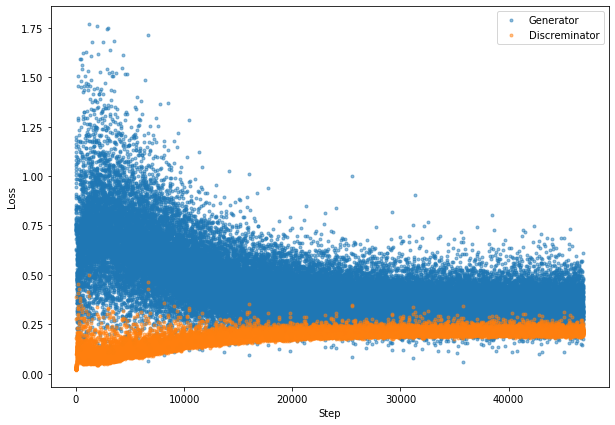

In [11]:
# 预测曲线
plt.figure(figsize = (10, 7))
plt.plot([i[1] for i in results], '.', label = 'Generator', alpha = 0.5)
plt.plot([i[0] for i in results], '.', label = 'Discreminator', alpha = 0.5)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

In [12]:
torch.save(Discriminator(), 'Dis_model.pth')  # 保存识别器模型
torch.save(Generator(), 'Gen_model.pth')  # 保存生成器模型

/data/wangke/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/data/wangke/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
